In [1]:
import sys
print(sys.version)

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline

import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
from tqdm import tqdm
import pickle

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Creating finalHgArFeb2019

## Actual creating finalHgAr_Feb2019

In [313]:
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalHgAr_expanded.pkl', 'rb') as f:
    finalHgAr=pickle.load(f)

In [643]:
def centering_algorithm(full_data,xinit,yinit,size_of_stamp):
    """!given the initial position, give a center of the image
    
    @param full_data        full science data image 
    @param xinit            x position of the initial guess 
    @param yinit            y position of the initial guess 
    @param size_of_stamp    size of the stamp that we wish to create
     """         
    
    
    
    # Iteration 0
    size_of_stamp_big=2*size_of_stamp
    xposmin=int(int(xinit)-size_of_stamp/2)
    xposmax=int(int(xinit)+size_of_stamp/2)
    yposmin=int(int(yinit)-size_of_stamp/2)
    yposmax=int(int(yinit)+size_of_stamp/2)
    print('0:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    med_pos=(int(np.round(np.median(np.where(np.any(scidata_cut>300, axis=1))))),
                    int(np.round(np.median(np.where(np.any(scidata_cut>300, axis=0))))))
    
    # Iteration 1
    new_xinit=xinit+med_pos[1]-size_of_stamp/2
    new_yinit=yinit+med_pos[0]-size_of_stamp/2
    xposmin=int(new_xinit-size_of_stamp/2)
    xposmax=int(new_xinit+size_of_stamp/2)
    yposmin=int(new_yinit-size_of_stamp/2)
    yposmax=int(new_yinit+size_of_stamp/2)
    print('1:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    
    
    # iteration 2
    centroid_of_flux_model=find_centroid_of_flux(scidata_cut)
    # print(centroid_of_flux_model)

    centroid_of_flux_model_int=np.array(map(int,map(np.round,centroid_of_flux_model)))
    dif_centroid_of_flux_model_int_from_center=np.array(centroid_of_flux_model)-np.array([int(size_of_stamp/2),int(size_of_stamp/2)])

    xposmin=int(np.round(xposmin+dif_centroid_of_flux_model_int_from_center[0]))
    xposmax=int(np.round(xposmax+dif_centroid_of_flux_model_int_from_center[0]))
    yposmin=int(np.round(yposmin+dif_centroid_of_flux_model_int_from_center[1]))
    yposmax=int(np.round(yposmax+dif_centroid_of_flux_model_int_from_center[1]))


    print('2:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    
    # iteration 3
    centroid_of_flux_model=find_centroid_of_flux(scidata_cut)
    # print(centroid_of_flux_model)

    centroid_of_flux_model_int=np.array(map(int,map(np.round,centroid_of_flux_model)))
    dif_centroid_of_flux_model_int_from_center=np.array(centroid_of_flux_model)-np.array([int(size_of_stamp/2),int(size_of_stamp/2)])

    xposmin=int(np.round(xposmin+dif_centroid_of_flux_model_int_from_center[0]))
    xposmax=int(np.round(xposmax+dif_centroid_of_flux_model_int_from_center[0]))
    yposmin=int(np.round(yposmin+dif_centroid_of_flux_model_int_from_center[1]))
    yposmax=int(np.round(yposmax+dif_centroid_of_flux_model_int_from_center[1]))

    print('3:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut=full_data[yposmin:yposmax,xposmin:xposmax]
    return [xposmin+size_of_stamp/2,yposmin+size_of_stamp/2]

In [644]:
def find_centroid_of_flux(image):
    """
    function giving the position of weighted average of the flux in a square image
    
    @param allparameters_proposal    array contaning suggested starting values for a model 
    """
    
    
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(len(image)):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(len(image)):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

In [645]:
def find_nearest_2(array, value):
    array = np.asarray(array)
    idx = np.sort(array - value)
    #print(idx)
    return np.array([np.max(idx[idx<0]),np.min(idx[idx>0])])+value

# x-coordinate for the old system
mean_x_old=finalHgAr[finalHgAr.wavelength.values=='706.8989']['xc'].values
print(mean_x_old)
# x-coordinate for the fibers in the new system
mean_x=[270,482,865,908,1241,1524,1627,2001,2130,2248,2456,2651,2845,3347,3644,3837]
print(mean_x)

[89 468 1253 1635 2023 2089 2471 2853 3631 4016]
[270, 482, 865, 908, 1241, 1524, 1627, 2001, 2130, 2248, 2456, 2651, 2845, 3347, 3644, 3837]


In [317]:
new_x_index=1
x_nearest_values=find_nearest_2(mean_x_old,mean_x[1])
old_fibers=[list(mean_x_old).index(x_nearest_values[0]),list(mean_x_old).index(x_nearest_values[1])]

distances=x_nearest_values-mean_x[1]
distances_normalized=distances/np.sum(np.abs(distances))
nearest_fiber=old_fibers[list(np.abs(distances_normalized)).index(np.min(np.abs(distances_normalized)))]

new_single_fiber_yc=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['yc'].values*(1-np.abs(distances_normalized[0]))+\
finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[1]]['yc'].values*(1-np.abs(distances_normalized[1]))
new_single_fiber_xc=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['xc'].values*(1-np.abs(distances_normalized[0]))+\
finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[1]]['xc'].values*(1-np.abs(distances_normalized[1]))

wavelength_new=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['wavelength'].values
close_new=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['close'].values

new_single_fiber_xc_effective=new_single_fiber_xc
if new_single_fiber_xc_effective[0]>2048:
    new_single_fiber_xc_effective=new_single_fiber_xc+69

new_single_fiber_old_index=finalHgAr[finalHgAr['fiber'].values.astype(int)==1].index.values
new_single_fiber_superold_index=finalHgAr[finalHgAr['fiber'].values.astype(int)==1].old_index.values


In [318]:
new_single_fiber_yc

array([781.6611464968153, 847.6611464968153, 964.6433121019109,
       1200.6254777070064, 1328.6076433121018, 1617.6076433121018,
       1978.5898089171974, 2346.571974522293, 2646.5541401273886,
       3356.5184713375793, 3477.5184713375793, 4000.4471337579616],
      dtype=object)

In [319]:
new_single_fiber_yc[new_single_fiber_yc>3000]*1.003

array([3366.5880267515918, 3487.9510267515916, 4012.448475159235],
      dtype=object)

In [392]:
list_of_fiber_values=[]
for new_x_index in range(16):


    x_nearest_values=find_nearest_2(mean_x_old,mean_x[new_x_index])
    old_fibers=[list(mean_x_old).index(x_nearest_values[0]),list(mean_x_old).index(x_nearest_values[1])]

    distances=x_nearest_values-mean_x[new_x_index]
    distances_normalized=distances/np.sum(np.abs(distances))
    nearest_fiber=old_fibers[list(np.abs(distances_normalized)).index(np.min(np.abs(distances_normalized)))]

    new_single_fiber_yc=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['yc'].values*(1-np.abs(distances_normalized[0]))+\
    finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[1]]['yc'].values*(1-np.abs(distances_normalized[1]))
    new_single_fiber_yc[new_single_fiber_yc>3000]=new_single_fiber_yc[new_single_fiber_yc>3000]*1.001
    new_single_fiber_xc=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['xc'].values*(1-np.abs(distances_normalized[0]))+\
    finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[1]]['xc'].values*(1-np.abs(distances_normalized[1]))

    wavelength_new=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['wavelength'].values
    close_new=finalHgAr[finalHgAr.fiber.values.astype(int)==old_fibers[0]]['close'].values

    new_single_fiber_xc_effective=new_single_fiber_xc
    if new_single_fiber_xc_effective[0]>2048:
        new_single_fiber_xc_effective=new_single_fiber_xc+69

    new_single_fiber_old_index=finalHgAr[finalHgAr['fiber'].values.astype(int)==nearest_fiber].index.values
    new_single_fiber_superold_index=finalHgAr[finalHgAr['fiber'].values.astype(int)==nearest_fiber].old_index.values

    fiber_single=np.hstack((np.array([np.full(12,new_x_index)]).T,np.array([new_single_fiber_xc.astype(int)]).T,np.array([new_single_fiber_yc.astype(int)]).T,np.array([wavelength_new]).astype(float).T,np.array([close_new]).astype(int).T,np.array([["HgAr","HgAr","HgAr","HgAr","HgAr","HgAr","HgAr","HgAr","HgAr","HgAr","HgAr","HgAr"]]).T,
                     np.array([new_single_fiber_xc_effective.astype(int)]).T,np.array([new_single_fiber_old_index]).T,np.array([new_single_fiber_superold_index]).T))

    list_of_fiber_values.append(fiber_single)

for new_x_index in range(16):  
    if new_x_index==0:
        pass
    if new_x_index==1:
        array_of_fiber_values=np.vstack((list_of_fiber_values[0],list_of_fiber_values[1]))
    if new_x_index>1:
        array_of_fiber_values=np.vstack((array_of_fiber_values,list_of_fiber_values[new_x_index]))

In [393]:
initialHgAr_Feb2019=pd.DataFrame(array_of_fiber_values,columns=['fiber','xc','yc','wavelength','close','lamp','xc_effective','old_index_approx','superold_index_approx'])

In [394]:
initialHgAr_Feb2019

fiber    xc    yc wavelength close  lamp xc_effective old_index_approx  \
0       0   269   789   690.9346     0  HgAr          269                0   
1       0   269   855   696.7261     1  HgAr          269                1   
2       0   270   972   706.8989     0  HgAr          270                2   
3       0   271  1208  727.47876     1  HgAr          271                3   
4       0   272  1336   738.6248     0  HgAr          272                4   
5       0   272  1626  763.74286     1  HgAr          272                5   
6       0   272  1987   795.0522     1  HgAr          272                6   
7       0   272  2355   826.6699     1  HgAr          272                7   
8       0   271  2656   852.4029     1  HgAr          271                8   
9       0   267  3371   912.5693     1  HgAr          267                9   
10      0   265  3492   922.7301     0  HgAr          265               10   
11      0   260  4017   966.0642     1  HgAr          260               11   
12      1   482   781   690.9346     0  HgAr          482               12   
13      1   482   847   696.7261     1  HgAr          482               13   
14      1   482   964   706.8989     0  HgAr          482               14   
15      1   482  1200  727.47876     1  HgAr          482               15   
16      1   483  1328   738.6248     0  HgAr          483               16   
17      1   483  1617  763.74286     1  HgAr          483               17   
18      1   483  1978   795.0522     1  HgAr          483               18   
19      1   483  2346   826.6699     1  HgAr          483               19   
20      1   482  2646   852.4029     1  HgAr          482               20   
21      1   480  3359   912.5693     1  HgAr          480               21   
22      1   479  3480   922.7301     0  HgAr          479               22   
23      1   474  4004   966.0642     1  HgAr          474               23   
24      2   865   772   690.9346     0  HgAr          865               24   
25      2   865   838   696.7261     1  HgAr          865               25   
26      2   865   954   706.8989     0  HgAr          865               26   
27      2   865  1190  727.47876     1  HgAr          865               27   
28      2   865  1317   738.6248     0  HgAr          865               28   
29      2   866  1606  763.74286     1  HgAr          866               29   
..    ...   ...   ...        ...   ...   ...          ...              ...   
162    13  3344  1973   795.0522     1  HgAr         3413              102   
163    13  3344  2340   826.6699     1  HgAr         3413              103   
164    13  3345  2640   852.4029     1  HgAr         3414              104   
165    13  3347  3353   912.5693     1  HgAr         3416              105   
166    13  3347  3474   922.7301     0  HgAr         3416              106   
167    13  3351  3996   966.0642     1  HgAr         3420              107   
168    14  3645   785   690.9346     0  HgAr         3714               96   
169    14  3645   851   696.7261     1  HgAr         3714               97   
170    14  3644   968   706.8989     0  HgAr         3713               98   
171    14  3643  1204  727.47876     1  HgAr         3712               99   
172    14  3642  1331   738.6248     0  HgAr         3711              100   
173    14  3641  1620  763.74286     1  HgAr         3710              101   
174    14  3641  1982   795.0522     1  HgAr         3710              102   
175    14  3641  2349   826.6699     1  HgAr         3710              103   
176    14  3642  2649   852.4029     1  HgAr         3711              104   
177    14  3645  3364   912.5693     1  HgAr         3714              105   
178    14  3645  3485   922.7301     0  HgAr         3714              106   
179    14  3650  4007   966.0642     1  HgAr         3719              107   
180    15  3838   792   690.9346     0  HgAr         3907              108   
181    15  3838   859   69

In [395]:
sci_data=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB12/Feb2019/rerun/Feb12_2019/arc/calExp/2019-02-02/v0011748/calExp-LA011748r1.fits')[1].data

In [396]:
res_centers=[]
for i in range(len(initialHgAr_Feb2019)):
    print('spot:'+str(i))
    res_centers.append(centering_algorithm(sci_data,int(initialHgAr_Feb2019.loc[i]['xc']),int(initialHgAr_Feb2019.loc[i]['yc']),20))
    
res_centers=np.array(res_centers)

spot:0
0:[779, 799, 259, 279]
1:[779, 799, 263, 283]
2:[779, 799, 263, 283]
3:[779, 799, 263, 283]
spot:1
0:[845, 865, 259, 279]
1:[845, 865, 264, 284]
2:[845, 865, 264, 284]
3:[845, 865, 264, 284]
spot:2
0:[962, 982, 260, 280]
1:[962, 982, 264, 284]
2:[962, 982, 264, 284]
3:[962, 982, 264, 284]
spot:3
0:[1198, 1218, 261, 281]
1:[1198, 1218, 264, 284]
2:[1198, 1218, 264, 284]
3:[1198, 1218, 264, 284]
spot:4
0:[1326, 1346, 262, 282]
1:[1326, 1346, 264, 284]
2:[1325, 1345, 264, 284]
3:[1325, 1345, 264, 284]
spot:5
0:[1616, 1636, 262, 282]
1:[1615, 1635, 264, 284]
2:[1615, 1635, 264, 284]
3:[1615, 1635, 264, 284]
spot:6
0:[1977, 1997, 262, 282]
1:[1977, 1997, 264, 284]
2:[1977, 1997, 264, 284]
3:[1977, 1997, 264, 284]
spot:7
0:[2345, 2365, 262, 282]
1:[2345, 2365, 262, 282]
2:[2344, 2364, 262, 282]
3:[2344, 2364, 262, 282]
spot:8
0:[2646, 2666, 261, 281]
1:[2645, 2665, 261, 281]
2:[2645, 2665, 260, 280]
3:[2645, 2665, 260, 280]
spot:9
0:[3361, 3381, 257, 277]
1:[3356, 3376, 255, 275]
2:[3

1:[1586, 1606, 1621, 1641]
2:[1585, 1605, 1621, 1641]
3:[1585, 1605, 1621, 1641]
spot:78
0:[1941, 1961, 1617, 1637]
1:[1945, 1965, 1620, 1640]
2:[1946, 1966, 1620, 1640]
3:[1946, 1966, 1620, 1640]
spot:79
0:[2307, 2327, 1617, 1637]
1:[2312, 2332, 1619, 1639]
2:[2312, 2332, 1619, 1639]
3:[2312, 2332, 1619, 1639]
spot:80
0:[2606, 2626, 1616, 1636]
1:[2612, 2632, 1618, 1638]
2:[2612, 2632, 1618, 1638]
3:[2612, 2632, 1618, 1638]
spot:81
0:[3317, 3337, 1615, 1635]
1:[3319, 3339, 1615, 1635]
2:[3319, 3339, 1615, 1635]
3:[3319, 3339, 1615, 1635]
spot:82
0:[3437, 3457, 1615, 1635]
1:[3440, 3460, 1615, 1635]
2:[3440, 3460, 1615, 1635]
3:[3440, 3460, 1615, 1635]
spot:83
0:[3957, 3977, 1613, 1633]
1:[3959, 3979, 1612, 1632]
2:[3959, 3979, 1612, 1632]
3:[3959, 3979, 1612, 1632]
spot:84
0:[746, 766, 1991, 2011]
1:[752, 772, 1998, 2018]
2:[752, 772, 1998, 2018]
3:[752, 772, 1998, 2018]
spot:85
0:[812, 832, 1991, 2011]
1:[818, 838, 1998, 2018]
2:[818, 838, 1998, 2018]
3:[818, 838, 1998, 2018]
spot:86

2:[3331, 3351, 2834, 2854]
3:[3331, 3351, 2834, 2854]
spot:154
0:[3446, 3466, 2834, 2854]
1:[3452, 3472, 2834, 2854]
2:[3451, 3471, 2834, 2854]
3:[3451, 3471, 2834, 2854]
spot:155
0:[3966, 3986, 2835, 2855]
1:[3972, 3992, 2834, 2854]
2:[3972, 3992, 2834, 2854]
3:[3972, 3992, 2834, 2854]
spot:156
0:[767, 787, 3337, 3357]
1:[775, 795, 3342, 3362]
2:[775, 795, 3342, 3362]
3:[775, 795, 3342, 3362]
spot:157
0:[833, 853, 3337, 3357]
1:[840, 860, 3341, 3361]
2:[841, 861, 3342, 3362]
3:[841, 861, 3342, 3362]
spot:158
0:[950, 970, 3337, 3357]
1:[958, 978, 3341, 3361]
2:[957, 977, 3341, 3361]
3:[957, 977, 3341, 3361]
spot:159
0:[1185, 1205, 3336, 3356]
1:[1193, 1213, 3340, 3360]
2:[1193, 1213, 3340, 3360]
3:[1193, 1213, 3340, 3360]
spot:160
0:[1313, 1333, 3335, 3355]
1:[1320, 1340, 3339, 3359]
2:[1321, 1341, 3339, 3359]
3:[1321, 1341, 3339, 3359]
spot:161
0:[1601, 1621, 3335, 3355]
1:[1608, 1628, 3337, 3357]
2:[1609, 1629, 3337, 3357]
3:[1609, 1629, 3337, 3357]
spot:162
0:[1963, 1983, 3334, 3354

In [397]:
finalHgAr_Feb2019=initialHgAr_Feb2019.copy()

In [398]:
res_centers

array([[ 273.,  789.],
       [ 274.,  855.],
       [ 274.,  972.],
       [ 274., 1208.],
       [ 274., 1335.],
       [ 274., 1625.],
       [ 274., 1987.],
       [ 272., 2354.],
       [ 270., 2655.],
       [ 264., 3366.],
       [ 263., 3487.],
       [ 256., 4011.],
       [ 484.,  782.],
       [ 485.,  848.],
       [ 485.,  965.],
       [ 485., 1201.],
       [ 485., 1328.],
       [ 485., 1617.],
       [ 484., 1979.],
       [ 483., 2346.],
       [ 481., 2646.],
       [ 476., 3357.],
       [ 475., 3478.],
       [ 468., 4000.],
       [ 868.,  772.],
       [ 868.,  839.],
       [ 868.,  955.],
       [ 868., 1190.],
       [ 868., 1318.],
       [ 867., 1606.],
       [ 867., 1968.],
       [ 865., 2334.],
       [ 864., 2634.],
       [ 860., 3343.],
       [ 859., 3464.],
       [ 854., 3985.],
       [ 911.,  772.],
       [ 911.,  838.],
       [ 911.,  954.],
       [ 911., 1190.],
       [ 911., 1317.],
       [ 911., 1605.],
       [ 910., 1966.],
       [ 90

In [399]:
finalHgAr_Feb2019['xc']=res_centers[:,0].astype(int)
finalHgAr_Feb2019['yc']=res_centers[:,1].astype(int)
finalHgAr_Feb2019['xc_effective']=finalHgAr_Feb2019['xc']
finalHgAr_Feb2019['xc_effective'].values[finalHgAr_Feb2019['xc_effective'].values>2048]=finalHgAr_Feb2019['xc_effective'].values[finalHgAr_Feb2019['xc_effective'].values>2048]+69

In [400]:
# insights from looking at the early Feb data 
finalHgAr_Feb2019.loc[finalHgAr_Feb2019['wavelength']=='826.6699','close']=np.full(16,0.5)
finalHgAr_Feb2019.loc[finalHgAr_Feb2019['wavelength']=='763.74286','close']=np.full(16,0.5)
finalHgAr_Feb2019.loc[finalHgAr_Feb2019['wavelength']=='852.4029','close']=np.full(16,0.5)


In [401]:
finalHgAr_Feb2019

fiber    xc    yc wavelength close  lamp  xc_effective old_index_approx  \
0       0   273   789   690.9346     0  HgAr           273                0   
1       0   274   855   696.7261     1  HgAr           274                1   
2       0   274   972   706.8989     0  HgAr           274                2   
3       0   274  1208  727.47876     1  HgAr           274                3   
4       0   274  1335   738.6248     0  HgAr           274                4   
5       0   274  1625  763.74286   0.5  HgAr           274                5   
6       0   274  1987   795.0522     1  HgAr           274                6   
7       0   272  2354   826.6699   0.5  HgAr           272                7   
8       0   270  2655   852.4029   0.5  HgAr           270                8   
9       0   264  3366   912.5693     1  HgAr           264                9   
10      0   263  3487   922.7301     0  HgAr           263               10   
11      0   256  4011   966.0642     1  HgAr           256               11   
12      1   484   782   690.9346     0  HgAr           484               12   
13      1   485   848   696.7261     1  HgAr           485               13   
14      1   485   965   706.8989     0  HgAr           485               14   
15      1   485  1201  727.47876     1  HgAr           485               15   
16      1   485  1328   738.6248     0  HgAr           485               16   
17      1   485  1617  763.74286   0.5  HgAr           485               17   
18      1   484  1979   795.0522     1  HgAr           484               18   
19      1   483  2346   826.6699   0.5  HgAr           483               19   
20      1   481  2646   852.4029   0.5  HgAr           481               20   
21      1   476  3357   912.5693     1  HgAr           476               21   
22      1   475  3478   922.7301     0  HgAr           475               22   
23      1   468  4000   966.0642     1  HgAr           468               23   
24      2   868   772   690.9346     0  HgAr           868               24   
25      2   868   839   696.7261     1  HgAr           868               25   
26      2   868   955   706.8989     0  HgAr           868               26   
27      2   868  1190  727.47876     1  HgAr           868               27   
28      2   868  1318   738.6248     0  HgAr           868               28   
29      2   867  1606  763.74286   0.5  HgAr           867               29   
..    ...   ...   ...        ...   ...   ...           ...              ...   
162    13  3346  1981   795.0522     1  HgAr          3415              102   
163    13  3345  2348   826.6699   0.5  HgAr          3414              103   
164    13  3345  2648   852.4029   0.5  HgAr          3414              104   
165    13  3345  3358   912.5693     1  HgAr          3414              105   
166    13  3345  3479   922.7301     0  HgAr          3414              106   
167    13  3347  4001   966.0642     1  HgAr          3416              107   
168    14  3650   795   690.9346     0  HgAr          3719               96   
169    14  3649   861   696.7261     1  HgAr          3718               97   
170    14  3648   978   706.8989     0  HgAr          3717               98   
171    14  3647  1214  727.47876     1  HgAr          3716               99   
172    14  3646  1342   738.6248     0  HgAr          3715              100   
173    14  3644  1631  763.74286   0.5  HgAr          3713              101   
174    14  3643  1993   795.0522     1  HgAr          3712              102   
175    14  3642  2361   826.6699   0.5  HgAr          3711              103   
176    14  3642  2661   852.4029   0.5  HgAr          3711              104   
177    14  3643  3372   912.5693     1  HgAr          3712              105   
178    14  3643  3494   922.7301     0  HgAr          3712              106   
179    14  3646  4017   966.0642     1  HgAr          3715              107   
180    15  3843   802   690.9346     0  HgAr          

In [403]:
finalHgAr_Feb2019.to_pickle('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalHgAr_Feb2019.pkl')
initialHgAr_Feb2019.to_pickle('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/initialHgAr_Feb2019.pkl')

## Centering algorithm standalone to check things

In [281]:
    size_of_stamp=20
    xinit=3481
    yinit=3645
    size_of_stamp_big=2*size_of_stamp
    full_data=sci_data
    xposmin=int(int(xinit)-size_of_stamp/2)
    xposmax=int(int(xinit)+size_of_stamp/2)
    yposmin=int(int(yinit)-size_of_stamp/2)
    yposmax=int(int(yinit)+size_of_stamp/2)
    print('0:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut0=full_data[yposmin:yposmax,xposmin:xposmax]
    med_pos=(int(np.round(np.median(np.where(np.any(scidata_cut0>300, axis=1))))),
                    int(np.round(np.median(np.where(np.any(scidata_cut0>300, axis=0))))))
    print(med_pos)
    # Iteration 1
    new_xinit=xinit+med_pos[1]-size_of_stamp/2
    new_yinit=yinit+med_pos[0]-size_of_stamp/2
    xposmin=int(new_xinit-size_of_stamp/2)
    xposmax=int(new_xinit+size_of_stamp/2)
    yposmin=int(new_yinit-size_of_stamp/2)
    yposmax=int(new_yinit+size_of_stamp/2)
    print('1:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut1=full_data[yposmin:yposmax,xposmin:xposmax]
    
    
    
    # iteration 2
    centroid_of_flux_model=find_centroid_of_flux(scidata_cut1)
    # print(centroid_of_flux_model)

    centroid_of_flux_model_int=np.array(map(int,map(np.round,centroid_of_flux_model)))
    dif_centroid_of_flux_model_int_from_center=np.array(centroid_of_flux_model)-np.array([int(size_of_stamp/2),int(size_of_stamp/2)])

    xposmin=int(np.round(xposmin+dif_centroid_of_flux_model_int_from_center[0]))
    xposmax=int(np.round(xposmax+dif_centroid_of_flux_model_int_from_center[0]))
    yposmin=int(np.round(yposmin+dif_centroid_of_flux_model_int_from_center[1]))
    yposmax=int(np.round(yposmax+dif_centroid_of_flux_model_int_from_center[1]))


    print('2:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut2=full_data[yposmin:yposmax,xposmin:xposmax]
    
    # iteration 3
    centroid_of_flux_model=find_centroid_of_flux(scidata_cut2)
    # print(centroid_of_flux_model)

    centroid_of_flux_model_int=np.array(map(int,map(np.round,centroid_of_flux_model)))
    dif_centroid_of_flux_model_int_from_center=np.array(centroid_of_flux_model)-np.array([int(size_of_stamp/2),int(size_of_stamp/2)])

    xposmin=int(np.round(xposmin+dif_centroid_of_flux_model_int_from_center[0]))
    xposmax=int(np.round(xposmax+dif_centroid_of_flux_model_int_from_center[0]))
    yposmin=int(np.round(yposmin+dif_centroid_of_flux_model_int_from_center[1]))
    yposmax=int(np.round(yposmax+dif_centroid_of_flux_model_int_from_center[1]))

    print('3:'+str([yposmin,yposmax,xposmin,xposmax]))
    scidata_cut3=full_data[yposmin:yposmax,xposmin:xposmax]

0:[3635, 3655, 3471, 3491]


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

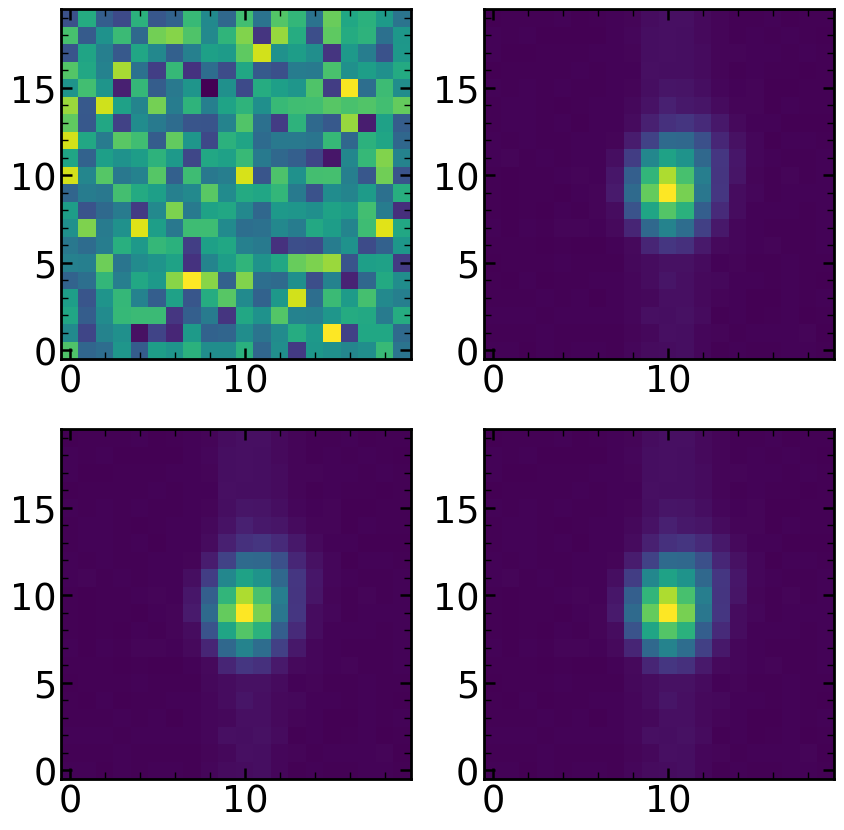

In [170]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(scidata_cut0,origin='lower')
plt.subplot(222)
plt.imshow(scidata_cut1,origin='lower')
plt.subplot(223)
plt.imshow(scidata_cut2,origin='lower')
plt.subplot(224)
plt.imshow(scidata_cut3,origin='lower')

# Creating finalNeonFeb2019

In [650]:
# import algoritms from CreatingfinalHgArFeb2019

with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_14/Dataframes/finalNe_expanded.pkl', 'rb') as f:
    finalNe=pickle.load(f)

In [651]:
# x-coordinate for the old system
mean_x_old=finalNe[finalNe.wavelength.values=='724.72437']['xc'].values
print(mean_x_old)
# x-coordinate for the fibers in the new system
mean_x=[270,482,865,908,1241,1524,1627,2001,2130,2248,2456,2651,2845,3347,3644,3837]
print(mean_x)

[90 469 1253 1635 2023 2089 2471 2852 3630 4015]
[270, 482, 865, 908, 1241, 1524, 1627, 2001, 2130, 2248, 2456, 2651, 2845, 3347, 3644, 3837]


In [676]:
new_x_index=1
x_nearest_values=find_nearest_2(mean_x_old,mean_x[1])
old_fibers=[list(mean_x_old).index(x_nearest_values[0]),list(mean_x_old).index(x_nearest_values[1])]

distances=x_nearest_values-mean_x[1]
distances_normalized=distances/np.sum(np.abs(distances))
nearest_fiber=old_fibers[list(np.abs(distances_normalized)).index(np.min(np.abs(distances_normalized)))]

new_single_fiber_yc=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['yc'].values*(1-np.abs(distances_normalized[0]))+\
finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[1]]['yc'].values*(1-np.abs(distances_normalized[1]))
new_single_fiber_xc=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['xc'].values*(1-np.abs(distances_normalized[0]))+\
finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[1]]['xc'].values*(1-np.abs(distances_normalized[1]))

wavelength_new=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['wavelength'].values
close_new=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['close'].values

new_single_fiber_xc_effective=new_single_fiber_xc
if new_single_fiber_xc_effective[0]>2048:
    new_single_fiber_xc_effective=new_single_fiber_xc+69

new_single_fiber_old_index=finalNe[finalNe['fiber'].values.astype(float).astype(int)==1].index.values
new_single_fiber_superold_index=finalNe[finalNe['fiber'].values.astype(float).astype(int)==1].old_index.values


In [696]:
list_of_fiber_values=[]
for new_x_index in range(16):


    x_nearest_values=find_nearest_2(mean_x_old,mean_x[new_x_index])
    old_fibers=[list(mean_x_old).index(x_nearest_values[0]),list(mean_x_old).index(x_nearest_values[1])]

    distances=x_nearest_values-mean_x[new_x_index]
    distances_normalized=distances/np.sum(np.abs(distances))
    nearest_fiber=old_fibers[list(np.abs(distances_normalized)).index(np.min(np.abs(distances_normalized)))]

    new_single_fiber_yc=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['yc'].values*(1-np.abs(distances_normalized[0]))+\
    finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[1]]['yc'].values*(1-np.abs(distances_normalized[1]))+15
    new_single_fiber_yc[new_single_fiber_yc>3000]=new_single_fiber_yc[new_single_fiber_yc>3000]*1.001
    new_single_fiber_xc=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['xc'].values*(1-np.abs(distances_normalized[0]))+\
    finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[1]]['xc'].values*(1-np.abs(distances_normalized[1]))

    wavelength_new=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['wavelength'].values
    close_new=finalNe[finalNe.fiber.values.astype(float).astype(int)==old_fibers[0]]['close'].values

    new_single_fiber_xc_effective=new_single_fiber_xc
    if new_single_fiber_xc_effective[0]>2048:
        new_single_fiber_xc_effective=new_single_fiber_xc+69

    new_single_fiber_old_index=finalNe[finalNe['fiber'].values.astype(float).astype(int)==nearest_fiber].index.values
    new_single_fiber_superold_index=finalNe[finalNe['fiber'].values.astype(float).astype(int)==nearest_fiber].old_index.values

    # here you have to manually insert the number of spots that you will cut
    # and the names of the lines
    fiber_single=np.hstack((np.array([np.full(9,new_x_index)]).T,np.array([new_single_fiber_xc.astype(int)]).T,np.array([new_single_fiber_yc.astype(float).astype(int)]).T,np.array([wavelength_new]).astype(float).T,np.array([close_new]).astype(float).astype(int).T,np.array([["Ne","Ne","Ne","Ne","Ne","Ne","Ne","Ne","Ne"]]).T,
                     np.array([new_single_fiber_xc_effective.astype(float).astype(int)]).T,np.array([new_single_fiber_old_index]).T,np.array([new_single_fiber_superold_index]).T))

    list_of_fiber_values.append(fiber_single)

for new_x_index in range(16):  
    if new_x_index==0:
        pass
    if new_x_index==1:
        array_of_fiber_values=np.vstack((list_of_fiber_values[0],list_of_fiber_values[1]))
    if new_x_index>1:
        array_of_fiber_values=np.vstack((array_of_fiber_values,list_of_fiber_values[new_x_index]))

In [697]:
initialNe_Feb2019=pd.DataFrame(array_of_fiber_values,columns=['fiber','xc','yc','wavelength','close','lamp','xc_effective','old_index_approx','superold_index_approx'])

In [869]:
initialNe_Feb2019

fiber    xc    yc wavelength close lamp xc_effective old_index_approx  \
0       0   264   344  650.84186     0   Ne          264                0   
1       0   264   374   653.4774     0   Ne          264                1   
2       0   265   450   660.0668     1   Ne          265                2   
3       0   266   541  668.01764     0   Ne          266                3   
4       0   266   585   671.9268     0   Ne          266                4   
5       0   268   829  693.13116     1   Ne          268                5   
6       0   270  1109  717.59015     1   Ne          270                6   
7       0   270  1191  724.72437     1   Ne          270                7   
8       0   271  1414   744.1276     0   Ne          271                8   
9       1   478   337  650.84186     0   Ne          478                9   
10      1   478   367   653.4774     0   Ne          478               10   
11      1   478   443   660.0668     1   Ne          478               11   
12      1   479   533  668.01764     0   Ne          479               12   
13      1   479   578   671.9268     0   Ne          479               13   
14      1   481   821  693.13116     1   Ne          481               14   
15      1   482  1101  717.59015     1   Ne          482               15   
16      1   482  1183  724.72437     1   Ne          482               16   
17      1   483  1406   744.1276     0   Ne          483               17   
18      2   862   328  650.84186     0   Ne          862               18   
19      2   862   358   653.4774     0   Ne          862               19   
20      2   862   434   660.0668     1   Ne          862               20   
21      2   863   524  668.01764     0   Ne          863               21   
22      2   863   569   671.9268     0   Ne          863               22   
23      2   864   812  693.13116     1   Ne          864               23   
24      2   865  1091  717.59015     1   Ne          865               24   
25      2   865  1173  724.72437     1   Ne          865               25   
26      2   866  1395   744.1276     0   Ne          866               26   
27      3   905   327  650.84186     0   Ne          905               18   
28      3   905   357   653.4774     0   Ne          905               19   
29      3   905   433   660.0668     1   Ne          905               20   
..    ...   ...   ...        ...   ...  ...          ...              ...   
114    12  2845  1083  717.59015     1   Ne         2914               69   
115    12  2845  1165  724.72437     1   Ne         2914               70   
116    12  2844  1387   744.1276     0   Ne         2913               71   
117    13  3351   333  650.84186     0   Ne         3420               72   
118    13  3351   364   653.4774     0   Ne         3420               73   
119    13  3350   439   660.0668     1   Ne         3419               74   
120    13  3350   530  668.01764     0   Ne         3419               75   
121    13  3350   575   671.9268     0   Ne         3419               76   
122    13  3348   817  693.13116     1   Ne         3417               77   
123    13  3347  1097  717.59015     1   Ne         3416               78   
124    13  3347  1179  724.72437     1   Ne         3416               79   
125    13  3346  1401   744.1276     0   Ne         3415               80   
126    14  3650   340  650.84186     0   Ne         3719               72   
127    14  3649   371   653.4774     0   Ne         3718               73   
128    14  3649   446   660.0668     1   Ne         3718               74   
129    14  3648   537  668.01764     0   Ne         3717               75   
130    14  3648   582   671.9268     0   Ne         3717               76   
131    14  3646   825  693.13116     1   Ne         3715               77   
132    14  3644  1105  717.59015     1   Ne         3713               78   
133    14  3644  1187  724.72437     1   Ne         3713               79   


In [685]:
sci_data=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB25/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-16/v0012355/calExp-LA012355r1.fits')[1].data

In [698]:
res_centers=[]
for i in range(len(initialNe_Feb2019)):
    print('spot:'+str(i))
    res_centers.append(centering_algorithm(sci_data,int(initialNe_Feb2019.loc[i]['xc']),int(initialNe_Feb2019.loc[i]['yc']),20))
    
res_centers=np.array(res_centers)

spot:0
0:[334, 354, 254, 274]
1:[337, 357, 247, 267]
2:[336, 356, 245, 265]
3:[336, 356, 245, 265]
spot:1
0:[364, 384, 254, 274]
1:[366, 386, 247, 267]
2:[366, 386, 245, 265]
3:[366, 386, 245, 265]
spot:2
0:[440, 460, 255, 275]
1:[442, 462, 247, 267]
2:[442, 462, 246, 266]
3:[442, 462, 246, 266]
spot:3
0:[531, 551, 256, 276]
1:[533, 553, 249, 269]
2:[533, 553, 247, 267]
3:[533, 553, 247, 267]
spot:4
0:[575, 595, 256, 276]
1:[577, 597, 249, 269]
2:[577, 597, 247, 267]
3:[577, 597, 247, 267]
spot:5
0:[819, 839, 258, 278]
1:[821, 841, 251, 271]
2:[821, 841, 249, 269]
3:[821, 841, 249, 269]
spot:6
0:[1099, 1119, 260, 280]
1:[1101, 1121, 252, 272]
2:[1101, 1121, 251, 271]
3:[1101, 1121, 251, 271]
spot:7
0:[1181, 1201, 260, 280]
1:[1183, 1203, 253, 273]
2:[1183, 1203, 251, 271]
3:[1183, 1203, 251, 271]
spot:8
0:[1404, 1424, 261, 281]
1:[1406, 1426, 253, 273]
2:[1406, 1426, 252, 272]
3:[1406, 1426, 252, 272]
spot:9
0:[327, 347, 468, 488]
1:[331, 351, 460, 480]
2:[329, 349, 457, 477]
3:[329, 3

0:[546, 566, 2446, 2466]
1:[547, 567, 2439, 2459]
2:[547, 567, 2439, 2459]
3:[547, 567, 2439, 2459]
spot:95
0:[789, 809, 2446, 2466]
1:[789, 809, 2439, 2459]
2:[789, 809, 2439, 2459]
3:[789, 809, 2439, 2459]
spot:96
0:[1068, 1088, 2446, 2466]
1:[1068, 1088, 2438, 2458]
2:[1068, 1088, 2438, 2458]
3:[1068, 1088, 2438, 2458]
spot:97
0:[1149, 1169, 2446, 2466]
1:[1149, 1169, 2439, 2459]
2:[1149, 1169, 2438, 2458]
3:[1149, 1169, 2438, 2458]
spot:98
0:[1371, 1391, 2445, 2465]
1:[1371, 1391, 2438, 2458]
2:[1371, 1391, 2438, 2458]
3:[1371, 1391, 2438, 2458]
spot:99
0:[310, 330, 2642, 2662]
1:[309, 329, 2636, 2656]
2:[309, 329, 2637, 2657]
3:[309, 329, 2637, 2657]
spot:100
0:[340, 360, 2642, 2662]
1:[339, 359, 2637, 2657]
2:[339, 359, 2637, 2657]
3:[339, 359, 2637, 2657]
spot:101
0:[415, 435, 2642, 2662]
1:[414, 434, 2636, 2656]
2:[414, 434, 2637, 2657]
3:[414, 434, 2637, 2657]
spot:102
0:[505, 525, 2642, 2662]
1:[505, 525, 2636, 2656]
2:[504, 524, 2636, 2656]
3:[504, 524, 2636, 2656]
spot:103


In [699]:
finalNe_Feb2019=initialNe_Feb2019.copy()

In [700]:
finalNe_Feb2019['xc']=res_centers[:,0].astype(int)
finalNe_Feb2019['yc']=res_centers[:,1].astype(int)
finalNe_Feb2019['xc_effective']=finalNe_Feb2019['xc']
finalNe_Feb2019['xc_effective'].values[finalNe_Feb2019['xc_effective'].values>2048]=finalNe_Feb2019['xc_effective'].values[finalNe_Feb2019['xc_effective'].values>2048]+69

In [400]:
# insights from looking at the early Feb data 
#finalHgAr_Feb2019.loc[finalHgAr_Feb2019['wavelength']=='826.6699','close']=np.full(16,0.5)
#finalHgAr_Feb2019.loc[finalHgAr_Feb2019['wavelength']=='763.74286','close']=np.full(16,0.5)
#finalHgAr_Feb2019.loc[finalHgAr_Feb2019['wavelength']=='852.4029','close']=np.full(16,0.5)


In [701]:
finalNe_Feb2019

fiber    xc    yc wavelength close lamp  xc_effective old_index_approx  \
0       0   255   346  650.84186     0   Ne           255                0   
1       0   255   376   653.4774     0   Ne           255                1   
2       0   256   452   660.0668     1   Ne           256                2   
3       0   257   543  668.01764     0   Ne           257                3   
4       0   257   587   671.9268     0   Ne           257                4   
5       0   259   831  693.13116     1   Ne           259                5   
6       0   261  1111  717.59015     1   Ne           261                6   
7       0   261  1193  724.72437     1   Ne           261                7   
8       0   262  1416   744.1276     0   Ne           262                8   
9       1   467   339  650.84186     0   Ne           467                9   
10      1   467   370   653.4774     0   Ne           467               10   
11      1   468   445   660.0668     1   Ne           468               11   
12      1   468   536  668.01764     0   Ne           468               12   
13      1   469   580   671.9268     0   Ne           469               13   
14      1   470   824  693.13116     1   Ne           470               14   
15      1   471  1104  717.59015     1   Ne           471               15   
16      1   472  1185  724.72437     1   Ne           472               16   
17      1   472  1408   744.1276     0   Ne           472               17   
18      2   851   330  650.84186     0   Ne           851               18   
19      2   852   360   653.4774     0   Ne           852               19   
20      2   852   435   660.0668     1   Ne           852               20   
21      2   852   526  668.01764     0   Ne           852               21   
22      2   853   570   671.9268     0   Ne           853               22   
23      2   854   813  693.13116     1   Ne           854               23   
24      2   854  1092  717.59015     1   Ne           854               24   
25      2   855  1174  724.72437     1   Ne           855               25   
26      2   855  1396   744.1276     0   Ne           855               26   
27      3   895   329  650.84186     0   Ne           895               18   
28      3   895   359   653.4774     0   Ne           895               19   
29      3   895   434   660.0668     1   Ne           895               20   
..    ...   ...   ...        ...   ...  ...           ...              ...   
114    12  2836  1083  717.59015     1   Ne          2905               69   
115    12  2836  1164  724.72437     1   Ne          2905               70   
116    12  2836  1386   744.1276     0   Ne          2905               71   
117    13  3340   331  650.84186     0   Ne          3409               72   
118    13  3340   361   653.4774     0   Ne          3409               73   
119    13  3339   437   660.0668     1   Ne          3408               74   
120    13  3339   528  668.01764     0   Ne          3408               75   
121    13  3339   572   671.9268     0   Ne          3408               76   
122    13  3337   815  693.13116     1   Ne          3406               77   
123    13  3336  1095  717.59015     1   Ne          3405               78   
124    13  3336  1176  724.72437     1   Ne          3405               79   
125    13  3336  1399   744.1276     0   Ne          3405               80   
126    14  3639   339  650.84186     0   Ne          3708               72   
127    14  3638   369   653.4774     0   Ne          3707               73   
128    14  3638   445   660.0668     1   Ne          3707               74   
129    14  3637   536  668.01764     0   Ne          3706               75   
130    14  3637   580   671.9268     0   Ne          3706               76   
131    14  3635   824  693.13116     1   Ne          3704               77   
132    14  3634  1104  717.59015     1   Ne          3703               78   
133    14  3633  1186  724

In [825]:
finalNe_Feb2019.to_pickle('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/finalNe_Feb2019.pkl')
initialNe_Feb2019.to_pickle('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Dataframes/initialNe_Feb2019.pkl')

## Checking results

# Cut data in focus

## Background

In [10]:
from astropy import stats

# Takes around 30 sec for a single image
# The first columns of list ``res'' shows residual
background_estimate=[]
for run in range(11695,11834,5):
    print("Analyzing run: "+str(run))
    data=fits.open('/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB12/Feb2019/rerun/Feb12_2019/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')
    res=stats.sigma_clipped_stats(data[1].data, sigma=2.5, iters=6)  
    background_estimate.append([data[0].header['W_ENFCAX'],res[0],res[1]])
    
background_estimate_sigma_clip=np.array(background_estimate)

Analyzing run: 11695
Analyzing run: 11700
Analyzing run: 11705
Analyzing run: 11710
Analyzing run: 11715
Analyzing run: 11720
Analyzing run: 11725


KeyboardInterrupt: 

In [397]:
background_estimate_sigma_clip=background_estimate_sigma_clip[background_estimate_sigma_clip[:,0].argsort()]

In [389]:
# secondary estimate, by looking at the area without sources 
background_estimate=[]
for run in range(11694,11805,1):
    data=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')
    res=np.mean(data[1].data[1250:2880,2960:3200])
    background_estimate.append([data[0].header['W_ENFCAX'],res])
    
background_estimate_direct=np.array(background_estimate)


In [391]:
# narrower to see if it is due to scattering 
background_estimate=[]
for run in range(11694,11805,1):
    data=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')
    res=np.mean(data[1].data[1250:2880,3060:3140])
    background_estimate.append([data[0].header['W_ENFCAX'],res])
    
background_estimate_direct_narrow=np.array(background_estimate)


In [425]:
z = np.polyfit(background_estimate_sigma_clip[:,0], background_estimate_sigma_clip[:,2], 3)
p = np.poly1d(z)
background_estimate_sigma_clip_fit=p(background_estimate_sigma_clip[:,0])

In [441]:
background_estimate_exposure_times=[]
for run in range(11695,11834,5):
    print("Analyzing run: "+str(run))
    data=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')
    background_estimate_exposure_times.append([data[0].header['W_ENFCAX'],data[0].header['EXPTIME']])
    
background_estimate_exposure_times=np.array(background_estimate_exposure_times)

Analyzing run: 11695
Analyzing run: 11700
Analyzing run: 11705
Analyzing run: 11710
Analyzing run: 11715
Analyzing run: 11720
Analyzing run: 11725
Analyzing run: 11730
Analyzing run: 11735
Analyzing run: 11740
Analyzing run: 11745
Analyzing run: 11750
Analyzing run: 11755
Analyzing run: 11760
Analyzing run: 11765
Analyzing run: 11770
Analyzing run: 11775
Analyzing run: 11780
Analyzing run: 11785
Analyzing run: 11790
Analyzing run: 11795
Analyzing run: 11800
Analyzing run: 11805
Analyzing run: 11810
Analyzing run: 11815
Analyzing run: 11820
Analyzing run: 11825
Analyzing run: 11830


In [485]:
list_of_background_with_exposure_times=[]
for i in range(len(background_estimate_sigma_clip[:,0])):
    list_of_background_with_exposure_times.append([background_estimate_exposure_times[background_estimate_exposure_times[:,0]==background_estimate_sigma_clip[i][0]][0][1],
                                                   background_estimate_sigma_clip[i][1],background_estimate_sigma_clip[i][0]])
    
array_of_background_with_exposure_times=np.array(list_of_background_with_exposure_times)

array_of_background_with_exposure_times=array_of_background_with_exposure_times[array_of_background_with_exposure_times[:,0].argsort()]

In [484]:
background_estimate_sigma_clip[i]

array([ 4.5       , 14.97125534, 14.6871357 ])

In [488]:
array_of_background_with_exposure_times_positive_focus=array_of_background_with_exposure_times[array_of_background_with_exposure_times[:,2]>0]
array_of_background_with_exposure_times_negative_focus=array_of_background_with_exposure_times[array_of_background_with_exposure_times[:,2]<0]

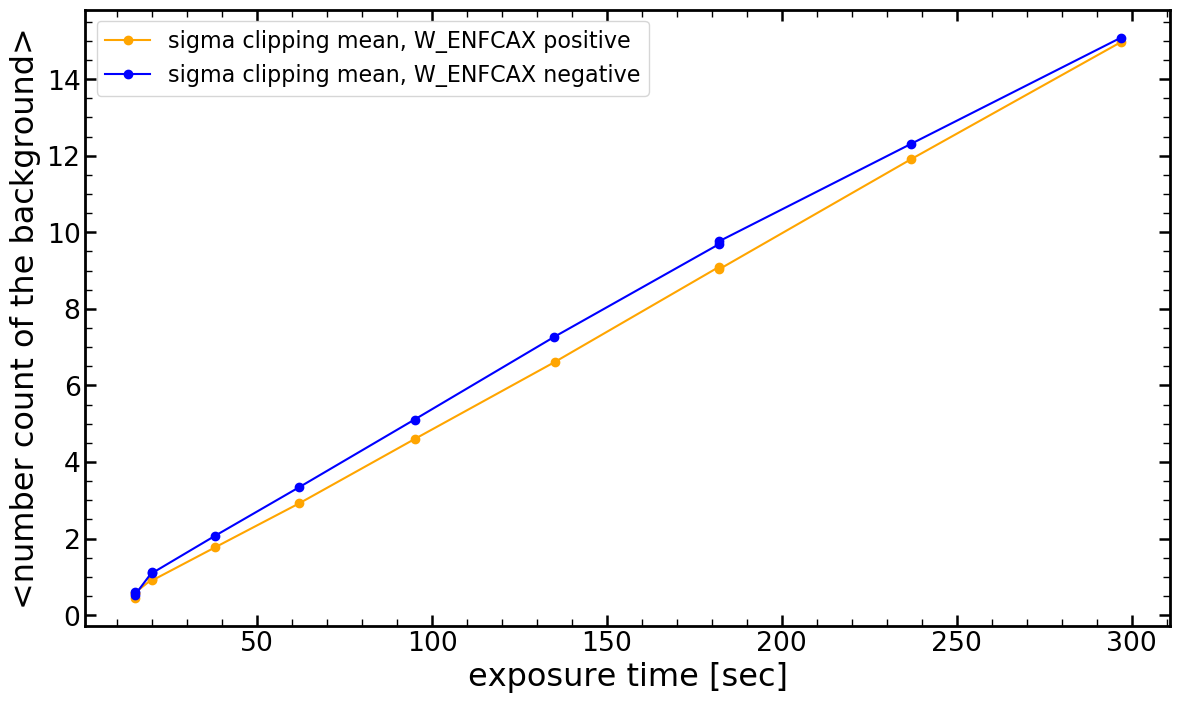

In [490]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,8))
plt.plot(array_of_background_with_exposure_times_positive_focus[:,0],array_of_background_with_exposure_times_positive_focus[:,1],marker='o',ls='-',color='orange',label='sigma clipping mean, W_ENFCAX positive')
plt.plot(array_of_background_with_exposure_times_negative_focus[:,0],array_of_background_with_exposure_times_negative_focus[:,1],marker='o',ls='-',color='blue',label='sigma clipping mean, W_ENFCAX negative')
#plt.plot(range(300),np.array(range(300))/300*15,label='linear relationship',ls='--',color='black')
plt.xlabel('exposure time [sec]')
plt.ylabel('<number count of the background>')
plt.legend()

In [451]:
background_estimate_sigma_clip[0][0]

-4.50001

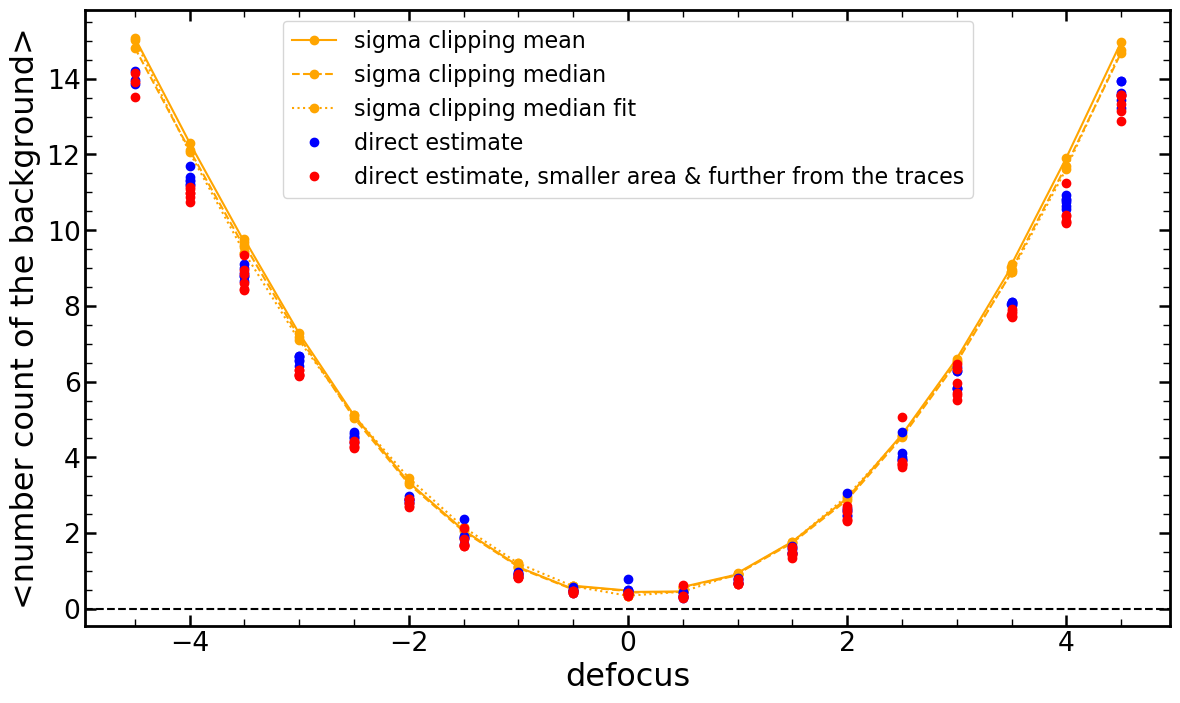

In [427]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,8))
plt.plot(background_estimate_sigma_clip[:,0],background_estimate_sigma_clip[:,1],marker='o',ls='-',color='orange',label='sigma clipping mean')
plt.plot(background_estimate_sigma_clip[:,0],background_estimate_sigma_clip[:,2],marker='o',ls='--',color='orange',label='sigma clipping median')
plt.plot(background_estimate_sigma_clip[:,0],background_estimate_sigma_clip_fit,marker='o',ls=':',color='orange',label='sigma clipping median fit')

plt.plot(background_estimate_direct[:,0],background_estimate_direct[:,1],marker='o',ls='',color='blue',label='direct estimate')
plt.plot(background_estimate_direct_narrow[:,0],background_estimate_direct_narrow[:,1],marker='o',ls='',color='red',label='direct estimate, smaller area & further from the traces')
plt.axhline(y=0,ls='--',color='black')
plt.xlabel('defocus')
plt.ylabel('<number count of the background>')
plt.legend()

In [399]:
p.save('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/background_estimate_sigma_clip', background_estimate_sigma_clip)
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/background_estimate_direct', background_estimate_direct)
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/background_estimate_direct_narrow', background_estimate_direct_narrow)

## testing

In [429]:
z=np.array([ 0.00555972,  0.71860376, -0.14291048,  0.34416228])
background_estimate_sigma_clip_fit_function=np.poly1d(z)

In [319]:
        scidata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011748/calExp-LA011748r1.fits')[1].data
        scidata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011749/calExp-LA011749r1.fits')[1].data
        scidata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011750/calExp-LA011750r1.fits')[1].data
        scidata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011751/calExp-LA011751r1.fits')[1].data
        scidata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011752/calExp-LA011752r1.fits')[1].data
        
        vardata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011748/calExp-LA011748r1.fits')[1].data
        vardata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011749/calExp-LA011749r1.fits')[1].data
        vardata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011750/calExp-LA011750r1.fits')[1].data
        vardata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011751/calExp-LA011751r1.fits')[1].data
        vardata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011752/calExp-LA011752r1.fits')[1].data
        ##########################################
        #### Code for a single image_index
        ##########################################
        image_index=95
        center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
        print(center_pos)
        #size=stamp.shape[0]/2
        size=10
        xposmin=int(np.round(center_pos[0]-size-10))
        xposmax=int(np.round(center_pos[0]+size+10))
        yposmin=int(np.round(center_pos[1]-size-45))
        yposmax=int(np.round(center_pos[1]+size+45))
        #print(xposmin,xposmax,yposmin,yposmax)
        scidata_cut=scidata_1[yposmin:yposmax,xposmin:xposmax]+scidata_2[yposmin:yposmax,xposmin:xposmax]+\
        scidata_3[yposmin:yposmax,xposmin:xposmax]+scidata_4[yposmin:yposmax,xposmin:xposmax]+scidata_5[yposmin:yposmax,xposmin:xposmax]
        vardata_cut=vardata_1[yposmin:yposmax,xposmin:xposmax]+vardata_2[yposmin:yposmax,xposmin:xposmax]+\
        vardata_3[yposmin:yposmax,xposmin:xposmax]+vardata_4[yposmin:yposmax,xposmin:xposmax]+vardata_5[yposmin:yposmax,xposmin:xposmax]     
        
        scidata_cut_original=np.copy(scidata_cut)
    
        sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-40:len(scidata_cut[:,0])-5]
        sci_lower_cut=scidata_cut[5:40]
        res=[]
        res_upper=[]
        res_upper_all_values=[]
        res_lower=[]
        res_lower_all_values=[]
        
        for j in range(scidata_cut.shape[1]):
            
            value=np.median(sci_lower_cut[:,j])     
            value_var=np.std(sci_lower_cut[:,j]) 
            if value>value_var:
                res_lower.append(value)
                res_lower_all_values.append(value)
            else:
                res_lower.append(0)    
                res_lower_all_values.append(value)

            value=np.median(sci_upper_cut[:,j])  
            value_var=np.std(sci_upper_cut[:,j])  
            if value>value_var:
                res_upper_all_values.append(value)
                res_upper.append(value)
            else:
                res_upper.append(0)
                res_upper_all_values.append(value)
                
        res_upper=np.array(res_upper)
        res_upper_all_values=np.array(res_upper_all_values)
        res_lower=np.array(res_lower)
        res_lower_all_values=np.array(res_lower_all_values)
        
        res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
        res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))
        # if there is another source in upper part, override it with lower half
        print(np.sum(sci_lower_cut)/np.sum(sci_upper_cut))
        if np.sum(sci_upper_cut)/np.sum(sci_lower_cut)>1.1:
            res_upper=res_lower

        # if there is another source in lower part, override it with upper half
        elif np.sum(sci_lower_cut)/np.sum(sci_upper_cut)>1.1:
            res_lower=res_upper
        print(res_upper)
        print(res_lower)
        for j in range(scidata_cut.shape[1]):    
            scidata_cut[0:int(scidata_cut.shape[0]/2),j]=scidata_cut[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
            scidata_cut[int(scidata_cut.shape[0]/2):,j]=scidata_cut[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            vardata_cut[0:int(scidata_cut.shape[0]/2),j]=vardata_cut[0:int(scidata_cut.shape[0]/2),j]+res_lower[j]
            vardata_cut[int(scidata_cut.shape[0]/2):,j]=vardata_cut[int(scidata_cut.shape[0]/2):,j]+res_upper[j]
        
        scidata_cut_small=scidata_cut[45:45+20,10:10+20]
        vardata_cut_small=vardata_cut[45:45+20,10:10+20]
        
        scidata_cut_large=scidata_cut[35:35+40,:]
        vardata_cut_large=vardata_cut[35:35+40,:]

[1999, 3968]
2.18503
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         22.29692304 19.55406034 14.60860097  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         22.29692304 19.55406034 14.60860097  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [312]:
##########################
# playing here if we want to do some sort of local fit 
##########################
res_lower=[]
for i in range(7):   
    res_lower.append(np.median(np.split(sci_lower_cut,7)[i],axis=0))
    
res_lower=np.array(res_lower)

res_upper=[]
for i in range(7):   
    res_upper.append(np.median(np.split(sci_upper_cut,7)[i],axis=0))
    
res_upper=np.array(res_upper)

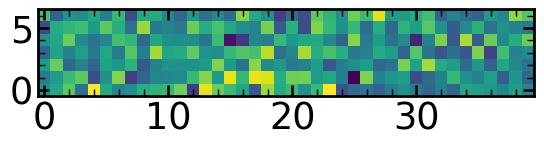

In [313]:
plt.imshow(res_upper)

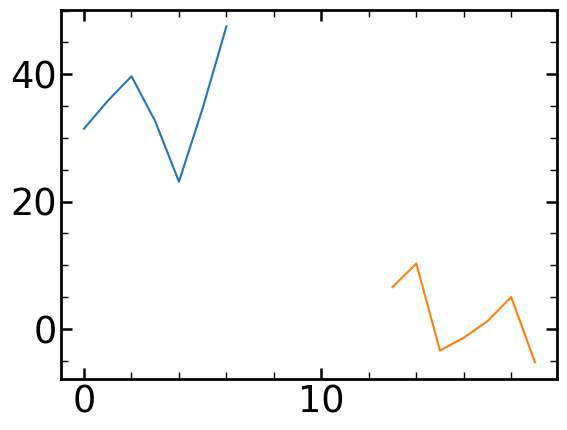

In [318]:
plt.plot(range(7),res_lower[:,20])
plt.plot(range(7+6,20),res_upper[:,20])

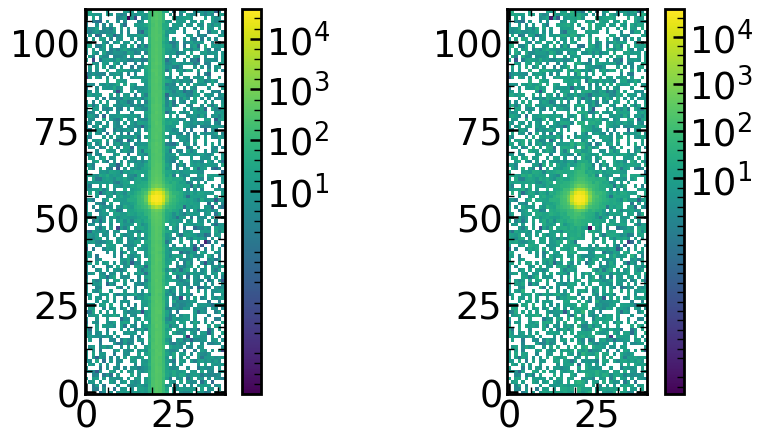

In [287]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(scidata_cut_original,norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(122)
plt.imshow(scidata_cut,norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [417]:
exposure_defocus_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11748)+'/calExp-LA011748r1.fits')[0].header['W_ENFCAX']
exposure_defocus_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11749)+'/calExp-LA011749r1.fits')[0].header['W_ENFCAX']
exposure_defocus_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11750)+'/calExp-LA011750r1.fits')[0].header['W_ENFCAX']
exposure_defocus_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11751)+'/calExp-LA011751r1.fits')[0].header['W_ENFCAX']
exposure_defocus_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11752)+'/calExp-LA011752r1.fits')[0].header['W_ENFCAX']
exposure_defocus=[exposure_defocus_1,exposure_defocus_2,exposure_defocus_3,exposure_defocus_4,exposure_defocus_5]
exposure_defocus=np.round(np.array(exposure_defocus),1)
# size of the array with unique defocuc values should be 1 
np.unique(exposure_defocus).size

1

## actual cut 

In [435]:
run=11748

exposure_defocus_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11748)+'/calExp-LA011748r1.fits')[0].header['W_ENFCAX']
exposure_defocus_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11749)+'/calExp-LA011749r1.fits')[0].header['W_ENFCAX']
exposure_defocus_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11750)+'/calExp-LA011750r1.fits')[0].header['W_ENFCAX']
exposure_defocus_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11751)+'/calExp-LA011751r1.fits')[0].header['W_ENFCAX']
exposure_defocus_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(11752)+'/calExp-LA011752r1.fits')[0].header['W_ENFCAX']
exposure_defocus=[exposure_defocus_1,exposure_defocus_2,exposure_defocus_3,exposure_defocus_4,exposure_defocus_5]
exposure_defocus=np.round(np.array(exposure_defocus),1)
# size of the array with unique defocuc values should be 1 
print(np.unique(exposure_defocus).size)

scidata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA011748r1.fits')[1].data
scidata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011749/calExp-LA011749r1.fits')[1].data
scidata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011750/calExp-LA011750r1.fits')[1].data
scidata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011751/calExp-LA011751r1.fits')[1].data
scidata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011752/calExp-LA011752r1.fits')[1].data

maskdata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA011748r1.fits')[2].data
maskdata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011749/calExp-LA011749r1.fits')[2].data
maskdata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011750/calExp-LA011750r1.fits')[2].data
maskdata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011751/calExp-LA011751r1.fits')[2].data
maskdata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011752/calExp-LA011752r1.fits')[2].data

vardata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA011748r1.fits')[3].data
vardata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011749/calExp-LA011749r1.fits')[3].data
vardata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011750/calExp-LA011750r1.fits')[3].data
vardata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011751/calExp-LA011751r1.fits')[3].data
vardata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v0011752/calExp-LA011752r1.fits')[3].data

for image_index in range(len(finalHgAr_Feb2019)):
    center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
    print(center_pos)
    #size=stamp.shape[0]/2
    size=10
    xposmin=int(np.round(center_pos[0]-size-10))
    xposmax=int(np.round(center_pos[0]+size+10))
    yposmin=int(np.round(center_pos[1]-size-45))
    yposmax=int(np.round(center_pos[1]+size+45))
    #print(xposmin,xposmax,yposmin,yposmax)
    scidata_cut=scidata_1[yposmin:yposmax,xposmin:xposmax]+scidata_2[yposmin:yposmax,xposmin:xposmax]+\
    scidata_3[yposmin:yposmax,xposmin:xposmax]+scidata_4[yposmin:yposmax,xposmin:xposmax]+scidata_5[yposmin:yposmax,xposmin:xposmax]
    
    # add background removal; 5 times as we have 5 images
    scidata_cut=scidata_cut-5*background_estimate_sigma_clip_fit_function(exposure_defocus[3])
    
    maskdata_cut=maskdata_1[yposmin:yposmax,xposmin:xposmax]+maskdata_2[yposmin:yposmax,xposmin:xposmax]+\
    maskdata_3[yposmin:yposmax,xposmin:xposmax]+maskdata_4[yposmin:yposmax,xposmin:xposmax]+maskdata_5[yposmin:yposmax,xposmin:xposmax]   
    
    vardata_cut=vardata_1[yposmin:yposmax,xposmin:xposmax]+vardata_2[yposmin:yposmax,xposmin:xposmax]+\
    vardata_3[yposmin:yposmax,xposmin:xposmax]+vardata_4[yposmin:yposmax,xposmin:xposmax]+vardata_5[yposmin:yposmax,xposmin:xposmax]     

    scidata_cut_original=np.copy(scidata_cut)
    
    sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-40:len(scidata_cut[:,0])-5]
    sci_lower_cut=scidata_cut[5:40]
    res=[]
    res_upper=[]
    res_upper_all_values=[]
    res_lower=[]
    res_lower_all_values=[]
    for j in range(scidata_cut.shape[1]):

        value=np.median(sci_lower_cut[:,j])     
        value_var=np.std(sci_lower_cut[:,j]) 
        if value>0.7*value_var:
            res_lower.append(value)
            res_lower_all_values.append(value)
        else:
            res_lower.append(0)    
            res_lower_all_values.append(value)

        value=np.median(sci_upper_cut[:,j])  
        value_var=np.std(sci_upper_cut[:,j])  
        if value>0.7*value_var:
            res_upper_all_values.append(value)
            res_upper.append(value)
        else:
            res_upper.append(0)
            res_upper_all_values.append(value)
                
    res_upper=np.array(res_upper)
    res_upper_all_values=np.array(res_upper_all_values)
    res_lower=np.array(res_lower)
    res_lower_all_values=np.array(res_lower_all_values)
    # esnures that you do not oversubtract in the middle
    res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
    res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))
    if float(finalHgAr_Feb2019.loc[image_index]['wavelength'])<950:
        # if there is another source in upper part, override it with lower half
        print(np.sum(sci_lower_cut)/np.sum(sci_upper_cut))
        if np.sum(sci_upper_cut)/np.sum(sci_lower_cut)>1.1:
            res_upper=res_lower

        # if there is another source in lower part, override it with upper half
        elif np.sum(sci_lower_cut)/np.sum(sci_upper_cut)>1.1:
            res_lower=res_upper
    
    # also add custom removal of background
    for j in range(scidata_cut.shape[1]):    
        scidata_cut[0:int(scidata_cut.shape[0]/2),j]=scidata_cut[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
        scidata_cut[int(scidata_cut.shape[0]/2):,j]=scidata_cut[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

        maskdata_cut[0:int(scidata_cut.shape[0]/2),j]=maskdata_cut[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
        maskdata_cut[int(scidata_cut.shape[0]/2):,j]=maskdata_cut[int(scidata_cut.shape[0]/2):,j]-res_upper[j]        
        
        vardata_cut[0:int(scidata_cut.shape[0]/2),j]=vardata_cut[0:int(scidata_cut.shape[0]/2),j]+res_lower[j]
        vardata_cut[int(scidata_cut.shape[0]/2):,j]=vardata_cut[int(scidata_cut.shape[0]/2):,j]+res_upper[j]


    scidata_cut_small=scidata_cut[45:45+20,10:10+20]
    maskdata_cut_small=maskdata_cut[45:45+20,10:10+20]
    vardata_cut_small=vardata_cut[45:45+20,10:10+20]

    scidata_cut_large=scidata_cut[35:35+40,:]
    maskdata_cut_large=maskdata_cut[35:35+40,:]
    vardata_cut_large=vardata_cut[35:35+40,:]

    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy',scidata_cut_small)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked.npy',maskdata_cut_small)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked.npy',vardata_cut_small)

    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',scidata_cut_large)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',maskdata_cut_large)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',vardata_cut_large)

    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_extra_large.npy',scidata_cut)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked_extra_large.npy',maskdata_cut)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_extra_large.npy',vardata_cut)

1
[273, 789]
1.0783476
[274, 855]
1.0575701
[274, 972]
0.5678971
[274, 1208]
0.97982275
[274, 1335]
1.057581
[274, 1625]
1.5018694
[274, 1987]
0.9717721
[272, 2354]
0.55283964
[270, 2655]
1.0766133
[264, 3366]
1.1066493
[263, 3487]
0.59577274
[256, 4011]
[484, 782]
1.0894045
[485, 848]
1.064479
[485, 965]
0.5404582
[485, 1201]
1.0049379
[485, 1328]
1.0253438
[485, 1617]
1.4391923
[484, 1979]
1.0086236
[483, 2346]
0.5831317
[481, 2646]
1.1112578
[476, 3357]
1.1169893
[475, 3478]
0.79564875
[468, 4000]
[868, 772]
1.0965264
[868, 839]
1.0728511
[868, 955]
0.547015
[868, 1190]
0.9923046
[868, 1318]
1.0801376
[867, 1606]
1.4108161
[867, 1968]
1.0267766
[865, 2334]
0.5699523
[864, 2634]
1.0729094
[860, 3343]
1.1462369
[859, 3464]
0.8218123
[854, 3985]
[911, 772]
1.0765157
[911, 838]
1.0641316
[911, 954]
0.5509534
[911, 1190]
0.99284697
[911, 1317]
1.0457147
[911, 1605]
1.4795754
[910, 1966]
0.967756
[908, 2333]
0.4603769
[907, 2633]
1.09459
[903, 3342]
1.069712
[902, 3463]
0.7976212
[898, 39

## background Neon

In [705]:
from astropy import stats

# Takes around 30 sec for a single image
# The first columns of list ``res'' shows residual
background_estimate=[]
for run in range(12305,12414,6):
    print("Analyzing run: "+str(run))
    data=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB25/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-16/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')
    res=stats.sigma_clipped_stats(data[1].data, sigma=2.5, iters=6)  
    background_estimate.append([data[0].header['W_ENFCAX'],res[0],res[1]])
    
background_estimate_sigma_clip=np.array(background_estimate)

Analyzing run: 12305
Analyzing run: 12311
Analyzing run: 12317
Analyzing run: 12323
Analyzing run: 12329
Analyzing run: 12335
Analyzing run: 12341
Analyzing run: 12347
Analyzing run: 12353
Analyzing run: 12359
Analyzing run: 12365
Analyzing run: 12371
Analyzing run: 12377
Analyzing run: 12383
Analyzing run: 12389
Analyzing run: 12395
Analyzing run: 12401
Analyzing run: 12407
Analyzing run: 12413


In [709]:
z = np.polyfit(background_estimate_sigma_clip[:,0], background_estimate_sigma_clip[:,2], 4)
p = np.poly1d(z)
background_estimate_sigma_clip_fit=p(background_estimate_sigma_clip[:,0])

In [710]:
z

array([-1.08595067e-02, -5.82299233e-07,  8.12414394e-01, -1.71089079e-02,
        1.13589341e+00])

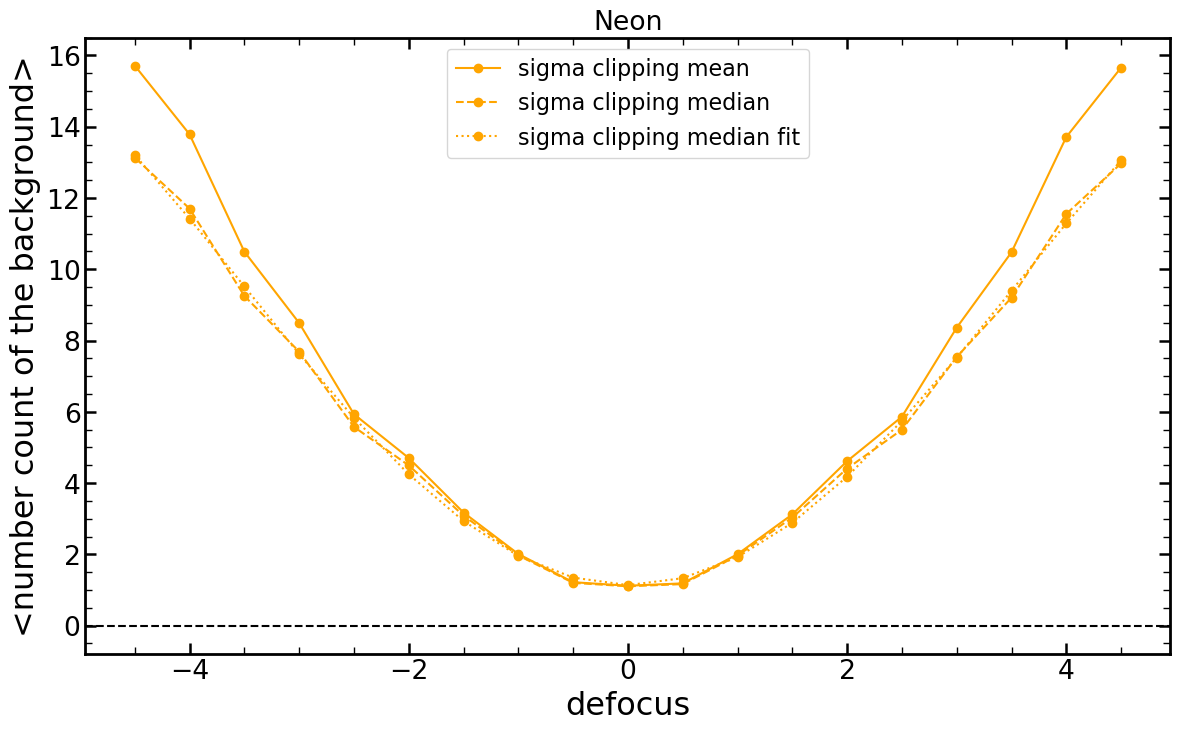

In [711]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,8))
plt.plot(background_estimate_sigma_clip[:,0],background_estimate_sigma_clip[:,1],marker='o',ls='-',color='orange',label='sigma clipping mean')
plt.plot(background_estimate_sigma_clip[:,0],background_estimate_sigma_clip[:,2],marker='o',ls='--',color='orange',label='sigma clipping median')
plt.plot(background_estimate_sigma_clip[:,0],background_estimate_sigma_clip_fit,marker='o',ls=':',color='orange',label='sigma clipping median fit')

#plt.plot(background_estimate_direct[:,0],background_estimate_direct[:,1],marker='o',ls='',color='blue',label='direct estimate')
#plt.plot(background_estimate_direct_narrow[:,0],background_estimate_direct_narrow[:,1],marker='o',ls='',color='red',label='direct estimate, smaller area & further from the traces')
plt.axhline(y=0,ls='--',color='black')
plt.title('Neon')
plt.xlabel('defocus')
plt.ylabel('<number count of the background>')
plt.legend()

In [ ]:
array_of_background_with_exposure_times_positive_focus=array_of_background_with_exposure_times[array_of_background_with_exposure_times[:,2]>0]
array_of_background_with_exposure_times_negative_focus=array_of_background_with_exposure_times[array_of_background_with_exposure_times[:,2]<0]

## actual cut - Neon

# Cut data - defocus

In [296]:
with open('/Users/nevencaplar/Documents/PFS/Data_Feb_5/Dataframes/finalHgAr_Feb2019.pkl', 'rb') as f:
    finalHgAr_Feb2019=pickle.load(f)
#with open('/Users/nevencaplar/Documents/PFS/Data_Feb_5/Dataframes/finalHgAr_expanded.pkl', 'rb') as f:
#    finalHgAr=pickle.load(f)

background_estimate_sigma_clip=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/background_estimate_sigma_clip.npy' )
background_estimate_direct=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/background_estimate_direct.npy' )
background_estimate_direct_narrow=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/background_estimate_direct_narrow.npy' )

z=np.array([ 0.00555972,  0.71860376, -0.14291048,  0.34416228])
background_estimate_sigma_clip_fit_function=np.poly1d(z)

defocus_values=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0.5,+1,1.5,2,2.5,3,3.5,4,4.5,5]
sizes_of_stamps=np.array([70, 60, 60, 50, 40, 30, 30, 24, 20, 20, 20, 24, 30, 30, 40, 50, 60,
       60, 70, 70])

In [408]:
int(finalHgAr_Feb2019.loc[125]['old_index_approx'])

77

## Testing 

In [440]:
image_index=102
run=11748
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB14/Feb2019/rerun/Feb13_2019/Feb13/calExp/2019-02-02/'

data=fits.open(DATA_FOLDER+'/v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    exposure_defocus=data[0].header['W_ENFCAX']
    background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    scidata_single=data[1].data-background
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

In [448]:
center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

Central position of the spot 102 is: [2133, 1955]


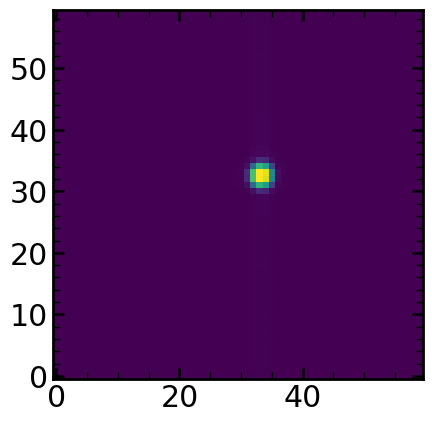

In [442]:
# just to test
scidata_cut=scidata[1924:1984,1492:1552]
plt.imshow(scidata_cut)

In [443]:
# testing centering algorithm
center_pos_new=centering_algorithm(scidata,1525,1957,60)

0:[1927, 1987, 1495, 1555]
1:[1927, 1987, 1495, 1555]
2:[1927, 1987, 1495, 1555]
3:[1927, 1987, 1495, 1555]


In [444]:
finalHgAr_Feb2019[finalHgAr_Feb2019['fiber']=='8']

fiber    xc    yc wavelength close  lamp  xc_effective old_index_approx  \
96      8  2137   762   690.9346     0  HgAr          2206               60   
97      8  2136   828   696.7261     1  HgAr          2205               61   
98      8  2136   944   706.8989     0  HgAr          2205               62   
99      8  2135  1179  727.47876     1  HgAr          2204               63   
100     8  2135  1307   738.6248     0  HgAr          2204               64   
101     8  2134  1595  763.74286   0.5  HgAr          2203               65   
102     8  2133  1955   795.0522     1  HgAr          2202               66   
103     8  2131  2322   826.6699   0.5  HgAr          2200               67   
104     8  2131  2621   852.4029   0.5  HgAr          2200               68   
105     8  2128  3328   912.5693     1  HgAr          2197               69   
106     8  2128  3449   922.7301     0  HgAr          2197               70   
107     8  2126  3968   966.0642     1  HgAr          2195               71   

    superold_index_approx  
96                    nan  
97                   95.0  
98                    nan  
99                    nan  
100                  85.0  
101                  75.0  
102                  55.0  
103                  45.0  
104                  35.0  
105                  25.0  
106                  15.0  
107                   5.0

In [601]:
run=11748
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB14/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-02/'
#DATA_FLATS_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB12/Feb2019/rerun/Feb12_2019/arc/calExp/2019-02-02/'

data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
#dataFlats=fits.open(DATA_FLATS_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  
#maskdata_flats=np.zeros_like(scidata)

list_of_sci_data=[]
list_of_var_data=[]
list_of_mask_data=[]
#list_of_mask_data_flats=[]
for run_i in range(6):
    data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
    #data_flats=fits.open(DATA_FLATS_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
    background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    if run_i==0:
        print('background estimate is: '+str(background))

    scidata_single=data[1].data-background
    maskdata_single=data[2].data
    #maskdata_flats_single=data_flats[2].data
    print(np.sum(maskdata_single))
    vardata_single=data[3].data
    
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single
    #maskdata_flats=maskdata_flats+maskdata_flats_single
    
    list_of_sci_data.append(scidata_single)
    list_of_var_data.append(vardata_single)
    maskdata_single[np.isin(maskdata_single,[0,512])]=0
    maskdata_single[~np.isin(maskdata_single,[0,512])]=1
    list_of_mask_data.append(maskdata_single)
    
maskdata[np.isin(maskdata,[0,3072])]=0
maskdata[~np.isin(maskdata,[0,3072])]=1

#maskdata_flats[np.isin(maskdata_flats,[0,3072])]=0
#maskdata_flats[~np.isin(maskdata_flats,[0,3072])]=1

background estimate is: 0.34416228
21525
13309
15077
16349
27093
7709


In [870]:
image_index=2

# central position as deduced from focused images
center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))

#size=sizes_of_stamps[defocus_values==exposure_defocus]
# have to set manually if in focus
if run==11748:
    size=20
else:
    size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

#xposmin=int(np.round(center_pos_new[0]-size-10))
#xposmax=int(np.round(center_pos_new[0]+size+10))
#yposmin=int(np.round(center_pos_new[1]-size-45))
#yposmax=int(np.round(center_pos_new[1]+size+45))

xposmin=int(np.round(center_pos_new[0]-70-10))
xposmax=int(np.round(center_pos_new[0]+70+10))
yposmin=int(np.round(center_pos_new[1]-70-45))
yposmax=int(np.round(center_pos_new[1]+70+45))

size_of_stamp
#print(xposmin,xposmax,yposmin,yposmax)


scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

scidata_cut_original=np.copy(scidata_cut)

#################
# removal of continuum - estimating
#################

# estimating local background
sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
sci_lower_cut=scidata_cut[5:70]

overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
print('overall_median is: '+str(overall_median))

scidata_cut_median_subtracted=scidata_cut-overall_median
scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

if finalHgAr_Feb2019.loc[image_index]['wavelength']=='690.9346':
    init_lower_limit=40
    init_upper_limit=65
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='696.7261':
    init_lower_limit=50
    init_upper_limit=65
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='706.8989':
    init_lower_limit=20
    init_upper_limit=60    
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='727.47876':
    init_lower_limit=20
    init_upper_limit=60
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='738.6248':
    init_lower_limit=20
    init_upper_limit=55  
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='763.74286':
    init_lower_limit=0
    init_upper_limit=30   
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='795.0522':
    init_lower_limit=30
    init_upper_limit=70
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))  
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='826.6699':
    init_lower_limit=0
    init_upper_limit=30     
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='852.4029':
    init_lower_limit=30
    init_upper_limit=55
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='912.5693':
    init_lower_limit=30
    init_upper_limit=50   
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='922.7301':
    init_lower_limit=30
    init_upper_limit=55
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='966.0642':
    init_lower_limit=35
    init_upper_limit=65      
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
    
    
# estimating continuum
sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
midpoint=scidata_cut_median_subtracted.shape[0]/2
sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
fiber_profile=np.ma.mean(sci_central_cut_masked,axis=0)

res=[]
#res_upper=[]
res_upper_all_values=[]
#res_lower=[]
res_lower_all_values=[]
for j in range(scidata_cut.shape[1]):
    value=np.median(sci_lower_cut[:,j])     
    res_lower_all_values.append(value)
    value=np.median(sci_upper_cut[:,j])     
    res_upper_all_values.append(value)


res_upper_all_values=np.array(res_upper_all_values)
res_lower_all_values=np.array(res_lower_all_values)

# esnures that you do not oversubtract in the middle
#res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
#res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

res_upper=(fiber_profile/res_upper_multi)*0.995
res_lower=(fiber_profile/res_lower_multi)*0.995

if float(finalHgAr_Feb2019.loc[image_index]['wavelength'])<950:
    # if there is another source in upper part, override it with lower half
    print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
    print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
    if res_upper_multi/res_lower_multi<1/1.05:
        print('overwritting upper with lower')
        res_upper=res_lower

    # if there is another source in lower part, override it with upper half
    elif res_lower_multi/res_upper_multi<1/1.05:
        print('overwritting lower with upper')
        res_lower=res_upper

#################
# removal of continuum - actual removal
#################
scidata_cut_large_removed=scidata_cut_median_subtracted
maskdata_cut_large_removed=maskdata_cut
vardata_cut_large_removed=vardata_cut
for j in range(scidata_cut_large_removed.shape[1]):    
    scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
    scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

############################ 
# cutting final image
# allow for 5 pixels change, to capture wings of the donut
#################
y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

y_lower_limit_for_final_cut=int(y_pos_for_final_cut-size_of_stamp/2)
y_upper_limit_for_final_cut=int(y_pos_for_final_cut+size_of_stamp/2)
x_lower_limit_for_final_cut=int(x_pos_for_final_cut-size_of_stamp/2)
x_upper_limit_for_final_cut=int(x_pos_for_final_cut+size_of_stamp/2)

print([y_lower_limit_for_final_cut,y_upper_limit_for_final_cut,x_lower_limit_for_final_cut,x_upper_limit_for_final_cut])

scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
maskdata_final_cut=maskdata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
vardata_final_cut=vardata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]

############################ 
#select only exposures that have no cosmics inside
#################
#scidata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata=np.zeros_like(scidata)  
#for run_i in range(6):
#    if np.sum(list_of_mask_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut])==0:
#        scidata_final_cut_no_CR+=list_of_sci_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
#        vardata_final_cut_no_CR+=list_of_var_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

print(scidata_final_cut.shape)

Central position of the spot 2 is: [274, 972]
0:[942, 1002, 244, 304]
1:[942, 1002, 244, 304]
2:[930, 990, 228, 288]
3:[923, 983, 220, 280]
overall_median is: 79.52607727050781
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.3706399489179174
sum_lower over sum_upper: 2.6980362017626485
overwritting lower with upper
[4, 64, 44, 104]
(60, 60)


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


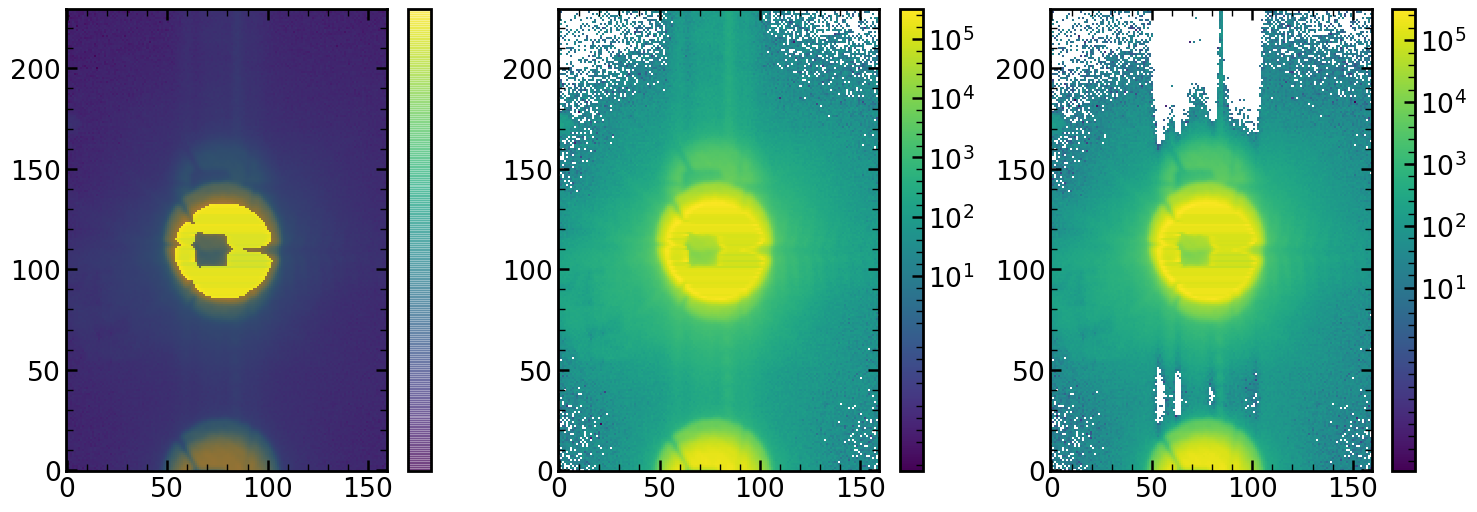

In [871]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(scidata_cut_original,norm=LogNorm(),origin='lower')
plt.imshow(maskdata_cut,origin='lower',alpha=.5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(132)
plt.imshow(scidata_cut_original_median_subtracted,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(133)
plt.imshow(scidata_cut_large_removed,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


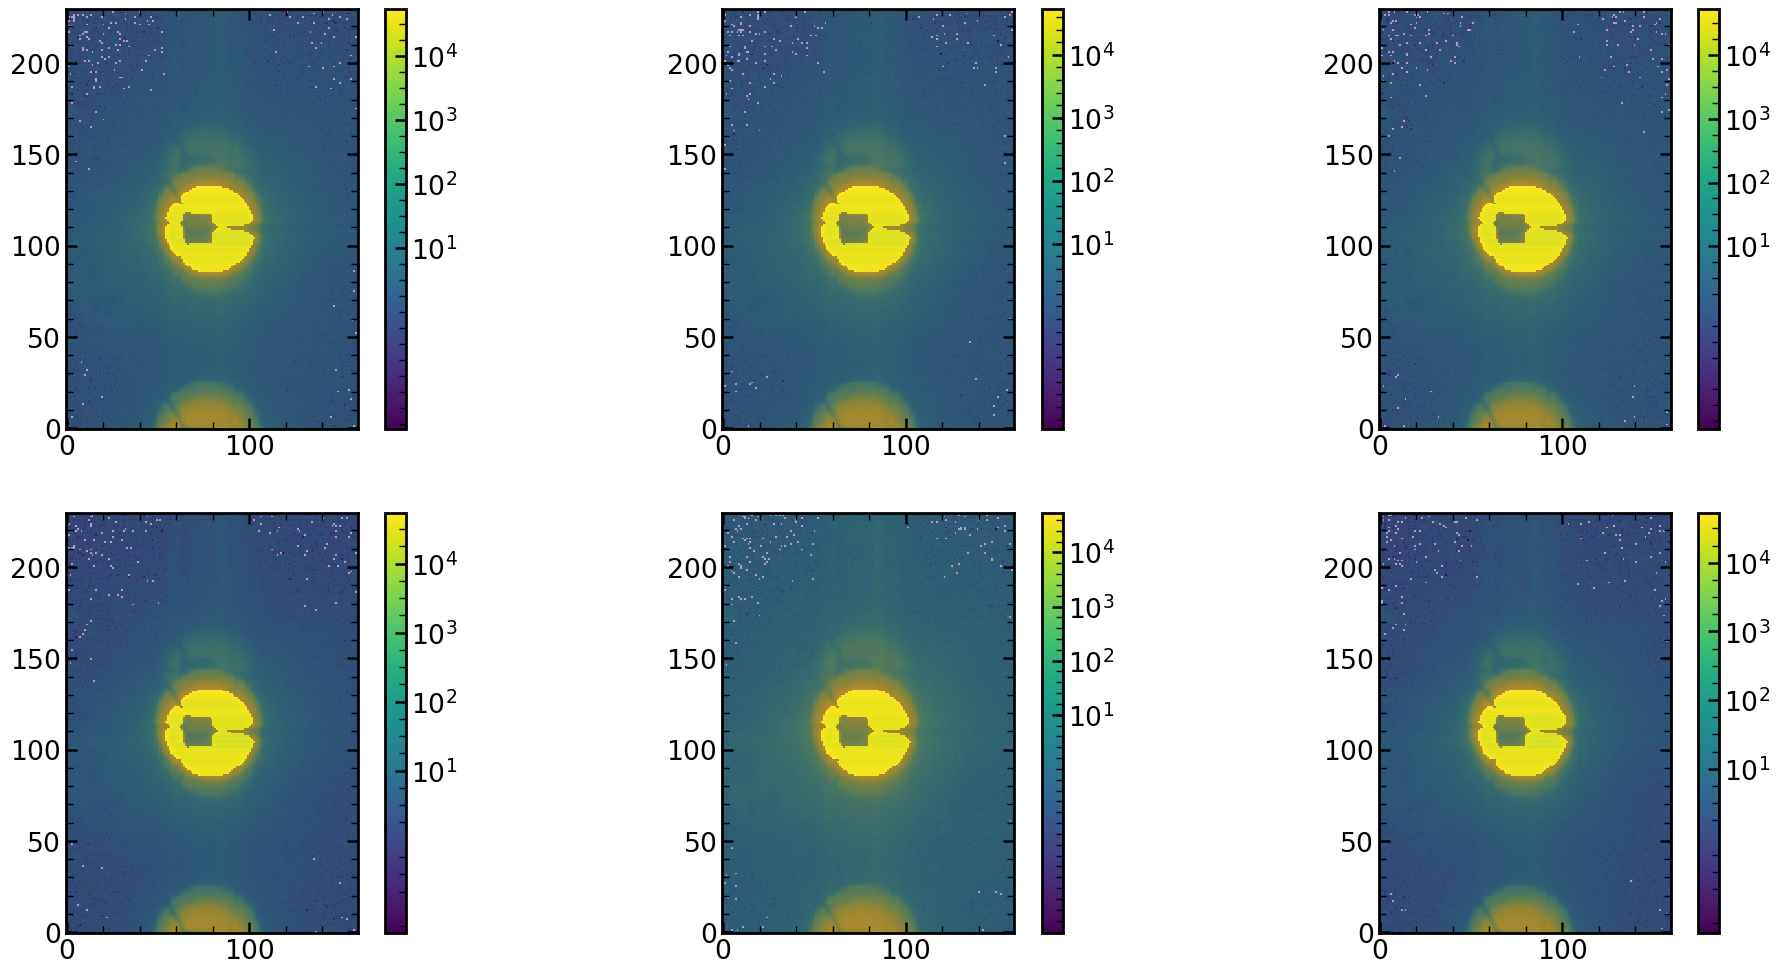

In [872]:
plt.figure(figsize=(24,12))
plt.subplot(231)
plt.imshow(list_of_sci_data[0][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[0][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(232)

plt.imshow(list_of_sci_data[1][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[1][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(233)
plt.imshow(list_of_sci_data[2][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[2][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(234)
plt.imshow(list_of_sci_data[3][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[3][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(235)
plt.imshow(list_of_sci_data[4][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[4][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(236)
plt.imshow(list_of_sci_data[5][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[5][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)

cbar.set_ticks([10,10**2,10**3,10**4,10**5])

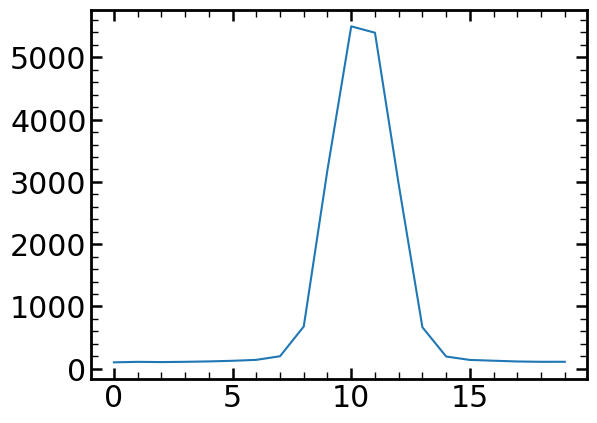

In [607]:
plt.plot(np.mean(vardata_final_cut,axis=0))

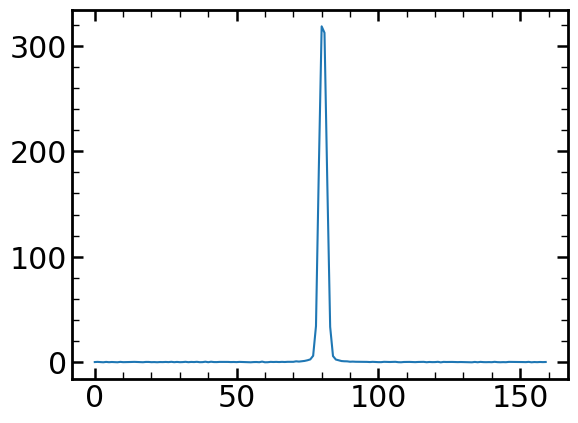

In [608]:
plt.plot(res_lower)

## Testing focus cut 

In [611]:
image_index=102
run=11748
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB14/Feb2019/rerun/Feb13_2019/Feb13/calExp/2019-02-02/'

data=fits.open(DATA_FOLDER+'/v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    exposure_defocus=data[0].header['W_ENFCAX']
    background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    scidata_single=data[1].data-background
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

In [612]:
center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

Central position of the spot 102 is: [2133, 1955]


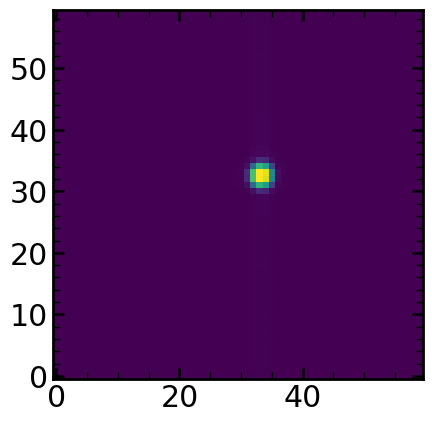

In [613]:
# just to test
scidata_cut=scidata[1924:1984,1492:1552]
plt.imshow(scidata_cut)

In [614]:
# testing centering algorithm
center_pos_new=centering_algorithm(scidata,1525,1957,60)

0:[1927, 1987, 1495, 1555]
1:[1927, 1987, 1495, 1555]
2:[1927, 1987, 1495, 1555]
3:[1927, 1987, 1495, 1555]


In [615]:
finalHgAr_Feb2019[finalHgAr_Feb2019['fiber']=='8']

fiber    xc    yc wavelength close  lamp  xc_effective old_index_approx  \
96      8  2137   762   690.9346     0  HgAr          2206               60   
97      8  2136   828   696.7261     1  HgAr          2205               61   
98      8  2136   944   706.8989     0  HgAr          2205               62   
99      8  2135  1179  727.47876     1  HgAr          2204               63   
100     8  2135  1307   738.6248     0  HgAr          2204               64   
101     8  2134  1595  763.74286   0.5  HgAr          2203               65   
102     8  2133  1955   795.0522     1  HgAr          2202               66   
103     8  2131  2322   826.6699   0.5  HgAr          2200               67   
104     8  2131  2621   852.4029   0.5  HgAr          2200               68   
105     8  2128  3328   912.5693     1  HgAr          2197               69   
106     8  2128  3449   922.7301     0  HgAr          2197               70   
107     8  2126  3968   966.0642     1  HgAr          2195               71   

    superold_index_approx  
96                    nan  
97                   95.0  
98                    nan  
99                    nan  
100                  85.0  
101                  75.0  
102                  55.0  
103                  45.0  
104                  35.0  
105                  25.0  
106                  15.0  
107                   5.0

In [616]:
run=11748
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB14/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-02/'
#DATA_FLATS_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB12/Feb2019/rerun/Feb12_2019/arc/calExp/2019-02-02/'

data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
#dataFlats=fits.open(DATA_FLATS_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  
#maskdata_flats=np.zeros_like(scidata)

list_of_sci_data=[]
list_of_var_data=[]
list_of_mask_data=[]
#list_of_mask_data_flats=[]
for run_i in range(6):
    data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
    #data_flats=fits.open(DATA_FLATS_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
    background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    if run_i==0:
        print('background estimate is: '+str(background))

    scidata_single=data[1].data-background
    maskdata_single=data[2].data
    #maskdata_flats_single=data_flats[2].data
    print(np.sum(maskdata_single))
    vardata_single=data[3].data
    
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single
    #maskdata_flats=maskdata_flats+maskdata_flats_single
    
    list_of_sci_data.append(scidata_single)
    list_of_var_data.append(vardata_single)
    maskdata_single[np.isin(maskdata_single,[0,512])]=0
    maskdata_single[~np.isin(maskdata_single,[0,512])]=1
    list_of_mask_data.append(maskdata_single)
    
maskdata[np.isin(maskdata,[0,3072])]=0
maskdata[~np.isin(maskdata,[0,3072])]=1

#maskdata_flats[np.isin(maskdata_flats,[0,3072])]=0
#maskdata_flats[~np.isin(maskdata_flats,[0,3072])]=1

background estimate is: 0.34416228
21525
13309
15077
16349
27093
7709


In [636]:
image_index=107

# central position as deduced from focused images
center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))

#size=sizes_of_stamps[defocus_values==exposure_defocus]
# have to set manually if in focus
if run==11748:
    size=20
else:
    size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

#xposmin=int(np.round(center_pos_new[0]-size-10))
#xposmax=int(np.round(center_pos_new[0]+size+10))
#yposmin=int(np.round(center_pos_new[1]-size-45))
#yposmax=int(np.round(center_pos_new[1]+size+45))

xposmin=int(np.round(center_pos_new[0]-70-10))
xposmax=int(np.round(center_pos_new[0]+70+10))
yposmin=int(np.round(center_pos_new[1]-70-45))
yposmax=int(np.round(center_pos_new[1]+70+45))

size_of_stamp
#print(xposmin,xposmax,yposmin,yposmax)


scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

scidata_cut_original=np.copy(scidata_cut)

#################
# removal of continuum - estimating
#################

# estimating local background
sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
sci_lower_cut=scidata_cut[5:70]

overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
print('overall_median is: '+str(overall_median))

scidata_cut_median_subtracted=scidata_cut-overall_median
scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

if finalHgAr_Feb2019.loc[image_index]['wavelength']=='690.9346':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='696.7261':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='706.8989':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='727.47876':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='738.6248':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='763.74286':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='795.0522':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='826.6699':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='852.4029':
    init_lower_limit=30
    init_upper_limit=55
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='912.5693':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='922.7301':
    lower_limit=int(60)
    upper_limit=int(95) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalHgAr_Feb2019.loc[image_index]['wavelength']=='966.0642':
    lower_limit=int(60)
    upper_limit=int(100) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
    
    
# estimating continuum
sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
midpoint=scidata_cut_median_subtracted.shape[0]/2
sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
fiber_profile=np.ma.mean(sci_central_cut_masked,axis=0)

res=[]
#res_upper=[]
res_upper_all_values=[]
#res_lower=[]
res_lower_all_values=[]
for j in range(scidata_cut.shape[1]):
    value=np.median(sci_lower_cut[:,j])     
    res_lower_all_values.append(value)
    value=np.median(sci_upper_cut[:,j])     
    res_upper_all_values.append(value)


res_upper_all_values=np.array(res_upper_all_values)
res_lower_all_values=np.array(res_lower_all_values)

# esnures that you do not oversubtract in the middle
#res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
#res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

res_upper=(fiber_profile/res_upper_multi)*0.995
res_lower=(fiber_profile/res_lower_multi)*0.995

'''
if float(finalHgAr_Feb2019.loc[image_index]['wavelength'])<950:
    # if there is another source in upper part, override it with lower half
    print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
    print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
    if res_upper_multi/res_lower_multi<1/1.2:
        print('overwritting upper with lower')
        res_upper=res_lower

    # if there is another source in lower part, override it with upper half
    elif res_lower_multi/res_upper_multi<1/1.2:
        print('overwritting lower with upper')
        res_lower=res_upper
'''
#################
# removal of continuum - actual removal
#################
scidata_cut_large_removed=scidata_cut_median_subtracted
maskdata_cut_large_removed=maskdata_cut
vardata_cut_large_removed=vardata_cut
for j in range(scidata_cut_large_removed.shape[1]):    
    scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
    scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

############################ 
# cutting final image
# allow for 5 pixels change, to capture wings of the donut
#################
y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

y_lower_limit_for_final_cut=int(y_pos_for_final_cut-size_of_stamp/2)
y_upper_limit_for_final_cut=int(y_pos_for_final_cut+size_of_stamp/2)
x_lower_limit_for_final_cut=int(x_pos_for_final_cut-size_of_stamp/2)
x_upper_limit_for_final_cut=int(x_pos_for_final_cut+size_of_stamp/2)

print([y_lower_limit_for_final_cut,y_upper_limit_for_final_cut,x_lower_limit_for_final_cut,x_upper_limit_for_final_cut])

scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
maskdata_final_cut=maskdata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
vardata_final_cut=vardata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]

############################ 
#select only exposures that have no cosmics inside
#################
#scidata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata=np.zeros_like(scidata)  
#for run_i in range(6):
#    if np.sum(list_of_mask_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut])==0:
#        scidata_final_cut_no_CR+=list_of_sci_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
#        vardata_final_cut_no_CR+=list_of_var_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

print(scidata_final_cut.shape)

Central position of the spot 107 is: [2126, 3968]
0:[3958, 3978, 2116, 2136]
1:[3958, 3978, 2116, 2136]
2:[3958, 3978, 2116, 2136]
3:[3958, 3978, 2116, 2136]
overall_median is: -0.6911301016807556
lower_limit: 60
upper_limit: 100
[5, 25, 70, 90]
(20, 20)


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


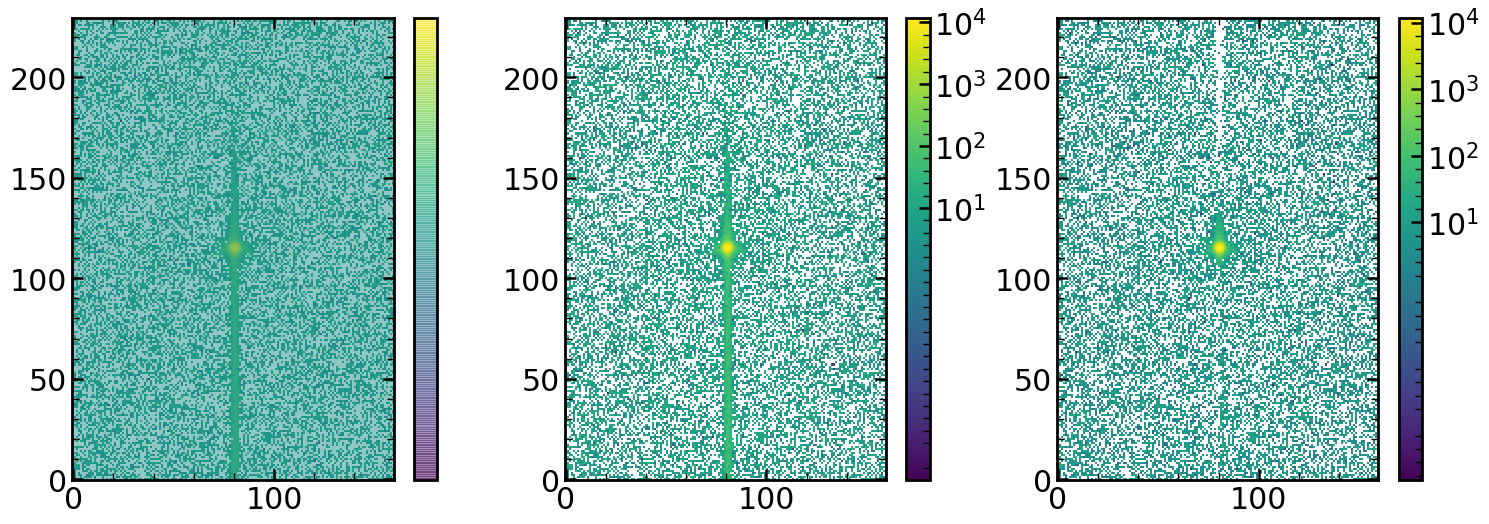

In [637]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(scidata_cut_original,norm=LogNorm(),origin='lower')
plt.imshow(maskdata_cut,origin='lower',alpha=.5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(132)
plt.imshow(scidata_cut_original_median_subtracted,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(133)
plt.imshow(scidata_cut_large_removed,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


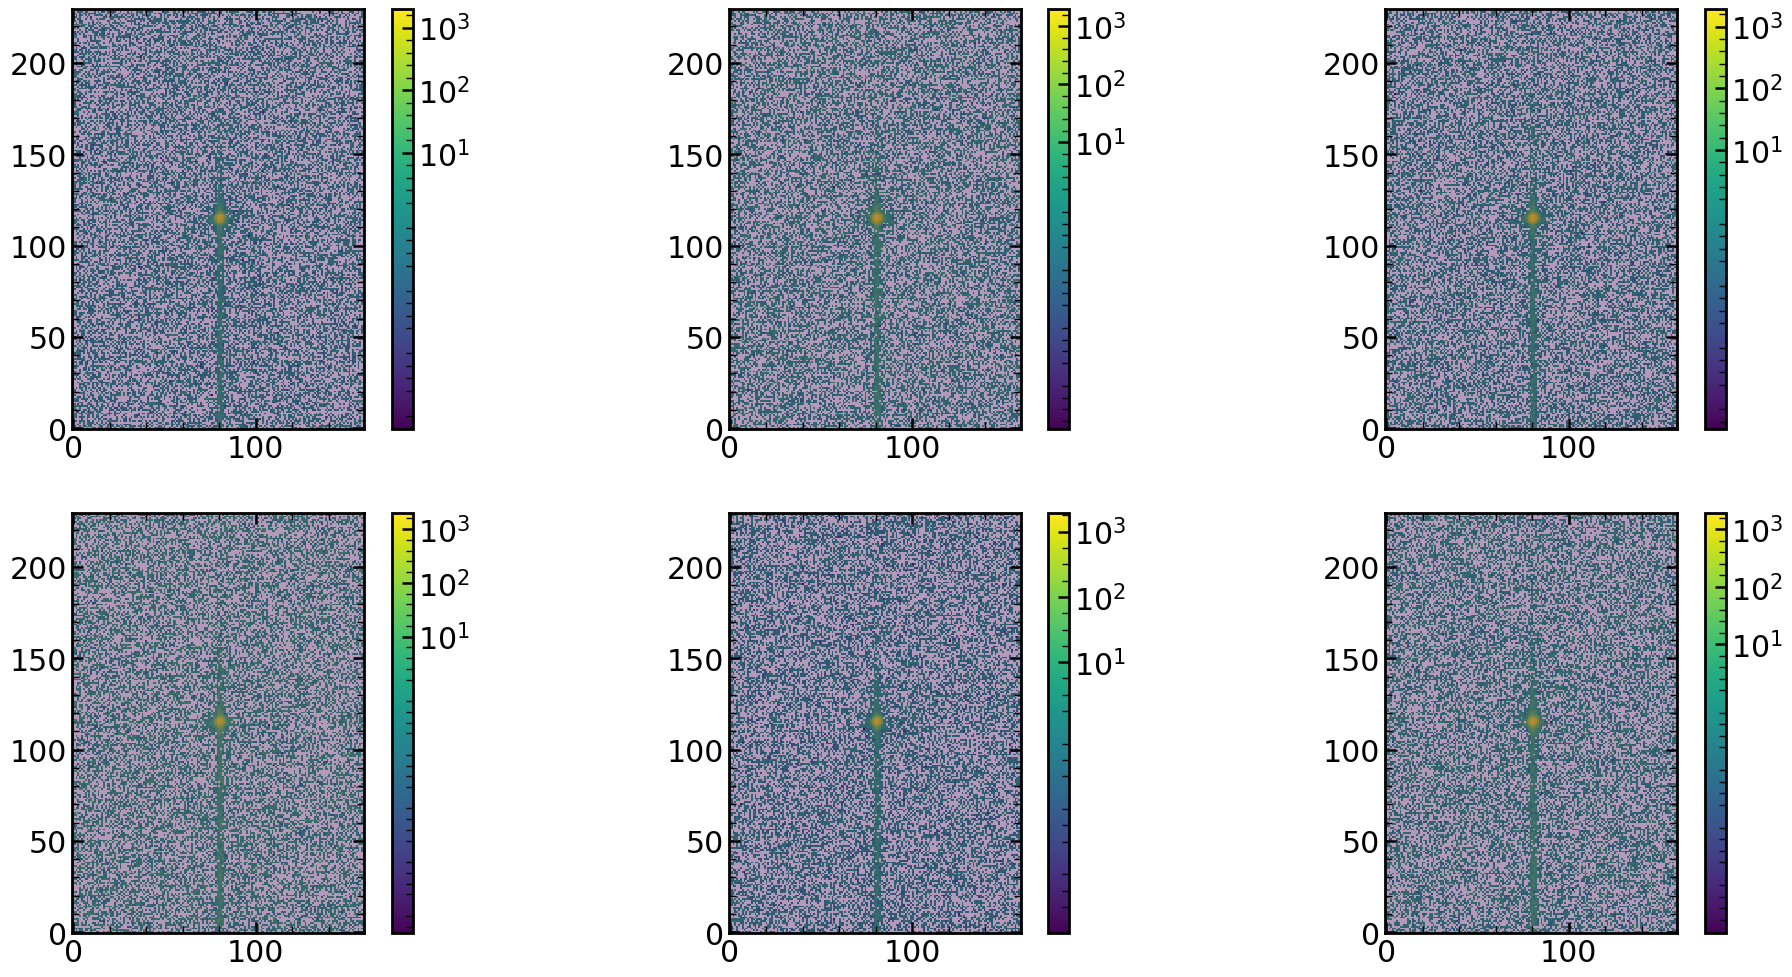

In [638]:
plt.figure(figsize=(24,12))
plt.subplot(231)
plt.imshow(list_of_sci_data[0][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[0][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(232)

plt.imshow(list_of_sci_data[1][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[1][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(233)
plt.imshow(list_of_sci_data[2][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[2][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(234)
plt.imshow(list_of_sci_data[3][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[3][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(235)
plt.imshow(list_of_sci_data[4][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[4][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(236)
plt.imshow(list_of_sci_data[5][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[5][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)

cbar.set_ticks([10,10**2,10**3,10**4,10**5])

## actual cut 

In [495]:
defocus_values=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0.5,+1,1.5,2,2.5,3,3.5,4,4.5,5]
sizes_of_stamps=np.array([70, 60, 60, 50, 40, 30, 30, 24, 20, 20, 20, 24, 30, 30, 40, 50, 60,
       60, 70, 70])

In [498]:
sizes_of_stamps[defocus_values==exposure_defocus[3]][0]

60

In [609]:
for run in tqdm(list(range(11694,11802+6,6))):
    try:

        DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB14/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-02/'
        data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
        scidata=np.zeros_like(data[1].data)
        maskdata=np.zeros_like(scidata)
        vardata=np.zeros_like(scidata)  


        list_of_sci_data=[]
        list_of_var_data=[]
        list_of_mask_data=[]
        for run_i in range(6):
            data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
            exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
            background=background_estimate_sigma_clip_fit_function(exposure_defocus)
            if run_i==0:
                print('background estimate is: '+str(background))

            scidata_single=data[1].data-background
            maskdata_single=data[2].data
            print(np.sum(maskdata_single))
            vardata_single=data[3].data

            scidata=scidata+scidata_single
            maskdata=maskdata+maskdata_single
            vardata=vardata+vardata_single

            list_of_sci_data.append(scidata_single)
            list_of_var_data.append(vardata_single)
            maskdata_single[np.isin(maskdata_single,[0,512])]=0
            maskdata_single[~np.isin(maskdata_single,[0,512])]=1
            list_of_mask_data.append(maskdata_single)

        maskdata[np.isin(maskdata,[0,3072])]=0
        maskdata[~np.isin(maskdata,[0,3072])]=1


        for image_index in range(len(finalHgAr_Feb2019)):


            # central position as deduced from focused images
            center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
            print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
            size=sizes_of_stamps[defocus_values==exposure_defocus]
            size_of_stamp=size

            center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

            xposmin=int(np.round(center_pos_new[0]-70-10))
            xposmax=int(np.round(center_pos_new[0]+70+10))
            yposmin=int(np.round(center_pos_new[1]-70-45))
            yposmax=int(np.round(center_pos_new[1]+70+45))
            #print(xposmin,xposmax,yposmin,yposmax)


            scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
            maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
            vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

            scidata_cut_original=np.copy(scidata_cut)

            #################
            # removal of continuum - estimating
            #################

            # estimating local background
            sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
            sci_lower_cut=scidata_cut[5:70]

            overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
            overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
            print('overall_median is: '+str(overall_median))

            scidata_cut_median_subtracted=scidata_cut-overall_median
            scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='690.9346':
                init_lower_limit=40
                init_upper_limit=65
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='696.7261':
                init_lower_limit=50
                init_upper_limit=65
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='706.8989':
                init_lower_limit=20
                init_upper_limit=60    
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='727.47876':
                init_lower_limit=20
                init_upper_limit=60
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='738.6248':
                init_lower_limit=20
                init_upper_limit=55  
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='763.74286':
                init_lower_limit=0
                init_upper_limit=30   
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='795.0522':
                init_lower_limit=30
                init_upper_limit=70
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))  
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='826.6699':
                init_lower_limit=0
                init_upper_limit=30     
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='852.4029':
                init_lower_limit=30
                init_upper_limit=55
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='912.5693':
                init_lower_limit=30
                init_upper_limit=50   
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2]))
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='922.7301':
                init_lower_limit=30
                init_upper_limit=55
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='966.0642':
                init_lower_limit=35
                init_upper_limit=65      
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
      


            # estimating continuum
            sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
            sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
            midpoint=scidata_cut_median_subtracted.shape[0]/2
            sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
            mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
            sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
            fiber_profile=np.mean(sci_central_cut_masked,axis=0)

            res=[]
            #res_upper=[]
            res_upper_all_values=[]
            #res_lower=[]
            res_lower_all_values=[]
            for j in range(scidata_cut.shape[1]):
                value=np.median(sci_lower_cut[:,j])     
                res_lower_all_values.append(value)
                value=np.median(sci_upper_cut[:,j])     
                res_upper_all_values.append(value)


            res_upper_all_values=np.array(res_upper_all_values)
            res_lower_all_values=np.array(res_lower_all_values)

            # esnures that you do not oversubtract in the middle
            #res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
            #res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

            res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
            res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

            res_upper=(fiber_profile/res_upper_multi)*0.995
            res_lower=(fiber_profile/res_lower_multi)*0.995

            if float(finalHgAr_Feb2019.loc[image_index]['wavelength'])<950:
                # if there is another source in upper part, override it with lower half
                print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
                print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
                if res_upper_multi/res_lower_multi<1/1.2:
                    print('overwritting upper with lower')
                    res_upper=res_lower

                # if there is another source in lower part, override it with upper half
                elif res_lower_multi/res_upper_multi<1/1.2:
                    print('overwritting lower with upper')
                    res_lower=res_upper

            #################
            # removal of continuum - actual removal
            #################
            scidata_cut_large_removed=scidata_cut_median_subtracted
            maskdata_cut_large_removed=maskdata_cut
            vardata_cut_large_removed=vardata_cut
            for j in range(scidata_cut_large_removed.shape[1]):    
                scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
                scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            ############################ 
            # cutting final image
            # allow for 5 pixels change, to capture wings of the donut
            #################
            y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
            y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

            scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
            vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

            # use mask to make sure that CR do not mess with this median
            y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
            x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

            y_lower_limit_for_final_cut=int(np.round(y_pos_for_final_cut-size_of_stamp/2))
            y_upper_limit_for_final_cut=int(np.round(y_pos_for_final_cut+size_of_stamp/2))
            x_lower_limit_for_final_cut=int(np.round(x_pos_for_final_cut-size_of_stamp/2))
            x_upper_limit_for_final_cut=int(np.round(x_pos_for_final_cut+size_of_stamp/2))

            scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            maskdata_final_cut=maskdata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            vardata_final_cut=vardata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]


            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy',scidata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked.npy',maskdata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked.npy',vardata_final_cut)

            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',scidata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',maskdata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',vardata_cut_large_removed)
    except TypeError:
        pass

  0%|          | 0/19 [00:00<?, ?it/s]

background estimate is: 0.453052945
17077
14693
11285
8597
9693
11149
Central position of the spot 0 is: [273, 789]
0:[779, 799, 263, 283]
1:[779, 799, 265, 285]
2:[779, 799, 265, 285]
3:[779, 799, 265, 285]
overall_median is: 0.4000293016433716
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9130958034539749
sum_lower over sum_upper: 1.0951753323334659
Central position of the spot 1 is: [274, 855]
0:[845, 865, 264, 284]
1:[845, 865, 265, 285]
2:[845, 865, 265, 285]
3:[845, 865, 265, 285]
overall_median is: 0.19009673595428467
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.9349051241668361
sum_lower over sum_upper: 1.0696272532372468


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Central position of the spot 2 is: [274, 972]
0:[962, 982, 264, 284]
1:[962, 982, 265, 285]
2:[962, 982, 265, 285]
3:[962, 982, 265, 285]
overall_median is: 0.054927825927734375
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9236666755431091
sum_lower over sum_upper: 1.0826416352111086
Central position of the spot 3 is: [274, 1208]
0:[1198, 1218, 264, 284]
1:[1198, 1218, 266, 286]
2:[1198, 1218, 266, 286]
3:[1198, 1218, 266, 286]
overall_median is: -0.11287260055541992
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.983785298152664
sum_lower over sum_upper: 1.0164819517813326
Central position of the spot 4 is: [274, 1335]
0:[1325, 1345, 264, 284]
1:[1325, 1345, 266, 286]
2:[1325, 1345, 266, 286]
3:[1325, 1345, 266, 286]
overall_median is: -0.07955098152160645
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9522090920066988
sum_lower over sum_upper: 1.050189510260384
Central position of the spot 5 is: [274, 1625]
0:[1615, 1635, 264, 284]
1:[1615, 1635, 

Central position of the spot 31 is: [865, 2334]
0:[2324, 2344, 855, 875]
1:[2324, 2344, 856, 876]
2:[2325, 2345, 856, 876]
3:[2325, 2345, 856, 876]
overall_median is: 0.023921877145767212
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.7889376734493023
sum_lower over sum_upper: 1.2675272504454191
overwritting lower with upper
Central position of the spot 32 is: [864, 2634]
0:[2624, 2644, 854, 874]
1:[2624, 2644, 855, 875]
2:[2624, 2644, 855, 875]
3:[2624, 2644, 855, 875]
overall_median is: -0.6021310091018677
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.8709840626406836
sum_lower over sum_upper: 1.148126633876814
Central position of the spot 33 is: [860, 3343]
0:[3333, 3353, 850, 870]
1:[3333, 3353, 850, 870]
2:[3333, 3353, 851, 871]
3:[3333, 3353, 851, 871]
overall_median is: -0.690037190914154
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.7870444333373904
sum_lower over sum_upper: 1.2705762948599875
overwritting lower with upper
Central position 

sum_lower over sum_upper: 0.8823712173615832
sum_lower over sum_upper: 1.1333098590751223
Central position of the spot 59 is: [1232, 3974]
0:[3964, 3984, 1222, 1242]
1:[3965, 3985, 1223, 1243]
2:[3965, 3985, 1223, 1243]
3:[3965, 3985, 1223, 1243]
overall_median is: -2.920356273651123
lower_limit: 10
upper_limit: 90
Central position of the spot 60 is: [1528, 763]
0:[753, 773, 1518, 1538]
1:[753, 773, 1518, 1538]
2:[753, 773, 1518, 1538]
3:[753, 773, 1518, 1538]
overall_median is: 0.13656935095787048
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.8954179471053149
sum_lower over sum_upper: 1.1167969139246934
Central position of the spot 61 is: [1528, 829]
0:[819, 839, 1518, 1538]
1:[819, 839, 1518, 1538]
2:[819, 839, 1518, 1538]
3:[819, 839, 1518, 1538]
overall_median is: -0.5204269886016846
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8657764225188602
sum_lower over sum_upper: 1.1550326088698908
Central position of the spot 62 is: [1528, 945]
0:[935, 955, 1518

overall_median is: -0.021545886993408203
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9367677876577505
sum_lower over sum_upper: 1.0675004127760972
Central position of the spot 88 is: [2007, 1307]
0:[1297, 1317, 1997, 2017]
1:[1297, 1317, 1997, 2017]
2:[1297, 1317, 1997, 2017]
3:[1297, 1317, 1997, 2017]
overall_median is: 0.0631101131439209
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9110032536349497
sum_lower over sum_upper: 1.0976909204329937
Central position of the spot 89 is: [2006, 1595]
0:[1585, 1605, 1996, 2016]
1:[1585, 1605, 1996, 2016]
2:[1585, 1605, 1996, 2016]
3:[1585, 1605, 1996, 2016]
overall_median is: 0.6364861726760864
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.1677079409562001
sum_lower over sum_upper: 0.8563785214829752
Central position of the spot 90 is: [2005, 1955]
0:[1945, 1965, 1995, 2015]
1:[1945, 1965, 1995, 2015]
2:[1946, 1966, 1995, 2015]
3:[1946, 1966, 1995, 2015]
overall_median is: -0.1509838104248047
lower_limi

overall_median is: -0.26974761486053467
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.1211592593843784
sum_lower over sum_upper: 0.8919339439332585
Central position of the spot 115 is: [2248, 2323]
0:[2313, 2333, 2238, 2258]
1:[2313, 2333, 2238, 2258]
2:[2313, 2333, 2238, 2258]
3:[2313, 2333, 2238, 2258]
overall_median is: -0.0996396541595459
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8913858820562262
sum_lower over sum_upper: 1.1218485956870055
Central position of the spot 116 is: [2247, 2622]
0:[2612, 2632, 2237, 2257]
1:[2612, 2632, 2237, 2257]
2:[2612, 2632, 2237, 2257]
3:[2612, 2632, 2237, 2257]
overall_median is: 0.16672396659851074
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9244730734126523
sum_lower over sum_upper: 1.0816972703256174
Central position of the spot 117 is: [2245, 3330]
0:[3320, 3340, 2235, 2255]
1:[3320, 3340, 2235, 2255]
2:[3320, 3340, 2235, 2255]
3:[3320, 3340, 2235, 2255]
overall_median is: -1.4449923038482666
lower_

Central position of the spot 141 is: [2652, 3336]
0:[3326, 3346, 2642, 2662]
1:[3326, 3346, 2642, 2662]
2:[3326, 3346, 2642, 2662]
3:[3326, 3346, 2642, 2662]
overall_median is: -1.3622914552688599
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9160697404752107
sum_lower over sum_upper: 1.0916199453125157
Central position of the spot 142 is: [2652, 3457]
0:[3447, 3467, 2642, 2662]
1:[3447, 3467, 2642, 2662]
2:[3447, 3467, 2642, 2662]
3:[3447, 3467, 2642, 2662]
overall_median is: -0.9611270427703857
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9108444465441248
sum_lower over sum_upper: 1.0978823044858474
Central position of the spot 143 is: [2652, 3976]
0:[3966, 3986, 2642, 2662]
1:[3967, 3987, 2641, 2661]
2:[3967, 3987, 2641, 2661]
3:[3967, 3987, 2641, 2661]
overall_median is: -2.6731932163238525
lower_limit: 10
upper_limit: 90
Central position of the spot 144 is: [2852, 772]
0:[762, 782, 2842, 2862]
1:[762, 782, 2841, 2861]
2:[762, 782, 2841, 2861]
3:[762, 782

overall_median is: -0.005593538284301758
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.9999844604808539
sum_lower over sum_upper: 1.0000155397606265
Central position of the spot 170 is: [3648, 978]
0:[968, 988, 3638, 3658]
1:[969, 989, 3637, 3657]
2:[968, 988, 3637, 3657]
3:[968, 988, 3637, 3657]
overall_median is: 0.21815109252929688
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 1.0987123038083524
sum_lower over sum_upper: 0.9101563680808923
Central position of the spot 171 is: [3647, 1214]
0:[1204, 1224, 3637, 3657]
1:[1205, 1225, 3635, 3655]
2:[1204, 1224, 3636, 3656]
3:[1204, 1224, 3636, 3656]
overall_median is: -0.19167065620422363
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 1.136408361850628
sum_lower over sum_upper: 0.8799653659460156
Central position of the spot 172 is: [3646, 1342]
0:[1332, 1352, 3636, 3656]
1:[1332, 1352, 3634, 3654]
2:[1332, 1352, 3635, 3655]
3:[1332, 1352, 3635, 3655]
overall_median is: -0.36091285943984985
lower_limit:

  5%|▌         | 1/19 [00:27<08:14, 27.50s/it]

overall_median is: -0.2326669692993164
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.8679466206665103
sum_lower over sum_upper: 1.1521445860715303
Central position of the spot 190 is: [3836, 3504]
0:[3494, 3514, 3826, 3846]
1:[3494, 3514, 3824, 3844]
2:[3494, 3514, 3825, 3845]
3:[3494, 3514, 3825, 3845]
overall_median is: -0.171875
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.8139963312610857
sum_lower over sum_upper: 1.228506765442969
overwritting lower with upper
Central position of the spot 191 is: [3840, 4028]
0:[4018, 4038, 3830, 3850]
1:[4018, 4038, 3828, 3848]
2:[4019, 4039, 3829, 3849]
3:[4019, 4039, 3829, 3849]
overall_median is: -2.0594258308410645
lower_limit: 10
upper_limit: 90
background estimate is: 0.92541528
9981
14667
18555
12477
17045
8893
Central position of the spot 0 is: [273, 789]
0:[777, 801, 261, 285]
1:[777, 801, 265, 289]
2:[777, 801, 264, 288]
3:[777, 801, 264, 288]
overall_median is: 0.3762388229370117
lower_limit: 17
upper_limit: 

overall_median is: 0.3710031509399414
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.9090277130815059
sum_lower over sum_upper: 1.1000764724874095
Central position of the spot 25 is: [868, 839]
0:[827, 851, 856, 880]
1:[827, 851, 858, 882]
2:[827, 851, 858, 882]
3:[827, 851, 858, 882]
overall_median is: -0.09370064735412598
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.8800365336035508
sum_lower over sum_upper: 1.1363164616646377
Central position of the spot 26 is: [868, 955]
0:[943, 967, 856, 880]
1:[943, 967, 858, 882]
2:[943, 967, 858, 882]
3:[943, 967, 858, 882]
overall_median is: -0.3750323
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9295148410530554
sum_lower over sum_upper: 1.0758300522314321
Central position of the spot 27 is: [868, 1190]
0:[1178, 1202, 856, 880]
1:[1178, 1202, 858, 882]
2:[1179, 1203, 858, 882]
3:[1179, 1203, 858, 882]
overall_median is: 0.2666454315185547
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9510

Central position of the spot 52 is: [1244, 1311]
0:[1299, 1323, 1232, 1256]
1:[1299, 1323, 1234, 1258]
2:[1299, 1323, 1233, 1257]
3:[1299, 1323, 1233, 1257]
overall_median is: 0.16458630561828613
lower_limit: 0
upper_limit: 78
sum_lower over sum_upper: 0.9091134555105881
sum_lower over sum_upper: 1.0999727195087736
Central position of the spot 53 is: [1243, 1599]
0:[1587, 1611, 1231, 1255]
1:[1587, 1611, 1232, 1256]
2:[1588, 1612, 1232, 1256]
3:[1588, 1612, 1232, 1256]
overall_median is: 0.6152093410491943
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2350225614105865
sum_lower over sum_upper: 0.8097018072753631
overwritting upper with lower
Central position of the spot 54 is: [1242, 1960]
0:[1948, 1972, 1230, 1254]
1:[1948, 1972, 1232, 1256]
2:[1948, 1972, 1231, 1255]
3:[1948, 1972, 1231, 1255]
overall_median is: 0.07214605808258057
lower_limit: 7
upper_limit: 93
sum_lower over sum_upper: 1.0339371856395159
sum_lower over sum_upper: 0.967176743315867
Central position of t

Central position of the spot 79 is: [1629, 2322]
0:[2310, 2334, 1617, 1641]
1:[2310, 2334, 1617, 1641]
2:[2311, 2335, 1617, 1641]
3:[2311, 2335, 1617, 1641]
overall_median is: 0.8410764932632446
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8635691087508596
sum_lower over sum_upper: 1.1579849138495537
Central position of the spot 80 is: [1628, 2622]
0:[2610, 2634, 1616, 1640]
1:[2610, 2634, 1616, 1640]
2:[2610, 2634, 1616, 1640]
3:[2610, 2634, 1616, 1640]
overall_median is: -1.8799253702163696
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.8889761228137678
sum_lower over sum_upper: 1.1248896053977488
Central position of the spot 81 is: [1625, 3329]
0:[3317, 3341, 1613, 1637]
1:[3317, 3341, 1614, 1638]
2:[3318, 3342, 1614, 1638]
3:[3318, 3342, 1614, 1638]
overall_median is: 0.030979633331298828
lower_limit: 7
upper_limit: 73
sum_lower over sum_upper: 0.8993346286937247
sum_lower over sum_upper: 1.1119331649138104
Central position of the spot 82 is: [1625, 3450]


overall_median is: -1.4211543798446655
lower_limit: 7
upper_limit: 73
sum_lower over sum_upper: 0.917828231727514
sum_lower over sum_upper: 1.0895284819446274
Central position of the spot 106 is: [2128, 3449]
0:[3437, 3461, 2116, 2140]
1:[3437, 3461, 2115, 2139]
2:[3438, 3462, 2116, 2140]
3:[3438, 3462, 2116, 2140]
overall_median is: -0.10209226608276367
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9226961420078463
sum_lower over sum_upper: 1.0837804066503796
Central position of the spot 107 is: [2126, 3968]
0:[3956, 3980, 2114, 2138]
1:[3956, 3980, 2114, 2138]
2:[3957, 3981, 2114, 2138]
3:[3957, 3981, 2114, 2138]
overall_median is: -4.220772743225098
lower_limit: 12
upper_limit: 88
Central position of the spot 108 is: [2254, 763]
0:[751, 775, 2242, 2266]
1:[751, 775, 2241, 2265]
2:[751, 775, 2241, 2265]
3:[751, 775, 2241, 2265]
overall_median is: -0.1450428068637848
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.9078938380078262
sum_lower over sum_upper: 1.1

overall_median is: -0.02781999111175537
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.906764517855576
sum_lower over sum_upper: 1.1028221553760378
Central position of the spot 133 is: [2660, 834]
0:[822, 846, 2648, 2672]
1:[822, 846, 2646, 2670]
2:[822, 846, 2647, 2671]
3:[822, 846, 2647, 2671]
overall_median is: 0.03917956352233887
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.8867373622406737
sum_lower over sum_upper: 1.1277296329018165
Central position of the spot 134 is: [2659, 950]
0:[938, 962, 2647, 2671]
1:[938, 962, 2646, 2670]
2:[938, 962, 2647, 2671]
3:[938, 962, 2647, 2671]
overall_median is: 0.24234247207641602
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9688081135299171
sum_lower over sum_upper: 1.0321961449687216
Central position of the spot 135 is: [2659, 1186]
0:[1174, 1198, 2647, 2671]
1:[1174, 1198, 2645, 2669]
2:[1174, 1198, 2646, 2670]
3:[1174, 1198, 2646, 2670]
overall_median is: -0.0038246214389801025
lower_limit: 0
upper

Central position of the spot 160 is: [3349, 1331]
0:[1319, 1343, 3337, 3361]
1:[1319, 1343, 3334, 3358]
2:[1319, 1343, 3335, 3359]
3:[1319, 1343, 3335, 3359]
overall_median is: -0.04319185018539429
lower_limit: 0
upper_limit: 78
sum_lower over sum_upper: 0.9981369501946685
sum_lower over sum_upper: 1.0018665272385399
Central position of the spot 161 is: [3347, 1619]
0:[1607, 1631, 3335, 3359]
1:[1607, 1631, 3333, 3357]
2:[1608, 1632, 3333, 3357]
3:[1608, 1632, 3333, 3357]
overall_median is: 0.0013148784637451172
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2708590877166512
sum_lower over sum_upper: 0.7868692994096591
overwritting upper with lower
Central position of the spot 162 is: [3346, 1981]
0:[1969, 1993, 3334, 3358]
1:[1969, 1993, 3332, 3356]
2:[1970, 1994, 3332, 3356]
3:[1970, 1994, 3332, 3356]
overall_median is: 0.9080686569213867
lower_limit: 7
upper_limit: 93
sum_lower over sum_upper: 1.1273827689293077
sum_lower over sum_upper: 0.8870101863892376
Central positi

overall_median is: -0.38103413581848145
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8458136777106178
sum_lower over sum_upper: 1.182293484194677
Central position of the spot 188 is: [3834, 2671]
0:[2659, 2683, 3822, 3846]
1:[2657, 2681, 3818, 3842]
2:[2659, 2683, 3819, 3843]
3:[2659, 2683, 3819, 3843]
overall_median is: -0.3854990005493164
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.846799854547837
sum_lower over sum_upper: 1.1809165939618242
Central position of the spot 189 is: [3836, 3383]
0:[3371, 3395, 3824, 3848]
1:[3371, 3395, 3822, 3846]
2:[3371, 3395, 3821, 3845]
3:[3371, 3395, 3821, 3845]
overall_median is: -1.0130114555358887
lower_limit: 7
upper_limit: 73
sum_lower over sum_upper: 0.8827343623902559
sum_lower over sum_upper: 1.1328436306616794
Central position of the spot 190 is: [3836, 3504]
0:[3492, 3516, 3824, 3848]
1:[3492, 3516, 3821, 3845]
2:[3493, 3517, 3821, 3845]
3:[3493, 3517, 3821, 3845]
overall_median is: -0.3638796806335449
lower_li

 11%|█         | 2/19 [00:57<08:06, 28.62s/it]

Central position of the spot 191 is: [3840, 4028]
0:[4016, 4040, 3828, 3852]
1:[4016, 4040, 3825, 3849]
2:[4017, 4041, 3826, 3850]
3:[4017, 4041, 3826, 3850]
overall_median is: -2.252997875213623
lower_limit: 12
upper_limit: 88
background estimate is: 1.765419075
15019
23315
35987
21459
22245
33599
Central position of the spot 0 is: [273, 789]
0:[774, 804, 258, 288]
1:[773, 803, 264, 294]
2:[774, 804, 262, 292]
3:[774, 804, 262, 292]
overall_median is: 0.9925146102905273
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9736109997458027
sum_lower over sum_upper: 1.027104254431274
Central position of the spot 1 is: [274, 855]
0:[840, 870, 259, 289]
1:[839, 869, 264, 294]
2:[840, 870, 262, 292]
3:[840, 870, 262, 292]
overall_median is: 1.4308772087097168
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.9393218969348399
sum_lower over sum_upper: 1.064597773418423
Central position of the spot 2 is: [274, 972]
0:[957, 987, 259, 289]
1:[956, 986, 264, 294]
2:[957, 987, 2

overall_median is: 1.3562495708465576
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.937708683518779
sum_lower over sum_upper: 1.0664292840367768
Central position of the spot 27 is: [868, 1190]
0:[1175, 1205, 853, 883]
1:[1174, 1204, 856, 886]
2:[1176, 1206, 856, 886]
3:[1176, 1206, 856, 886]
overall_median is: 0.991870641708374
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9577042781957387
sum_lower over sum_upper: 1.0441636554907576
Central position of the spot 28 is: [868, 1318]
0:[1303, 1333, 853, 883]
1:[1302, 1332, 856, 886]
2:[1303, 1333, 856, 886]
3:[1303, 1333, 856, 886]
overall_median is: 1.571812629699707
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9466417150021245
sum_lower over sum_upper: 1.0563658712185062
Central position of the spot 29 is: [867, 1606]
0:[1591, 1621, 852, 882]
1:[1590, 1620, 854, 884]
2:[1592, 1622, 855, 885]
3:[1592, 1622, 855, 885]
overall_median is: 3.975717544555664
lower_limit: 0
upper_limit: 70
sum_lower over

Central position of the spot 55 is: [1241, 2326]
0:[2311, 2341, 1226, 1256]
1:[2310, 2340, 1228, 1258]
2:[2312, 2342, 1228, 1258]
3:[2312, 2342, 1228, 1258]
overall_median is: -0.3252858519554138
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8467165937597674
sum_lower over sum_upper: 1.181032717877409
Central position of the spot 56 is: [1240, 2626]
0:[2611, 2641, 1225, 1255]
1:[2610, 2640, 1227, 1257]
2:[2612, 2642, 1227, 1257]
3:[2612, 2642, 1227, 1257]
overall_median is: 0.06704246997833252
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8832313023021772
sum_lower over sum_upper: 1.1322062492502933
Central position of the spot 57 is: [1237, 3334]
0:[3319, 3349, 1222, 1252]
1:[3318, 3348, 1223, 1253]
2:[3320, 3350, 1223, 1253]
3:[3320, 3350, 1223, 1253]
overall_median is: -1.581409215927124
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.8639172596515687
sum_lower over sum_upper: 1.1575182563238933
Central position of the spot 58 is: [1236, 3455]


Central position of the spot 84 is: [2008, 762]
0:[747, 777, 1993, 2023]
1:[746, 776, 1994, 2024]
2:[748, 778, 1994, 2024]
3:[748, 778, 1994, 2024]
overall_median is: 1.2973887920379639
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9086861877317459
sum_lower over sum_upper: 1.1004899309586633
Central position of the spot 85 is: [2008, 828]
0:[813, 843, 1993, 2023]
1:[812, 842, 1994, 2024]
2:[814, 844, 1994, 2024]
3:[814, 844, 1994, 2024]
overall_median is: 1.5791128873825073
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8586199894368125
sum_lower over sum_upper: 1.1646595843359315
Central position of the spot 86 is: [2008, 945]
0:[930, 960, 1993, 2023]
1:[929, 959, 1994, 2024]
2:[930, 960, 1993, 2023]
3:[931, 961, 1993, 2023]
overall_median is: 2.904266357421875
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9349503308393285
sum_lower over sum_upper: 1.0695755346728149
Central position of the spot 87 is: [2007, 1179]
0:[1164, 1194, 1992, 2022]
1:

sum_lower over sum_upper: 0.9505102387008483
sum_lower over sum_upper: 1.0520665209948648
Central position of the spot 111 is: [2252, 1180]
0:[1165, 1195, 2237, 2267]
1:[1164, 1194, 2236, 2266]
2:[1165, 1195, 2237, 2267]
3:[1165, 1195, 2237, 2267]
overall_median is: 0.48148655891418457
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.936328908681487
sum_lower over sum_upper: 1.0680007748646498
Central position of the spot 112 is: [2252, 1307]
0:[1292, 1322, 2237, 2267]
1:[1291, 1321, 2238, 2268]
2:[1292, 1322, 2236, 2266]
3:[1292, 1322, 2236, 2266]
overall_median is: 1.4268083572387695
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9548982639994124
sum_lower over sum_upper: 1.0472319803071874
Central position of the spot 113 is: [2251, 1595]
0:[1580, 1610, 2236, 2266]
1:[1579, 1609, 2235, 2265]
2:[1581, 1611, 2235, 2265]
3:[1581, 1611, 2235, 2265]
overall_median is: 3.7811436653137207
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.250822172479162
sum_l

overall_median is: 0.28396427631378174
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.890112034252809
sum_lower over sum_upper: 1.1234540838889282
Central position of the spot 140 is: [2654, 2628]
0:[2613, 2643, 2639, 2669]
1:[2612, 2642, 2636, 2666]
2:[2614, 2644, 2637, 2667]
3:[2614, 2644, 2637, 2667]
overall_median is: -0.9797635078430176
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9074819080230276
sum_lower over sum_upper: 1.1019503432068694
Central position of the spot 141 is: [2652, 3336]
0:[3321, 3351, 2637, 2667]
1:[3320, 3350, 2636, 2666]
2:[3322, 3352, 2636, 2666]
3:[3322, 3352, 2636, 2666]
overall_median is: -2.551510810852051
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9236264529581316
sum_lower over sum_upper: 1.0826887826753597
Central position of the spot 142 is: [2652, 3457]
0:[3442, 3472, 2637, 2667]
1:[3441, 3471, 2635, 2665]
2:[3443, 3473, 2635, 2665]
3:[3443, 3473, 2635, 2665]
overall_median is: -0.08934450149536133
lower_

overall_median is: -1.6318283081054688
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9959858699017365
sum_lower over sum_upper: 1.0040303082800357
Central position of the spot 169 is: [3649, 861]
0:[846, 876, 3634, 3664]
1:[845, 875, 3631, 3661]
2:[847, 877, 3631, 3661]
3:[847, 877, 3631, 3661]
overall_median is: -0.48828136920928955
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8956453908611102
sum_lower over sum_upper: 1.1165133100708071
Central position of the spot 170 is: [3648, 978]
0:[963, 993, 3633, 3663]
1:[962, 992, 3629, 3659]
2:[964, 994, 3630, 3660]
3:[965, 995, 3630, 3660]
overall_median is: 0.07282162
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9838524469170408
sum_lower over sum_upper: 1.01641257602556
Central position of the spot 171 is: [3647, 1214]
0:[1199, 1229, 3632, 3662]
1:[1198, 1228, 3627, 3657]
2:[1200, 1230, 3628, 3658]
3:[1200, 1230, 3628, 3658]
overall_median is: -0.21841847896575928
lower_limit: 0
upper_limit: 80
s

 16%|█▌        | 3/19 [01:25<07:34, 28.42s/it]

background estimate is: 2.97723412
37773
22815
29381
24517
32873
29925
Central position of the spot 0 is: [273, 789]
0:[774, 804, 258, 288]
1:[773, 803, 263, 293]
2:[774, 804, 263, 293]
3:[774, 804, 263, 293]
overall_median is: 3.7087221145629883
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9682013175657204
sum_lower over sum_upper: 1.0328430480906894
Central position of the spot 1 is: [274, 855]
0:[840, 870, 259, 289]
1:[839, 869, 264, 294]
2:[840, 870, 264, 294]
3:[840, 870, 264, 294]
overall_median is: 3.0336990356445312
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8914127534642056
sum_lower over sum_upper: 1.1218147778498826
Central position of the spot 2 is: [274, 972]
0:[957, 987, 259, 289]
1:[956, 986, 264, 294]
2:[958, 988, 264, 294]
3:[958, 988, 264, 294]
overall_median is: 2.659416
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9676258037867247
sum_lower over sum_upper: 1.0334573510613105
Central position of the spot 3 is: [274, 1208]

overall_median is: 5.063969135284424
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.244838945851593
sum_lower over sum_upper: 0.8033167690748148
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1953, 1983, 852, 882]
1:[1952, 1982, 855, 885]
2:[1953, 1983, 855, 885]
3:[1953, 1983, 855, 885]
overall_median is: 1.379122257232666
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.1287221761129198
sum_lower over sum_upper: 0.8859576086684043
Central position of the spot 31 is: [865, 2334]
0:[2319, 2349, 850, 880]
1:[2318, 2348, 852, 882]
2:[2320, 2350, 854, 884]
3:[2321, 2351, 854, 884]
overall_median is: 1.340233325958252
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.842106976281212
sum_lower over sum_upper: 1.1874975842333615
Central position of the spot 32 is: [864, 2634]
0:[2619, 2649, 849, 879]
1:[2618, 2648, 852, 882]
2:[2620, 2650, 852, 882]
3:[2620, 2650, 852, 882]
overall_median is: 0.3202183246612549
lower_limit: 10

overall_median is: -2.5259146690368652
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9100394646140033
sum_lower over sum_upper: 1.0988534441461326
Central position of the spot 58 is: [1236, 3455]
0:[3440, 3470, 1221, 1251]
1:[3439, 3469, 1223, 1253]
2:[3441, 3471, 1223, 1253]
3:[3441, 3471, 1223, 1253]
overall_median is: 1.0504188537597656
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9198453004252949
sum_lower over sum_upper: 1.0871393260775972
Central position of the spot 59 is: [1232, 3974]
0:[3959, 3989, 1217, 1247]
1:[3958, 3988, 1220, 1250]
2:[3961, 3991, 1220, 1250]
3:[3962, 3992, 1220, 1250]
overall_median is: -9.805950164794922
lower_limit: 15
upper_limit: 85
Central position of the spot 60 is: [1528, 763]
0:[748, 778, 1513, 1543]
1:[747, 777, 1515, 1545]
2:[749, 779, 1514, 1544]
3:[749, 779, 1514, 1544]
overall_median is: 2.6249096393585205
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9241909257093062
sum_lower over sum_upper: 1.0820

sum_lower over sum_upper: 0.9227729072645493
sum_lower over sum_upper: 1.083690247218442
Central position of the spot 85 is: [2008, 828]
0:[813, 843, 1993, 2023]
1:[812, 842, 1994, 2024]
2:[814, 844, 1994, 2024]
3:[814, 844, 1994, 2024]
overall_median is: 4.0635223388671875
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8127422693846045
sum_lower over sum_upper: 1.230402352220691
overwritting lower with upper
Central position of the spot 86 is: [2008, 945]
0:[930, 960, 1993, 2023]
1:[929, 959, 1994, 2024]
2:[931, 961, 1994, 2024]
3:[932, 962, 1994, 2024]
overall_median is: 4.323526382446289
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9401563087880903
sum_lower over sum_upper: 1.0636529167038737
Central position of the spot 87 is: [2007, 1179]
0:[1164, 1194, 1992, 2022]
1:[1163, 1193, 1993, 2023]
2:[1165, 1195, 1993, 2023]
3:[1165, 1195, 1993, 2023]
overall_median is: 4.281269073486328
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.956108370517055

overall_median is: 2.4273781776428223
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.955949687825305
sum_lower over sum_upper: 1.0460801574975198
Central position of the spot 112 is: [2252, 1307]
0:[1292, 1322, 2237, 2267]
1:[1291, 1321, 2236, 2266]
2:[1292, 1322, 2236, 2266]
3:[1292, 1322, 2236, 2266]
overall_median is: 3.100409507751465
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9577988526627101
sum_lower over sum_upper: 1.044060553236172
Central position of the spot 113 is: [2251, 1595]
0:[1580, 1610, 2236, 2266]
1:[1579, 1609, 2235, 2265]
2:[1581, 1611, 2235, 2265]
3:[1581, 1611, 2235, 2265]
overall_median is: 7.344876289367676
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.260337350333163
sum_lower over sum_upper: 0.7934383597658641
overwritting upper with lower
Central position of the spot 114 is: [2249, 1956]
0:[1941, 1971, 2234, 2264]
1:[1940, 1970, 2233, 2263]
2:[1941, 1971, 2234, 2264]
3:[1942, 1972, 2234, 2264]
overall_median is: 4.969

overall_median is: -0.9243412017822266
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8557169931846859
sum_lower over sum_upper: 1.168610659791086
Central position of the spot 140 is: [2654, 2628]
0:[2613, 2643, 2639, 2669]
1:[2612, 2642, 2638, 2668]
2:[2614, 2644, 2637, 2667]
3:[2614, 2644, 2637, 2667]
overall_median is: -1.0289618968963623
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8846629444516408
sum_lower over sum_upper: 1.1303740099794175
Central position of the spot 141 is: [2652, 3336]
0:[3321, 3351, 2637, 2667]
1:[3320, 3350, 2636, 2666]
2:[3322, 3352, 2635, 2665]
3:[3322, 3352, 2635, 2665]
overall_median is: -4.212357521057129
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9476969948699819
sum_lower over sum_upper: 1.0551895863478957
Central position of the spot 142 is: [2652, 3457]
0:[3442, 3472, 2637, 2667]
1:[3441, 3471, 2636, 2666]
2:[3443, 3473, 2635, 2665]
3:[3443, 3473, 2635, 2665]
overall_median is: -0.7191665172576904
lower_l

overall_median is: -3.061537027359009
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9709399558292001
sum_lower over sum_upper: 1.0299298056448631
Central position of the spot 166 is: [3345, 3479]
0:[3464, 3494, 3330, 3360]
1:[3463, 3493, 3327, 3357]
2:[3465, 3495, 3326, 3356]
3:[3466, 3496, 3326, 3356]
overall_median is: -1.0791034698486328
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9099526530775642
sum_lower over sum_upper: 1.0989582772442998
Central position of the spot 167 is: [3347, 4001]
0:[3986, 4016, 3332, 3362]
1:[3986, 4016, 3329, 3359]
2:[3988, 4018, 3328, 3358]
3:[3988, 4018, 3328, 3358]
overall_median is: -10.611312866210938
lower_limit: 15
upper_limit: 85
Central position of the spot 168 is: [3650, 795]
0:[780, 810, 3635, 3665]
1:[779, 809, 3632, 3662]
2:[780, 810, 3630, 3660]
3:[781, 811, 3630, 3660]
overall_median is: -1.9911766052246094
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.0352296170244082
sum_lower over sum_upper: 0

 21%|██        | 4/19 [01:53<07:07, 28.50s/it]

overall_median is: -7.938244819641113
lower_limit: 15
upper_limit: 85
background estimate is: 4.565030204999999
34613
55645
46917
47677
33741
40741
Central position of the spot 0 is: [273, 789]
0:[769, 809, 253, 293]
1:[769, 809, 261, 301]
2:[769, 809, 260, 300]
3:[769, 809, 260, 300]
overall_median is: 5.700374603271484
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 1.1350313586293457
sum_lower over sum_upper: 0.8810329268854664
Central position of the spot 1 is: [274, 855]
0:[835, 875, 254, 294]
1:[835, 875, 260, 300]
2:[836, 876, 260, 300]
3:[836, 876, 260, 300]
overall_median is: 6.0988874435424805
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.6704845931608954
sum_lower over sum_upper: 1.4914585811519627
overwritting lower with upper
Central position of the spot 2 is: [274, 972]
0:[952, 992, 254, 294]
1:[952, 992, 261, 301]
2:[954, 994, 260, 300]
3:[955, 995, 260, 300]
overall_median is: 5.0741376876831055
lower_limit: 5
upper_limit: 75
sum_lower over sum_u

sum_lower over sum_upper: 0.9651254215221093
sum_lower over sum_upper: 1.0361347631097413
Central position of the spot 28 is: [868, 1318]
0:[1298, 1338, 848, 888]
1:[1298, 1338, 853, 893]
2:[1298, 1338, 852, 892]
3:[1298, 1338, 852, 892]
overall_median is: 4.642214
lower_limit: 5
upper_limit: 70
sum_lower over sum_upper: 0.9566614216383345
sum_lower over sum_upper: 1.0453018982279498
Central position of the spot 29 is: [867, 1606]
0:[1586, 1626, 847, 887]
1:[1586, 1626, 849, 889]
2:[1587, 1627, 852, 892]
3:[1587, 1627, 852, 892]
overall_median is: 9.340759
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2527620358217408
sum_lower over sum_upper: 0.7982361944294206
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1948, 1988, 847, 887]
1:[1948, 1988, 851, 891]
2:[1949, 1989, 851, 891]
3:[1949, 1989, 851, 891]
overall_median is: 3.296818733215332
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 2.3358227551908217
sum_lower over sum_upper

overall_median is: 0.5730705261230469
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.8804907077906048
sum_lower over sum_upper: 1.1357303275911645
Central position of the spot 57 is: [1237, 3334]
0:[3314, 3354, 1217, 1257]
1:[3314, 3354, 1219, 1259]
2:[3316, 3356, 1219, 1259]
3:[3316, 3356, 1219, 1259]
overall_median is: -2.738433361053467
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9010152045781963
sum_lower over sum_upper: 1.1098591843054888
Central position of the spot 58 is: [1236, 3455]
0:[3435, 3475, 1216, 1256]
1:[3435, 3475, 1219, 1259]
2:[3437, 3477, 1219, 1259]
3:[3437, 3477, 1219, 1259]
overall_median is: 2.418243408203125
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9238080126826514
sum_lower over sum_upper: 1.0824759974706153
Central position of the spot 59 is: [1232, 3974]
0:[3954, 3994, 1212, 1252]
1:[3954, 3994, 1216, 1256]
2:[3957, 3997, 1215, 1255]
3:[3957, 3997, 1215, 1255]
overall_median is: -14.565279960632324
lower_limit

1:[742, 782, 1989, 2029]
2:[743, 783, 1989, 2029]
3:[743, 783, 1989, 2029]
overall_median is: 4.951431751251221
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 1.4846804731898884
sum_lower over sum_upper: 0.673545599917176
overwritting upper with lower
Central position of the spot 85 is: [2008, 828]
0:[808, 848, 1988, 2028]
1:[808, 848, 1988, 2028]
2:[809, 849, 1989, 2029]
3:[809, 849, 1989, 2029]
overall_median is: 7.188570976257324
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.5216577846612453
sum_lower over sum_upper: 1.916965546003269
overwritting lower with upper
Central position of the spot 86 is: [2008, 945]
0:[925, 965, 1988, 2028]
1:[925, 965, 1989, 2029]
2:[927, 967, 1989, 2029]
3:[928, 968, 1989, 2029]
overall_median is: 7.908736705780029
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9471780824651236
sum_lower over sum_upper: 1.0557676729569188
Central position of the spot 87 is: [2007, 1179]
0:[1159, 1199, 1987, 2027]
1:[1159, 1199, 1988

overall_median is: 5.691642761230469
lower_limit: 5
upper_limit: 70
sum_lower over sum_upper: 0.9588618787903791
sum_lower over sum_upper: 1.0429030730281168
Central position of the spot 113 is: [2251, 1595]
0:[1575, 1615, 2231, 2271]
1:[1575, 1615, 2231, 2271]
2:[1576, 1616, 2230, 2270]
3:[1576, 1616, 2230, 2270]
overall_median is: 14.657539367675781
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2489911820038746
sum_lower over sum_upper: 0.8006461650078309
overwritting upper with lower
Central position of the spot 114 is: [2249, 1956]
0:[1936, 1976, 2229, 2269]
1:[1936, 1976, 2227, 2267]
2:[1937, 1977, 2228, 2268]
3:[1937, 1977, 2228, 2268]
overall_median is: 8.181685447692871
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 2.8706429021099775
sum_lower over sum_upper: 0.34835402176459523
overwritting upper with lower
Central position of the spot 115 is: [2248, 2323]
0:[2303, 2343, 2228, 2268]
1:[2303, 2343, 2227, 2267]
2:[2303, 2343, 2227, 2267]
3:[2303, 2343, 2

overall_median is: 2.447239875793457
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 4.994872873429346
sum_lower over sum_upper: 0.20020529557810884
overwritting upper with lower
Central position of the spot 139 is: [2655, 2329]
0:[2309, 2349, 2635, 2675]
1:[2309, 2349, 2633, 2673]
2:[2310, 2350, 2632, 2672]
3:[2310, 2350, 2632, 2672]
overall_median is: 0.12176036834716797
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8568672382649776
sum_lower over sum_upper: 1.1670419352534052
Central position of the spot 140 is: [2654, 2628]
0:[2608, 2648, 2634, 2674]
1:[2608, 2648, 2631, 2671]
2:[2609, 2649, 2631, 2671]
3:[2609, 2649, 2631, 2671]
overall_median is: 0.9100595712661743
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.8833866025557864
sum_lower over sum_upper: 1.1320072062524285
Central position of the spot 141 is: [2652, 3336]
0:[3316, 3356, 2632, 2672]
1:[3316, 3356, 2631, 2671]
2:[3318, 3358, 2630, 2670]
3:[3318, 3358, 2630, 2670]
overall_median is

overall_median is: -3.2979279
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9645783070781326
sum_lower over sum_upper: 1.0367224647931028
Central position of the spot 166 is: [3345, 3479]
0:[3459, 3499, 3325, 3365]
1:[3459, 3499, 3321, 3361]
2:[3461, 3501, 3320, 3360]
3:[3461, 3501, 3320, 3360]
overall_median is: 0.03267097473144531
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9367471306163312
sum_lower over sum_upper: 1.0675239531740564
Central position of the spot 167 is: [3347, 4001]
0:[3981, 4021, 3327, 3367]
1:[3981, 4021, 3322, 3362]
2:[3983, 4023, 3322, 3362]
3:[3983, 4023, 3322, 3362]
overall_median is: -14.994009017944336
lower_limit: 20
upper_limit: 80
Central position of the spot 168 is: [3650, 795]
0:[775, 815, 3630, 3670]
1:[775, 815, 3624, 3664]
2:[776, 816, 3624, 3664]
3:[776, 816, 3624, 3664]
overall_median is: -2.289963722229004
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 2.085375662267738
sum_lower over sum_upper: 0.479529908

 26%|██▋       | 5/19 [02:22<06:37, 28.42s/it]

overall_median is: 0.7138302326202393
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9060085630124246
sum_lower over sum_upper: 1.1037423274180318
Central position of the spot 191 is: [3840, 4028]
0:[4008, 4048, 3820, 3860]
1:[4007, 4047, 3814, 3854]
2:[4009, 4049, 3813, 3853]
3:[4010, 4050, 3813, 3853]
overall_median is: -12.003843307495117
lower_limit: 20
upper_limit: 80
background estimate is: 6.532977120000001
77749
52589
67557
49405
43725
59805
Central position of the spot 0 is: [273, 789]
0:[764, 814, 248, 298]
1:[763, 813, 257, 307]
2:[764, 814, 256, 306]
3:[764, 814, 256, 306]
overall_median is: 9.973260879516602
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 3.548201201759134
sum_lower over sum_upper: 0.2818329466503247
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[830, 880, 249, 299]
1:[829, 879, 257, 307]
2:[831, 881, 256, 306]
3:[831, 881, 256, 306]
overall_median is: 9.675810813903809
lower_limit: 40
upper_limit: 75


overall_median is: 8.918302536010742
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9768835440290229
sum_lower over sum_upper: 1.023663471569637
Central position of the spot 27 is: [868, 1190]
0:[1165, 1215, 843, 893]
1:[1164, 1214, 850, 900]
2:[1166, 1216, 848, 898]
3:[1166, 1216, 848, 898]
overall_median is: 6.811925411224365
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9599189014038434
sum_lower over sum_upper: 1.0417546717098076
Central position of the spot 28 is: [868, 1318]
0:[1293, 1343, 843, 893]
1:[1292, 1342, 850, 900]
2:[1293, 1343, 848, 898]
3:[1293, 1343, 848, 898]
overall_median is: 6.628230094909668
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9618946400196584
sum_lower over sum_upper: 1.0396149000056418
Central position of the spot 29 is: [867, 1606]
0:[1581, 1631, 842, 892]
1:[1580, 1630, 845, 895]
2:[1582, 1632, 848, 898]
3:[1582, 1632, 848, 898]
overall_median is: 13.119681358337402
lower_limit: 0
upper_limit: 70
sum_lower o

overall_median is: 14.672795295715332
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2698710821990509
sum_lower over sum_upper: 0.7874815121140393
overwritting upper with lower
Central position of the spot 54 is: [1242, 1960]
0:[1935, 1985, 1217, 1267]
1:[1934, 1984, 1222, 1272]
2:[1936, 1986, 1220, 1270]
3:[1936, 1986, 1220, 1270]
overall_median is: 6.518411636352539
lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 10.940302961867234
sum_lower over sum_upper: 0.09140514695850116
overwritting upper with lower
Central position of the spot 55 is: [1241, 2326]
0:[2301, 2351, 1216, 1266]
1:[2300, 2350, 1220, 1270]
2:[2303, 2353, 1219, 1269]
3:[2303, 2353, 1219, 1269]
overall_median is: -0.37897324562072754
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8392268398360322
sum_lower over sum_upper: 1.191572948495522
Central position of the spot 56 is: [1240, 2626]
0:[2601, 2651, 1215, 1265]
1:[2600, 2650, 1219, 1269]
2:[2602, 2652, 1218, 1268]
3:[2603, 2653, 12

overall_median is: -0.5187482833862305
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.8847424339988511
sum_lower over sum_upper: 1.1302724517012355
Central position of the spot 81 is: [1625, 3329]
0:[3304, 3354, 1600, 1650]
1:[3303, 3353, 1602, 1652]
2:[3306, 3356, 1602, 1652]
3:[3306, 3356, 1602, 1652]
overall_median is: -1.0188512802124023
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9106929987837483
sum_lower over sum_upper: 1.0980648817280063
Central position of the spot 82 is: [1625, 3450]
0:[3425, 3475, 1600, 1650]
1:[3424, 3474, 1601, 1651]
2:[3427, 3477, 1601, 1651]
3:[3427, 3477, 1601, 1651]
overall_median is: -7.781407356262207
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9624761290344865
sum_lower over sum_upper: 1.0389868068760892
Central position of the spot 83 is: [1622, 3969]
0:[3944, 3994, 1597, 1647]
1:[3942, 3992, 1600, 1650]
2:[3946, 3996, 1599, 1649]
3:[3947, 3997, 1599, 1649]
overall_median is: -17.145347595214844
lower_li

overall_median is: -19.385530471801758
lower_limit: 25
upper_limit: 75
Central position of the spot 108 is: [2254, 763]
0:[738, 788, 2229, 2279]
1:[737, 787, 2227, 2277]
2:[737, 787, 2228, 2278]
3:[737, 787, 2228, 2278]
overall_median is: 6.4300857
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 4.494446338027707
sum_lower over sum_upper: 0.2224968160235792
overwritting upper with lower
Central position of the spot 109 is: [2253, 829]
0:[804, 854, 2228, 2278]
1:[803, 853, 2227, 2277]
2:[804, 854, 2227, 2277]
3:[804, 854, 2227, 2277]
overall_median is: 9.809651374816895
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.22808012487192736
sum_lower over sum_upper: 4.384424116575369
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[920, 970, 2228, 2278]
1:[919, 969, 2227, 2277]
2:[922, 972, 2227, 2277]
3:[923, 973, 2227, 2277]
overall_median is: 8.86408805847168
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.956790847719255
s

Central position of the spot 136 is: [2658, 1313]
0:[1288, 1338, 2633, 2683]
1:[1287, 1337, 2630, 2680]
2:[1288, 1338, 2630, 2680]
3:[1288, 1338, 2630, 2680]
overall_median is: 2.8993704319000244
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9669646056186199
sum_lower over sum_upper: 1.0341640161278143
Central position of the spot 137 is: [2657, 1601]
0:[1576, 1626, 2632, 2682]
1:[1575, 1625, 2629, 2679]
2:[1577, 1627, 2629, 2679]
3:[1577, 1627, 2629, 2679]
overall_median is: 11.594236373901367
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.3139021471079888
sum_lower over sum_upper: 0.7610916857096898
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1937, 1987, 2631, 2681]
1:[1936, 1986, 2627, 2677]
2:[1938, 1988, 2627, 2677]
3:[1938, 1988, 2627, 2677]
overall_median is: 4.9341959953308105
lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 13.225577925558882
sum_lower over sum_upper: 0.07561106256592884
overwritting upp

lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 13.5480989460529
sum_lower over sum_upper: 0.07381109364360966
overwritting upper with lower
Central position of the spot 163 is: [3345, 2348]
0:[2323, 2373, 3320, 3370]
1:[2322, 2372, 3315, 3365]
2:[2325, 2375, 3314, 3364]
3:[2325, 2375, 3314, 3364]
overall_median is: 0.7631373405456543
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8456833923121497
sum_lower over sum_upper: 1.1824756275110704
Central position of the spot 164 is: [3345, 2648]
0:[2623, 2673, 3320, 3370]
1:[2622, 2672, 3313, 3363]
2:[2624, 2674, 3313, 3363]
3:[2625, 2675, 3313, 3363]
overall_median is: -2.4912986755371094
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.8750253620242767
sum_lower over sum_upper: 1.1428240179080158
Central position of the spot 165 is: [3345, 3358]
0:[3333, 3383, 3320, 3370]
1:[3332, 3382, 3315, 3365]
2:[3335, 3385, 3313, 3363]
3:[3335, 3385, 3313, 3363]
overall_median is: -3.617577075958252
lower_limit: 20
u

 32%|███▏      | 6/19 [02:49<06:07, 28.25s/it]

overall_median is: -4.1815953
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9170162298432719
sum_lower over sum_upper: 1.0904932404205223
Central position of the spot 190 is: [3836, 3504]
0:[3479, 3529, 3811, 3861]
1:[3478, 3528, 3804, 3854]
2:[3480, 3530, 3803, 3853]
3:[3480, 3530, 3803, 3853]
overall_median is: 0.7629857063293457
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9329559150239067
sum_lower over sum_upper: 1.0718620075144443
Central position of the spot 191 is: [3840, 4028]
0:[4003, 4053, 3815, 3865]
1:[4004, 4054, 3814, 3864]
2:[4005, 4055, 3807, 3857]
3:[4005, 4055, 3807, 3857]
overall_median is: -17.452701568603516
lower_limit: 25
upper_limit: 75
background estimate is: 8.885244655000003
104957
60581
58565
79053
66069
65541
Central position of the spot 0 is: [273, 789]
0:[759, 819, 243, 303]
1:[759, 819, 254, 314]
2:[759, 819, 252, 312]
3:[759, 819, 252, 312]
overall_median is: 13.442691802978516
lower_limit: 35
upper_limit: 70
sum_lower over

lower_limit: 30
upper_limit: 70
Central position of the spot 24 is: [868, 772]
0:[742, 802, 838, 898]
1:[742, 802, 846, 906]
2:[743, 803, 846, 906]
3:[743, 803, 846, 906]
overall_median is: 11.396663665771484
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.88317724613902
sum_lower over sum_upper: 0.1011820364135088
overwritting upper with lower
Central position of the spot 25 is: [868, 839]
0:[809, 869, 838, 898]
1:[809, 869, 846, 906]
2:[809, 869, 846, 906]
3:[809, 869, 846, 906]
overall_median is: 13.69006061553955
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.20553901511680395
sum_lower over sum_upper: 4.86525635744493
overwritting lower with upper
Central position of the spot 26 is: [868, 955]
0:[925, 985, 838, 898]
1:[925, 985, 846, 906]
2:[928, 988, 846, 906]
3:[929, 989, 846, 906]
overall_median is: 10.886797904968262
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9786061450034456
sum_lower over sum_upper: 1.0218615579983703
Central positio

overall_median is: 12.401102066040039
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9716126682548959
sum_lower over sum_upper: 1.0292167163650618
Central position of the spot 51 is: [1244, 1184]
0:[1154, 1214, 1214, 1274]
1:[1154, 1214, 1218, 1278]
2:[1155, 1215, 1218, 1278]
3:[1155, 1215, 1218, 1278]
overall_median is: 11.008543968200684
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9460461959448876
sum_lower over sum_upper: 1.0570308345262407
Central position of the spot 52 is: [1244, 1311]
0:[1281, 1341, 1214, 1274]
1:[1281, 1341, 1220, 1280]
2:[1282, 1342, 1218, 1278]
3:[1282, 1342, 1218, 1278]
overall_median is: 10.628586769104004
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9543964437648714
sum_lower over sum_upper: 1.0477826133291457
Central position of the spot 53 is: [1243, 1599]
0:[1569, 1629, 1213, 1273]
1:[1569, 1629, 1215, 1275]
2:[1570, 1630, 1217, 1277]
3:[1571, 1631, 1217, 1277]
overall_median is: 20.523815155029297
lower_limit

overall_median is: 37.820411682128906
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.3697398508488288
sum_lower over sum_upper: 0.7300656393842226
overwritting upper with lower
Central position of the spot 78 is: [1630, 1956]
0:[1926, 1986, 1600, 1660]
1:[1926, 1986, 1604, 1664]
2:[1927, 1987, 1602, 1662]
3:[1927, 1987, 1602, 1662]
overall_median is: 23.71756362915039
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 19.43960311481036
sum_lower over sum_upper: 0.0514413794404133
overwritting upper with lower
Central position of the spot 79 is: [1629, 2322]
0:[2292, 2352, 1599, 1659]
1:[2292, 2352, 1601, 1661]
2:[2294, 2354, 1601, 1661]
3:[2294, 2354, 1601, 1661]
overall_median is: 18.511077880859375
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8255726002814212
sum_lower over sum_upper: 1.2112805096234056
overwritting lower with upper
Central position of the spot 80 is: [1628, 2622]
0:[2592, 2652, 1598, 1658]
1:[2592, 2652, 1600, 1660]
2:[2593, 2653, 16

overall_median is: -6.0312862
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8859525251674697
sum_lower over sum_upper: 1.128728652600174
Central position of the spot 105 is: [2128, 3328]
0:[3298, 3358, 2098, 2158]
1:[3298, 3358, 2098, 2158]
2:[3301, 3361, 2098, 2158]
3:[3301, 3361, 2098, 2158]
overall_median is: -0.3974170684814453
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9133796084039203
sum_lower over sum_upper: 1.0948350398882278
Central position of the spot 106 is: [2128, 3449]
0:[3419, 3479, 2098, 2158]
1:[3419, 3479, 2096, 2156]
2:[3421, 3481, 2097, 2157]
3:[3422, 3482, 2097, 2157]
overall_median is: -1.2884998321533203
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9613355296513431
sum_lower over sum_upper: 1.0402195374623049
Central position of the spot 107 is: [2126, 3968]
0:[3938, 3998, 2096, 2156]
1:[3935, 3995, 2096, 2156]
2:[3941, 4001, 2096, 2156]
3:[3941, 4001, 2096, 2156]
overall_median is: -25.068986892700195
lower_limit: 3

overall_median is: -27.799253463745117
lower_limit: 30
upper_limit: 70
Central position of the spot 132 is: [2660, 768]
0:[738, 798, 2630, 2690]
1:[738, 798, 2626, 2686]
2:[738, 798, 2627, 2687]
3:[738, 798, 2627, 2687]
overall_median is: 2.291602611541748
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 10.00854646758849
sum_lower over sum_upper: 0.09991460830385145
overwritting upper with lower
Central position of the spot 133 is: [2660, 834]
0:[804, 864, 2630, 2690]
1:[804, 864, 2630, 2690]
2:[805, 865, 2627, 2687]
3:[805, 865, 2627, 2687]
overall_median is: 5.370707035064697
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.23827955295098993
sum_lower over sum_upper: 4.196751200912665
overwritting lower with upper
Central position of the spot 134 is: [2659, 950]
0:[920, 980, 2629, 2689]
1:[920, 980, 2625, 2685]
2:[923, 983, 2626, 2686]
3:[924, 984, 2626, 2686]
overall_median is: 4.125661849975586
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9784155

overall_median is: 0.2766151428222656
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.0024607392377578
sum_lower over sum_upper: 0.9975453011360537
Central position of the spot 159 is: [3350, 1203]
0:[1173, 1233, 3320, 3380]
1:[1173, 1233, 3312, 3372]
2:[1174, 1234, 3313, 3373]
3:[1174, 1234, 3313, 3373]
overall_median is: -1.5517959594726562
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9654511124220267
sum_lower over sum_upper: 1.0357852273755224
Central position of the spot 160 is: [3349, 1331]
0:[1301, 1361, 3319, 3379]
1:[1301, 1361, 3311, 3371]
2:[1301, 1361, 3312, 3372]
3:[1301, 1361, 3312, 3372]
overall_median is: -0.994781494140625
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9635629125468979
sum_lower over sum_upper: 1.0378149542480744
Central position of the spot 161 is: [3347, 1619]
0:[1589, 1649, 3317, 3377]
1:[1589, 1649, 3311, 3371]
2:[1591, 1651, 3310, 3370]
3:[1591, 1651, 3310, 3370]
overall_median is: 0.2597193717956543
lower_l

overall_median is: 3.615361213684082
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.8896206509150717
sum_lower over sum_upper: 0.5292067481987657
overwritting upper with lower
Central position of the spot 186 is: [3835, 2002]
0:[1972, 2032, 3805, 3865]
1:[1972, 2032, 3796, 3856]
2:[1973, 2033, 3795, 3855]
3:[1973, 2033, 3795, 3855]
overall_median is: 1.9795711040496826
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 18.195520632917216
sum_lower over sum_upper: 0.054958581299999545
overwritting upper with lower
Central position of the spot 187 is: [3834, 2370]
0:[2340, 2400, 3804, 3864]
1:[2340, 2400, 3796, 3856]
2:[2341, 2401, 3794, 3854]
3:[2341, 2401, 3794, 3854]
overall_median is: 0.4649343490600586
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8234761517985926
sum_lower over sum_upper: 1.2143642506414465
overwritting lower with upper
Central position of the spot 188 is: [3834, 2671]
0:[2641, 2701, 3804, 3864]
1:[2641, 2701, 3795, 3855]
2:[2642, 27

 37%|███▋      | 7/19 [03:16<05:36, 28.04s/it]

overall_median is: -25.237709045410156
lower_limit: 30
upper_limit: 70
background estimate is: 11.626002600000001
74165
96037
88213
108701
101157
78805
Central position of the spot 0 is: [273, 789]
0:[759, 819, 243, 303]
1:[759, 819, 253, 313]
2:[759, 819, 254, 314]
3:[759, 819, 254, 314]
overall_median is: 19.30248260498047
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.80847734185447
sum_lower over sum_upper: 0.10195262375056188
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[825, 885, 244, 304]
1:[825, 885, 254, 314]
2:[826, 886, 254, 314]
3:[826, 886, 254, 314]
overall_median is: 17.541582107543945
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.20747082596086083
sum_lower over sum_upper: 4.819954783371079
overwritting lower with upper
Central position of the spot 2 is: [274, 972]
0:[942, 1002, 244, 304]
1:[942, 1002, 244, 304]
2:[945, 1005, 254, 314]
3:[946, 1006, 254, 314]
overall_median is: 13.356640815734863
lower_limit: 1

Central position of the spot 27 is: [868, 1190]
0:[1160, 1220, 838, 898]
1:[1160, 1220, 846, 906]
2:[1161, 1221, 848, 908]
3:[1161, 1221, 849, 909]
overall_median is: 14.067170143127441
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9656121065422322
sum_lower over sum_upper: 1.0356125334642994
Central position of the spot 28 is: [868, 1318]
0:[1288, 1348, 838, 898]
1:[1288, 1348, 845, 905]
2:[1289, 1349, 847, 907]
3:[1289, 1349, 849, 909]
overall_median is: 12.560359954833984
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9585644987543795
sum_lower over sum_upper: 1.0432266178222378
Central position of the spot 29 is: [867, 1606]
0:[1576, 1636, 837, 897]
1:[1576, 1636, 840, 900]
2:[1578, 1638, 845, 905]
3:[1578, 1638, 847, 907]
overall_median is: 26.81155776977539
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.8752766662844476
sum_lower over sum_upper: 0.5332546487560876
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]


Central position of the spot 55 is: [1241, 2326]
0:[2296, 2356, 1211, 1271]
1:[2296, 2356, 1215, 1275]
2:[2299, 2359, 1215, 1275]
3:[2299, 2359, 1215, 1275]
overall_median is: 4.364429473876953
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8432326253354381
sum_lower over sum_upper: 1.1859123686090773
Central position of the spot 56 is: [1240, 2626]
0:[2596, 2656, 1210, 1270]
1:[2596, 2656, 1215, 1275]
2:[2598, 2658, 1214, 1274]
3:[2598, 2658, 1214, 1274]
overall_median is: 4.411511421203613
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8976332636034782
sum_lower over sum_upper: 1.1140407118889273
Central position of the spot 57 is: [1237, 3334]
0:[3304, 3364, 1207, 1267]
1:[3304, 3364, 1209, 1269]
2:[3307, 3367, 1211, 1271]
3:[3307, 3367, 1211, 1271]
overall_median is: -2.4037113
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9239498317314829
sum_lower over sum_upper: 1.0823098458993157
Central position of the spot 58 is: [1236, 3455]
0:[3425, 34

overall_median is: -27.98007583618164
lower_limit: 30
upper_limit: 70
Central position of the spot 84 is: [2008, 762]
0:[732, 792, 1978, 2038]
1:[732, 792, 1978, 2038]
2:[733, 793, 1980, 2040]
3:[733, 793, 1980, 2040]
overall_median is: 12.903177261352539
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.814994536890408
sum_lower over sum_upper: 0.10188492680677748
overwritting upper with lower
Central position of the spot 85 is: [2008, 828]
0:[798, 858, 1978, 2038]
1:[798, 858, 1978, 2038]
2:[800, 860, 1980, 2040]
3:[800, 860, 1980, 2040]
overall_median is: 17.039363861083984
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.21998869678654426
sum_lower over sum_upper: 4.545688094922001
overwritting lower with upper
Central position of the spot 86 is: [2008, 945]
0:[915, 975, 1978, 2038]
1:[915, 975, 1980, 2040]
2:[918, 978, 1979, 2039]
3:[919, 979, 1979, 2039]
overall_median is: 19.367782592773438
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.97828184

overall_median is: 21.390241622924805
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 2.069540667303283
sum_lower over sum_upper: 0.4831990092289663
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1932, 1992, 2626, 2686]
1:[1932, 1992, 2626, 2686]
2:[1933, 1993, 2621, 2681]
3:[1933, 1993, 2621, 2681]
overall_median is: 10.120469093322754
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 19.071193483039742
sum_lower over sum_upper: 0.05243510328230443
overwritting upper with lower
Central position of the spot 139 is: [2655, 2329]
0:[2299, 2359, 2625, 2685]
1:[2299, 2359, 2621, 2681]
2:[2300, 2360, 2620, 2680]
3:[2300, 2360, 2620, 2680]
overall_median is: 1.6755704879760742
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8426813876923944
sum_lower over sum_upper: 1.186688129826159
Central position of the spot 140 is: [2654, 2628]
0:[2598, 2658, 2624, 2684]
1:[2598, 2658, 2624, 2684]
2:[2599, 2659, 2620, 2680]
3:[2600, 2660, 2

overall_median is: -5.067238807678223
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9499786285826649
sum_lower over sum_upper: 1.052655259720911
Central position of the spot 166 is: [3345, 3479]
0:[3449, 3509, 3315, 3375]
1:[3449, 3509, 3308, 3368]
2:[3452, 3512, 3307, 3367]
3:[3452, 3512, 3307, 3367]
overall_median is: 2.041090965270996
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9304830959313668
sum_lower over sum_upper: 1.0747105502212808
Central position of the spot 167 is: [3347, 4001]
0:[3971, 4031, 3317, 3377]
1:[3971, 4031, 3309, 3369]
2:[3974, 4034, 3309, 3369]
3:[3974, 4034, 3309, 3369]
overall_median is: -34.33491134643555
lower_limit: 30
upper_limit: 70
Central position of the spot 168 is: [3650, 795]
0:[765, 825, 3620, 3680]
1:[765, 825, 3612, 3672]
2:[766, 826, 3610, 3670]
3:[766, 826, 3610, 3670]
overall_median is: -3.98287296295166
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.66941520524611
sum_lower over sum_upper: 0.1034188

 42%|████▏     | 8/19 [03:43<05:07, 27.92s/it]

Central position of the spot 191 is: [3840, 4028]
0:[3998, 4058, 3810, 3870]
1:[3998, 4058, 3802, 3862]
2:[4000, 4060, 3799, 3859]
3:[4000, 4060, 3799, 3859]
overall_median is: -35.730072021484375
lower_limit: 30
upper_limit: 70
background estimate is: 14.759420745000002
110885
110813
93317
93949
82181
95901
Central position of the spot 0 is: [273, 789]
0:[754, 824, 238, 308]
1:[753, 823, 251, 321]
2:[754, 824, 250, 320]
3:[754, 824, 250, 320]
overall_median is: 23.452396392822266
lower_limit: 40
upper_limit: 70
sum_lower over sum_upper: 8.280876763193007
sum_lower over sum_upper: 0.12076015965420694
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[820, 890, 239, 309]
1:[819, 889, 250, 320]
2:[821, 891, 250, 320]
3:[821, 891, 250, 320]
overall_median is: 22.569459915161133
lower_limit: 50
upper_limit: 70
sum_lower over sum_upper: 0.22994246688320844
sum_lower over sum_upper: 4.348913941624869
overwritting lower with upper
Central position of the spot 2 is:

overall_median is: 20.954532623291016
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9810518114236246
sum_lower over sum_upper: 1.0193141568628055
Central position of the spot 27 is: [868, 1190]
0:[1155, 1225, 833, 903]
1:[1154, 1224, 842, 912]
2:[1156, 1226, 849, 919]
3:[1156, 1226, 854, 924]
overall_median is: 20.50539779663086
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9651141914728965
sum_lower over sum_upper: 1.0361468195528893
Central position of the spot 28 is: [868, 1318]
0:[1283, 1353, 833, 903]
1:[1282, 1352, 842, 912]
2:[1283, 1353, 849, 919]
3:[1284, 1354, 854, 924]
overall_median is: 19.77157211303711
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9598335950752365
sum_lower over sum_upper: 1.0418472588695076
Central position of the spot 29 is: [867, 1606]
0:[1571, 1641, 832, 902]
1:[1570, 1640, 831, 901]
2:[1573, 1643, 841, 911]
3:[1573, 1643, 848, 918]
overall_median is: 36.480907
lower_limit: 0
upper_limit: 70
sum_lower over sum

overall_median is: 33.595924377441406
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.965634471513334
sum_lower over sum_upper: 0.5087415867458328
overwritting upper with lower
Central position of the spot 54 is: [1242, 1960]
0:[1925, 1995, 1207, 1277]
1:[1924, 1994, 1214, 1284]
2:[1927, 1997, 1212, 1282]
3:[1927, 1997, 1212, 1282]
overall_median is: 16.161479949951172
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 20.771805597875492
sum_lower over sum_upper: 0.04814217980656811
overwritting upper with lower
Central position of the spot 55 is: [1241, 2326]
0:[2291, 2361, 1206, 1276]
1:[2290, 2360, 1211, 1281]
2:[2294, 2364, 1211, 1281]
3:[2294, 2364, 1211, 1281]
overall_median is: 5.61133
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8387882413838258
sum_lower over sum_upper: 1.192196016422701
Central position of the spot 56 is: [1240, 2626]
0:[2591, 2661, 1205, 1275]
1:[2590, 2660, 1211, 1281]
2:[2593, 2663, 1210, 1280]
3:[2594, 2664, 1210, 1280]
ove

overall_median is: 1.692795753479004
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.8845847708655672
sum_lower over sum_upper: 1.1304739047468553
Central position of the spot 81 is: [1625, 3329]
0:[3294, 3364, 1590, 1660]
1:[3293, 3363, 1593, 1663]
2:[3297, 3367, 1593, 1663]
3:[3297, 3367, 1593, 1663]
overall_median is: 2.072141170501709
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.9161246382203951
sum_lower over sum_upper: 1.0915545312071682
Central position of the spot 82 is: [1625, 3450]
0:[3415, 3485, 1590, 1660]
1:[3414, 3484, 1593, 1663]
2:[3418, 3488, 1592, 1662]
3:[3418, 3488, 1592, 1662]
overall_median is: -13.257373809814453
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.9435588045915686
sum_lower over sum_upper: 1.0598173586360233
Central position of the spot 83 is: [1622, 3969]
0:[3934, 4004, 1587, 1657]
1:[3931, 4001, 1590, 1660]
2:[3938, 4008, 1590, 1660]
3:[3938, 4008, 1590, 1660]
overall_median is: -32.692535400390625
lower_limit

overall_median is: -39.35980987548828
lower_limit: 35
upper_limit: 70
Central position of the spot 108 is: [2254, 763]
0:[728, 798, 2219, 2289]
1:[727, 797, 2216, 2286]
2:[727, 797, 2217, 2287]
3:[727, 797, 2217, 2287]
overall_median is: 17.755929946899414
lower_limit: 40
upper_limit: 70
sum_lower over sum_upper: 8.735150987635919
sum_lower over sum_upper: 0.11447999026181
overwritting upper with lower
Central position of the spot 109 is: [2253, 829]
0:[794, 864, 2218, 2288]
1:[793, 863, 2217, 2287]
2:[794, 864, 2217, 2287]
3:[794, 864, 2217, 2287]
overall_median is: 25.40802764892578
lower_limit: 50
upper_limit: 70
sum_lower over sum_upper: 0.25901443049429124
sum_lower over sum_upper: 3.8607887525480566
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[910, 980, 2218, 2288]
1:[909, 979, 2215, 2285]
2:[912, 982, 2217, 2287]
3:[913, 983, 2217, 2287]
overall_median is: 22.09210205078125
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.975803987

overall_median is: 7.809115409851074
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9979503082223725
sum_lower over sum_upper: 1.002053901642937
Central position of the spot 135 is: [2659, 1186]
0:[1151, 1221, 2624, 2694]
1:[1150, 1220, 2619, 2689]
2:[1151, 1221, 2619, 2689]
3:[1151, 1221, 2619, 2689]
overall_median is: 7.4822916984558105
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.958875676097846
sum_lower over sum_upper: 1.0428880666464604
Central position of the spot 136 is: [2658, 1313]
0:[1278, 1348, 2623, 2693]
1:[1277, 1347, 2618, 2688]
2:[1278, 1348, 2619, 2689]
3:[1278, 1348, 2619, 2689]
overall_median is: 9.770643
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9669703549981555
sum_lower over sum_upper: 1.0341578672304876
Central position of the spot 137 is: [2657, 1601]
0:[1566, 1636, 2622, 2692]
1:[1565, 1635, 2619, 2689]
2:[1567, 1637, 2617, 2687]
3:[1567, 1637, 2617, 2687]
overall_median is: 27.934396743774414
lower_limit: 0
upper_

overall_median is: 3.4357447624206543
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 2.991904002091236
sum_lower over sum_upper: 0.33423532282487506
overwritting upper with lower
Central position of the spot 162 is: [3346, 1981]
0:[1946, 2016, 3311, 3381]
1:[1945, 2015, 3303, 3373]
2:[1948, 2018, 3302, 3372]
3:[1948, 2018, 3302, 3372]
overall_median is: -1.6702938079833984
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 20.5022266400731
sum_lower over sum_upper: 0.04877519001011465
overwritting upper with lower
Central position of the spot 163 is: [3345, 2348]
0:[2313, 2383, 3310, 3380]
1:[2312, 2382, 3303, 3373]
2:[2315, 2385, 3301, 3371]
3:[2316, 2386, 3301, 3371]
overall_median is: -1.3111991882324219
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8306218809972503
sum_lower over sum_upper: 1.2039172370458062
overwritting lower with upper
Central position of the spot 164 is: [3345, 2648]
0:[2613, 2683, 3310, 3380]
1:[2612, 2682, 3301, 3371]
2:[2615, 26

overall_median is: 2.1693215370178223
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.8588927671566482
sum_lower over sum_upper: 1.1642896974327601
Central position of the spot 189 is: [3836, 3383]
0:[3348, 3418, 3801, 3871]
1:[3347, 3417, 3792, 3862]
2:[3349, 3419, 3788, 3858]
3:[3350, 3420, 3788, 3858]
overall_median is: -14.724180221557617
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.9177703740804234
sum_lower over sum_upper: 1.0895971674853506
Central position of the spot 190 is: [3836, 3504]
0:[3469, 3539, 3801, 3871]
1:[3468, 3538, 3791, 3861]
2:[3471, 3541, 3788, 3858]
3:[3471, 3541, 3788, 3858]
overall_median is: -4.569469451904297
lower_limit: 30
upper_limit: 70
sum_lower over sum_upper: 0.8921835163403
sum_lower over sum_upper: 1.1208456351020233
Central position of the spot 191 is: [3840, 4028]
0:[3993, 4063, 3805, 3875]
1:[3993, 4063, 3794, 3864]
2:[3995, 4065, 3793, 3863]
3:[3995, 4065, 3793, 3863]


 47%|████▋     | 9/19 [04:09<04:37, 27.75s/it]

overall_median is: -46.045005798339844
lower_limit: 35
upper_limit: 70
background estimate is: 0.34416228
21525
13309
15077
16349
27093
7709


 53%|█████▎    | 10/19 [04:22<03:56, 26.25s/it]

Central position of the spot 0 is: [273, 789]
background estimate is: 0.594573495
10197
16229
11685
11701
26165
11125
Central position of the spot 0 is: [273, 789]
0:[779, 799, 263, 283]
1:[779, 799, 263, 283]
2:[778, 798, 262, 282]
3:[778, 798, 262, 282]
overall_median is: 0.21359610557556152
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9241797831068473
sum_lower over sum_upper: 1.0820405491215845
Central position of the spot 1 is: [274, 855]
0:[845, 865, 264, 284]
1:[845, 865, 263, 283]
2:[845, 865, 262, 282]
3:[845, 865, 262, 282]
overall_median is: 0.08493947982788086
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8790644435772415
sum_lower over sum_upper: 1.1375730269906341
Central position of the spot 2 is: [274, 972]
0:[962, 982, 264, 284]
1:[962, 982, 263, 283]
2:[961, 981, 263, 283]
3:[961, 981, 263, 283]
overall_median is: -0.4199252128601074
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9253603496951845
sum_lower over sum_upper: 1.080

overall_median is: -0.101314545
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9613734673980366
sum_lower over sum_upper: 1.0401784882897864
Central position of the spot 29 is: [867, 1606]
0:[1596, 1616, 857, 877]
1:[1596, 1616, 856, 876]
2:[1596, 1616, 857, 877]
3:[1596, 1616, 857, 877]
overall_median is: 0.7155485153198242
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2307025163573688
sum_lower over sum_upper: 0.8125440443233986
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1958, 1978, 857, 877]
1:[1958, 1978, 856, 876]
2:[1957, 1977, 856, 876]
3:[1957, 1977, 856, 876]
overall_median is: -0.37061506509780884
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.090667061316316
sum_lower over sum_upper: 0.9168700838852776
Central position of the spot 31 is: [865, 2334]
0:[2324, 2344, 855, 875]
1:[2324, 2344, 854, 874]
2:[2324, 2344, 854, 874]
3:[2324, 2344, 854, 874]
overall_median is: 0.17911052703857422
lower_limit: 0


overall_median is: -0.1799921989440918
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.9671074462243521
sum_lower over sum_upper: 1.0340112713474212
Central position of the spot 56 is: [1240, 2626]
0:[2616, 2636, 1230, 1250]
1:[2616, 2636, 1230, 1250]
2:[2616, 2636, 1229, 1249]
3:[2616, 2636, 1229, 1249]
overall_median is: 0.12071505188941956
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9490298276739282
sum_lower over sum_upper: 1.0537076610658271
Central position of the spot 57 is: [1237, 3334]
0:[3324, 3344, 1227, 1247]
1:[3324, 3344, 1226, 1246]
2:[3324, 3344, 1226, 1246]
3:[3324, 3344, 1226, 1246]
overall_median is: -1.0499380826950073
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9443939887956985
sum_lower over sum_upper: 1.0588800986283393
Central position of the spot 58 is: [1236, 3455]
0:[3445, 3465, 1226, 1246]
1:[3445, 3465, 1226, 1246]
2:[3444, 3464, 1225, 1245]
3:[3444, 3464, 1225, 1245]
overall_median is: -0.364643931388855
lower_limit

overall_median is: -0.26248955726623535
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.879763181526109
sum_lower over sum_upper: 1.1366695276623402
Central position of the spot 85 is: [2008, 828]
0:[818, 838, 1998, 2018]
1:[818, 838, 1998, 2018]
2:[818, 838, 1998, 2018]
3:[818, 838, 1998, 2018]
overall_median is: -0.11440765857696533
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8785224188540852
sum_lower over sum_upper: 1.1382748789773243
Central position of the spot 86 is: [2008, 945]
0:[935, 955, 1998, 2018]
1:[935, 955, 1998, 2018]
2:[934, 954, 1998, 2018]
3:[934, 954, 1998, 2018]
overall_median is: 0.04786562919616699
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9618041616311114
sum_lower over sum_upper: 1.0397126981693579
Central position of the spot 87 is: [2007, 1179]
0:[1169, 1189, 1997, 2017]
1:[1169, 1189, 1997, 2017]
2:[1169, 1189, 1997, 2017]
3:[1169, 1189, 1997, 2017]
overall_median is: 0.052211761474609375
lower_limit: 0
upper_lim

overall_median is: -0.5016422271728516
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.1095161515510161
sum_lower over sum_upper: 0.9012937744097541
Central position of the spot 114 is: [2249, 1956]
0:[1946, 1966, 2239, 2259]
1:[1946, 1966, 2239, 2259]
2:[1946, 1966, 2240, 2260]
3:[1946, 1966, 2240, 2260]
overall_median is: -0.3914303779602051
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 0.9891550887801313
sum_lower over sum_upper: 1.0109638127962757
Central position of the spot 115 is: [2248, 2323]
0:[2313, 2333, 2238, 2258]
1:[2313, 2333, 2238, 2258]
2:[2312, 2332, 2238, 2258]
3:[2312, 2332, 2238, 2258]
overall_median is: 0.1013021469116211
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.9289230677103598
sum_lower over sum_upper: 1.0765154131276262
Central position of the spot 116 is: [2247, 2622]
0:[2612, 2632, 2237, 2257]
1:[2612, 2632, 2237, 2257]
2:[2612, 2632, 2237, 2257]
3:[2612, 2632, 2237, 2257]
overall_median is: 0.3045610189437866
lower_lim

overall_median is: -0.52337646484375
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9512346023019238
sum_lower over sum_upper: 1.0512653740518556
Central position of the spot 143 is: [2652, 3976]
0:[3966, 3986, 2642, 2662]
1:[3966, 3986, 2642, 2662]
2:[3966, 3986, 2642, 2662]
3:[3966, 3986, 2642, 2662]
overall_median is: -2.3835806846618652
lower_limit: 10
upper_limit: 90
Central position of the spot 144 is: [2852, 772]
0:[762, 782, 2842, 2862]
1:[762, 782, 2842, 2862]
2:[762, 782, 2842, 2862]
3:[762, 782, 2842, 2862]
overall_median is: 0.04630434513092041
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9903328005841164
sum_lower over sum_upper: 1.0097615664251267
Central position of the spot 145 is: [2851, 838]
0:[828, 848, 2841, 2861]
1:[828, 848, 2841, 2861]
2:[828, 848, 2842, 2862]
3:[828, 848, 2842, 2862]
overall_median is: -0.03607594966888428
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.9926799278171685
sum_lower over sum_upper: 1.007374050

overall_median is: -0.5000712871551514
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.972046671360226
sum_lower over sum_upper: 1.0287571877599846
Central position of the spot 172 is: [3646, 1342]
0:[1332, 1352, 3636, 3656]
1:[1332, 1352, 3637, 3657]
2:[1331, 1351, 3637, 3657]
3:[1331, 1351, 3637, 3657]
overall_median is: -0.44800686836242676
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 1.069922530092966
sum_lower over sum_upper: 0.9346471093688526
Central position of the spot 173 is: [3644, 1631]
0:[1621, 1641, 3634, 3654]
1:[1621, 1641, 3636, 3656]
2:[1621, 1641, 3636, 3656]
3:[1621, 1641, 3636, 3656]
overall_median is: -0.05666118860244751
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.4928276669488931
sum_lower over sum_upper: 0.6698696856575843
overwritting upper with lower
Central position of the spot 174 is: [3643, 1993]
0:[1983, 2003, 3633, 3653]
1:[1983, 2003, 3635, 3655]
2:[1983, 2003, 3634, 3654]
3:[1983, 2003, 3634, 3654]
overall_median i

 58%|█████▊    | 11/19 [04:49<03:30, 26.29s/it]

overall_median is: -1.9901422262191772
lower_limit: 10
upper_limit: 90
background estimate is: 1.2001168
13309
11437
13965
11629
16709
14485
Central position of the spot 0 is: [273, 789]
0:[779, 799, 263, 283]
1:[779, 799, 261, 281]
2:[778, 798, 261, 281]
3:[778, 798, 261, 281]
overall_median is: 0.2246519923210144
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.907046224453849
sum_lower over sum_upper: 1.1024796455132375
Central position of the spot 1 is: [274, 855]
0:[845, 865, 264, 284]
1:[845, 865, 262, 282]
2:[844, 864, 261, 281]
3:[844, 864, 261, 281]
overall_median is: -0.344335675239563
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8561634268904685
sum_lower over sum_upper: 1.1680013051152358
Central position of the spot 2 is: [274, 972]
0:[962, 982, 264, 284]
1:[962, 982, 262, 282]
2:[961, 981, 261, 281]
3:[961, 981, 261, 281]
overall_median is: -0.15752410888671875
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.930347005599756
sum_lower o

lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9548843620913154
sum_lower over sum_upper: 1.0472472266797581
Central position of the spot 29 is: [867, 1606]
0:[1596, 1616, 857, 877]
1:[1596, 1616, 857, 877]
2:[1596, 1616, 856, 876]
3:[1596, 1616, 856, 876]
overall_median is: 0.4225207567214966
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2541979686160871
sum_lower over sum_upper: 0.7973222928302336
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1958, 1978, 857, 877]
1:[1958, 1978, 855, 875]
2:[1957, 1977, 855, 875]
3:[1957, 1977, 855, 875]
overall_median is: -0.12529611587524414
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.0882590768476659
sum_lower over sum_upper: 0.9188988369356643
Central position of the spot 31 is: [865, 2334]
0:[2324, 2344, 855, 875]
1:[2324, 2344, 853, 873]
2:[2324, 2344, 853, 873]
3:[2324, 2344, 853, 873]
overall_median is: 0.3744085431098938
lower_limit: 0
upper_limit: 70
sum_lower over s

overall_median is: -1.6286506652832031
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9866623917135019
sum_lower over sum_upper: 1.0135179048056502
Central position of the spot 58 is: [1236, 3455]
0:[3445, 3465, 1226, 1246]
1:[3445, 3465, 1224, 1244]
2:[3444, 3464, 1225, 1245]
3:[3444, 3464, 1225, 1245]
overall_median is: -0.1828298568725586
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9854021970782455
sum_lower over sum_upper: 1.014814055585666
Central position of the spot 59 is: [1232, 3974]
0:[3964, 3984, 1222, 1242]
1:[3964, 3984, 1222, 1242]
2:[3963, 3983, 1221, 1241]
3:[3963, 3983, 1221, 1241]
overall_median is: -3.9419116973876953
lower_limit: 10
upper_limit: 90
Central position of the spot 60 is: [1528, 763]
0:[753, 773, 1518, 1538]
1:[753, 773, 1517, 1537]
2:[753, 773, 1517, 1537]
3:[753, 773, 1517, 1537]
overall_median is: 0.3412587642669678
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9052343535781613
sum_lower over sum_upper: 1.10468

overall_median is: 0.24910128116607666
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.8810719861573963
sum_lower over sum_upper: 1.1349810409490855
Central position of the spot 85 is: [2008, 828]
0:[818, 838, 1998, 2018]
1:[818, 838, 1998, 2018]
2:[818, 838, 1998, 2018]
3:[818, 838, 1998, 2018]
overall_median is: 0.35105180740356445
lower_limit: 25
upper_limit: 90
sum_lower over sum_upper: 0.8710695578801985
sum_lower over sum_upper: 1.1480139455608593
Central position of the spot 86 is: [2008, 945]
0:[935, 955, 1998, 2018]
1:[935, 955, 1998, 2018]
2:[934, 954, 1997, 2017]
3:[934, 954, 1997, 2017]
overall_median is: 0.00041866302490234375
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9350761637924634
sum_lower over sum_upper: 1.0694316021747574
Central position of the spot 87 is: [2007, 1179]
0:[1169, 1189, 1997, 2017]
1:[1169, 1189, 1997, 2017]
2:[1169, 1189, 1997, 2017]
3:[1169, 1189, 1997, 2017]
overall_median is: -0.2574254870414734
lower_limit: 0
upper_li

overall_median is: -0.05083751678466797
lower_limit: 0
upper_limit: 85
sum_lower over sum_upper: 0.9517150131067819
sum_lower over sum_upper: 1.0507347117868788
Central position of the spot 112 is: [2252, 1307]
0:[1297, 1317, 2242, 2262]
1:[1297, 1317, 2242, 2262]
2:[1297, 1317, 2242, 2262]
3:[1297, 1317, 2242, 2262]
overall_median is: 0.004456281661987305
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9734232216515043
sum_lower over sum_upper: 1.0273023878590093
Central position of the spot 113 is: [2251, 1595]
0:[1585, 1605, 2241, 2261]
1:[1585, 1605, 2241, 2261]
2:[1585, 1605, 2241, 2261]
3:[1585, 1605, 2241, 2261]
overall_median is: 0.7146720886230469
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2786111254258639
sum_lower over sum_upper: 0.7820986225713721
overwritting upper with lower
Central position of the spot 114 is: [2249, 1956]
0:[1946, 1966, 2239, 2259]
1:[1946, 1966, 2240, 2260]
2:[1946, 1966, 2240, 2260]
3:[1946, 1966, 2240, 2260]
overall_median 

overall_median is: -0.35062122344970703
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 1.063369488596153
sum_lower over sum_upper: 0.940406895932464
Central position of the spot 139 is: [2655, 2329]
0:[2319, 2339, 2645, 2665]
1:[2319, 2339, 2645, 2665]
2:[2318, 2338, 2645, 2665]
3:[2318, 2338, 2645, 2665]
overall_median is: -0.7606186866760254
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.9268505382220724
sum_lower over sum_upper: 1.078922608081176
Central position of the spot 140 is: [2654, 2628]
0:[2618, 2638, 2644, 2664]
1:[2618, 2638, 2644, 2664]
2:[2617, 2637, 2645, 2665]
3:[2617, 2637, 2645, 2665]
overall_median is: 0.012677669525146484
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9301366589164607
sum_lower over sum_upper: 1.0751108349658263
Central position of the spot 141 is: [2652, 3336]
0:[3326, 3346, 2642, 2662]
1:[3326, 3346, 2642, 2662]
2:[3325, 3345, 2643, 2663]
3:[3325, 3345, 2643, 2663]
overall_median is: -1.8601635694503784
lower_li

overall_median is: -1.6089801788330078
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9549588531763613
sum_lower over sum_upper: 1.0471655366865535
Central position of the spot 166 is: [3345, 3479]
0:[3469, 3489, 3335, 3355]
1:[3469, 3489, 3336, 3356]
2:[3469, 3489, 3337, 3357]
3:[3469, 3489, 3337, 3357]
overall_median is: -0.5969038009643555
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.8867405594619275
sum_lower over sum_upper: 1.1277255667732151
Central position of the spot 167 is: [3347, 4001]
0:[3991, 4011, 3337, 3357]
1:[3991, 4011, 3338, 3358]
2:[3990, 4010, 3338, 3358]
3:[3990, 4010, 3338, 3358]
overall_median is: -3.6271958351135254
lower_limit: 10
upper_limit: 90
Central position of the spot 168 is: [3650, 795]
0:[785, 805, 3640, 3660]
1:[785, 805, 3642, 3662]
2:[784, 804, 3642, 3662]
3:[784, 804, 3642, 3662]
overall_median is: 0.01269674301147461
lower_limit: 15
upper_limit: 90
sum_lower over sum_upper: 0.9872373393155754
sum_lower over sum_upper: 1.

 63%|██████▎   | 12/19 [05:17<03:05, 26.45s/it]

overall_median is: -1.359614372253418
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.809010311849285
sum_lower over sum_upper: 1.236078187574815
overwritting lower with upper
Central position of the spot 190 is: [3836, 3504]
0:[3494, 3514, 3826, 3846]
1:[3494, 3514, 3828, 3848]
2:[3494, 3514, 3829, 3849]
3:[3494, 3514, 3829, 3849]
overall_median is: -0.6112971305847168
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.7958226718987784
sum_lower over sum_upper: 1.2565613362259063
overwritting lower with upper
Central position of the spot 191 is: [3840, 4028]
0:[4018, 4038, 3830, 3850]
1:[4018, 4038, 3833, 3853]
2:[4018, 4038, 3833, 3853]
3:[4018, 4038, 3833, 3853]
overall_median is: -3.1739296913146973
lower_limit: 10
upper_limit: 90
background estimate is: 2.156622405
22885
15429
32237
26221
20253
23301
Central position of the spot 0 is: [273, 789]
0:[777, 801, 261, 285]
1:[777, 801, 259, 283]
2:[776, 800, 257, 281]
3:[776, 800, 257, 281]
overall_median is: 0.76035

overall_median is: 0.08910513
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9708327464047359
sum_lower over sum_upper: 1.0300435411797537
Central position of the spot 28 is: [868, 1318]
0:[1306, 1330, 856, 880]
1:[1306, 1330, 854, 878]
2:[1305, 1329, 853, 877]
3:[1305, 1329, 853, 877]
overall_median is: -0.5405595302581787
lower_limit: 0
upper_limit: 78
sum_lower over sum_upper: 0.9701472316347731
sum_lower over sum_upper: 1.030771379221402
Central position of the spot 29 is: [867, 1606]
0:[1594, 1618, 855, 879]
1:[1594, 1618, 855, 879]
2:[1594, 1618, 853, 877]
3:[1594, 1618, 853, 877]
overall_median is: 2.8845503330230713
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2814066428453703
sum_lower over sum_upper: 0.7803923957967742
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1956, 1980, 855, 879]
1:[1956, 1980, 853, 877]
2:[1955, 1979, 852, 876]
3:[1955, 1979, 852, 876]
overall_median is: 0.10637521743774414
lower_limit: 7
upp

overall_median is: 1.7588295936584473
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9193749934404118
sum_lower over sum_upper: 1.0876954530358496
Central position of the spot 57 is: [1237, 3334]
0:[3322, 3346, 1225, 1249]
1:[3322, 3346, 1225, 1249]
2:[3321, 3345, 1223, 1247]
3:[3321, 3345, 1223, 1247]
overall_median is: -1.3605140447616577
lower_limit: 7
upper_limit: 73
sum_lower over sum_upper: 0.9433884218062527
sum_lower over sum_upper: 1.060008769331042
Central position of the spot 58 is: [1236, 3455]
0:[3443, 3467, 1224, 1248]
1:[3443, 3467, 1222, 1246]
2:[3441, 3465, 1222, 1246]
3:[3441, 3465, 1222, 1246]
overall_median is: 0.3744089603424072
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9483100896553678
sum_lower over sum_upper: 1.0545073925802237
Central position of the spot 59 is: [1232, 3974]
0:[3962, 3986, 1220, 1244]
1:[3962, 3986, 1219, 1243]
2:[3961, 3985, 1219, 1243]
3:[3961, 3985, 1219, 1243]
overall_median is: -6.631405830383301
lower_limit: 1

overall_median is: -5.786884307861328
lower_limit: 12
upper_limit: 88
Central position of the spot 84 is: [2008, 762]
0:[750, 774, 1996, 2020]
1:[750, 774, 1996, 2020]
2:[750, 774, 1996, 2020]
3:[750, 774, 1996, 2020]
overall_median is: -0.888493537902832
lower_limit: 17
upper_limit: 88
sum_lower over sum_upper: 0.8874205495456764
sum_lower over sum_upper: 1.1268614418631162
Central position of the spot 85 is: [2008, 828]
0:[816, 840, 1996, 2020]
1:[816, 840, 1996, 2020]
2:[816, 840, 1995, 2019]
3:[816, 840, 1995, 2019]
overall_median is: 0.5053925514221191
lower_limit: 27
upper_limit: 88
sum_lower over sum_upper: 0.8720249569476608
sum_lower over sum_upper: 1.1467561702594944
Central position of the spot 86 is: [2008, 945]
0:[933, 957, 1996, 2020]
1:[933, 957, 1995, 2019]
2:[933, 957, 1995, 2019]
3:[933, 957, 1995, 2019]
overall_median is: 0.9177360534667969
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.943317409201544
sum_lower over sum_upper: 1.060088566420537
Central p

overall_median is: 0.6527266502380371
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9606420291135086
sum_lower over sum_upper: 1.0409704860850315
Central position of the spot 111 is: [2252, 1180]
0:[1168, 1192, 2240, 2264]
1:[1168, 1192, 2240, 2264]
2:[1168, 1192, 2241, 2265]
3:[1168, 1192, 2241, 2265]
overall_median is: 0.04530298709869385
lower_limit: 0
upper_limit: 83
sum_lower over sum_upper: 0.9569905998680434
sum_lower over sum_upper: 1.0449423433604124
Central position of the spot 112 is: [2252, 1307]
0:[1295, 1319, 2240, 2264]
1:[1295, 1319, 2241, 2265]
2:[1295, 1319, 2240, 2264]
3:[1295, 1319, 2240, 2264]
overall_median is: 0.7672669887542725
lower_limit: 0
upper_limit: 78
sum_lower over sum_upper: 0.9653345756770146
sum_lower over sum_upper: 1.035910269036695
Central position of the spot 113 is: [2251, 1595]
0:[1583, 1607, 2239, 2263]
1:[1583, 1607, 2239, 2263]
2:[1583, 1607, 2239, 2263]
3:[1583, 1607, 2239, 2263]
overall_median is: 3.522073268890381
lower_limit:

overall_median is: 0.6488262414932251
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2893956303991565
sum_lower over sum_upper: 0.7755571497403255
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1950, 1974, 2644, 2668]
1:[1950, 1974, 2644, 2668]
2:[1949, 1973, 2645, 2669]
3:[1949, 1973, 2645, 2669]
overall_median is: -0.2329399585723877
lower_limit: 7
upper_limit: 93
sum_lower over sum_upper: 1.123290731951575
sum_lower over sum_upper: 0.8902414767213712
Central position of the spot 139 is: [2655, 2329]
0:[2317, 2341, 2643, 2667]
1:[2317, 2341, 2643, 2667]
2:[2316, 2340, 2644, 2668]
3:[2316, 2340, 2644, 2668]
overall_median is: -0.1339322328567505
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.9042606945739515
sum_lower over sum_upper: 1.1058757789656628
Central position of the spot 140 is: [2654, 2628]
0:[2616, 2640, 2642, 2666]
1:[2616, 2640, 2643, 2667]
2:[2615, 2639, 2643, 2667]
3:[2615, 2639, 2643, 2667]
overall_median is:

overall_median is: 0.34845781326293945
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9047559362903856
sum_lower over sum_upper: 1.105270449067322
Central position of the spot 165 is: [3345, 3358]
0:[3346, 3370, 3333, 3357]
1:[3346, 3370, 3333, 3357]
2:[3345, 3369, 3336, 3360]
3:[3345, 3369, 3336, 3360]
overall_median is: -2.2874274253845215
lower_limit: 7
upper_limit: 73
sum_lower over sum_upper: 0.9223294965379925
sum_lower over sum_upper: 1.0842112322695387
Central position of the spot 166 is: [3345, 3479]
0:[3467, 3491, 3333, 3357]
1:[3467, 3491, 3335, 3359]
2:[3466, 3490, 3336, 3360]
3:[3466, 3490, 3336, 3360]
overall_median is: -0.332419753074646
lower_limit: 7
upper_limit: 78
sum_lower over sum_upper: 0.9098711520603149
sum_lower over sum_upper: 1.099056715597145
Central position of the spot 167 is: [3347, 4001]
0:[3989, 4013, 3335, 3359]
1:[3989, 4013, 3337, 3361]
2:[3988, 4012, 3337, 3361]
3:[3988, 4012, 3337, 3361]
overall_median is: -6.632049560546875
lower_limit

 68%|██████▊   | 13/19 [05:44<02:39, 26.53s/it]

overall_median is: -5.973060131072998
lower_limit: 12
upper_limit: 88
background estimate is: 3.4599205200000003
32469
31077
26317
24789
30429
45693
Central position of the spot 0 is: [273, 789]
0:[774, 804, 258, 288]
1:[773, 803, 255, 285]
2:[773, 803, 253, 283]
3:[773, 803, 253, 283]
overall_median is: 2.7341909408569336
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.044516603439669
sum_lower over sum_upper: 0.9573806646126328
Central position of the spot 1 is: [274, 855]
0:[840, 870, 259, 289]
1:[839, 869, 256, 286]
2:[839, 869, 253, 283]
3:[839, 869, 253, 283]
overall_median is: 2.9494099617004395
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.7095416357320211
sum_lower over sum_upper: 1.4093605641173097
overwritting lower with upper
Central position of the spot 2 is: [274, 972]
0:[957, 987, 259, 289]
1:[956, 986, 256, 286]
2:[957, 987, 254, 284]
3:[957, 987, 254, 284]
overall_median is: 1.6119403839111328
lower_limit: 0
upper_limit: 80
sum_lower over sum_

overall_median is: 1.6433405876159668
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9758497532341707
sum_lower over sum_upper: 1.0247479150205145
Central position of the spot 28 is: [868, 1318]
0:[1303, 1333, 853, 883]
1:[1302, 1332, 850, 880]
2:[1302, 1332, 849, 879]
3:[1302, 1332, 849, 879]
overall_median is: 1.0567055
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9609042432660994
sum_lower over sum_upper: 1.0406864232392343
Central position of the spot 29 is: [867, 1606]
0:[1591, 1621, 852, 882]
1:[1590, 1620, 851, 881]
2:[1591, 1621, 849, 879]
3:[1591, 1621, 849, 879]
overall_median is: 4.229939937591553
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.304402171136734
sum_lower over sum_upper: 0.7666347251849023
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1953, 1983, 852, 882]
1:[1952, 1982, 849, 879]
2:[1952, 1982, 848, 878]
3:[1952, 1982, 848, 878]
overall_median is: 0.46482133865356445
lower_limit: 10
upper

overall_median is: -0.5338990688323975
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.1792403306135393
sum_lower over sum_upper: 0.8480035613094377
Central position of the spot 55 is: [1241, 2326]
0:[2311, 2341, 1226, 1256]
1:[2310, 2340, 1225, 1255]
2:[2310, 2340, 1224, 1254]
3:[2310, 2340, 1224, 1254]
overall_median is: 0.5757856369018555
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8874859813765799
sum_lower over sum_upper: 1.126778361556652
Central position of the spot 56 is: [1240, 2626]
0:[2611, 2641, 1225, 1255]
1:[2610, 2640, 1222, 1252]
2:[2609, 2639, 1223, 1253]
3:[2609, 2639, 1223, 1253]
overall_median is: -2.0372514724731445
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9212849524936394
sum_lower over sum_upper: 1.0854405005674985
Central position of the spot 57 is: [1237, 3334]
0:[3319, 3349, 1222, 1252]
1:[3318, 3348, 1221, 1251]
2:[3317, 3347, 1219, 1249]
3:[3317, 3347, 1219, 1249]
overall_median is: -2.241266965866089
lower_limit

overall_median is: -0.42020630836486816
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9601738860039184
sum_lower over sum_upper: 1.0414780224463625
Central position of the spot 82 is: [1625, 3450]
0:[3435, 3465, 1610, 1640]
1:[3434, 3464, 1609, 1639]
2:[3433, 3463, 1608, 1638]
3:[3433, 3463, 1608, 1638]
overall_median is: -5.6025495529174805
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9398087176200217
sum_lower over sum_upper: 1.0640463120329497
Central position of the spot 83 is: [1622, 3969]
0:[3954, 3984, 1607, 1637]
1:[3953, 3983, 1606, 1636]
2:[3952, 3982, 1606, 1636]
3:[3952, 3982, 1606, 1636]
overall_median is: -9.123651504516602
lower_limit: 15
upper_limit: 85
Central position of the spot 84 is: [2008, 762]
0:[747, 777, 1993, 2023]
1:[746, 776, 1992, 2022]
2:[746, 776, 1992, 2022]
3:[746, 776, 1992, 2022]
overall_median is: 1.2468295097351074
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9359669177343579
sum_lower over sum_upper: 1.06

overall_median is: 0.3860989809036255
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 0.9483658358123787
sum_lower over sum_upper: 1.054445407286726
Central position of the spot 109 is: [2253, 829]
0:[814, 844, 2238, 2268]
1:[813, 843, 2239, 2269]
2:[814, 844, 2239, 2269]
3:[814, 844, 2239, 2269]
overall_median is: 0.9831328392028809
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.8206507302499684
sum_lower over sum_upper: 1.218545189980398
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[930, 960, 2238, 2268]
1:[929, 959, 2238, 2268]
2:[931, 961, 2239, 2269]
3:[931, 961, 2239, 2269]
overall_median is: 1.254674
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9651428347971436
sum_lower over sum_upper: 1.0361160689859785
Central position of the spot 111 is: [2252, 1180]
0:[1165, 1195, 2237, 2267]
1:[1164, 1194, 2238, 2268]
2:[1165, 1195, 2238, 2268]
3:[1165, 1195, 2238, 2268]
overall_median is: 0.6873546838760376
lower_lim

overall_median is: -0.17136716842651367
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9936750441570212
sum_lower over sum_upper: 1.0063652155502654
Central position of the spot 136 is: [2658, 1313]
0:[1298, 1328, 2643, 2673]
1:[1297, 1327, 2644, 2674]
2:[1297, 1327, 2645, 2675]
3:[1297, 1327, 2645, 2675]
overall_median is: 0.5984158515930176
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.994738627926948
sum_lower over sum_upper: 1.005289200524983
Central position of the spot 137 is: [2657, 1601]
0:[1586, 1616, 2642, 2672]
1:[1585, 1615, 2642, 2672]
2:[1585, 1615, 2644, 2674]
3:[1585, 1615, 2644, 2674]
overall_median is: 3.0609405040740967
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2945766040508422
sum_lower over sum_upper: 0.7724533232494034
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1947, 1977, 2641, 2671]
1:[1946, 1976, 2642, 2672]
2:[1946, 1976, 2643, 2673]
3:[1946, 1976, 2643, 2673]
overall_median is: 

Central position of the spot 162 is: [3346, 1981]
0:[1966, 1996, 3331, 3361]
1:[1965, 1995, 3334, 3364]
2:[1965, 1995, 3335, 3365]
3:[1965, 1995, 3335, 3365]
overall_median is: 0.6443666219711304
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.1711931507336415
sum_lower over sum_upper: 0.8538301298753281
Central position of the spot 163 is: [3345, 2348]
0:[2333, 2363, 3330, 3360]
1:[2332, 2362, 3332, 3362]
2:[2332, 2362, 3334, 3364]
3:[2332, 2362, 3334, 3364]
overall_median is: -0.7764244079589844
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8894418923448957
sum_lower over sum_upper: 1.124300540155167
Central position of the spot 164 is: [3345, 2648]
0:[2633, 2663, 3330, 3360]
1:[2632, 2662, 3333, 3363]
2:[2632, 2662, 3334, 3364]
3:[2632, 2662, 3334, 3364]
overall_median is: 0.5404434204101562
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9060812540260537
sum_lower over sum_upper: 1.1036537789040781
Central position of the spot 165 is: [3345, 335

overall_median is: -0.29628777503967285
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8704055872152076
sum_lower over sum_upper: 1.1488896839454112
Central position of the spot 189 is: [3836, 3383]
0:[3368, 3398, 3821, 3851]
1:[3367, 3397, 3823, 3853]
2:[3367, 3397, 3827, 3857]
3:[3367, 3397, 3827, 3857]
overall_median is: -2.5482025146484375
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.8912981443014776
sum_lower over sum_upper: 1.1219590284053755
Central position of the spot 190 is: [3836, 3504]
0:[3489, 3519, 3821, 3851]
1:[3488, 3518, 3825, 3855]
2:[3488, 3518, 3827, 3857]
3:[3488, 3518, 3827, 3857]
overall_median is: -0.6468791961669922
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9026096740048454
sum_lower over sum_upper: 1.1078986064519312
Central position of the spot 191 is: [3840, 4028]
0:[4013, 4043, 3825, 3855]
1:[4014, 4044, 3830, 3860]
2:[4012, 4042, 3831, 3861]
3:[4012, 4042, 3831, 3861]


 74%|███████▎  | 14/19 [06:14<02:13, 26.76s/it]

overall_median is: -8.690940856933594
lower_limit: 15
upper_limit: 85
background estimate is: 5.105841355000001
49093
47357
29109
56629
50037
41125
Central position of the spot 0 is: [273, 789]
0:[774, 804, 258, 288]
1:[773, 803, 256, 286]
2:[772, 802, 253, 283]
3:[772, 802, 252, 282]
overall_median is: 5.60590124130249
lower_limit: 20
upper_limit: 85
sum_lower over sum_upper: 1.385564682533602
sum_lower over sum_upper: 0.7217274029902595
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[840, 870, 259, 289]
1:[839, 869, 257, 287]
2:[839, 869, 254, 284]
3:[839, 869, 252, 282]
overall_median is: 5.636292934417725
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.6146696213899532
sum_lower over sum_upper: 1.6268902272064443
overwritting lower with upper
Central position of the spot 2 is: [274, 972]
0:[957, 987, 259, 289]
1:[956, 986, 256, 286]
2:[956, 986, 253, 283]
3:[956, 986, 253, 283]
overall_median is: 3.1691765785217285
lower_limit: 0
upper_lim

overall_median is: 3.7748610973358154
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9591719762288932
sum_lower over sum_upper: 1.042565905575794
Central position of the spot 27 is: [868, 1190]
0:[1175, 1205, 853, 883]
1:[1174, 1204, 850, 880]
2:[1174, 1204, 849, 879]
3:[1174, 1204, 849, 879]
overall_median is: 4.1603522300720215
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9757690173308878
sum_lower over sum_upper: 1.0248327034766829
Central position of the spot 28 is: [868, 1318]
0:[1303, 1333, 853, 883]
1:[1302, 1332, 850, 880]
2:[1302, 1332, 848, 878]
3:[1302, 1332, 848, 878]
overall_median is: 3.3660054206848145
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.9673173054238253
sum_lower over sum_upper: 1.0337869429120312
Central position of the spot 29 is: [867, 1606]
0:[1591, 1621, 852, 882]
1:[1590, 1620, 851, 881]
2:[1590, 1620, 848, 878]
3:[1590, 1620, 848, 878]
overall_median is: 8.227411270141602
lower_limit: 0
upper_limit: 70
sum_lower ov

overall_median is: 9.94482135772705
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2585749983759102
sum_lower over sum_upper: 0.7945493922018311
overwritting upper with lower
Central position of the spot 54 is: [1242, 1960]
0:[1945, 1975, 1227, 1257]
1:[1944, 1974, 1226, 1256]
2:[1944, 1974, 1225, 1255]
3:[1944, 1974, 1225, 1255]
overall_median is: 3.3377609252929688
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.4655077302219315
sum_lower over sum_upper: 0.6823573696527439
overwritting upper with lower
Central position of the spot 55 is: [1241, 2326]
0:[2311, 2341, 1226, 1256]
1:[2310, 2340, 1225, 1255]
2:[2310, 2340, 1224, 1254]
3:[2310, 2340, 1223, 1253]
overall_median is: -0.6560287475585938
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.879425162845799
sum_lower over sum_upper: 1.1371064216129814
Central position of the spot 56 is: [1240, 2626]
0:[2611, 2641, 1225, 1255]
1:[2610, 2640, 1223, 1253]
2:[2609, 2639, 1222, 1252]
3:[2609, 2639, 1222,

overall_median is: -1.0306813716888428
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8812140233728701
sum_lower over sum_upper: 1.1347981006617138
Central position of the spot 81 is: [1625, 3329]
0:[3314, 3344, 1610, 1640]
1:[3313, 3343, 1609, 1639]
2:[3312, 3342, 1609, 1639]
3:[3312, 3342, 1609, 1639]
overall_median is: -0.013634324073791504
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9696158877877515
sum_lower over sum_upper: 1.0313362359207747
Central position of the spot 82 is: [1625, 3450]
0:[3435, 3465, 1610, 1640]
1:[3434, 3464, 1609, 1639]
2:[3433, 3463, 1608, 1638]
3:[3433, 3463, 1608, 1638]
overall_median is: -7.041233
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9250381924942844
sum_lower over sum_upper: 1.0810364459694228
Central position of the spot 83 is: [1622, 3969]
0:[3954, 3984, 1607, 1637]
1:[3953, 3983, 1606, 1636]
2:[3951, 3981, 1605, 1635]
3:[3951, 3981, 1605, 1635]
overall_median is: -11.983858108520508
lower_limit: 15

overall_median is: 5.441389
lower_limit: 30
upper_limit: 85
sum_lower over sum_upper: 0.711521053205413
sum_lower over sum_upper: 1.4054397905655567
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[930, 960, 2238, 2268]
1:[929, 959, 2239, 2269]
2:[931, 961, 2239, 2269]
3:[931, 961, 2239, 2269]
overall_median is: 4.389710426330566
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9687513618685627
sum_lower over sum_upper: 1.0322566133699815
Central position of the spot 111 is: [2252, 1180]
0:[1165, 1195, 2237, 2267]
1:[1164, 1194, 2238, 2268]
2:[1165, 1195, 2238, 2268]
3:[1165, 1195, 2238, 2268]
overall_median is: 3.5527091026306152
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 0.9717725579151774
sum_lower over sum_upper: 1.02904737518559
Central position of the spot 112 is: [2252, 1307]
0:[1292, 1322, 2237, 2267]
1:[1291, 1321, 2237, 2267]
2:[1292, 1322, 2237, 2267]
3:[1292, 1322, 2237, 2267]
overall_median is: 4.463783264160156
lowe

overall_median is: 0.8585448265075684
lower_limit: 10
upper_limit: 90
sum_lower over sum_upper: 1.294646745509797
sum_lower over sum_upper: 0.7724114732210037
overwritting upper with lower
Central position of the spot 139 is: [2655, 2329]
0:[2314, 2344, 2640, 2670]
1:[2313, 2343, 2640, 2670]
2:[2312, 2342, 2642, 2672]
3:[2312, 2342, 2642, 2672]
overall_median is: -0.08612537384033203
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8858127052901803
sum_lower over sum_upper: 1.12890681520809
Central position of the spot 140 is: [2654, 2628]
0:[2613, 2643, 2639, 2669]
1:[2612, 2642, 2640, 2670]
2:[2612, 2642, 2641, 2671]
3:[2612, 2642, 2641, 2671]
overall_median is: 1.304595947265625
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.9105573037814069
sum_lower over sum_upper: 1.0982285198824402
Central position of the spot 141 is: [2652, 3336]
0:[3321, 3351, 2637, 2667]
1:[3320, 3350, 2636, 2666]
2:[3319, 3349, 2639, 2669]
3:[3319, 3349, 2640, 2670]
overall_median is: 

overall_median is: -0.8798980712890625
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.8864206987599601
sum_lower over sum_upper: 1.1281325011915102
Central position of the spot 165 is: [3345, 3358]
0:[3343, 3373, 3330, 3360]
1:[3342, 3372, 3330, 3360]
2:[3341, 3371, 3334, 3364]
3:[3341, 3371, 3335, 3365]
overall_median is: -2.281136989593506
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.957128142874853
sum_lower over sum_upper: 1.0447921811141987
Central position of the spot 166 is: [3345, 3479]
0:[3464, 3494, 3330, 3360]
1:[3463, 3493, 3332, 3362]
2:[3462, 3492, 3335, 3365]
3:[3462, 3492, 3335, 3365]
overall_median is: 0.6601259708404541
lower_limit: 10
upper_limit: 75
sum_lower over sum_upper: 0.918670389139839
sum_lower over sum_upper: 1.0885296966372355
Central position of the spot 167 is: [3347, 4001]
0:[3986, 4016, 3332, 3362]
1:[3985, 4015, 3334, 3364]
2:[3984, 4014, 3336, 3366]
3:[3984, 4014, 3336, 3366]
overall_median is: -13.989606857299805
lower_li

 79%|███████▉  | 15/19 [06:41<01:47, 26.76s/it]

Central position of the spot 191 is: [3840, 4028]
0:[4013, 4043, 3825, 3855]
1:[4012, 4042, 3828, 3858]
2:[4012, 4042, 3832, 3862]
3:[4012, 4042, 3832, 3862]
overall_median is: -12.717845916748047
lower_limit: 15
upper_limit: 85
background estimate is: 7.09021512
62389
88285
41285
63661
69357
59869
Central position of the spot 0 is: [273, 789]
0:[769, 809, 253, 293]
1:[769, 809, 249, 289]
2:[768, 808, 246, 286]
3:[767, 807, 246, 286]
overall_median is: 10.355476379394531
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 3.3701329114576053
sum_lower over sum_upper: 0.29672420236016545
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[835, 875, 254, 294]
1:[835, 875, 250, 290]
2:[834, 874, 246, 286]
3:[834, 874, 246, 286]
overall_median is: 10.06234359741211
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.35122749202447434
sum_lower over sum_upper: 2.847157533813776
overwritting lower with upper
Central position of the spot 2 is: [274, 972

Central position of the spot 28 is: [868, 1318]
0:[1298, 1338, 848, 888]
1:[1298, 1338, 844, 884]
2:[1297, 1337, 843, 883]
3:[1297, 1337, 843, 883]
overall_median is: 6.572647571563721
lower_limit: 5
upper_limit: 70
sum_lower over sum_upper: 0.9641239658833083
sum_lower over sum_upper: 1.0372110178630638
Central position of the spot 29 is: [867, 1606]
0:[1586, 1626, 847, 887]
1:[1586, 1626, 847, 887]
2:[1585, 1625, 842, 882]
3:[1585, 1625, 842, 882]
overall_median is: 13.81403923034668
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2787132825058138
sum_lower over sum_upper: 0.7820361402990693
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1948, 1988, 847, 887]
1:[1948, 1988, 845, 885]
2:[1946, 1986, 841, 881]
3:[1946, 1986, 841, 881]
overall_median is: 6.215343475341797
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 7.52689536934534
sum_lower over sum_upper: 0.1328569019402984
overwritting upper with lower
Central position of the

overall_median is: 3.1509885787963867
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9068431586299094
sum_lower over sum_upper: 1.102726519446687
Central position of the spot 57 is: [1237, 3334]
0:[3314, 3354, 1217, 1257]
1:[3314, 3354, 1217, 1257]
2:[3311, 3351, 1213, 1253]
3:[3311, 3351, 1213, 1253]
overall_median is: -0.10196542739868164
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9366478523519574
sum_lower over sum_upper: 1.0676371034097425
Central position of the spot 58 is: [1236, 3455]
0:[3435, 3475, 1216, 1256]
1:[3435, 3475, 1214, 1254]
2:[3432, 3472, 1213, 1253]
3:[3432, 3472, 1213, 1253]
overall_median is: -2.301253318786621
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9734396039644343
sum_lower over sum_upper: 1.027285099072809
Central position of the spot 59 is: [1232, 3974]
0:[3954, 3994, 1212, 1252]
1:[3954, 3994, 1210, 1250]
2:[3951, 3991, 1209, 1249]
3:[3951, 3991, 1209, 1249]
overall_median is: -16.816463470458984
lower_limi

overall_median is: -15.873682022094727
lower_limit: 20
upper_limit: 80
Central position of the spot 84 is: [2008, 762]
0:[742, 782, 1988, 2028]
1:[742, 782, 1986, 2026]
2:[741, 781, 1987, 2027]
3:[741, 781, 1987, 2027]
overall_median is: 6.876033782958984
lower_limit: 25
upper_limit: 80
sum_lower over sum_upper: 1.5935533418221854
sum_lower over sum_upper: 0.6275284132356228
overwritting upper with lower
Central position of the spot 85 is: [2008, 828]
0:[808, 848, 1988, 2028]
1:[808, 848, 1988, 2028]
2:[807, 847, 1987, 2027]
3:[807, 847, 1987, 2027]
overall_median is: 9.026637077331543
lower_limit: 35
upper_limit: 80
sum_lower over sum_upper: 0.4049116614694314
sum_lower over sum_upper: 2.469674487444947
overwritting lower with upper
Central position of the spot 86 is: [2008, 945]
0:[925, 965, 1988, 2028]
1:[925, 965, 1987, 2027]
2:[925, 965, 1987, 2027]
3:[925, 965, 1987, 2027]
overall_median is: 10.541797637939453
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.96139676266

overall_median is: 7.35062313079834
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.979050229274839
sum_lower over sum_upper: 1.0213980550729027
Central position of the spot 111 is: [2252, 1180]
0:[1160, 1200, 2232, 2272]
1:[1160, 1200, 2233, 2273]
2:[1160, 1200, 2233, 2273]
3:[1160, 1200, 2233, 2273]
overall_median is: 7.299288749694824
lower_limit: 5
upper_limit: 75
sum_lower over sum_upper: 0.9657661339580065
sum_lower over sum_upper: 1.0354473664361088
Central position of the spot 112 is: [2252, 1307]
0:[1287, 1327, 2232, 2272]
1:[1287, 1327, 2232, 2272]
2:[1287, 1327, 2233, 2273]
3:[1287, 1327, 2233, 2273]
overall_median is: 9.22227668762207
lower_limit: 5
upper_limit: 70
sum_lower over sum_upper: 0.9754161119494791
sum_lower over sum_upper: 1.0252034877724003
Central position of the spot 113 is: [2251, 1595]
0:[1575, 1615, 2231, 2271]
1:[1575, 1615, 2231, 2271]
2:[1575, 1615, 2232, 2272]
3:[1575, 1615, 2232, 2272]
overall_median is: 22.14196014404297
lower_limit: 0
upp

sum_lower over sum_upper: 0.9781748620774655
sum_lower over sum_upper: 1.0223121026399942
Central position of the spot 137 is: [2657, 1601]
0:[1581, 1621, 2637, 2677]
1:[1581, 1621, 2637, 2677]
2:[1580, 1620, 2640, 2680]
3:[1580, 1620, 2640, 2680]
overall_median is: 10.86611557006836
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.266690471315645
sum_lower over sum_upper: 0.7894588477967727
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1942, 1982, 2636, 2676]
1:[1942, 1982, 2638, 2678]
2:[1941, 1981, 2639, 2679]
3:[1941, 1981, 2639, 2679]
overall_median is: 5.41868257522583
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 5.0706248581380615
sum_lower over sum_upper: 0.19721435286127656
overwritting upper with lower
Central position of the spot 139 is: [2655, 2329]
0:[2309, 2349, 2635, 2675]
1:[2309, 2349, 2636, 2676]
2:[2307, 2347, 2638, 2678]
3:[2307, 2347, 2638, 2678]
overall_median is: 0.688849925994873
lower_limit: 0
upper_li

Central position of the spot 163 is: [3345, 2348]
0:[2328, 2368, 3325, 3365]
1:[2328, 2368, 3329, 3369]
2:[2327, 2367, 3331, 3371]
3:[2327, 2367, 3331, 3371]
overall_median is: -0.6370267868041992
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.868151745135434
sum_lower over sum_upper: 1.151872360567561
Central position of the spot 164 is: [3345, 2648]
0:[2628, 2668, 3325, 3365]
1:[2628, 2668, 3329, 3369]
2:[2627, 2667, 3331, 3371]
3:[2627, 2667, 3331, 3371]
overall_median is: 1.058682918548584
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.8928920122634464
sum_lower over sum_upper: 1.1199562615248837
Central position of the spot 165 is: [3345, 3358]
0:[3338, 3378, 3325, 3365]
1:[3338, 3378, 3326, 3366]
2:[3336, 3376, 3331, 3371]
3:[3336, 3376, 3331, 3371]
overall_median is: -2.0039188861846924
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9371629575043293
sum_lower over sum_upper: 1.0670502840434561
Central position of the spot 166 is: [3345, 3479

 84%|████████▍ | 16/19 [07:08<01:20, 26.77s/it]

overall_median is: -1.8832998275756836
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9035200564766334
sum_lower over sum_upper: 1.106782293134255
Central position of the spot 191 is: [3840, 4028]
0:[4008, 4048, 3820, 3860]
1:[4008, 4048, 3826, 3866]
2:[4007, 4047, 3829, 3869]
3:[4006, 4046, 3829, 3869]
overall_median is: -15.903949737548828
lower_limit: 20
upper_limit: 80
background estimate is: 9.408872025
58917
70269
57405
61581
68173
67645
Central position of the spot 0 is: [273, 789]
0:[764, 814, 248, 298]
1:[763, 813, 243, 293]
2:[762, 812, 239, 289]
3:[762, 812, 239, 289]
overall_median is: 14.810943603515625
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 7.085462469645778
sum_lower over sum_upper: 0.1411340479586215
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[830, 880, 249, 299]
1:[829, 879, 244, 294]
2:[829, 879, 240, 290]
3:[829, 879, 240, 290]
overall_median is: 13.505308151245117
lower_limit: 40
upper_limit: 75
sum_

overall_median is: 10.05213451385498
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9928822348244853
sum_lower over sum_upper: 1.0071687909460612
Central position of the spot 27 is: [868, 1190]
0:[1165, 1215, 843, 893]
1:[1164, 1214, 842, 892]
2:[1164, 1214, 840, 890]
3:[1164, 1214, 838, 888]
overall_median is: 10.859284400939941
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9694671883227579
sum_lower over sum_upper: 1.0314944250254265
Central position of the spot 28 is: [868, 1318]
0:[1293, 1343, 843, 893]
1:[1292, 1342, 842, 892]
2:[1292, 1342, 840, 890]
3:[1292, 1342, 838, 888]
overall_median is: 9.054460525512695
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9681432682093092
sum_lower over sum_upper: 1.0329049768115555
Central position of the spot 29 is: [867, 1606]
0:[1581, 1631, 842, 892]
1:[1580, 1630, 841, 891]
2:[1580, 1630, 839, 889]
3:[1580, 1630, 837, 887]
overall_median is: 19.35331153869629
lower_limit: 0
upper_limit: 70
sum_lower 

overall_median is: 20.509075164794922
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2741777914226806
sum_lower over sum_upper: 0.7848198318410903
overwritting upper with lower
Central position of the spot 54 is: [1242, 1960]
0:[1935, 1985, 1217, 1267]
1:[1934, 1984, 1212, 1262]
2:[1933, 1983, 1214, 1264]
3:[1933, 1983, 1214, 1264]
overall_median is: 9.881037712097168
lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 15.742043625637727
sum_lower over sum_upper: 0.06352415377450644
overwritting upper with lower
Central position of the spot 55 is: [1241, 2326]
0:[2301, 2351, 1216, 1266]
1:[2300, 2350, 1213, 1263]
2:[2299, 2349, 1212, 1262]
3:[2299, 2349, 1212, 1262]
overall_median is: 3.40878963470459
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8494705265785728
sum_lower over sum_upper: 1.1772038801954876
Central position of the spot 56 is: [1240, 2626]
0:[2601, 2651, 1215, 1265]
1:[2600, 2650, 1210, 1260]
2:[2598, 2648, 1211, 1261]
3:[2598, 2648, 1211,

overall_median is: -0.291461706161499
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.8975729761661756
sum_lower over sum_upper: 1.1141155388515855
Central position of the spot 81 is: [1625, 3329]
0:[3304, 3354, 1600, 1650]
1:[3303, 3353, 1599, 1649]
2:[3302, 3352, 1598, 1648]
3:[3302, 3352, 1598, 1648]
overall_median is: 3.0569276809692383
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9435740179736575
sum_lower over sum_upper: 1.0598002710455279
Central position of the spot 82 is: [1625, 3450]
0:[3425, 3475, 1600, 1650]
1:[3424, 3474, 1598, 1648]
2:[3422, 3472, 1598, 1648]
3:[3422, 3472, 1598, 1648]
overall_median is: -11.932321548461914
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9746548828508231
sum_lower over sum_upper: 1.0260041965572917
Central position of the spot 83 is: [1622, 3969]
0:[3944, 3994, 1597, 1647]
1:[3943, 3993, 1594, 1644]
2:[3940, 3990, 1595, 1645]
3:[3940, 3990, 1595, 1645]
overall_median is: -19.378326416015625
lower_lim

overall_median is: 10.248739242553711
lower_limit: 30
upper_limit: 75
sum_lower over sum_upper: 4.355968472339629
sum_lower over sum_upper: 0.22957007295851506
overwritting upper with lower
Central position of the spot 109 is: [2253, 829]
0:[804, 854, 2228, 2278]
1:[803, 853, 2229, 2279]
2:[804, 854, 2229, 2279]
3:[804, 854, 2229, 2279]
overall_median is: 14.193941116333008
lower_limit: 40
upper_limit: 75
sum_lower over sum_upper: 0.23748640105433544
sum_lower over sum_upper: 4.210767418936153
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[920, 970, 2228, 2278]
1:[919, 969, 2229, 2279]
2:[921, 971, 2229, 2279]
3:[922, 972, 2229, 2279]
overall_median is: 12.738431930541992
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9736978813657085
sum_lower over sum_upper: 1.0270126074397945
Central position of the spot 111 is: [2252, 1180]
0:[1155, 1205, 2227, 2277]
1:[1154, 1204, 2228, 2278]
2:[1155, 1205, 2228, 2278]
3:[1155, 1205, 2228, 2278]
over

overall_median is: 3.6955041885375977
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9877270112091515
sum_lower over sum_upper: 1.012425486649215
Central position of the spot 135 is: [2659, 1186]
0:[1161, 1211, 2634, 2684]
1:[1160, 1210, 2637, 2687]
2:[1160, 1210, 2637, 2687]
3:[1160, 1210, 2637, 2687]
overall_median is: 4.277523517608643
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.953298790541988
sum_lower over sum_upper: 1.0489890577029481
Central position of the spot 136 is: [2658, 1313]
0:[1288, 1338, 2633, 2683]
1:[1287, 1337, 2636, 2686]
2:[1287, 1337, 2636, 2686]
3:[1287, 1337, 2636, 2686]
overall_median is: 4.0511393547058105
lower_limit: 10
upper_limit: 70
sum_lower over sum_upper: 0.9697568655866556
sum_lower over sum_upper: 1.0311863060593531
Central position of the spot 137 is: [2657, 1601]
0:[1576, 1626, 2632, 2682]
1:[1575, 1625, 2633, 2683]
2:[1575, 1625, 2635, 2685]
3:[1575, 1625, 2635, 2685]
overall_median is: 16.01923179626465
lower_limit:

Central position of the spot 161 is: [3347, 1619]
0:[1594, 1644, 3322, 3372]
1:[1593, 1643, 3325, 3375]
2:[1593, 1643, 3329, 3379]
3:[1593, 1643, 3329, 3379]
overall_median is: -0.31702375411987305
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.2654098904630646
sum_lower over sum_upper: 0.7902577714435751
overwritting upper with lower
Central position of the spot 162 is: [3346, 1981]
0:[1956, 2006, 3321, 3371]
1:[1955, 2005, 3327, 3377]
2:[1955, 2005, 3328, 3378]
3:[1955, 2005, 3328, 3378]
overall_median is: -0.8301801681518555
lower_limit: 20
upper_limit: 80
sum_lower over sum_upper: 15.094105405690627
sum_lower over sum_upper: 0.06625102800878746
overwritting upper with lower
Central position of the spot 163 is: [3345, 2348]
0:[2323, 2373, 3320, 3370]
1:[2322, 2372, 3325, 3375]
2:[2322, 2372, 3327, 3377]
3:[2322, 2372, 3327, 3377]
overall_median is: -0.08591794967651367
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8669381985115054
sum_lower over sum_upper: 1

overall_median is: 3.1878653
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8563574527328696
sum_lower over sum_upper: 1.167736669785179
Central position of the spot 188 is: [3834, 2671]
0:[2646, 2696, 3809, 3859]
1:[2645, 2695, 3816, 3866]
2:[2644, 2694, 3819, 3869]
3:[2644, 2694, 3819, 3869]
overall_median is: -2.121427059173584
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.8577716917764991
sum_lower over sum_upper: 1.1658113803323784
Central position of the spot 189 is: [3836, 3383]
0:[3358, 3408, 3811, 3861]
1:[3357, 3407, 3816, 3866]
2:[3356, 3406, 3821, 3871]
3:[3356, 3406, 3821, 3871]
overall_median is: -3.8209030628204346
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9232738294130571
sum_lower over sum_upper: 1.0831022911542063


 89%|████████▉ | 17/19 [07:35<00:53, 26.80s/it]

Central position of the spot 190 is: [3836, 3504]
0:[3479, 3529, 3811, 3861]
1:[3478, 3528, 3818, 3868]
2:[3478, 3528, 3822, 3872]
3:[3478, 3528, 3822, 3872]
overall_median is: 2.095393657684326
lower_limit: 20
upper_limit: 70
sum_lower over sum_upper: 0.9045596542600637
sum_lower over sum_upper: 1.105510283694896
Central position of the spot 191 is: [3840, 4028]
0:[4003, 4053, 3815, 3865]
1:[4003, 4053, 3822, 3872]
2:[4001, 4051, 3825, 3875]
3:[4001, 4051, 3825, 3875]
overall_median is: -23.348825454711914
lower_limit: 25
upper_limit: 75
background estimate is: 12.057642280000001
79917
88917
99597
78013
95981
108189
Central position of the spot 0 is: [273, 789]
0:[759, 819, 243, 303]
1:[759, 819, 235, 295]
2:[758, 818, 233, 293]
3:[757, 817, 233, 293]
overall_median is: 20.32581329345703
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 10.307715889020164
sum_lower over sum_upper: 0.09701470342864275
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0

overall_median is: 15.621315002441406
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9721899128169773
sum_lower over sum_upper: 1.0286056117394198
Central position of the spot 28 is: [868, 1318]
0:[1288, 1348, 838, 898]
1:[1288, 1348, 838, 898]
2:[1286, 1346, 839, 899]
3:[1286, 1346, 839, 899]
overall_median is: 13.86872673034668
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9668593565943777
sum_lower over sum_upper: 1.034276591708597
Central position of the spot 29 is: [867, 1606]
0:[1576, 1636, 837, 897]
1:[1576, 1636, 837, 897]
2:[1575, 1635, 838, 898]
3:[1575, 1635, 838, 898]
overall_median is: 28.343814849853516
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.5931684951019565
sum_lower over sum_upper: 0.6276799993688075
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1938, 1998, 837, 897]
1:[1938, 1998, 837, 897]
2:[1936, 1996, 837, 897]
3:[1936, 1996, 837, 897]
overall_median is: 12.374357223510742
lower_limit

overall_median is: 12.803892135620117
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 17.897715150372026
sum_lower over sum_upper: 0.055873053716536204
overwritting upper with lower
Central position of the spot 55 is: [1241, 2326]
0:[2296, 2356, 1211, 1271]
1:[2296, 2356, 1206, 1266]
2:[2294, 2354, 1207, 1267]
3:[2294, 2354, 1207, 1267]
overall_median is: 4.1902313232421875
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8484324984419526
sum_lower over sum_upper: 1.1786441488702797
Central position of the spot 56 is: [1240, 2626]
0:[2596, 2656, 1210, 1270]
1:[2596, 2656, 1204, 1264]
2:[2593, 2653, 1206, 1266]
3:[2593, 2653, 1206, 1266]
overall_median is: -7.676368713378906
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8967761501265626
sum_lower over sum_upper: 1.1151054807366023
Central position of the spot 57 is: [1237, 3334]
0:[3304, 3364, 1207, 1267]
1:[3304, 3364, 1204, 1264]
2:[3301, 3361, 1202, 1262]
3:[3301, 3361, 1202, 1262]
overall_median is:

overall_median is: 4.393786430358887
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9462996831924209
sum_lower over sum_upper: 1.0567476854968572
Central position of the spot 82 is: [1625, 3450]
0:[3420, 3480, 1595, 1655]
1:[3420, 3480, 1592, 1652]
2:[3417, 3477, 1592, 1652]
3:[3417, 3477, 1592, 1652]
overall_median is: -13.975069046020508
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9674373111664335
sum_lower over sum_upper: 1.0336587068306327
Central position of the spot 83 is: [1622, 3969]
0:[3939, 3999, 1592, 1652]
1:[3937, 3997, 1589, 1649]
2:[3935, 3995, 1589, 1649]
3:[3935, 3995, 1589, 1649]
overall_median is: -25.688310623168945
lower_limit: 30
upper_limit: 70
Central position of the spot 84 is: [2008, 762]
0:[732, 792, 1978, 2038]
1:[732, 792, 1978, 2038]
2:[731, 791, 1977, 2037]
3:[731, 791, 1977, 2037]
overall_median is: 12.422754287719727
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.104796449907749
sum_lower over sum_upper: 0.10983

overall_median is: 11.821672439575195
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.052626490413838
sum_lower over sum_upper: 0.11046517837214836
overwritting upper with lower
Central position of the spot 109 is: [2253, 829]
0:[799, 859, 2223, 2283]
1:[799, 859, 2225, 2285]
2:[799, 859, 2225, 2285]
3:[799, 859, 2225, 2285]
overall_median is: 17.697006225585938
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.20671691947217663
sum_lower over sum_upper: 4.837533388913512
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[915, 975, 2223, 2283]
1:[915, 975, 2227, 2287]
2:[917, 977, 2224, 2284]
3:[918, 978, 2224, 2284]
overall_median is: 16.986520767211914
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9925400836521874
sum_lower over sum_upper: 1.0075159849669375
Central position of the spot 111 is: [2252, 1180]
0:[1150, 1210, 2222, 2282]
1:[1150, 1210, 2223, 2283]
2:[1150, 1210, 2223, 2283]
3:[1150, 1210, 2223, 2283]
over

sum_lower over sum_upper: 0.9606657904591128
sum_lower over sum_upper: 1.0409447384631954
Central position of the spot 136 is: [2658, 1313]
0:[1283, 1343, 2628, 2688]
1:[1283, 1343, 2632, 2692]
2:[1282, 1342, 2632, 2692]
3:[1282, 1342, 2632, 2692]
overall_median is: 6.619974136352539
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9657423828031425
sum_lower over sum_upper: 1.0354728318927269
Central position of the spot 137 is: [2657, 1601]
0:[1571, 1631, 2627, 2687]
1:[1571, 1631, 2629, 2689]
2:[1570, 1630, 2631, 2691]
3:[1570, 1630, 2631, 2691]
overall_median is: 21.14852523803711
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.409150526452837
sum_lower over sum_upper: 0.7096473948153963
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1932, 1992, 2626, 2686]
1:[1932, 1992, 2630, 2690]
2:[1931, 1991, 2630, 2690]
3:[1931, 1991, 2630, 2690]
overall_median is: 10.039802
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 19.

overall_median is: -0.3341732
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.855197044646807
sum_lower over sum_upper: 1.1693211596784645
Central position of the spot 164 is: [3345, 2648]
0:[2618, 2678, 3315, 3375]
1:[2618, 2678, 3323, 3383]
2:[2616, 2676, 3323, 3383]
3:[2616, 2676, 3323, 3383]
overall_median is: 1.5216336250305176
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8846315968295156
sum_lower over sum_upper: 1.1304140656788206
Central position of the spot 165 is: [3345, 3358]
0:[3328, 3388, 3315, 3375]
1:[3328, 3388, 3316, 3376]
2:[3326, 3386, 3323, 3383]
3:[3326, 3386, 3323, 3383]
overall_median is: -3.276210308074951
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9393356490277865
sum_lower over sum_upper: 1.0645821874587653
Central position of the spot 166 is: [3345, 3479]
0:[3449, 3509, 3315, 3375]
1:[3449, 3509, 3322, 3382]
2:[3447, 3507, 3323, 3383]
3:[3447, 3507, 3323, 3383]
overall_median is: 3.771577835083008
lower_limit: 25
upp

 95%|█████████▍| 18/19 [08:02<00:26, 26.82s/it]

overall_median is: -31.14501190185547
lower_limit: 30
upper_limit: 70
background estimate is: 15.032356095
105701
104213
95005
114141
103309
107997
Central position of the spot 0 is: [273, 789]
0:[759, 819, 243, 303]
1:[759, 819, 237, 297]
2:[757, 817, 232, 292]
3:[757, 817, 232, 292]
overall_median is: 22.131267547607422
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 10.136641431788899
sum_lower over sum_upper: 0.09865200488042926
overwritting upper with lower
Central position of the spot 1 is: [274, 855]
0:[825, 885, 244, 304]
1:[825, 885, 238, 298]
2:[823, 883, 232, 292]
3:[823, 883, 232, 292]
overall_median is: 22.975400924682617
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.25519352127310374
sum_lower over sum_upper: 3.918594778626128
overwritting lower with upper
Central position of the spot 2 is: [274, 972]
0:[942, 1002, 244, 304]
1:[942, 1002, 236, 296]
2:[942, 1002, 233, 293]
3:[942, 1002, 233, 293]
overall_median is: 15.742366790771484
lower_limit: 15

overall_median is: 16.999347686767578
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9712241766238634
sum_lower over sum_upper: 1.0296284051290467
Central position of the spot 28 is: [868, 1318]
0:[1288, 1348, 838, 898]
1:[1288, 1348, 838, 898]
2:[1286, 1346, 838, 898]
3:[1286, 1346, 838, 898]
overall_median is: 15.53346061706543
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9673321823007613
sum_lower over sum_upper: 1.0337710440084187
Central position of the spot 29 is: [867, 1606]
0:[1576, 1636, 837, 897]
1:[1576, 1636, 837, 897]
2:[1574, 1634, 838, 898]
3:[1574, 1634, 838, 898]
overall_median is: 34.62171936035156
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.5596771582307758
sum_lower over sum_upper: 0.6411583286469059
overwritting upper with lower
Central position of the spot 30 is: [867, 1968]
0:[1938, 1998, 837, 897]
1:[1938, 1998, 837, 897]
2:[1935, 1995, 837, 897]
3:[1935, 1995, 837, 897]
overall_median is: 14.805286407470703
lower_limit

overall_median is: 15.418502807617188
lower_limit: 25
upper_limit: 75
sum_lower over sum_upper: 17.28479405858929
sum_lower over sum_upper: 0.05785431961817748
overwritting upper with lower
Central position of the spot 55 is: [1241, 2326]
0:[2296, 2356, 1211, 1271]
1:[2296, 2356, 1207, 1267]
2:[2294, 2354, 1207, 1267]
3:[2294, 2354, 1207, 1267]
overall_median is: 5.065771102905273
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.849561465640727
sum_lower over sum_upper: 1.1770778695168507
Central position of the spot 56 is: [1240, 2626]
0:[2596, 2656, 1210, 1270]
1:[2596, 2656, 1205, 1265]
2:[2593, 2653, 1205, 1265]
3:[2593, 2653, 1205, 1265]
overall_median is: 9.451148986816406
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8806148042450551
sum_lower over sum_upper: 1.1355702801945204
Central position of the spot 57 is: [1237, 3334]
0:[3304, 3364, 1207, 1267]
1:[3304, 3364, 1205, 1265]
2:[3300, 3360, 1202, 1262]
3:[3300, 3360, 1202, 1262]
overall_median is: -1.7

overall_median is: 4.148202896118164
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.957259933908039
sum_lower over sum_upper: 1.0446483390540264
Central position of the spot 82 is: [1625, 3450]
0:[3420, 3480, 1595, 1655]
1:[3420, 3480, 1591, 1651]
2:[3417, 3477, 1592, 1652]
3:[3416, 3476, 1592, 1652]
overall_median is: -16.436433792114258
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9643492591200808
sum_lower over sum_upper: 1.0369687025139094
Central position of the spot 83 is: [1622, 3969]
0:[3939, 3999, 1592, 1652]
1:[3939, 3999, 1589, 1649]
2:[3934, 3994, 1589, 1649]
3:[3934, 3994, 1589, 1649]
overall_median is: -33.18681335449219
lower_limit: 30
upper_limit: 70
Central position of the spot 84 is: [2008, 762]
0:[732, 792, 1978, 2038]
1:[732, 792, 1977, 2037]
2:[731, 791, 1977, 2037]
3:[731, 791, 1977, 2037]
overall_median is: 11.81291675567627
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 9.034464380284422
sum_lower over sum_upper: 0.11068724

overall_median is: -39.796058654785156
lower_limit: 30
upper_limit: 70
Central position of the spot 108 is: [2254, 763]
0:[733, 793, 2224, 2284]
1:[733, 793, 2226, 2286]
2:[733, 793, 2225, 2285]
3:[733, 793, 2225, 2285]
overall_median is: 13.923614501953125
lower_limit: 35
upper_limit: 70
sum_lower over sum_upper: 8.690600419139555
sum_lower over sum_upper: 0.11506684829251518
overwritting upper with lower
Central position of the spot 109 is: [2253, 829]
0:[799, 859, 2223, 2283]
1:[799, 859, 2225, 2285]
2:[799, 859, 2225, 2285]
3:[799, 859, 2225, 2285]
overall_median is: 21.543989181518555
lower_limit: 45
upper_limit: 70
sum_lower over sum_upper: 0.20995627936609768
sum_lower over sum_upper: 4.76289636594443
overwritting lower with upper
Central position of the spot 110 is: [2253, 945]
0:[915, 975, 2223, 2283]
1:[915, 975, 2224, 2284]
2:[917, 977, 2224, 2284]
3:[918, 978, 2224, 2284]
overall_median is: 18.01592254638672
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 1.002265

sum_lower over sum_upper: 0.9664234584425497
sum_lower over sum_upper: 1.0347430945142422
Central position of the spot 136 is: [2658, 1313]
0:[1283, 1343, 2628, 2688]
1:[1283, 1343, 2632, 2692]
2:[1282, 1342, 2632, 2692]
3:[1282, 1342, 2632, 2692]
overall_median is: 6.549162864685059
lower_limit: 15
upper_limit: 70
sum_lower over sum_upper: 0.9658133085810249
sum_lower over sum_upper: 1.0353967905756054
Central position of the spot 137 is: [2657, 1601]
0:[1571, 1631, 2627, 2687]
1:[1571, 1631, 2627, 2687]
2:[1570, 1630, 2631, 2691]
3:[1570, 1630, 2631, 2691]
overall_median is: 25.101329803466797
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 1.5426919444755343
sum_lower over sum_upper: 0.6482175547626703
overwritting upper with lower
Central position of the spot 138 is: [2656, 1962]
0:[1932, 1992, 2626, 2686]
1:[1932, 1992, 2630, 2690]
2:[1930, 1990, 2630, 2690]
3:[1930, 1990, 2630, 2690]
overall_median is: 11.806267738342285
lower_limit: 25
upper_limit: 75
sum_lower over sum

overall_median is: 0.6180019378662109
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.8530133121545539
sum_lower over sum_upper: 1.172314647088197
Central position of the spot 164 is: [3345, 2648]
0:[2618, 2678, 3315, 3375]
1:[2618, 2678, 3321, 3381]
2:[2616, 2676, 3324, 3384]
3:[2616, 2676, 3324, 3384]
overall_median is: 0.31793975830078125
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.8829043450181729
sum_lower over sum_upper: 1.1326255280569686
Central position of the spot 165 is: [3345, 3358]
0:[3328, 3388, 3315, 3375]
1:[3328, 3388, 3319, 3379]
2:[3325, 3385, 3324, 3384]
3:[3325, 3385, 3324, 3384]
overall_median is: -6.222399711608887
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9465204026979639
sum_lower over sum_upper: 1.0565012620431613
Central position of the spot 166 is: [3345, 3479]
0:[3449, 3509, 3315, 3375]
1:[3449, 3509, 3321, 3381]
2:[3447, 3507, 3324, 3384]
3:[3446, 3506, 3324, 3384]
overall_median is: 4.513885974884033
lower_limi

100%|██████████| 19/19 [08:31<00:00, 26.90s/it]

overall_median is: -12.286638259887695
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9271791241122819
sum_lower over sum_upper: 1.0785402453462698
Central position of the spot 190 is: [3836, 3504]
0:[3474, 3534, 3806, 3866]
1:[3474, 3534, 3814, 3874]
2:[3472, 3532, 3820, 3880]
3:[3472, 3532, 3820, 3880]
overall_median is: -1.3932104110717773
lower_limit: 25
upper_limit: 70
sum_lower over sum_upper: 0.9153201037213557
sum_lower over sum_upper: 1.0925139696313528
Central position of the spot 191 is: [3840, 4028]
0:[3998, 4058, 3810, 3870]
1:[3998, 4058, 3818, 3878]
2:[3995, 4055, 3823, 3883]
3:[3995, 4055, 3823, 3883]
overall_median is: -42.53251266479492
lower_limit: 30
upper_limit: 70


In [639]:
# for focus quick

for run in [11748]:
    try:

        DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB14/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-02/'
        data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
        scidata=np.zeros_like(data[1].data)
        maskdata=np.zeros_like(scidata)
        vardata=np.zeros_like(scidata)  


        list_of_sci_data=[]
        list_of_var_data=[]
        list_of_mask_data=[]
        for run_i in range(6):
            data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
            exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
            background=background_estimate_sigma_clip_fit_function(exposure_defocus)
            if run_i==0:
                print('background estimate is: '+str(background))

            scidata_single=data[1].data-background
            maskdata_single=data[2].data
            print(np.sum(maskdata_single))
            vardata_single=data[3].data

            scidata=scidata+scidata_single
            maskdata=maskdata+maskdata_single
            vardata=vardata+vardata_single

            list_of_sci_data.append(scidata_single)
            list_of_var_data.append(vardata_single)
            maskdata_single[np.isin(maskdata_single,[0,512])]=0
            maskdata_single[~np.isin(maskdata_single,[0,512])]=1
            list_of_mask_data.append(maskdata_single)

        maskdata[np.isin(maskdata,[0,3072])]=0
        maskdata[~np.isin(maskdata,[0,3072])]=1


        for image_index in range(len(finalHgAr_Feb2019)):


            # central position as deduced from focused images
            center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
            print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
            size=20
            size_of_stamp=size

            center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

            xposmin=int(np.round(center_pos_new[0]-70-10))
            xposmax=int(np.round(center_pos_new[0]+70+10))
            yposmin=int(np.round(center_pos_new[1]-70-45))
            yposmax=int(np.round(center_pos_new[1]+70+45))
            #print(xposmin,xposmax,yposmin,yposmax)


            scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
            maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
            vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

            scidata_cut_original=np.copy(scidata_cut)

            #################
            # removal of continuum - estimating
            #################

            # estimating local background
            sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
            sci_lower_cut=scidata_cut[5:70]

            overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
            overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
            print('overall_median is: '+str(overall_median))

            scidata_cut_median_subtracted=scidata_cut-overall_median
            scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)


            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='690.9346':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='696.7261':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='706.8989':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='727.47876':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='738.6248':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='763.74286':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='795.0522':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='826.6699':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='852.4029':
                init_lower_limit=30
                init_upper_limit=55
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='912.5693':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='922.7301':
                lower_limit=int(60)
                upper_limit=int(95) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalHgAr_Feb2019.loc[image_index]['wavelength']=='966.0642':
                lower_limit=int(60)
                upper_limit=int(100) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))


            # estimating continuum
            sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
            sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
            midpoint=scidata_cut_median_subtracted.shape[0]/2
            sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
            mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
            sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
            fiber_profile=np.mean(sci_central_cut_masked,axis=0)

            res=[]
            #res_upper=[]
            res_upper_all_values=[]
            #res_lower=[]
            res_lower_all_values=[]
            for j in range(scidata_cut.shape[1]):
                value=np.median(sci_lower_cut[:,j])     
                res_lower_all_values.append(value)
                value=np.median(sci_upper_cut[:,j])     
                res_upper_all_values.append(value)


            res_upper_all_values=np.array(res_upper_all_values)
            res_lower_all_values=np.array(res_lower_all_values)

            # esnures that you do not oversubtract in the middle
            #res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
            #res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

            res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
            res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

            res_upper=(fiber_profile/res_upper_multi)*0.995
            res_lower=(fiber_profile/res_lower_multi)*0.995

            if float(finalHgAr_Feb2019.loc[image_index]['wavelength'])<950:
                # if there is another source in upper part, override it with lower half
                print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
                print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
                if res_upper_multi/res_lower_multi<1/1.2:
                    print('overwritting upper with lower')
                    res_upper=res_lower

                # if there is another source in lower part, override it with upper half
                elif res_lower_multi/res_upper_multi<1/1.2:
                    print('overwritting lower with upper')
                    res_lower=res_upper

            #################
            # removal of continuum - actual removal
            #################
            scidata_cut_large_removed=scidata_cut_median_subtracted
            maskdata_cut_large_removed=maskdata_cut
            vardata_cut_large_removed=vardata_cut
            for j in range(scidata_cut_large_removed.shape[1]):    
                scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
                scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            ############################ 
            # cutting final image
            # allow for 5 pixels change, to capture wings of the donut
            #################
            y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
            y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

            scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
            vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

            y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
            x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

            y_lower_limit_for_final_cut=int(np.round(y_pos_for_final_cut-size_of_stamp/2))
            y_upper_limit_for_final_cut=int(np.round(y_pos_for_final_cut+size_of_stamp/2))
            x_lower_limit_for_final_cut=int(np.round(x_pos_for_final_cut-size_of_stamp/2))
            x_upper_limit_for_final_cut=int(np.round(x_pos_for_final_cut+size_of_stamp/2))

            scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            maskdata_final_cut=maskdata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            vardata_final_cut=vardata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

            #assert scidata_final_cut.shape[0]==scidata_final_cut.shape[1], print(scidata_final_cut.shape)
                
            
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy',scidata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked.npy',maskdata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked.npy',vardata_final_cut)

            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',scidata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',maskdata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',vardata_cut_large_removed)
    except TypeError:
        pass

background estimate is: 0.34416228
21525
13309
15077
16349
27093
7709
Central position of the spot 0 is: [273, 789]
0:[779, 799, 263, 283]
1:[779, 799, 263, 283]
2:[779, 799, 263, 283]
3:[779, 799, 263, 283]
overall_median is: 1.3736634254455566
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9542380366555596
sum_lower over sum_upper: 1.0479565491906278
Central position of the spot 1 is: [274, 855]
0:[845, 865, 264, 284]
1:[845, 865, 264, 284]
2:[845, 865, 264, 284]
3:[845, 865, 264, 284]
overall_median is: 0.24382829666137695
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9379467114151675
sum_lower over sum_upper: 1.0661586504111804
Central position of the spot 2 is: [274, 972]
0:[962, 982, 264, 284]
1:[962, 982, 264, 284]
2:[962, 982, 264, 284]
3:[962, 982, 264, 284]


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


overall_median is: 0.6909295320510864
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.0311681270804307
sum_lower over sum_upper: 0.9697739619157182
Central position of the spot 3 is: [274, 1208]
0:[1198, 1218, 264, 284]
1:[1199, 1219, 264, 284]
2:[1198, 1218, 264, 284]
3:[1198, 1218, 264, 284]
overall_median is: 0.34300947189331055
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9583381201267758
sum_lower over sum_upper: 1.0434730488104897
Central position of the spot 4 is: [274, 1335]
0:[1325, 1345, 264, 284]
1:[1325, 1345, 266, 286]
2:[1325, 1345, 265, 285]
3:[1325, 1345, 265, 285]
overall_median is: 0.2630307674407959
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9481987359405993
sum_lower over sum_upper: 1.054631230875893
Central position of the spot 5 is: [274, 1625]
0:[1615, 1635, 264, 284]
1:[1615, 1635, 264, 284]
2:[1615, 1635, 264, 284]
3:[1615, 1635, 264, 284]
overall_median is: 0.5223066806793213
lower_limit: 60
upper_limit: 95
sum_lower

Central position of the spot 30 is: [867, 1968]
0:[1958, 1978, 857, 877]
1:[1958, 1978, 857, 877]
2:[1958, 1978, 857, 877]
3:[1958, 1978, 857, 877]
overall_median is: 0.29331111907958984
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.0258450973118203
sum_lower over sum_upper: 0.9748060429595596
Central position of the spot 31 is: [865, 2334]
0:[2324, 2344, 855, 875]
1:[2324, 2344, 856, 876]
2:[2324, 2344, 855, 875]
3:[2324, 2344, 855, 875]
overall_median is: -0.10822582244873047
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.143683620645974
sum_lower over sum_upper: 0.8743676852127874
Central position of the spot 32 is: [864, 2634]
0:[2624, 2644, 854, 874]
1:[2625, 2645, 854, 874]
2:[2624, 2644, 854, 874]
3:[2624, 2644, 854, 874]
overall_median is: -0.0835566520690918
lower_limit: 5
upper_limit: 80
sum_lower over sum_upper: 0.9193195696055732
sum_lower over sum_upper: 1.0877610278970153
Central position of the spot 33 is: [860, 3343]
0:[3333, 3353, 850, 870]
1

overall_median is: 0.3156757354736328
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.018088225500957
sum_lower over sum_upper: 0.9822331453719971
Central position of the spot 59 is: [1232, 3974]
0:[3964, 3984, 1222, 1242]
1:[3964, 3984, 1222, 1242]
2:[3964, 3984, 1222, 1242]
3:[3964, 3984, 1222, 1242]
overall_median is: -0.8330364227294922
lower_limit: 60
upper_limit: 100
Central position of the spot 60 is: [1528, 763]
0:[753, 773, 1518, 1538]
1:[753, 773, 1518, 1538]
2:[753, 773, 1518, 1538]
3:[753, 773, 1518, 1538]
overall_median is: 0.5557053089141846
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.893538892033027
sum_lower over sum_upper: 1.1191454663207183
Central position of the spot 61 is: [1528, 829]
0:[819, 839, 1518, 1538]
1:[819, 839, 1518, 1538]
2:[819, 839, 1518, 1538]
3:[819, 839, 1518, 1538]
overall_median is: -0.2502956986427307
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9207431767333323
sum_lower over sum_upper: 1.0860791861068

overall_median is: 0.48691368103027344
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9263856664079855
sum_lower over sum_upper: 1.0794640248239704
Central position of the spot 86 is: [2008, 945]
0:[935, 955, 1998, 2018]
1:[935, 955, 1998, 2018]
2:[935, 955, 1998, 2018]
3:[935, 955, 1998, 2018]
overall_median is: 0.3618438243865967
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.020423295270855
sum_lower over sum_upper: 0.9799854674373796
Central position of the spot 87 is: [2007, 1179]
0:[1169, 1189, 1997, 2017]
1:[1169, 1189, 1997, 2017]
2:[1169, 1189, 1997, 2017]
3:[1169, 1189, 1997, 2017]
overall_median is: 0.3863131105899811
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.946167034945829
sum_lower over sum_upper: 1.0568958366397252
Central position of the spot 88 is: [2007, 1307]
0:[1297, 1317, 1997, 2017]
1:[1297, 1317, 1997, 2017]
2:[1297, 1317, 1997, 2017]
3:[1297, 1317, 1997, 2017]
overall_median is: 0.27234935760498047
lower_limit: 60
uppe

sum_lower over sum_upper: 0.9140609069710621
sum_lower over sum_upper: 1.0940190006743813
Central position of the spot 113 is: [2251, 1595]
0:[1585, 1605, 2241, 2261]
1:[1585, 1605, 2241, 2261]
2:[1585, 1605, 2241, 2261]
3:[1585, 1605, 2241, 2261]
overall_median is: -0.02195313572883606
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.8897463960633526
sum_lower over sum_upper: 1.1239157634405266
Central position of the spot 114 is: [2249, 1956]
0:[1946, 1966, 2239, 2259]
1:[1946, 1966, 2239, 2259]
2:[1946, 1966, 2239, 2259]
3:[1946, 1966, 2239, 2259]
overall_median is: 0.14407610893249512
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.0295791784640165
sum_lower over sum_upper: 0.9712706131954375
Central position of the spot 115 is: [2248, 2323]
0:[2313, 2333, 2238, 2258]
1:[2313, 2333, 2238, 2258]
2:[2313, 2333, 2238, 2258]
3:[2313, 2333, 2238, 2258]
overall_median is: -0.151195228099823
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.114469686142255

overall_median is: 0.044384002685546875
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.8566715018316321
sum_lower over sum_upper: 1.167308586619165
Central position of the spot 142 is: [2652, 3457]
0:[3447, 3467, 2642, 2662]
1:[3447, 3467, 2642, 2662]
2:[3447, 3467, 2642, 2662]
3:[3447, 3467, 2642, 2662]
overall_median is: 0.04320240020751953
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.054196883002152
sum_lower over sum_upper: 0.9485894106916637
Central position of the spot 143 is: [2652, 3976]
0:[3966, 3986, 2642, 2662]
1:[3966, 3986, 2642, 2662]
2:[3966, 3986, 2642, 2662]
3:[3966, 3986, 2642, 2662]
overall_median is: -1.167123794555664
lower_limit: 60
upper_limit: 100
Central position of the spot 144 is: [2852, 772]
0:[762, 782, 2842, 2862]
1:[762, 782, 2842, 2862]
2:[762, 782, 2842, 2862]
3:[762, 782, 2842, 2862]
overall_median is: 0.19612836837768555
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.9350194765065984
sum_lower over sum_upper: 1

overall_median is: -0.2632352113723755
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 0.957955928260242
sum_lower over sum_upper: 1.0438893591024745
Central position of the spot 170 is: [3648, 978]
0:[968, 988, 3638, 3658]
1:[968, 988, 3638, 3658]
2:[968, 988, 3638, 3658]
3:[968, 988, 3638, 3658]
overall_median is: 0.05855002999305725
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.0394375560108842
sum_lower over sum_upper: 0.9620587540032359
Central position of the spot 171 is: [3647, 1214]
0:[1204, 1224, 3637, 3657]
1:[1204, 1224, 3637, 3657]
2:[1204, 1224, 3637, 3657]
3:[1204, 1224, 3637, 3657]
overall_median is: -0.11137628555297852
lower_limit: 60
upper_limit: 95
sum_lower over sum_upper: 1.0200113110732791
sum_lower over sum_upper: 0.9803812851327866
Central position of the spot 172 is: [3646, 1342]
0:[1332, 1352, 3636, 3656]
1:[1332, 1352, 3636, 3656]
2:[1332, 1352, 3636, 3656]
3:[1332, 1352, 3636, 3656]
overall_median is: -0.011516333
lower_limit: 60
uppe

In [384]:
xinit

3481

# Cut data - defocus - Neon

## Testing 

In [712]:
12355-11748

607

In [713]:
image_index=102
run=11748+607
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB25/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-16/'

data=fits.open(DATA_FOLDER+'/v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  

for i in range(5):
    data=fits.open(DATA_FOLDER+'v00'+str(run+i)+'/calExp-LA0'+str(run+i)+'r1.fits')
    exposure_defocus=data[0].header['W_ENFCAX']
    background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    scidata_single=data[1].data-background
    maskdata_single=data[2].data
    vardata_single=data[3].data
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single

In [714]:
center_pos=[int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

Central position of the spot 102 is: [2646, 514]


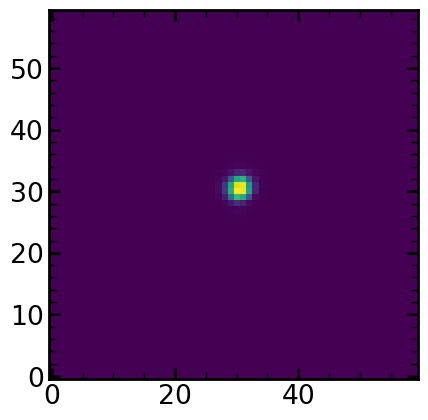

In [716]:
# just to test
scidata_cut=scidata[514-30:514+30,2646-30:2646+30]
plt.imshow(scidata_cut)

In [443]:
# testing centering algorithm
#center_pos_new=centering_algorithm(scidata,1525,1957,60)

0:[1927, 1987, 1495, 1555]
1:[1927, 1987, 1495, 1555]
2:[1927, 1987, 1495, 1555]
3:[1927, 1987, 1495, 1555]


In [813]:
finalNe_Feb2019[finalNe_Feb2019['fiber']=='4']

fiber    xc    yc wavelength close lamp  xc_effective old_index_approx  \
36     4  1229   322  650.84186     0   Ne          1229               18   
37     4  1229   352   653.4774     0   Ne          1229               19   
38     4  1229   428   660.0668     1   Ne          1229               20   
39     4  1229   518  668.01764     0   Ne          1229               21   
40     4  1229   562   671.9268     0   Ne          1229               22   
41     4  1230   805  693.13116     1   Ne          1230               23   
42     4  1231  1084  717.59015     1   Ne          1231               24   
43     4  1231  1165  724.72437     1   Ne          1231               25   
44     4  1231  1387   744.1276     0   Ne          1231               26   

   superold_index_approx  
36                   nan  
37                   nan  
38                   nan  
39                   nan  
40                   nan  
41                   nan  
42                   nan  
43                   nan  
44                   nan

In [818]:
11748+607-54+12

12313

In [886]:
run=11748+607
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB25/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-16/'
#DATA_FLATS_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/FEB12/Feb2019/rerun/Feb12_2019/arc/calExp/2019-02-02/'

data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
#dataFlats=fits.open(DATA_FLATS_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
scidata=np.zeros_like(data[1].data)
maskdata=np.zeros_like(scidata)
vardata=np.zeros_like(scidata)  
#maskdata_flats=np.zeros_like(scidata)

list_of_sci_data=[]
list_of_var_data=[]
list_of_mask_data=[]
#list_of_mask_data_flats=[]
for run_i in range(6):
    data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
    #data_flats=fits.open(DATA_FLATS_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
    exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
    background=background_estimate_sigma_clip_fit_function(exposure_defocus)
    if run_i==0:
        print('background estimate is: '+str(background))

    scidata_single=data[1].data-background
    maskdata_single=data[2].data
    #maskdata_flats_single=data_flats[2].data
    print(np.sum(maskdata_single))
    vardata_single=data[3].data
    
    scidata=scidata+scidata_single
    maskdata=maskdata+maskdata_single
    vardata=vardata+vardata_single
    #maskdata_flats=maskdata_flats+maskdata_flats_single
    
    list_of_sci_data.append(scidata_single)
    list_of_var_data.append(vardata_single)
    maskdata_single[np.isin(maskdata_single,[0,512])]=0
    maskdata_single[~np.isin(maskdata_single,[0,512])]=1
    list_of_mask_data.append(maskdata_single)
    
maskdata[np.isin(maskdata,[0,3072])]=0
maskdata[~np.isin(maskdata,[0,3072])]=1

#maskdata_flats[np.isin(maskdata_flats,[0,3072])]=0
#maskdata_flats[~np.isin(maskdata_flats,[0,3072])]=1

background estimate is: 0.34416228
18021
20321
18945
26613
20569
20559


In [892]:
finalNe_Feb2019[finalNe_Feb2019['fiber']=='13']

fiber    xc    yc wavelength close lamp  xc_effective old_index_approx  \
117    13  3340   331  650.84186     0   Ne          3409               72   
118    13  3340   361   653.4774     0   Ne          3409               73   
119    13  3339   437   660.0668     1   Ne          3408               74   
120    13  3339   528  668.01764     0   Ne          3408               75   
121    13  3339   572   671.9268     0   Ne          3408               76   
122    13  3337   815  693.13116     1   Ne          3406               77   
123    13  3336  1095  717.59015     1   Ne          3405               78   
124    13  3336  1176  724.72437     1   Ne          3405               79   
125    13  3336  1399   744.1276     0   Ne          3405               80   

    superold_index_approx  
117                   nan  
118                   nan  
119                   nan  
120                   nan  
121                   nan  
122                   nan  
123                   nan  
124                   nan  
125                   nan

In [888]:
image_index=119

# central position as deduced from focused images
center_pos=[int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[1])]
print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))

#size=sizes_of_stamps[defocus_values==exposure_defocus]
# have to set manually if in focus
if run==11748+607:
    size=20
else:
    size=sizes_of_stamps[defocus_values==exposure_defocus]
size_of_stamp=size

center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

#xposmin=int(np.round(center_pos_new[0]-size-10))
#xposmax=int(np.round(center_pos_new[0]+size+10))
#yposmin=int(np.round(center_pos_new[1]-size-45))
#yposmax=int(np.round(center_pos_new[1]+size+45))

xposmin=int(np.round(center_pos_new[0]-70-10))
xposmax=int(np.round(center_pos_new[0]+70+10))
yposmin=int(np.round(center_pos_new[1]-70-45))
yposmax=int(np.round(center_pos_new[1]+70+45))

size_of_stamp
#print(xposmin,xposmax,yposmin,yposmax)


scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

scidata_cut_original=np.copy(scidata_cut)

#################
# removal of continuum - estimating
#################

# estimating local background
sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
sci_lower_cut=scidata_cut[5:70]

overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
print('overall_median is: '+str(overall_median))

scidata_cut_median_subtracted=scidata_cut-overall_median
scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

if finalNe_Feb2019.loc[image_index]['wavelength']=='660.0668':
    init_lower_limit=77
    init_upper_limit=82
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalNe_Feb2019.loc[image_index]['wavelength']=='693.13116':
    init_lower_limit=0
    init_upper_limit=80
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalNe_Feb2019.loc[image_index]['wavelength']=='717.59015':
    init_lower_limit=20
    init_upper_limit=80    
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
if finalNe_Feb2019.loc[image_index]['wavelength']=='724.72437':
    init_lower_limit=0
    init_upper_limit=50
    lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
    upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
    print('lower_limit: '+str(lower_limit))
    print('upper_limit: '+str(upper_limit))
   
    
# estimating continuum
sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
midpoint=scidata_cut_median_subtracted.shape[0]/2
sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
fiber_profile=np.ma.mean(sci_central_cut_masked,axis=0)

res=[]
#res_upper=[]
res_upper_all_values=[]
#res_lower=[]
res_lower_all_values=[]
for j in range(scidata_cut.shape[1]):
    value=np.median(sci_lower_cut[:,j])     
    res_lower_all_values.append(value)
    value=np.median(sci_upper_cut[:,j])     
    res_upper_all_values.append(value)


res_upper_all_values=np.array(res_upper_all_values)
res_lower_all_values=np.array(res_lower_all_values)

# esnures that you do not oversubtract in the middle
#res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
#res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

res_upper=(fiber_profile/res_upper_multi)*0.995
res_lower=(fiber_profile/res_lower_multi)*0.995

if float(finalNe_Feb2019.loc[image_index]['wavelength'])<950:
    # if there is another source in upper part, override it with lower half
    print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
    print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
    if res_upper_multi/res_lower_multi<1/1.2:
        print('overwritting upper with lower')
        res_upper=res_lower

    # if there is another source in lower part, override it with upper half
    elif res_lower_multi/res_upper_multi<1/1.2:
        print('overwritting lower with upper')
        res_lower=res_upper

print(float(finalNe_Feb2019.loc[image_index]['wavelength']))
if float(finalNe_Feb2019.loc[image_index]['wavelength'])<670:
    res_upper=np.full(len(res_lower),0)
    res_lower=np.full(len(res_lower),0)
#################
# removal of continuum - actual removal
#################
scidata_cut_large_removed=scidata_cut_median_subtracted
maskdata_cut_large_removed=maskdata_cut
vardata_cut_large_removed=vardata_cut
for j in range(scidata_cut_large_removed.shape[1]):    
    scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
    scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

############################ 
# cutting final image
# allow for 5 pixels change, to capture wings of the donut
#################
y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>300)))
x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>300)))

y_lower_limit_for_final_cut=int(y_pos_for_final_cut-size_of_stamp/2)
y_upper_limit_for_final_cut=int(y_pos_for_final_cut+size_of_stamp/2)
x_lower_limit_for_final_cut=int(x_pos_for_final_cut-size_of_stamp/2)
x_upper_limit_for_final_cut=int(x_pos_for_final_cut+size_of_stamp/2)

print([y_lower_limit_for_final_cut,y_upper_limit_for_final_cut,x_lower_limit_for_final_cut,x_upper_limit_for_final_cut])

scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
maskdata_final_cut=maskdata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
vardata_final_cut=vardata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]

############################ 
#select only exposures that have no cosmics inside
#################
#scidata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata_final_cut_no_CR=np.zeros_like(scidata_final_cut)
#vardata=np.zeros_like(scidata)  
#for run_i in range(6):
#    if np.sum(list_of_mask_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut])==0:
#        scidata_final_cut_no_CR+=list_of_sci_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
#        vardata_final_cut_no_CR+=list_of_var_data[run_i][y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

print(scidata_final_cut.shape)

Central position of the spot 119 is: [3339, 437]
0:[427, 447, 3329, 3349]
1:[427, 447, 3329, 3349]
2:[427, 447, 3329, 3349]
3:[427, 447, 3329, 3349]
overall_median is: 4.106192588806152
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 1.022656469114094
sum_lower over sum_upper: 0.9778454742150893
660.0668
[5, 25, 70, 90]
(20, 20)


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


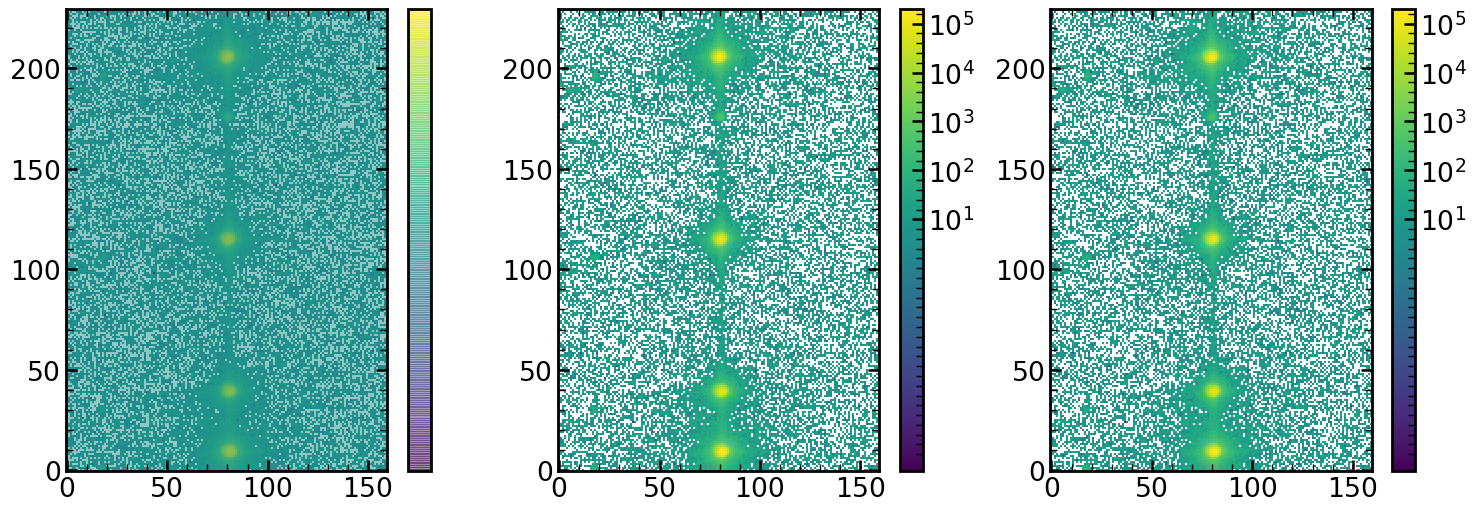

In [889]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(scidata_cut_original,norm=LogNorm(),origin='lower')
plt.imshow(maskdata_cut,origin='lower',alpha=.5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(132)
plt.imshow(scidata_cut_original_median_subtracted,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(133)
plt.imshow(scidata_cut_large_removed,norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


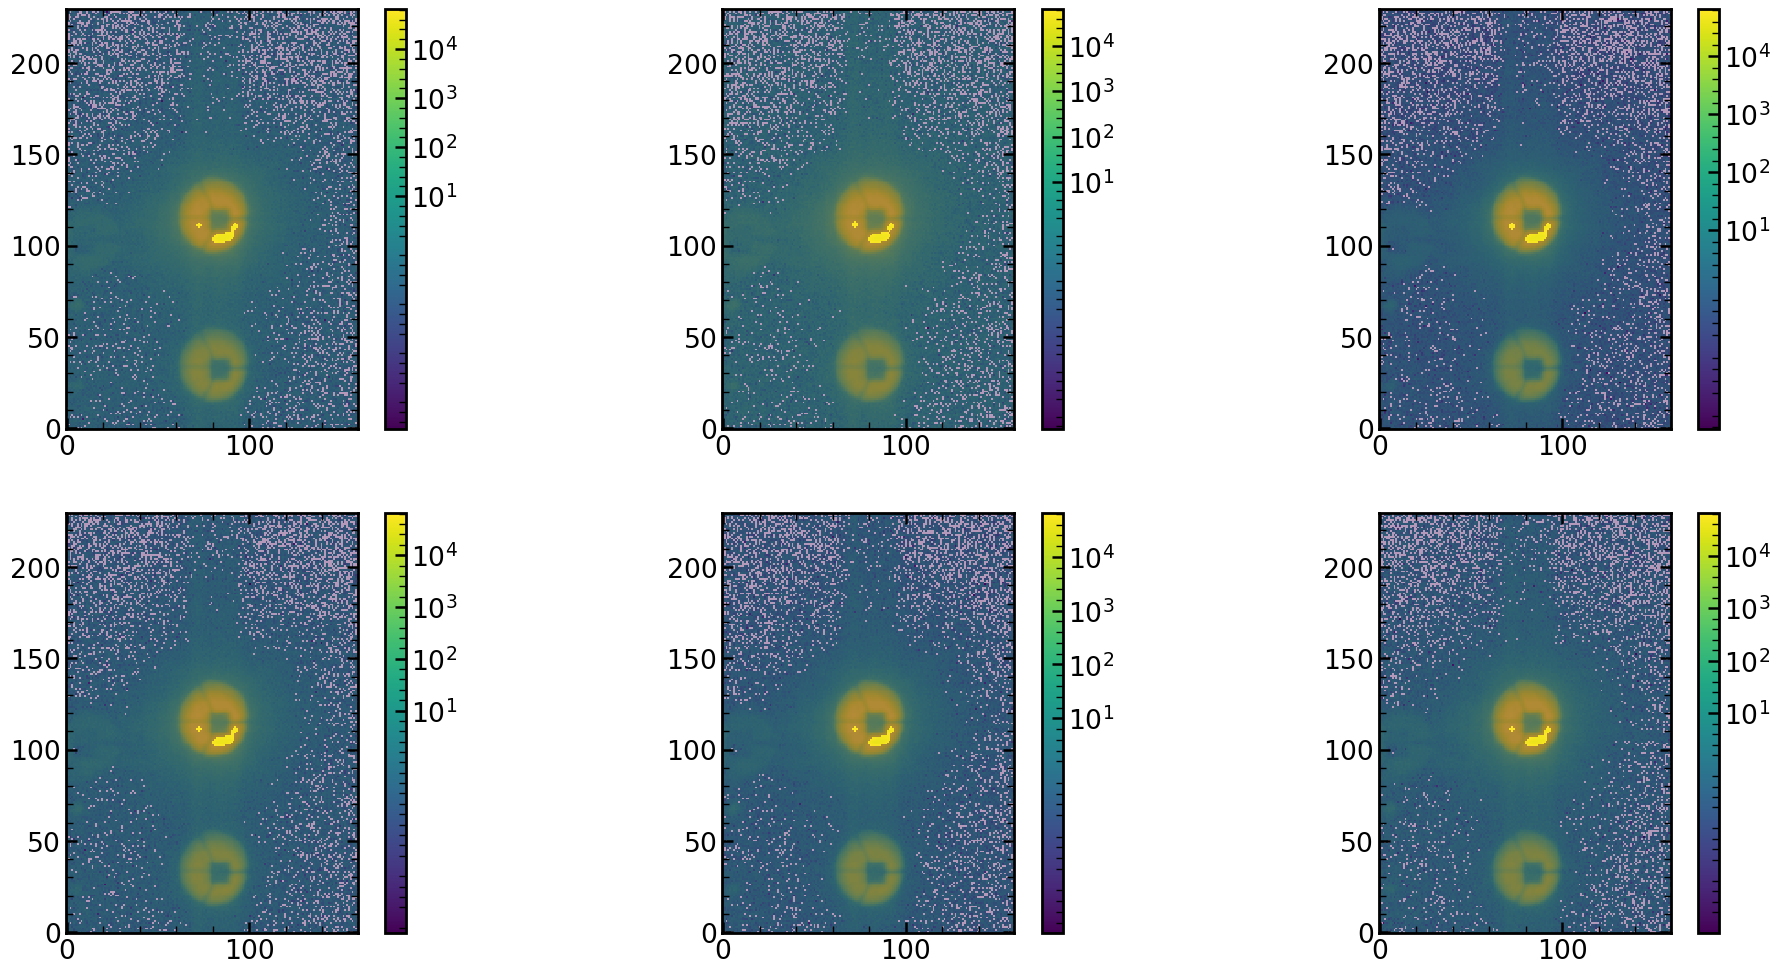

In [865]:
plt.figure(figsize=(24,12))
plt.subplot(231)
plt.imshow(list_of_sci_data[0][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[0][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(232)

plt.imshow(list_of_sci_data[1][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[1][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(233)
plt.imshow(list_of_sci_data[2][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[2][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(234)
plt.imshow(list_of_sci_data[3][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[3][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(235)
plt.imshow(list_of_sci_data[4][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[4][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.subplot(236)
plt.imshow(list_of_sci_data[5][yposmin:yposmax,xposmin:xposmax],norm=LogNorm(),origin='lower')
cbar=plt.colorbar()
plt.imshow(list_of_mask_data[5][yposmin:yposmax,xposmin:xposmax],origin='lower',alpha=.4)

cbar.set_ticks([10,10**2,10**3,10**4,10**5])

## actual cut 

In [885]:
for run in tqdm(list(range(12301,12409+6,6))):
    try:

        DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB25/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-16/'
        data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
        scidata=np.zeros_like(data[1].data)
        maskdata=np.zeros_like(scidata)
        vardata=np.zeros_like(scidata)  


        list_of_sci_data=[]
        list_of_var_data=[]
        list_of_mask_data=[]
        for run_i in range(6):
            data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
            exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
            background=background_estimate_sigma_clip_fit_function(exposure_defocus)
            if run_i==0:
                print('background estimate is: '+str(background))

            scidata_single=data[1].data-background
            maskdata_single=data[2].data
            print(np.sum(maskdata_single))
            vardata_single=data[3].data

            scidata=scidata+scidata_single
            maskdata=maskdata+maskdata_single
            vardata=vardata+vardata_single

            list_of_sci_data.append(scidata_single)
            list_of_var_data.append(vardata_single)
            maskdata_single[np.isin(maskdata_single,[0,512])]=0
            maskdata_single[~np.isin(maskdata_single,[0,512])]=1
            list_of_mask_data.append(maskdata_single)

        maskdata[np.isin(maskdata,[0,3072])]=0
        maskdata[~np.isin(maskdata,[0,3072])]=1


        for image_index in range(len(finalNe_Feb2019)):


            # central position as deduced from focused images
            center_pos=[int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[1])]
            print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
            size=sizes_of_stamps[defocus_values==exposure_defocus]
            size_of_stamp=size

            center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

            xposmin=int(np.round(center_pos_new[0]-70-10))
            xposmax=int(np.round(center_pos_new[0]+70+10))
            yposmin=int(np.round(center_pos_new[1]-70-45))
            yposmax=int(np.round(center_pos_new[1]+70+45))
            #print(xposmin,xposmax,yposmin,yposmax)


            scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
            maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
            vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

            scidata_cut_original=np.copy(scidata_cut)

            #################
            # removal of continuum - estimating
            #################

            # estimating local background
            sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
            sci_lower_cut=scidata_cut[5:70]

            overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
            overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
            print('overall_median is: '+str(overall_median))

            scidata_cut_median_subtracted=scidata_cut-overall_median
            scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)

            if finalNe_Feb2019.loc[image_index]['wavelength']=='660.0668':
                init_lower_limit=77
                init_upper_limit=82
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalNe_Feb2019.loc[image_index]['wavelength']=='693.13116':
                init_lower_limit=0
                init_upper_limit=80
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalNe_Feb2019.loc[image_index]['wavelength']=='717.59015':
                init_lower_limit=20
                init_upper_limit=80    
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))
            if finalNe_Feb2019.loc[image_index]['wavelength']=='724.72437':
                init_lower_limit=0
                init_upper_limit=50
                lower_limit=int(np.max([0,init_lower_limit-int((70-size_of_stamp)/2)]))
                upper_limit=int(np.max([70,init_upper_limit+int(70-size_of_stamp)/2])) 
                print('lower_limit: '+str(lower_limit))
                print('upper_limit: '+str(upper_limit))



            # estimating continuum
            sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
            sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
            midpoint=scidata_cut_median_subtracted.shape[0]/2
            sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
            mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
            sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
            fiber_profile=np.mean(sci_central_cut_masked,axis=0)

            res=[]
            #res_upper=[]
            res_upper_all_values=[]
            #res_lower=[]
            res_lower_all_values=[]
            for j in range(scidata_cut.shape[1]):
                value=np.median(sci_lower_cut[:,j])     
                res_lower_all_values.append(value)
                value=np.median(sci_upper_cut[:,j])     
                res_upper_all_values.append(value)


            res_upper_all_values=np.array(res_upper_all_values)
            res_lower_all_values=np.array(res_lower_all_values)

            # esnures that you do not oversubtract in the middle
            #res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
            #res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

            res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
            res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

            res_upper=(fiber_profile/res_upper_multi)*0.995
            res_lower=(fiber_profile/res_lower_multi)*0.995


            if float(finalNe_Feb2019.loc[image_index]['wavelength'])<950:
                # if there is another source in upper part, override it with lower half
                print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
                print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
                if res_upper_multi/res_lower_multi<1/1.2:
                    print('overwritting upper with lower')
                    res_upper=res_lower

                # if there is another source in lower part, override it with upper half
                elif res_lower_multi/res_upper_multi<1/1.2:
                    print('overwritting lower with upper')
                    res_lower=res_upper

            
            if float(finalNe_Feb2019.loc[image_index]['wavelength'])<670:
                res_upper=np.full(len(res_lower),0)
                res_lower=np.full(len(res_lower),0)


            #################
            # removal of continuum - actual removal
            #################
            scidata_cut_large_removed=scidata_cut_median_subtracted
            maskdata_cut_large_removed=maskdata_cut
            vardata_cut_large_removed=vardata_cut
            for j in range(scidata_cut_large_removed.shape[1]):    
                scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
                scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            ############################ 
            # cutting final image
            # allow for 5 pixels change, to capture wings of the donut
            #################
            y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
            y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

            scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
            vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

            # use mask to make sure that CR do not mess with this median
            y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>800)))
            x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>800)))

            y_lower_limit_for_final_cut=int(np.round(y_pos_for_final_cut-size_of_stamp/2))
            y_upper_limit_for_final_cut=int(np.round(y_pos_for_final_cut+size_of_stamp/2))
            x_lower_limit_for_final_cut=int(np.round(x_pos_for_final_cut-size_of_stamp/2))
            x_upper_limit_for_final_cut=int(np.round(x_pos_for_final_cut+size_of_stamp/2))

            scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            maskdata_final_cut=maskdata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            vardata_final_cut=vardata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]


            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'Ne_Stacked.npy',scidata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'Ne_Stacked.npy',maskdata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'Ne_Stacked.npy',vardata_final_cut)

            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'Ne_Stacked_large.npy',scidata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'Ne_Stacked_large.npy',maskdata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'Ne_Stacked_large.npy',vardata_cut_large_removed)
    except TypeError:
        pass

  0%|          | 0/19 [00:00<?, ?it/s]

background estimate is: 14.759420745000002
181065
178915
185229
180853
176665
180355
Central position of the spot 0 is: [255, 346]
0:[311, 381, 220, 290]
1:[310, 380, 223, 293]
2:[316, 386, 232, 302]
3:[318, 388, 232, 302]
overall_median is: 69.37968444824219
sum_lower over sum_upper: 100.71904938862939
sum_lower over sum_upper: 0.009928608401986113
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[341, 411, 220, 290]
1:[340, 410, 223, 293]
2:[328, 398, 232, 302]
3:[321, 391, 232, 302]
overall_median is: 69.89584350585938
sum_lower over sum_upper: 51.16570154459889
sum_lower over sum_upper: 0.01954434259302287
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[417, 487, 221, 291]
1:[416, 486, 228, 298]
2:[418, 488, 233, 303]
3:[418, 488, 233, 303]


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


overall_median is: 80.96980285644531
lower_limit: 77
upper_limit: 82
sum_lower over sum_upper: 0.9533311969009546
sum_lower over sum_upper: 1.048953399669238
Central position of the spot 3 is: [257, 543]
0:[508, 578, 222, 292]
1:[507, 577, 227, 297]
2:[512, 582, 234, 304]
3:[515, 585, 234, 304]
overall_median is: 58.62281799316406
sum_lower over sum_upper: 119.69984207739833
sum_lower over sum_upper: 0.008354229902437102
overwritting upper with lower
Central position of the spot 4 is: [257, 587]
0:[552, 622, 222, 292]
1:[551, 621, 228, 298]
2:[542, 612, 234, 304]
3:[538, 608, 234, 304]
overall_median is: 54.15795135498047
sum_lower over sum_upper: 0.12272750964494857
sum_lower over sum_upper: 8.148132418664781
overwritting lower with upper
Central position of the spot 5 is: [259, 831]
0:[796, 866, 224, 294]
1:[795, 865, 228, 298]
2:[797, 867, 236, 306]
3:[797, 867, 236, 306]
overall_median is: 61.81260681152344
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 6.516637256303706


overall_median is: 233.06060791015625
lower_limit: 77
upper_limit: 82
sum_lower over sum_upper: 0.8908935884646735
sum_lower over sum_upper: 1.1224685113329367
Central position of the spot 30 is: [896, 525]
0:[490, 560, 861, 931]
1:[489, 559, 860, 930]
2:[494, 564, 859, 929]
3:[498, 568, 858, 928]
overall_median is: 120.28982543945312
sum_lower over sum_upper: 99.205287344436
sum_lower over sum_upper: 0.01008010789312114
overwritting upper with lower
Central position of the spot 31 is: [896, 569]
0:[534, 604, 861, 931]
1:[533, 603, 860, 930]
2:[525, 595, 859, 929]
3:[521, 591, 858, 928]
overall_median is: 105.02745819091797
sum_lower over sum_upper: 0.08794089699017509
sum_lower over sum_upper: 11.371273596535202
overwritting lower with upper
Central position of the spot 32 is: [897, 812]
0:[777, 847, 862, 932]
1:[776, 846, 861, 931]
2:[778, 848, 860, 930]
3:[778, 848, 859, 929]
overall_median is: 119.40050506591797
lower_limit: 0
upper_limit: 80
sum_lower over sum_upper: 9.46064561704

overall_median is: 278.3394775390625
lower_limit: 77
upper_limit: 82
sum_lower over sum_upper: 0.9330970252390791
sum_lower over sum_upper: 1.0716999121755628
Central position of the spot 57 is: [1618, 514]
0:[479, 549, 1583, 1653]
1:[478, 548, 1582, 1652]
2:[483, 553, 1586, 1656]
3:[486, 556, 1586, 1656]
overall_median is: 165.54379272460938
sum_lower over sum_upper: 126.72223694955787
sum_lower over sum_upper: 0.00789127483914329
overwritting upper with lower
Central position of the spot 58 is: [1618, 558]
0:[523, 593, 1583, 1653]
1:[522, 592, 1582, 1652]
2:[513, 583, 1586, 1656]
3:[509, 579, 1586, 1656]
overall_median is: 147.04022216796875
sum_lower over sum_upper: 0.05993978586528747
sum_lower over sum_upper: 16.68340961790328
overwritting lower with upper
Central position of the spot 59 is: [1618, 800]
0:[765, 835, 1583, 1653]
1:[764, 834, 1582, 1652]
2:[766, 836, 1586, 1656]
3:[766, 836, 1586, 1656]
overall_median is: 161.6597900390625
lower_limit: 0
upper_limit: 80
sum_lower ov

overall_median is: 212.16082763671875
lower_limit: 77
upper_limit: 82
sum_lower over sum_upper: 0.9190272624355437
sum_lower over sum_upper: 1.0881070027779893
Central position of the spot 84 is: [2239, 511]
0:[476, 546, 2204, 2274]
1:[475, 545, 2203, 2273]
2:[480, 550, 2203, 2273]
3:[483, 553, 2203, 2273]
overall_median is: 146.16302490234375
sum_lower over sum_upper: 156.42098634726443
sum_lower over sum_upper: 0.006393004054967004
overwritting upper with lower
Central position of the spot 85 is: [2239, 555]
0:[520, 590, 2204, 2274]
1:[519, 589, 2203, 2273]
2:[510, 580, 2203, 2273]
3:[506, 576, 2204, 2274]
overall_median is: 132.63804626464844
sum_lower over sum_upper: 0.057810692102461494
sum_lower over sum_upper: 17.297838230817884
overwritting lower with upper
Central position of the spot 86 is: [2239, 797]
0:[762, 832, 2204, 2274]
1:[761, 831, 2203, 2273]
2:[762, 832, 2203, 2273]
3:[762, 832, 2203, 2273]
overall_median is: 156.10805
lower_limit: 0
upper_limit: 80
sum_lower over s

Central position of the spot 110 is: [2838, 427]
0:[392, 462, 2803, 2873]
1:[391, 461, 2800, 2870]
2:[393, 463, 2799, 2869]
3:[393, 463, 2799, 2869]
overall_median is: 103.64082336425781
lower_limit: 77
upper_limit: 82
sum_lower over sum_upper: 1.0291178877125893
sum_lower over sum_upper: 0.9717059745435876
Central position of the spot 111 is: [2838, 517]
0:[482, 552, 2803, 2873]
1:[481, 551, 2802, 2872]
2:[486, 556, 2798, 2868]
3:[489, 559, 2798, 2868]
overall_median is: 86.2664794921875
sum_lower over sum_upper: 129.8101744886219
sum_lower over sum_upper: 0.007703556396402902
overwritting upper with lower
Central position of the spot 112 is: [2838, 561]
0:[526, 596, 2803, 2873]
1:[525, 595, 2802, 2872]
2:[517, 587, 2798, 2868]
3:[513, 583, 2799, 2869]
overall_median is: 79.1125717163086
sum_lower over sum_upper: 0.07706966435091427
sum_lower over sum_upper: 12.97527384376285
overwritting lower with upper
Central position of the spot 113 is: [2837, 804]
0:[769, 839, 2802, 2872]
1:[768

overall_median is: 42.52813
sum_lower over sum_upper: 42.25867980608952
sum_lower over sum_upper: 0.02366377758578012
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[416, 486, 3796, 3866]
1:[416, 486, 3787, 3857]
2:[418, 488, 3783, 3853]
3:[418, 488, 3783, 3853]
overall_median is: 51.45525360107422
lower_limit: 77
upper_limit: 82
sum_lower over sum_upper: 0.8968836541243924
sum_lower over sum_upper: 1.1149718198134382
Central position of the spot 138 is: [3830, 542]
0:[507, 577, 3795, 3865]
1:[506, 576, 3788, 3858]
2:[512, 582, 3782, 3852]
3:[515, 585, 3782, 3852]
overall_median is: 30.181772232055664
sum_lower over sum_upper: 40.66266489866504
sum_lower over sum_upper: 0.02459258394628312
overwritting upper with lower
Central position of the spot 139 is: [3830, 587]
0:[552, 622, 3795, 3865]
1:[551, 621, 3786, 3856]
2:[542, 612, 3782, 3852]
3:[538, 608, 3783, 3853]
overall_median is: 24.775959014892578
sum_lower over sum_upper: 0.13199452574332934
sum_

  5%|▌         | 1/19 [00:22<06:39, 22.17s/it]

overall_median is: 10.358652114868164
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.011255580515420765
sum_lower over sum_upper: 88.8448177888244
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1381, 1451, 3790, 3860]
1:[1382, 1452, 3781, 3851]
2:[1383, 1453, 3777, 3847]
3:[1383, 1453, 3777, 3847]
overall_median is: -1.8751497
sum_lower over sum_upper: 124.38430863022853
sum_lower over sum_upper: 0.008039599295219902
overwritting upper with lower
background estimate is: 11.626002600000001
159395
172605
167863
163669
168153
169627
Central position of the spot 0 is: [255, 346]
0:[316, 376, 225, 285]
1:[316, 376, 225, 285]
2:[321, 381, 236, 296]
3:[322, 382, 236, 296]
overall_median is: 69.90015411376953
sum_lower over sum_upper: 9.076553731427277
sum_lower over sum_upper: 0.110173974571156
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[346, 406, 225, 285]
1:[346, 406, 225, 285]
2:[335, 395, 236, 296]
3:[328, 

lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.04051164227529588
sum_lower over sum_upper: 24.684262198123797
overwritting lower with upper
Central position of the spot 26 is: [855, 1396]
0:[1366, 1426, 825, 885]
1:[1366, 1426, 828, 888]
2:[1367, 1427, 832, 892]
3:[1367, 1427, 834, 894]
overall_median is: 55.180424
sum_lower over sum_upper: 88.20759613835308
sum_lower over sum_upper: 0.011336892102030602
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[299, 359, 865, 925]
1:[299, 359, 865, 925]
2:[304, 364, 866, 926]
3:[305, 365, 867, 927]
overall_median is: 167.17236328125
sum_lower over sum_upper: 11.18831258324498
sum_lower over sum_upper: 0.08937898298422112
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[329, 389, 865, 925]
1:[329, 389, 865, 925]
2:[318, 378, 866, 926]
3:[310, 370, 866, 926]
overall_median is: 165.4579
sum_lower over sum_upper: 20.828798780092402
sum_lower over sum_upper: 0.0480104498851740

sum_lower over sum_upper: 97.63988394693116
sum_lower over sum_upper: 0.010241716392693747
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[288, 348, 1587, 1647]
1:[288, 348, 1587, 1647]
2:[292, 352, 1590, 1650]
3:[293, 353, 1590, 1650]
overall_median is: 194.68804931640625
sum_lower over sum_upper: 16.47293139361547
sum_lower over sum_upper: 0.06070564953530838
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[318, 378, 1587, 1647]
1:[318, 378, 1587, 1647]
2:[307, 367, 1591, 1651]
3:[299, 359, 1590, 1650]
overall_median is: 190.3876953125
sum_lower over sum_upper: 26.019626432585966
sum_lower over sum_upper: 0.038432527176779106
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[393, 453, 1588, 1648]
1:[393, 453, 1588, 1648]
2:[394, 454, 1590, 1650]
3:[394, 454, 1590, 1650]
overall_median is: 244.037353515625
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 0.863418305654094
sum_lower

overall_median is: 166.90419006347656
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.013503583840334074
sum_lower over sum_upper: 74.05441487415243
overwritting lower with upper
Central position of the spot 80 is: [2122, 1379]
0:[1349, 1409, 2092, 2152]
1:[1349, 1409, 2092, 2152]
2:[1351, 1411, 2091, 2151]
3:[1351, 1411, 2091, 2151]
overall_median is: 126.85758209228516
sum_lower over sum_upper: 135.30822023362626
sum_lower over sum_upper: 0.00739053398436087
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[286, 346, 2210, 2270]
1:[286, 346, 2210, 2270]
2:[290, 350, 2209, 2269]
3:[290, 350, 2209, 2269]
overall_median is: 164.58416748046875
sum_lower over sum_upper: 14.651752801811064
sum_lower over sum_upper: 0.0682512197364122
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[316, 376, 2210, 2270]
1:[316, 376, 2210, 2270]
2:[305, 365, 2209, 2269]
3:[297, 357, 2209, 2269]
overall_median is: 163.7179412841797
sum

sum_lower over sum_upper: 439.313643755538
sum_lower over sum_upper: 0.002276278040106725
overwritting upper with lower
Central position of the spot 106 is: [2645, 1161]
0:[1131, 1191, 2615, 2675]
1:[1131, 1191, 2615, 2675]
2:[1133, 1193, 2611, 2671]
3:[1133, 1193, 2611, 2671]
overall_median is: 99.73365020751953
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.014898839646773137
sum_lower over sum_upper: 67.1193209476944
overwritting lower with upper
Central position of the spot 107 is: [2645, 1383]
0:[1353, 1413, 2615, 2675]
1:[1353, 1413, 2613, 2673]
2:[1354, 1414, 2611, 2671]
3:[1354, 1414, 2611, 2671]
overall_median is: 62.270835876464844
sum_lower over sum_upper: 92.71743118564932
sum_lower over sum_upper: 0.010785458432273506
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[291, 351, 2809, 2869]
1:[291, 351, 2809, 2869]
2:[296, 356, 2805, 2865]
3:[297, 357, 2805, 2865]
overall_median is: 91.95049285888672
sum_lower over sum_upper: 15.62

overall_median is: 48.26531219482422
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 318.8017531983734
sum_lower over sum_upper: 0.0031367456106107207
overwritting upper with lower
Central position of the spot 133 is: [3633, 1186]
0:[1156, 1216, 3603, 3663]
1:[1156, 1216, 3603, 3663]
2:[1158, 1218, 3594, 3654]
3:[1158, 1218, 3594, 3654]
overall_median is: 21.29888153076172
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.01666979641578047
sum_lower over sum_upper: 59.988735018584244
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1379, 1439, 3603, 3663]
1:[1379, 1439, 3597, 3657]
2:[1381, 1441, 3593, 3653]
3:[1381, 1441, 3593, 3653]
overall_median is: 5.532170295715332
sum_lower over sum_upper: 108.10705198378632
sum_lower over sum_upper: 0.009250090365520078
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[315, 375, 3802, 3862]
1:[315, 375, 3798, 3858]
2:[320, 380, 3791, 3851]
3:[320, 380, 3791, 38

 11%|█         | 2/19 [00:48<06:49, 24.09s/it]

overall_median is: 47.615325927734375
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 405.71568002336835
sum_lower over sum_upper: 0.0024647802617399506
overwritting upper with lower
Central position of the spot 142 is: [3826, 1193]
0:[1163, 1223, 3796, 3856]
1:[1163, 1223, 3794, 3854]
2:[1164, 1224, 3785, 3845]
3:[1164, 1224, 3785, 3845]
overall_median is: 14.312738418579102
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.01626465875796313
sum_lower over sum_upper: 61.48299911367048
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1386, 1446, 3795, 3855]
1:[1386, 1446, 3788, 3848]
2:[1388, 1448, 3784, 3844]
3:[1388, 1448, 3784, 3844]
overall_median is: -0.6844942569732666
sum_lower over sum_upper: 112.17426403640206
sum_lower over sum_upper: 0.008914700788012181
overwritting upper with lower
background estimate is: 8.885244655000003
125623
134101
133913
125913
126257
129751
Central position of the spot 0 is: [255, 346]
0:[316, 376

overall_median is: 62.22377014160156
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.07316051045850488
sum_lower over sum_upper: 13.668576035526423
overwritting lower with upper
Central position of the spot 26 is: [855, 1396]
0:[1366, 1426, 825, 885]
1:[1366, 1426, 831, 891]
2:[1367, 1427, 832, 892]
3:[1367, 1427, 833, 893]
overall_median is: 40.26410675048828
sum_lower over sum_upper: 80.62479664141742
sum_lower over sum_upper: 0.012403132059328437
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[299, 359, 865, 925]
1:[299, 359, 865, 925]
2:[304, 364, 866, 926]
3:[305, 365, 866, 926]
overall_median is: 122.17071533203125
sum_lower over sum_upper: 5.580303299832584
sum_lower over sum_upper: 0.17920172905834728
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[329, 389, 865, 925]
1:[329, 389, 865, 925]
2:[317, 377, 865, 925]
3:[309, 369, 866, 926]
overall_median is: 122.46083068847656
sum_lower over sum_upper: 14.95

sum_lower over sum_upper: 0.05675319137187547
sum_lower over sum_upper: 17.62015449400011
overwritting lower with upper
Central position of the spot 53 is: [1514, 1383]
0:[1353, 1413, 1484, 1544]
1:[1353, 1413, 1486, 1546]
2:[1355, 1415, 1487, 1547]
3:[1355, 1415, 1487, 1547]
overall_median is: 73.75750732421875
sum_lower over sum_upper: 93.55509513822567
sum_lower over sum_upper: 0.010688888708012335
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[288, 348, 1587, 1647]
1:[288, 348, 1587, 1647]
2:[292, 352, 1590, 1650]
3:[293, 353, 1590, 1650]
overall_median is: 139.60423278808594
sum_lower over sum_upper: 10.684432758348839
sum_lower over sum_upper: 0.09359411235178562
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[318, 378, 1587, 1647]
1:[318, 378, 1587, 1647]
2:[307, 367, 1590, 1650]
3:[298, 358, 1590, 1650]
overall_median is: 136.9390411376953
sum_lower over sum_upper: 19.128589841322942
sum_lower over sum_upper: 0.

Central position of the spot 79 is: [2122, 1157]
0:[1127, 1187, 2092, 2152]
1:[1127, 1187, 2092, 2152]
2:[1129, 1189, 2092, 2152]
3:[1129, 1189, 2092, 2152]
overall_median is: 121.14433288574219
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.017417126512312562
sum_lower over sum_upper: 57.414752042656254
overwritting lower with upper
Central position of the spot 80 is: [2122, 1379]
0:[1349, 1409, 2092, 2152]
1:[1349, 1409, 2092, 2152]
2:[1350, 1410, 2091, 2151]
3:[1350, 1410, 2091, 2151]
overall_median is: 93.21057891845703
sum_lower over sum_upper: 139.64386238069577
sum_lower over sum_upper: 0.007161073769742987
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[286, 346, 2210, 2270]
1:[286, 346, 2210, 2270]
2:[290, 350, 2209, 2269]
3:[291, 351, 2209, 2269]
overall_median is: 120.58513641357422
sum_lower over sum_upper: 13.268302441483346
sum_lower over sum_upper: 0.0753675916275092
overwritting upper with lower
Central position of the spot 8

lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.02369945543349078
sum_lower over sum_upper: 42.195062363621005
overwritting lower with upper
Central position of the spot 107 is: [2645, 1383]
0:[1353, 1413, 2615, 2675]
1:[1355, 1415, 2612, 2672]
2:[1354, 1414, 2612, 2672]
3:[1354, 1414, 2612, 2672]
overall_median is: 45.804039001464844
sum_lower over sum_upper: 91.86965007903406
sum_lower over sum_upper: 0.010884987579028713
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[291, 351, 2809, 2869]
1:[291, 351, 2809, 2869]
2:[296, 356, 2805, 2865]
3:[297, 357, 2805, 2865]
overall_median is: 66.05926
sum_lower over sum_upper: 12.01286163225034
sum_lower over sum_upper: 0.08324411207029549
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[321, 381, 2808, 2868]
1:[321, 381, 2808, 2868]
2:[310, 370, 2806, 2866]
3:[302, 362, 2805, 2865]
overall_median is: 65.57972
sum_lower over sum_upper: 21.113926457039817
sum_lower ov

2:[1158, 1218, 3595, 3655]
3:[1158, 1218, 3595, 3655]
overall_median is: 13.328328132629395
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.026796009652276603
sum_lower over sum_upper: 37.31898939344648
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1379, 1439, 3603, 3663]
1:[1381, 1441, 3595, 3655]
2:[1381, 1441, 3594, 3654]
3:[1381, 1441, 3594, 3654]
overall_median is: 3.565108299255371
sum_lower over sum_upper: 108.78884256383178
sum_lower over sum_upper: 0.009192119122080471
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[315, 375, 3802, 3862]
1:[315, 375, 3797, 3857]
2:[320, 380, 3793, 3853]
3:[321, 381, 3793, 3853]
overall_median is: 29.847434997558594
sum_lower over sum_upper: 9.409466266110853
sum_lower over sum_upper: 0.10627595356833378
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[345, 405, 3802, 3862]
1:[343, 403, 3797, 3857]
2:[333, 393, 3793, 3853]
3:[326, 

 16%|█▌        | 3/19 [01:10<06:17, 23.62s/it]

overall_median is: -1.610302448272705
sum_lower over sum_upper: 108.68305413956081
sum_lower over sum_upper: 0.009201066421227836
overwritting upper with lower
background estimate is: 6.532977120000001
107807
108321
102877
107533
101883
100623
Central position of the spot 0 is: [255, 346]
0:[321, 371, 230, 280]
1:[320, 370, 231, 281]
2:[324, 374, 239, 289]
3:[327, 377, 239, 289]
overall_median is: 46.75867462158203
sum_lower over sum_upper: 2.1534302656119744
sum_lower over sum_upper: 0.4643753809765529
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[351, 401, 230, 280]
1:[350, 400, 232, 282]
2:[341, 391, 238, 288]
3:[336, 386, 238, 288]
overall_median is: 46.613746643066406
sum_lower over sum_upper: 4.498292626084012
sum_lower over sum_upper: 0.22230656898605322
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[427, 477, 231, 281]
1:[426, 476, 236, 286]
2:[428, 478, 239, 289]
3:[428, 478, 239, 289]
overall_median is: 51.98263

overall_median is: 106.8724136352539
sum_lower over sum_upper: 7.7791125711719795
sum_lower over sum_upper: 0.1285493674054575
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[409, 459, 870, 920]
1:[408, 458, 869, 919]
2:[410, 460, 874, 924]
3:[410, 460, 876, 926]
overall_median is: 155.5296630859375
lower_limit: 67
upper_limit: 92
sum_lower over sum_upper: 0.8048040534099414
sum_lower over sum_upper: 1.2425384735116785
overwritting lower with upper
Central position of the spot 30 is: [896, 525]
0:[500, 550, 871, 921]
1:[499, 549, 870, 920]
2:[501, 551, 875, 925]
3:[501, 551, 876, 926]
overall_median is: 82.61430358886719
sum_lower over sum_upper: 58.21944479231592
sum_lower over sum_upper: 0.0171763919008033
overwritting upper with lower
Central position of the spot 31 is: [896, 569]
0:[544, 594, 871, 921]
1:[543, 593, 870, 920]
2:[545, 595, 875, 925]
3:[545, 595, 876, 926]
overall_median is: 62.13798
sum_lower over sum_upper: 0.0016705454160752665
sum_l

overall_median is: 110.464599609375
sum_lower over sum_upper: 12.809294787595968
sum_lower over sum_upper: 0.07806831028421343
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[398, 448, 1593, 1643]
1:[397, 447, 1594, 1644]
2:[399, 449, 1595, 1645]
3:[399, 449, 1595, 1645]
overall_median is: 134.8770751953125
lower_limit: 67
upper_limit: 92
sum_lower over sum_upper: 0.826544116894282
sum_lower over sum_upper: 1.2098567754102152
overwritting lower with upper
Central position of the spot 57 is: [1618, 514]
0:[489, 539, 1593, 1643]
1:[488, 538, 1592, 1642]
2:[489, 539, 1595, 1645]
3:[489, 539, 1595, 1645]
overall_median is: 98.07361602783203
sum_lower over sum_upper: 57.980130114616735
sum_lower over sum_upper: 0.01724728795922279
overwritting upper with lower
Central position of the spot 58 is: [1618, 558]
0:[533, 583, 1593, 1643]
1:[532, 582, 1593, 1643]
2:[533, 583, 1595, 1645]
3:[533, 583, 1595, 1645]
overall_median is: 79.16067504882812
sum_lower over s

overall_median is: 98.11412811279297
sum_lower over sum_upper: 4.527387530538448
sum_lower over sum_upper: 0.2208779330805527
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[321, 371, 2215, 2265]
1:[320, 370, 2214, 2264]
2:[311, 361, 2214, 2264]
3:[304, 354, 2214, 2264]
overall_median is: 96.74765014648438
sum_lower over sum_upper: 17.024397767147743
sum_lower over sum_upper: 0.058739229056884244
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[396, 446, 2215, 2265]
1:[395, 445, 2214, 2264]
2:[396, 446, 2214, 2264]
3:[396, 446, 2214, 2264]
overall_median is: 111.20757293701172
lower_limit: 67
upper_limit: 92
sum_lower over sum_upper: 0.8965112749736986
sum_lower over sum_upper: 1.1154349397661927
Central position of the spot 84 is: [2239, 511]
0:[486, 536, 2214, 2264]
1:[485, 535, 2213, 2263]
2:[486, 536, 2214, 2264]
3:[486, 536, 2214, 2264]
overall_median is: 91.85768127441406
sum_lower over sum_upper: 61.18683445989875


overall_median is: 40.04075241088867
sum_lower over sum_upper: 85.28900286594781
sum_lower over sum_upper: 0.011724841027532478
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[296, 346, 2814, 2864]
1:[295, 345, 2813, 2863]
2:[299, 349, 2811, 2861]
3:[300, 350, 2811, 2861]
overall_median is: 56.98984909057617
sum_lower over sum_upper: 5.465286536403214
sum_lower over sum_upper: 0.18297302315975453
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[326, 376, 2813, 2863]
1:[325, 375, 2812, 2862]
2:[316, 366, 2811, 2861]
3:[310, 360, 2811, 2861]
overall_median is: 56.090003967285156
sum_lower over sum_upper: 17.29058544469014
sum_lower over sum_upper: 0.057834941633343906
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[402, 452, 2813, 2863]
1:[401, 451, 2812, 2862]
2:[402, 452, 2810, 2860]
3:[402, 452, 2810, 2860]
overall_median is: 60.83675003051758
lower_limit: 67
upper_limit: 92
sum_lower 

sum_lower over sum_upper: 0.058880277470557706
sum_lower over sum_upper: 16.98361561730134
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1384, 1434, 3608, 3658]
1:[1385, 1435, 3603, 3653]
2:[1386, 1436, 3600, 3650]
3:[1386, 1436, 3600, 3650]
overall_median is: 6.395948886871338
sum_lower over sum_upper: 93.06209726192073
sum_lower over sum_upper: 0.010745513258588267
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[320, 370, 3807, 3857]
1:[319, 369, 3803, 3853]
2:[323, 373, 3799, 3849]
3:[324, 374, 3799, 3849]
overall_median is: 27.583759307861328
sum_lower over sum_upper: 5.0017251402017155
sum_lower over sum_upper: 0.1999310181925892
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[350, 400, 3807, 3857]
1:[349, 399, 3803, 3853]
2:[340, 390, 3799, 3849]
3:[334, 384, 3800, 3850]
overall_median is: 27.909488677978516
sum_lower over sum_upper: 13.887495371411443
sum_lower over sum_upper

 21%|██        | 4/19 [01:33<05:51, 23.45s/it]

Central position of the spot 142 is: [3826, 1193]
0:[1168, 1218, 3801, 3851]
1:[1167, 1217, 3800, 3850]
2:[1169, 1219, 3793, 3843]
3:[1169, 1219, 3792, 3842]
overall_median is: 12.61446762084961
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.05213574880379988
sum_lower over sum_upper: 19.180696987076082
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1391, 1441, 3800, 3850]
1:[1392, 1442, 3793, 3843]
2:[1392, 1442, 3792, 3842]
3:[1392, 1442, 3792, 3842]
overall_median is: 0.12978696823120117
sum_lower over sum_upper: 89.71091299965585
sum_lower over sum_upper: 0.011146915871916678
overwritting upper with lower
background estimate is: 4.565030204999999
82983
72589
70611
79681
76947
77447
Central position of the spot 0 is: [255, 346]
0:[326, 366, 235, 275]
1:[326, 366, 235, 275]
2:[328, 368, 242, 282]
3:[328, 368, 242, 282]
overall_median is: 29.302209854125977
sum_lower over sum_upper: 1.9998535720825887
sum_lower over sum_upper: 0.50003660

overall_median is: 22.992504119873047
sum_lower over sum_upper: 44.776776939703964
sum_lower over sum_upper: 0.022333005373445965
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[309, 349, 875, 915]
1:[309, 349, 875, 915]
2:[310, 350, 879, 919]
3:[310, 350, 880, 920]
overall_median is: 69.42789459228516
sum_lower over sum_upper: 2.1294612765487178
sum_lower over sum_upper: 0.46960234074823387
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[339, 379, 875, 915]
1:[339, 379, 875, 915]
2:[336, 376, 879, 919]
3:[332, 372, 880, 920]
overall_median is: 69.68352508544922
sum_lower over sum_upper: 4.053442637428335
sum_lower over sum_upper: 0.24670387358298468
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[414, 454, 875, 915]
1:[414, 454, 875, 915]
2:[415, 455, 880, 920]
3:[415, 455, 880, 920]
overall_median is: 97.64836120605469
lower_limit: 62
upper_limit: 97
sum_lower over sum_upper: 0.80972186554

overall_median is: 39.76131057739258
sum_lower over sum_upper: 43.015722588829355
sum_lower over sum_upper: 0.023247313768470498
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[298, 338, 1597, 1637]
1:[298, 338, 1597, 1637]
2:[298, 338, 1599, 1639]
3:[298, 338, 1599, 1639]
overall_median is: 74.87721252441406
sum_lower over sum_upper: 2.522086128226543
sum_lower over sum_upper: 0.39649716510798566
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[328, 368, 1597, 1637]
1:[328, 368, 1597, 1637]
2:[325, 365, 1599, 1639]
3:[321, 361, 1599, 1639]
overall_median is: 71.25814056396484
sum_lower over sum_upper: 4.869136700451625
sum_lower over sum_upper: 0.20537521567370404
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[403, 443, 1598, 1638]
1:[403, 443, 1599, 1639]
2:[404, 444, 1599, 1639]
3:[404, 444, 1599, 1639]
overall_median is: 91.835106
lower_limit: 62
upper_limit: 97
sum_lower over sum_upp

overall_median is: 49.882938385009766
sum_lower over sum_upper: 90.44351523027889
sum_lower over sum_upper: 0.011056624650798819
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[296, 336, 2220, 2260]
1:[296, 336, 2220, 2260]
2:[296, 336, 2219, 2259]
3:[296, 336, 2219, 2259]
overall_median is: 65.45343017578125
sum_lower over sum_upper: 2.925936663987032
sum_lower over sum_upper: 0.34177089760970714
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[326, 366, 2220, 2260]
1:[326, 366, 2220, 2260]
2:[323, 363, 2219, 2259]
3:[319, 359, 2219, 2259]
overall_median is: 63.05756759643555
sum_lower over sum_upper: 6.196406353552213
sum_lower over sum_upper: 0.16138386395958848
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[401, 441, 2220, 2260]
1:[401, 441, 2220, 2260]
2:[401, 441, 2219, 2259]
3:[401, 441, 2219, 2259]
overall_median is: 73.28849792480469
lower_limit: 62
upper_limit: 97
sum_lower over

overall_median is: 39.46874237060547
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.08962626165802243
sum_lower over sum_upper: 11.157444051561534
overwritting lower with upper
Central position of the spot 107 is: [2645, 1383]
0:[1363, 1403, 2625, 2665]
1:[1363, 1403, 2623, 2663]
2:[1364, 1404, 2622, 2662]
3:[1364, 1404, 2622, 2662]
overall_median is: 24.496673583984375
sum_lower over sum_upper: 67.11583514947597
sum_lower over sum_upper: 0.014899613448493429
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[301, 341, 2819, 2859]
1:[301, 341, 2819, 2859]
2:[302, 342, 2816, 2856]
3:[302, 342, 2816, 2856]
overall_median is: 36.28466796875
sum_lower over sum_upper: 2.6803767474876
sum_lower over sum_upper: 0.37308188146958476
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[331, 371, 2818, 2858]
1:[331, 371, 2818, 2858]
2:[327, 367, 2816, 2856]
3:[323, 363, 2816, 2856]
overall_median is: 34.218875885009766
sum_lo

overall_median is: 21.249311447143555
lower_limit: 5
upper_limit: 95
sum_lower over sum_upper: 9.20255632987073
sum_lower over sum_upper: 0.10866545817862408
overwritting upper with lower
Central position of the spot 133 is: [3633, 1186]
0:[1166, 1206, 3613, 3653]
1:[1166, 1206, 3613, 3653]
2:[1167, 1207, 3608, 3648]
3:[1167, 1207, 3607, 3647]
overall_median is: 8.603752136230469
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.09098310530865455
sum_lower over sum_upper: 10.991051543114096
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1389, 1429, 3613, 3653]
1:[1389, 1429, 3609, 3649]
2:[1390, 1430, 3607, 3647]
3:[1390, 1430, 3607, 3647]
overall_median is: 3.805962085723877
sum_lower over sum_upper: 63.89693654144092
sum_lower over sum_upper: 0.01565020256255073
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[325, 365, 3812, 3852]
1:[325, 365, 3810, 3850]
2:[326, 366, 3806, 3846]
3:[326, 366, 3805, 3845]
o

 26%|██▋       | 5/19 [01:56<05:25, 23.28s/it]

overall_median is: 1.2166786193847656
sum_lower over sum_upper: 70.87111473026964
sum_lower over sum_upper: 0.014110120940046279
overwritting upper with lower
background estimate is: 2.97723412
62225
64679
67633
60707
61161
57353
Central position of the spot 0 is: [255, 346]
0:[331, 361, 240, 270]
1:[330, 360, 239, 269]
2:[333, 363, 246, 276]
3:[333, 363, 246, 276]
overall_median is: 26.946495056152344
sum_lower over sum_upper: 1.9853913239683572
sum_lower over sum_upper: 0.5036790419740637
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[361, 391, 240, 270]
1:[360, 390, 242, 272]
2:[362, 392, 246, 276]
3:[362, 392, 246, 276]
overall_median is: 26.498199462890625
sum_lower over sum_upper: 2.8391553170751536
sum_lower over sum_upper: 0.35221743382119086
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[437, 467, 241, 271]
1:[436, 466, 242, 272]
2:[438, 468, 246, 276]
3:[438, 468, 246, 276]
overall_median is: 29.740524
lower_limi

sum_lower over sum_upper: 2.0542597870913513
sum_lower over sum_upper: 0.48679334828235665
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[344, 374, 880, 910]
1:[343, 373, 879, 909]
2:[344, 374, 883, 913]
3:[344, 374, 884, 914]
overall_median is: 55.427555084228516
sum_lower over sum_upper: 3.2792763440990402
sum_lower over sum_upper: 0.30494532789207296
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[419, 449, 880, 910]
1:[418, 448, 879, 909]
2:[420, 450, 884, 914]
3:[420, 450, 884, 914]
overall_median is: 75.14046478271484
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.8301046176927417
sum_lower over sum_upper: 1.2046674343042194
overwritting lower with upper
Central position of the spot 30 is: [896, 525]
0:[510, 540, 881, 911]
1:[509, 539, 880, 910]
2:[511, 541, 884, 914]
3:[511, 541, 884, 914]
overall_median is: 44.1673583984375
sum_lower over sum_upper: 9.673053539538463
sum_lower over sum_upper: 0.10337

overall_median is: 56.57079315185547
sum_lower over sum_upper: 3.577576850450503
sum_lower over sum_upper: 0.2795188033134986
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[408, 438, 1603, 1633]
1:[407, 437, 1602, 1632]
2:[409, 439, 1604, 1634]
3:[409, 439, 1604, 1634]
overall_median is: 70.15043640136719
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.9119763229885154
sum_lower over sum_upper: 1.096519695514719
Central position of the spot 57 is: [1618, 514]
0:[499, 529, 1603, 1633]
1:[498, 528, 1602, 1632]
2:[499, 529, 1604, 1634]
3:[499, 529, 1604, 1634]
overall_median is: 54.86977767944336
sum_lower over sum_upper: 14.742826548305013
sum_lower over sum_upper: 0.0678295981251282
overwritting upper with lower
Central position of the spot 58 is: [1618, 558]
0:[543, 573, 1603, 1633]
1:[542, 572, 1602, 1632]
2:[543, 573, 1604, 1634]
3:[543, 573, 1604, 1634]
overall_median is: 42.64531326293945
sum_lower over sum_upper: 0.01656798212467939
s

sum_lower over sum_upper: 2.288072929157658
sum_lower over sum_upper: 0.4370490062867641
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[331, 361, 2225, 2255]
1:[330, 360, 2224, 2254]
2:[331, 361, 2224, 2254]
3:[331, 361, 2224, 2254]
overall_median is: 49.877685546875
sum_lower over sum_upper: 3.7449645206838658
sum_lower over sum_upper: 0.2670252266682064
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[406, 436, 2225, 2255]
1:[405, 435, 2224, 2254]
2:[406, 436, 2224, 2254]
3:[406, 436, 2224, 2254]
overall_median is: 58.59919357299805
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.8723460344612323
sum_lower over sum_upper: 1.1463340927750165
Central position of the spot 84 is: [2239, 511]
0:[496, 526, 2224, 2254]
1:[495, 525, 2223, 2253]
2:[496, 526, 2224, 2254]
3:[496, 526, 2224, 2254]
overall_median is: 49.818607330322266
sum_lower over sum_upper: 21.41121015973302
sum_lower over sum_upper: 0.046704506309

overall_median is: 30.065269470214844
sum_lower over sum_upper: 2.199808128725779
sum_lower over sum_upper: 0.45458510082842635
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[336, 366, 2823, 2853]
1:[335, 365, 2822, 2852]
2:[337, 367, 2821, 2851]
3:[337, 367, 2821, 2851]
overall_median is: 29.76202392578125
sum_lower over sum_upper: 3.5695534355413963
sum_lower over sum_upper: 0.28014708788028814
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[412, 442, 2823, 2853]
1:[411, 441, 2822, 2852]
2:[412, 442, 2821, 2851]
3:[412, 442, 2821, 2851]
overall_median is: 31.46373748779297
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.9428880313671986
sum_lower over sum_upper: 1.0605713157160224
Central position of the spot 111 is: [2838, 517]
0:[502, 532, 2823, 2853]
1:[501, 531, 2822, 2852]
2:[503, 533, 2821, 2851]
3:[503, 533, 2821, 2851]
overall_median is: 29.91592788696289
sum_lower over sum_upper: 23.39512019751

overall_median is: 19.01070213317871
sum_lower over sum_upper: 2.211345509444111
sum_lower over sum_upper: 0.4522133677117604
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[360, 390, 3817, 3847]
1:[359, 389, 3814, 3844]
2:[361, 391, 3812, 3842]
3:[361, 391, 3811, 3841]
overall_median is: 19.2871036529541
sum_lower over sum_upper: 3.8822811035487415
sum_lower over sum_upper: 0.25758052375082097
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[436, 466, 3816, 3846]
1:[435, 465, 3813, 3843]
2:[437, 467, 3811, 3841]
3:[437, 467, 3811, 3841]
overall_median is: 21.48213768005371
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.9548163118442204
sum_lower over sum_upper: 1.0473218645254474
Central position of the spot 138 is: [3830, 542]
0:[527, 557, 3815, 3845]
1:[526, 556, 3814, 3844]
2:[528, 558, 3810, 3840]
3:[528, 558, 3810, 3840]
overall_median is: 17.67314338684082
sum_lower over sum_upper: 19.52820883422690

 32%|███▏      | 6/19 [02:18<05:00, 23.10s/it]

overall_median is: 19.61984634399414
lower_limit: 0
upper_limit: 100
sum_lower over sum_upper: 5.5802375255191174
sum_lower over sum_upper: 0.1792038413108539
overwritting upper with lower
Central position of the spot 142 is: [3826, 1193]
0:[1178, 1208, 3811, 3841]
1:[1177, 1207, 3810, 3840]
2:[1179, 1209, 3806, 3836]
3:[1179, 1209, 3805, 3835]
overall_median is: 9.899496078491211
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.1996931690124445
sum_lower over sum_upper: 5.00768256092767
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1401, 1431, 3810, 3840]
1:[1400, 1430, 3807, 3837]
2:[1402, 1432, 3805, 3835]
3:[1402, 1432, 3804, 3834]
overall_median is: 5.036129951477051
sum_lower over sum_upper: 53.604588782521056
sum_lower over sum_upper: 0.018655119323032134
overwritting upper with lower
background estimate is: 1.765419075
44735
42411
44023
47879
45215
36987
Central position of the spot 0 is: [255, 346]
0:[331, 361, 240, 270]
1:[330, 3

overall_median is: 13.831283569335938
sum_lower over sum_upper: 7.396352180518949
sum_lower over sum_upper: 0.13520178266171165
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[314, 344, 880, 910]
1:[313, 343, 879, 909]
2:[315, 345, 883, 913]
3:[315, 345, 883, 913]
overall_median is: 34.456207275390625
sum_lower over sum_upper: 1.9279597782848836
sum_lower over sum_upper: 0.5186830198758616
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[344, 374, 880, 910]
1:[343, 373, 881, 911]
2:[344, 374, 883, 913]
3:[344, 374, 883, 913]
overall_median is: 35.568878173828125
sum_lower over sum_upper: 2.7237111203723656
sum_lower over sum_upper: 0.3671461310710834
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[419, 449, 880, 910]
1:[418, 448, 881, 911]
2:[420, 450, 883, 913]
3:[420, 450, 883, 913]
overall_median is: 46.37629699707031
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.89221916011

Central position of the spot 53 is: [1514, 1383]
0:[1368, 1398, 1499, 1529]
1:[1368, 1398, 1500, 1530]
2:[1369, 1399, 1500, 1530]
3:[1369, 1399, 1500, 1530]
overall_median is: 21.165328979492188
sum_lower over sum_upper: 10.630034912937154
sum_lower over sum_upper: 0.09407306826273565
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[303, 333, 1602, 1632]
1:[302, 332, 1601, 1631]
2:[303, 333, 1603, 1633]
3:[303, 333, 1603, 1633]
overall_median is: 37.115314
sum_lower over sum_upper: 1.9474468531094689
sum_lower over sum_upper: 0.5134928321167328
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[333, 363, 1602, 1632]
1:[332, 362, 1604, 1634]
2:[333, 363, 1604, 1634]
3:[333, 363, 1604, 1634]
overall_median is: 36.009395599365234
sum_lower over sum_upper: 2.649726515407156
sum_lower over sum_upper: 0.37739743863579084
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[408, 438, 1603, 1633]
1:[407, 

overall_median is: 31.741195678710938
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.18993390351138165
sum_lower over sum_upper: 5.264989459557312
overwritting lower with upper
Central position of the spot 80 is: [2122, 1379]
0:[1364, 1394, 2107, 2137]
1:[1365, 1395, 2107, 2137]
2:[1365, 1395, 2107, 2137]
3:[1365, 1395, 2107, 2137]
overall_median is: 25.834030151367188
sum_lower over sum_upper: 20.22161263887713
sum_lower over sum_upper: 0.04945204014428833
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[301, 331, 2225, 2255]
1:[300, 330, 2224, 2254]
2:[301, 331, 2224, 2254]
3:[301, 331, 2224, 2254]
overall_median is: 31.788715362548828
sum_lower over sum_upper: 2.016822206430409
sum_lower over sum_upper: 0.49582952667399904
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[331, 361, 2225, 2255]
1:[330, 360, 2225, 2255]
2:[331, 361, 2224, 2254]
3:[331, 361, 2224, 2254]
overall_median is: 29.805683135986328
sum_

sum_lower over sum_upper: 17.340332462824417
sum_lower over sum_upper: 0.057669021176144086
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[306, 336, 2824, 2854]
1:[305, 335, 2823, 2853]
2:[307, 337, 2822, 2852]
3:[307, 337, 2822, 2852]
overall_median is: 18.963632583618164
sum_lower over sum_upper: 1.9947382881908673
sum_lower over sum_upper: 0.5013188977823013
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[336, 366, 2823, 2853]
1:[335, 365, 2822, 2852]
2:[337, 367, 2822, 2852]
3:[337, 367, 2822, 2852]
overall_median is: 19.62697410583496
sum_lower over sum_upper: 3.0207486854222125
sum_lower over sum_upper: 0.3310437590607539
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[412, 442, 2823, 2853]
1:[412, 442, 2821, 2851]
2:[412, 442, 2822, 2852]
3:[412, 442, 2822, 2852]
overall_median is: 21.646358489990234
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.897710578097309
s

sum_lower over sum_upper: 20.049250316220327
sum_lower over sum_upper: 0.049877176663856396
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[330, 360, 3817, 3847]
1:[329, 359, 3816, 3846]
2:[331, 361, 3813, 3843]
3:[331, 361, 3813, 3843]
overall_median is: 13.475059509277344
sum_lower over sum_upper: 1.8169252090891401
sum_lower over sum_upper: 0.550380387149408
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[360, 390, 3817, 3847]
1:[359, 389, 3814, 3844]
2:[361, 391, 3813, 3843]
3:[361, 391, 3813, 3843]
overall_median is: 13.66378116607666
sum_lower over sum_upper: 2.663727673788866
sum_lower over sum_upper: 0.37541375187862486
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[436, 466, 3816, 3846]
1:[437, 467, 3813, 3843]
2:[437, 467, 3812, 3842]
3:[437, 467, 3812, 3842]
overall_median is: 14.899399757385254
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.9869498116921491
s

 37%|███▋      | 7/19 [02:42<04:38, 23.19s/it]

sum_lower over sum_upper: 21.211033822480335
sum_lower over sum_upper: 0.047145273934746094
overwritting upper with lower
background estimate is: 0.92541528
34753
32201
30957
33261
26149
63705
Central position of the spot 0 is: [255, 346]
0:[334, 358, 243, 267]
1:[334, 358, 243, 267]
2:[335, 359, 246, 270]
3:[335, 359, 246, 270]
overall_median is: 12.614521026611328
sum_lower over sum_upper: 1.3020054960831375
sum_lower over sum_upper: 0.7680459130228944
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[364, 388, 243, 267]
1:[364, 388, 245, 269]
2:[365, 389, 246, 270]
3:[365, 389, 246, 270]
overall_median is: 12.95864200592041
sum_lower over sum_upper: 2.2105753782162085
sum_lower over sum_upper: 0.4523709120504795
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[440, 464, 244, 268]
1:[440, 464, 246, 270]
2:[440, 464, 247, 271]
3:[440, 464, 247, 271]
overall_median is: 13.683862686157227
lower_limit: 54
upper_limit: 105
sum_low

sum_lower over sum_upper: 5.217068089521623
sum_lower over sum_upper: 0.19167854105804752
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[317, 341, 883, 907]
1:[317, 341, 883, 907]
2:[317, 341, 885, 909]
3:[317, 341, 885, 909]
overall_median is: 20.7194766998291
sum_lower over sum_upper: 1.862713154048777
sum_lower over sum_upper: 0.5368513116613842
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[347, 371, 883, 907]
1:[347, 371, 884, 908]
2:[347, 371, 885, 909]
3:[347, 371, 885, 909]
overall_median is: 21.224794387817383
sum_lower over sum_upper: 2.014680431968174
sum_lower over sum_upper: 0.49635663509328065
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[422, 446, 883, 907]
1:[422, 446, 884, 908]
2:[423, 447, 885, 909]
3:[423, 447, 885, 909]
overall_median is: 28.63663101196289
lower_limit: 54
upper_limit: 105
sum_lower over sum_upper: 0.8688745671542288
sum_lower over sum_upper: 1.1509141

overall_median is: 21.679079055786133
sum_lower over sum_upper: 2.0936346832754515
sum_lower over sum_upper: 0.4776382470104666
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[411, 435, 1606, 1630]
1:[411, 435, 1606, 1630]
2:[412, 436, 1606, 1630]
3:[412, 436, 1606, 1630]
overall_median is: 27.17957305908203
lower_limit: 54
upper_limit: 105
sum_lower over sum_upper: 0.8742187724456311
sum_lower over sum_upper: 1.143878433544152
Central position of the spot 57 is: [1618, 514]
0:[502, 526, 1606, 1630]
1:[502, 526, 1606, 1630]
2:[502, 526, 1606, 1630]
3:[502, 526, 1606, 1630]
overall_median is: 21.1998233795166
sum_lower over sum_upper: 4.4486491514997715
sum_lower over sum_upper: 0.2247873378962399
overwritting upper with lower
Central position of the spot 58 is: [1618, 558]
0:[546, 570, 1606, 1630]
1:[546, 570, 1606, 1630]
2:[546, 570, 1606, 1630]
3:[546, 570, 1606, 1630]
overall_median is: 16.418277740478516
sum_lower over sum_upper: 0.12231531158202084

overall_median is: 20.66968536376953
lower_limit: 54
upper_limit: 105
sum_lower over sum_upper: 0.975446451504407
sum_lower over sum_upper: 1.0251716006119296
Central position of the spot 84 is: [2239, 511]
0:[499, 523, 2227, 2251]
1:[499, 523, 2227, 2251]
2:[499, 523, 2227, 2251]
3:[499, 523, 2227, 2251]
overall_median is: 18.43417739868164
sum_lower over sum_upper: 4.704332943761904
sum_lower over sum_upper: 0.2125699885519438
overwritting upper with lower
Central position of the spot 85 is: [2239, 555]
0:[543, 567, 2227, 2251]
1:[543, 567, 2227, 2251]
2:[543, 567, 2227, 2251]
3:[543, 567, 2227, 2251]
overall_median is: 15.117027282714844
sum_lower over sum_upper: 0.11336189499720142
sum_lower over sum_upper: 8.821306313066549
overwritting lower with upper
Central position of the spot 86 is: [2239, 797]
0:[785, 809, 2227, 2251]
1:[785, 809, 2227, 2251]
2:[785, 809, 2227, 2251]
3:[785, 809, 2227, 2251]
overall_median is: 17.591754913330078
lower_limit: 0
upper_limit: 103
sum_lower ove

overall_median is: 10.966976165771484
sum_lower over sum_upper: 2.1719202136669957
sum_lower over sum_upper: 0.46042206970008087
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[415, 439, 2826, 2850]
1:[415, 439, 2825, 2849]
2:[415, 439, 2825, 2849]
3:[415, 439, 2825, 2849]
overall_median is: 12.26337
lower_limit: 54
upper_limit: 105
sum_lower over sum_upper: 0.9167474703354077
sum_lower over sum_upper: 1.0908129363412729
Central position of the spot 111 is: [2838, 517]
0:[505, 529, 2826, 2850]
1:[505, 529, 2825, 2849]
2:[505, 529, 2825, 2849]
3:[505, 529, 2825, 2849]
overall_median is: 11.446890830993652
sum_lower over sum_upper: 5.282737741134527
sum_lower over sum_upper: 0.18929578733644248
overwritting upper with lower
Central position of the spot 112 is: [2838, 561]
0:[549, 573, 2826, 2850]
1:[549, 573, 2824, 2848]
2:[550, 574, 2825, 2849]
3:[550, 574, 2825, 2849]
overall_median is: 11.096972465515137
sum_lower over sum_upper: 0.11795023091849728
s

overall_median is: 8.35263442993164
sum_lower over sum_upper: 2.4790924977230753
sum_lower over sum_upper: 0.4033734122137237
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[439, 463, 3819, 3843]
1:[440, 464, 3817, 3841]
2:[440, 464, 3816, 3840]
3:[440, 464, 3816, 3840]
overall_median is: 9.55072021484375
lower_limit: 54
upper_limit: 105
sum_lower over sum_upper: 1.0755811456834652
sum_lower over sum_upper: 0.929729945539871
Central position of the spot 138 is: [3830, 542]
0:[530, 554, 3818, 3842]
1:[530, 554, 3816, 3840]
2:[531, 555, 3815, 3839]
3:[531, 555, 3815, 3839]
overall_median is: 7.964261054992676
sum_lower over sum_upper: 3.3706282596343717
sum_lower over sum_upper: 0.2966805957143654
overwritting upper with lower
Central position of the spot 139 is: [3830, 587]
0:[575, 599, 3818, 3842]
1:[575, 599, 3816, 3840]
2:[575, 599, 3815, 3839]
3:[575, 599, 3815, 3839]
overall_median is: 8.044504165649414
sum_lower over sum_upper: 0.08886790216588165

 42%|████▏     | 8/19 [03:07<04:18, 23.46s/it]

sum_lower over sum_upper: 3.635427707081051
sum_lower over sum_upper: 0.27507079787399147
overwritting upper with lower
Central position of the spot 142 is: [3826, 1193]
0:[1181, 1205, 3814, 3838]
1:[1181, 1205, 3814, 3838]
2:[1181, 1205, 3811, 3835]
3:[1181, 1205, 3811, 3835]
overall_median is: 5.6279377937316895
lower_limit: 0
upper_limit: 73
sum_lower over sum_upper: 0.2178940650990793
sum_lower over sum_upper: 4.589386129196712
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1404, 1428, 3813, 3837]
1:[1404, 1428, 3811, 3835]
2:[1404, 1428, 3810, 3834]
3:[1404, 1428, 3810, 3834]
overall_median is: 3.6631212
sum_lower over sum_upper: 7.994672431030463
sum_lower over sum_upper: 0.12508329873762022
overwritting upper with lower
background estimate is: 0.453052945
27445
15503
20783
24615
19047
16381
Central position of the spot 0 is: [255, 346]
0:[336, 356, 245, 265]
1:[336, 356, 245, 265]
2:[336, 356, 246, 266]
3:[336, 356, 246, 266]
overall_median is

overall_median is: 9.225625
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 2.7873290459915645
sum_lower over sum_upper: 0.3587663973286871
overwritting upper with lower
Central position of the spot 25 is: [855, 1174]
0:[1164, 1184, 845, 865]
1:[1164, 1184, 845, 865]
2:[1164, 1184, 846, 866]
3:[1164, 1184, 846, 866]
overall_median is: 8.093117713928223
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.22981631085157994
sum_lower over sum_upper: 4.351301247046039
overwritting lower with upper
Central position of the spot 26 is: [855, 1396]
0:[1386, 1406, 845, 865]
1:[1386, 1406, 846, 866]
2:[1386, 1406, 846, 866]
3:[1386, 1406, 846, 866]
overall_median is: 5.519443988800049
sum_lower over sum_upper: 5.487128326665424
sum_lower over sum_upper: 0.18224468983901254
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[319, 339, 885, 905]
1:[319, 339, 885, 905]
2:[319, 339, 886, 906]
3:[319, 339, 886, 906]
overall_median is: 11.517550468444824
su

overall_median is: 10.647785186767578
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 2.8828103494810176
sum_lower over sum_upper: 0.34688372760283265
overwritting upper with lower
Central position of the spot 52 is: [1515, 1161]
0:[1151, 1171, 1505, 1525]
1:[1151, 1171, 1505, 1525]
2:[1151, 1171, 1505, 1525]
3:[1151, 1171, 1505, 1525]
overall_median is: 7.875651836395264
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.2982461871467546
sum_lower over sum_upper: 3.3529347334386586
overwritting lower with upper
Central position of the spot 53 is: [1514, 1383]
0:[1373, 1393, 1504, 1524]
1:[1373, 1393, 1504, 1524]
2:[1373, 1393, 1504, 1524]
3:[1373, 1393, 1504, 1524]
overall_median is: 6.923735618591309
sum_lower over sum_upper: 5.503751221557545
sum_lower over sum_upper: 0.18169425901430972
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[308, 328, 1607, 1627]
1:[308, 328, 1607, 1627]
2:[308, 328, 1608, 1628]
3:[308, 328, 1608, 1628]
ov

overall_median is: 11.954863548278809
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 3.3707494125880277
sum_lower over sum_upper: 0.2966699322902826
overwritting upper with lower
Central position of the spot 79 is: [2122, 1157]
0:[1147, 1167, 2112, 2132]
1:[1147, 1167, 2112, 2132]
2:[1147, 1167, 2112, 2132]
3:[1147, 1167, 2112, 2132]
overall_median is: 8.630165100097656
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.23722990167238472
sum_lower over sum_upper: 4.2153202144854545
overwritting lower with upper
Central position of the spot 80 is: [2122, 1379]
0:[1369, 1389, 2112, 2132]
1:[1369, 1389, 2112, 2132]
2:[1369, 1389, 2112, 2132]
3:[1369, 1389, 2112, 2132]
overall_median is: 7.405041217803955
sum_lower over sum_upper: 5.966365137341338
sum_lower over sum_upper: 0.16760623545169218
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[306, 326, 2230, 2250]
1:[306, 326, 2230, 2250]
2:[306, 326, 2230, 2250]
3:[306, 326, 2230, 2250]
ov

overall_median is: 7.633723258972168
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 2.9229471062780235
sum_lower over sum_upper: 0.3421204570729863
overwritting upper with lower
Central position of the spot 105 is: [2645, 1080]
0:[1070, 1090, 2635, 2655]
1:[1070, 1090, 2634, 2654]
2:[1070, 1090, 2635, 2655]
3:[1070, 1090, 2635, 2655]
overall_median is: 8.216703414916992
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 3.2630386485425014
sum_lower over sum_upper: 0.30646281203156117
overwritting upper with lower
Central position of the spot 106 is: [2645, 1161]
0:[1151, 1171, 2635, 2655]
1:[1151, 1171, 2635, 2655]
2:[1152, 1172, 2635, 2655]
3:[1152, 1172, 2635, 2655]
overall_median is: 6.416968822479248
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.27518329652952367
sum_lower over sum_upper: 3.6339414950380635
overwritting lower with upper
Central position of the spot 107 is: [2645, 1383]
0:[1373, 1393, 2635, 2655]
1:[1373, 1393, 2634, 2654]
2:[1373, 139

overall_median is: 5.483281135559082
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 2.5650095147470227
sum_lower over sum_upper: 0.3898621015831305
overwritting upper with lower
Central position of the spot 132 is: [3634, 1104]
0:[1094, 1114, 3624, 3644]
1:[1095, 1115, 3622, 3642]
2:[1094, 1114, 3623, 3643]
3:[1094, 1114, 3623, 3643]
overall_median is: 4.731513977050781
lower_limit: 0
upper_limit: 105
sum_lower over sum_upper: 3.279578119540617
sum_lower over sum_upper: 0.3049172678771481
overwritting upper with lower
Central position of the spot 133 is: [3633, 1186]
0:[1176, 1196, 3623, 3643]
1:[1176, 1196, 3623, 3643]
2:[1176, 1196, 3622, 3642]
3:[1176, 1196, 3622, 3642]
overall_median is: 2.4654440879821777
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.30384388472124096
sum_lower over sum_upper: 3.291163818937615
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1399, 1419, 3623, 3643]
1:[1399, 1419, 3621, 3641]
2:[1399, 1419,

 47%|████▋     | 9/19 [03:29<03:53, 23.33s/it]

overall_median is: 3.157078981399536
sum_lower over sum_upper: 4.16485273460359
sum_lower over sum_upper: 0.2401045279924357
overwritting upper with lower
background estimate is: 0.34416228
18021
20321
18945
26613
20569
20559


 53%|█████▎    | 10/19 [03:41<03:19, 22.17s/it]

Central position of the spot 0 is: [255, 346]
background estimate is: 0.594573495
16303
14485
18195
25633
17115
24169
Central position of the spot 0 is: [255, 346]
0:[336, 356, 245, 265]
1:[336, 356, 244, 264]
2:[336, 356, 244, 264]
3:[336, 356, 244, 264]
overall_median is: 8.109878540039062
sum_lower over sum_upper: 1.5673924921210356
sum_lower over sum_upper: 0.638002290445308
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[366, 386, 245, 265]
1:[367, 387, 245, 265]
2:[366, 386, 244, 264]
3:[366, 386, 244, 264]
overall_median is: 8.427888870239258
sum_lower over sum_upper: 1.9638180299590076
sum_lower over sum_upper: 0.509212149366443
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[442, 462, 246, 266]
1:[442, 462, 245, 265]
2:[442, 462, 245, 265]
3:[442, 462, 245, 265]
overall_median is: 8.561022758483887
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 0.9768769734144638
sum_lower over sum_upper: 1.0236703568768

overall_median is: 10.399812698364258
sum_lower over sum_upper: 1.925931429534533
sum_lower over sum_upper: 0.5192292854588723
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[424, 444, 885, 905]
1:[424, 444, 884, 904]
2:[424, 444, 884, 904]
3:[424, 444, 884, 904]
overall_median is: 15.043621063232422
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 0.9050553928048116
sum_lower over sum_upper: 1.1049047472121571
Central position of the spot 30 is: [896, 525]
0:[515, 535, 886, 906]
1:[515, 535, 884, 904]
2:[515, 535, 885, 905]
3:[515, 535, 885, 905]
overall_median is: 10.164721488952637
sum_lower over sum_upper: 3.2213619622550502
sum_lower over sum_upper: 0.31042770471529685
overwritting upper with lower
Central position of the spot 31 is: [896, 569]
0:[559, 579, 886, 906]
1:[559, 579, 884, 904]
2:[559, 579, 885, 905]
3:[559, 579, 885, 905]
overall_median is: 7.668303489685059
sum_lower over sum_upper: 0.1555990979623178
sum_lower over sum_upper

overall_median is: 10.436949729919434
sum_lower over sum_upper: 1.5074935996073222
sum_lower over sum_upper: 0.6633527334779291
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[338, 358, 1607, 1627]
1:[338, 358, 1607, 1627]
2:[338, 358, 1607, 1627]
3:[338, 358, 1607, 1627]
overall_median is: 10.043336868286133
sum_lower over sum_upper: 1.9416260722938192
sum_lower over sum_upper: 0.5150322269924039
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[413, 433, 1608, 1628]
1:[413, 433, 1606, 1626]
2:[413, 433, 1607, 1627]
3:[413, 433, 1607, 1627]
overall_median is: 11.633134841918945
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 0.8307988808899455
sum_lower over sum_upper: 1.2036607450997137
overwritting lower with upper
Central position of the spot 57 is: [1618, 514]
0:[504, 524, 1608, 1628]
1:[504, 524, 1608, 1628]
2:[504, 524, 1607, 1627]
3:[504, 524, 1607, 1627]
overall_median is: 10.37395191192627
sum_lower ov

sum_lower over sum_upper: 2.651540818140504
sum_lower over sum_upper: 0.37713920644121507
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[336, 356, 2230, 2250]
1:[335, 355, 2230, 2250]
2:[336, 356, 2230, 2250]
3:[336, 356, 2230, 2250]
overall_median is: 6.9520463943481445
sum_lower over sum_upper: 1.9554168346452376
sum_lower over sum_upper: 0.511399913451919
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[411, 431, 2230, 2250]
1:[411, 431, 2230, 2250]
2:[411, 431, 2230, 2250]
3:[411, 431, 2230, 2250]
overall_median is: 9.7676362991333
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 0.8807476847461826
sum_lower over sum_upper: 1.1353989540014335
Central position of the spot 84 is: [2239, 511]
0:[501, 521, 2229, 2249]
1:[501, 521, 2229, 2249]
2:[501, 521, 2230, 2250]
3:[501, 521, 2230, 2250]
overall_median is: 7.9745941162109375
sum_lower over sum_upper: 3.5448657424141543
sum_lower over sum_upper: 0.2820981308

overall_median is: 5.165342330932617
sum_lower over sum_upper: 1.9307946563496434
sum_lower over sum_upper: 0.5179214665378233
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[341, 361, 2828, 2848]
1:[341, 361, 2829, 2849]
2:[341, 361, 2829, 2849]
3:[341, 361, 2829, 2849]
overall_median is: 5.397071361541748
sum_lower over sum_upper: 1.735530970718282
sum_lower over sum_upper: 0.5761925409986381
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[417, 437, 2828, 2848]
1:[416, 436, 2828, 2848]
2:[417, 437, 2829, 2849]
3:[417, 437, 2829, 2849]
overall_median is: 5.6590657234191895
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 1.0105881355467345
sum_lower over sum_upper: 0.989522798483077
Central position of the spot 111 is: [2838, 517]
0:[507, 527, 2828, 2848]
1:[507, 527, 2828, 2848]
2:[507, 527, 2828, 2848]
3:[507, 527, 2828, 2848]
overall_median is: 5.699599266052246
sum_lower over sum_upper: 4.190243215889112

overall_median is: 3.4352238178253174
sum_lower over sum_upper: 2.237063117969298
sum_lower over sum_upper: 0.4470146559421862
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[441, 461, 3821, 3841]
1:[441, 461, 3823, 3843]
2:[441, 461, 3823, 3843]
3:[441, 461, 3823, 3843]
overall_median is: 4.5293707847595215
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 0.9292670271376274
sum_lower over sum_upper: 1.0761169510988113
Central position of the spot 138 is: [3830, 542]
0:[532, 552, 3820, 3840]
1:[532, 552, 3822, 3842]
2:[532, 552, 3822, 3842]
3:[532, 552, 3822, 3842]
overall_median is: 4.656123638153076
sum_lower over sum_upper: 3.1560968714645057
sum_lower over sum_upper: 0.31684705531106705
overwritting upper with lower
Central position of the spot 139 is: [3830, 587]
0:[577, 597, 3820, 3840]
1:[577, 597, 3821, 3841]
2:[577, 597, 3821, 3841]
3:[577, 597, 3821, 3841]
overall_median is: 4.552447319030762
sum_lower over sum_upper: 0.129987229601

 58%|█████▊    | 11/19 [04:05<02:58, 22.31s/it]

overall_median is: 3.7981722354888916
lower_limit: 0
upper_limit: 75
sum_lower over sum_upper: 0.2738599334704269
sum_lower over sum_upper: 3.651501653884635
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1406, 1426, 3815, 3835]
1:[1406, 1426, 3816, 3836]
2:[1406, 1426, 3817, 3837]
3:[1406, 1426, 3817, 3837]
overall_median is: 3.2810263633728027
sum_lower over sum_upper: 4.2827726608067485
sum_lower over sum_upper: 0.2334935984698355
overwritting upper with lower
background estimate is: 1.2001168
23745
31277
22077
25691
27011
24039
Central position of the spot 0 is: [255, 346]
0:[336, 356, 245, 265]
1:[336, 356, 245, 265]
2:[336, 356, 242, 262]
3:[336, 356, 242, 262]
overall_median is: 11.58993911743164
sum_lower over sum_upper: 2.141509868560547
sum_lower over sum_upper: 0.4669602576579146
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[366, 386, 245, 265]
1:[366, 386, 245, 265]
2:[366, 386, 243, 263]
3:[366, 386, 243,

overall_median is: 7.166936874389648
sum_lower over sum_upper: 6.375124177193414
sum_lower over sum_upper: 0.15685968966336905
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[319, 339, 885, 905]
1:[319, 339, 885, 905]
2:[318, 338, 883, 903]
3:[318, 338, 883, 903]
overall_median is: 20.21297836303711
sum_lower over sum_upper: 1.9973375685063317
sum_lower over sum_upper: 0.500666495122219
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[349, 369, 885, 905]
1:[349, 369, 884, 904]
2:[348, 368, 883, 903]
3:[348, 368, 883, 903]
overall_median is: 20.225807189941406
sum_lower over sum_upper: 2.079350508395289
sum_lower over sum_upper: 0.4809194005351876
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[424, 444, 885, 905]
1:[424, 444, 885, 905]
2:[424, 444, 883, 903]
3:[424, 444, 883, 903]
overall_median is: 28.934764862060547
lower_limit: 52
upper_limit: 107
sum_lower over sum_upper: 0.79914102724282

overall_median is: 11.124606132507324
sum_lower over sum_upper: 5.70763756927922
sum_lower over sum_upper: 0.17520383658948468
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[308, 328, 1607, 1627]
1:[308, 328, 1607, 1627]
2:[308, 328, 1607, 1627]
3:[308, 328, 1607, 1627]
overall_median is: 20.079626083374023
sum_lower over sum_upper: 2.0298690976270275
sum_lower over sum_upper: 0.49264260496848167
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[338, 358, 1607, 1627]
1:[338, 358, 1607, 1627]
2:[338, 358, 1607, 1627]
3:[338, 358, 1607, 1627]
overall_median is: 19.04205894470215
sum_lower over sum_upper: 2.244596422015923
sum_lower over sum_upper: 0.4455143874380221
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[413, 433, 1608, 1628]
1:[413, 433, 1608, 1628]
2:[413, 433, 1607, 1627]
3:[413, 433, 1607, 1627]
overall_median is: 25.572856903076172
lower_limit: 52
upper_limit: 107
sum_lower ove

overall_median is: 13.495660781860352
sum_lower over sum_upper: 6.646151379158237
sum_lower over sum_upper: 0.15046301881355195
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[306, 326, 2230, 2250]
1:[306, 326, 2230, 2250]
2:[306, 326, 2230, 2250]
3:[306, 326, 2230, 2250]
overall_median is: 16.169586181640625
sum_lower over sum_upper: 1.9876778594318338
sum_lower over sum_upper: 0.5030996321938426
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[336, 356, 2230, 2250]
1:[336, 356, 2230, 2250]
2:[336, 356, 2230, 2250]
3:[336, 356, 2230, 2250]
overall_median is: 15.141460418701172
sum_lower over sum_upper: 1.9020709351913438
sum_lower over sum_upper: 0.5257427478115596
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[411, 431, 2230, 2250]
1:[411, 431, 2230, 2250]
2:[411, 431, 2230, 2250]
3:[411, 431, 2230, 2250]
overall_median is: 20.293792724609375
lower_limit: 52
upper_limit: 107
sum_lower o

overall_median is: 6.767439842224121
sum_lower over sum_upper: 4.894889487393672
sum_lower over sum_upper: 0.20429470421659285
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[311, 331, 2829, 2849]
1:[311, 331, 2829, 2849]
2:[311, 331, 2829, 2849]
3:[311, 331, 2829, 2849]
overall_median is: 10.399805068969727
sum_lower over sum_upper: 2.168599459337356
sum_lower over sum_upper: 0.46112710933975937
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[341, 361, 2828, 2848]
1:[341, 361, 2829, 2849]
2:[341, 361, 2829, 2849]
3:[341, 361, 2829, 2849]
overall_median is: 10.735189437866211
sum_lower over sum_upper: 2.207720155582277
sum_lower over sum_upper: 0.4529559588752562
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[417, 437, 2828, 2848]
1:[417, 437, 2828, 2848]
2:[416, 436, 2829, 2849]
3:[416, 436, 2829, 2849]
overall_median is: 11.16939640045166
lower_limit: 52
upper_limit: 107
sum_lower o

overall_median is: 2.063089609146118
sum_lower over sum_upper: 5.076722363747643
sum_lower over sum_upper: 0.1969774843589829
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[335, 355, 3822, 3842]
1:[335, 355, 3822, 3842]
2:[335, 355, 3825, 3845]
3:[335, 355, 3825, 3845]
overall_median is: 6.474173069000244
sum_lower over sum_upper: 2.4396330091837553
sum_lower over sum_upper: 0.4098977166793529
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[365, 385, 3822, 3842]
1:[365, 385, 3824, 3844]
2:[365, 385, 3825, 3845]
3:[365, 385, 3825, 3845]
overall_median is: 6.996983528137207
sum_lower over sum_upper: 1.6424435560073665
sum_lower over sum_upper: 0.6088489289890184
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[441, 461, 3821, 3841]
1:[441, 461, 3823, 3843]
2:[441, 461, 3824, 3844]
3:[441, 461, 3824, 3844]
overall_median is: 7.911933898925781
lower_limit: 52
upper_limit: 107
sum_lower ove

 63%|██████▎   | 12/19 [04:27<02:36, 22.32s/it]

overall_median is: 2.5763022899627686
sum_lower over sum_upper: 5.251278224945056
sum_lower over sum_upper: 0.1904298262563422
overwritting upper with lower
background estimate is: 2.156622405
41213
38027
43833
38205
42147
40379
Central position of the spot 0 is: [255, 346]
0:[334, 358, 243, 267]
1:[334, 358, 243, 267]
2:[333, 357, 239, 263]
3:[333, 357, 239, 263]
overall_median is: 16.714262
sum_lower over sum_upper: 2.8348641812183164
sum_lower over sum_upper: 0.35275058559251266
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[364, 388, 243, 267]
1:[364, 388, 243, 267]
2:[364, 388, 240, 264]
3:[364, 388, 239, 263]
overall_median is: 17.883140563964844
sum_lower over sum_upper: 2.67641993411462
sum_lower over sum_upper: 0.3736334449066221
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[440, 464, 244, 268]
1:[440, 464, 243, 267]
2:[439, 463, 240, 264]
3:[439, 463, 240, 264]
overall_median is: 19.78360366821289
lower_limit: 5

overall_median is: 11.921276092529297
sum_lower over sum_upper: 19.762860390228116
sum_lower over sum_upper: 0.05059996277130293
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[317, 341, 883, 907]
1:[317, 341, 883, 907]
2:[316, 340, 880, 904]
3:[316, 340, 880, 904]
overall_median is: 31.183570861816406
sum_lower over sum_upper: 2.2021479231810175
sum_lower over sum_upper: 0.45410210162244385
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[347, 371, 883, 907]
1:[347, 371, 882, 906]
2:[346, 370, 880, 904]
3:[346, 370, 880, 904]
overall_median is: 32.78761291503906
sum_lower over sum_upper: 2.6797994308296187
sum_lower over sum_upper: 0.3731622555388101
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[422, 446, 883, 907]
1:[422, 446, 883, 907]
2:[422, 446, 880, 904]
3:[422, 446, 880, 904]
overall_median is: 45.93262481689453
lower_limit: 54
upper_limit: 105
sum_lower over sum_upper: 0.8716384429

overall_median is: 17.491104125976562
sum_lower over sum_upper: 12.116516123677599
sum_lower over sum_upper: 0.08253197452078168
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[306, 330, 1605, 1629]
1:[306, 330, 1605, 1629]
2:[306, 330, 1604, 1628]
3:[306, 330, 1604, 1628]
overall_median is: 35.10074234008789
sum_lower over sum_upper: 2.2189310901634793
sum_lower over sum_upper: 0.4506674427308715
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[336, 360, 1605, 1629]
1:[336, 360, 1605, 1629]
2:[336, 360, 1604, 1628]
3:[336, 360, 1604, 1628]
overall_median is: 34.39124298095703
sum_lower over sum_upper: 2.5817417005746077
sum_lower over sum_upper: 0.3873354177055877
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[411, 435, 1606, 1630]
1:[411, 435, 1606, 1630]
2:[411, 435, 1605, 1629]
3:[411, 435, 1605, 1629]
overall_median is: 44.152488708496094
lower_limit: 54
upper_limit: 105
sum_lower ov

overall_median is: 23.07025718688965
sum_lower over sum_upper: 9.916538378401446
sum_lower over sum_upper: 0.10084164068562812
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[304, 328, 2228, 2252]
1:[304, 328, 2228, 2252]
2:[304, 328, 2228, 2252]
3:[304, 328, 2228, 2252]
overall_median is: 29.318775177001953
sum_lower over sum_upper: 2.5139085085727473
sum_lower over sum_upper: 0.397786950714345
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[334, 358, 2228, 2252]
1:[334, 358, 2228, 2252]
2:[334, 358, 2228, 2252]
3:[334, 358, 2228, 2252]
overall_median is: 27.436878204345703
sum_lower over sum_upper: 2.5840451854825828
sum_lower over sum_upper: 0.3869901368668386
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[409, 433, 2228, 2252]
1:[409, 433, 2228, 2252]
2:[409, 433, 2228, 2252]
3:[409, 433, 2228, 2252]
overall_median is: 34.58094787597656
lower_limit: 54
upper_limit: 105
sum_lower over

overall_median is: 11.018978
sum_lower over sum_upper: 7.715185162657207
sum_lower over sum_upper: 0.1296145172043528
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[309, 333, 2827, 2851]
1:[309, 333, 2827, 2851]
2:[309, 333, 2828, 2852]
3:[309, 333, 2828, 2852]
overall_median is: 17.187114715576172
sum_lower over sum_upper: 2.0364662275917254
sum_lower over sum_upper: 0.491046689825333
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[339, 363, 2826, 2850]
1:[339, 363, 2827, 2851]
2:[339, 363, 2828, 2852]
3:[339, 363, 2828, 2852]
overall_median is: 16.385971069335938
sum_lower over sum_upper: 2.2212787591909215
sum_lower over sum_upper: 0.450191132410702
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[415, 439, 2826, 2850]
1:[415, 439, 2826, 2850]
2:[414, 438, 2828, 2852]
3:[414, 438, 2828, 2852]
overall_median is: 19.864154815673828
lower_limit: 54
upper_limit: 105
sum_lower over sum_u

overall_median is: 3.00754976272583
sum_lower over sum_upper: 6.875831944938069
sum_lower over sum_upper: 0.14543694610456437
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[333, 357, 3820, 3844]
1:[333, 357, 3820, 3844]
2:[333, 357, 3824, 3848]
3:[333, 357, 3824, 3848]
overall_median is: 11.053243637084961
sum_lower over sum_upper: 1.6763171750074526
sum_lower over sum_upper: 0.5965458177659929
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[363, 387, 3820, 3844]
1:[363, 387, 3822, 3846]
2:[363, 387, 3824, 3848]
3:[363, 387, 3824, 3848]
overall_median is: 10.867456436157227
sum_lower over sum_upper: 2.293111200433321
sum_lower over sum_upper: 0.43608875130479213
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[439, 463, 3819, 3843]
1:[439, 463, 3821, 3845]
2:[439, 463, 3823, 3847]
3:[439, 463, 3823, 3847]
overall_median is: 12.052139282226562
lower_limit: 54
upper_limit: 105
sum_lower 

 68%|██████▊   | 13/19 [04:50<02:14, 22.35s/it]

overall_median is: 2.857487916946411
sum_lower over sum_upper: 7.17469755335334
sum_lower over sum_upper: 0.13937869750796894
overwritting upper with lower
background estimate is: 3.4599205200000003
59267
61143
77647
64719
58325
64509
Central position of the spot 0 is: [255, 346]
0:[331, 361, 240, 270]
1:[330, 360, 239, 269]
2:[330, 360, 235, 265]
3:[330, 360, 235, 265]
overall_median is: 25.811874389648438
sum_lower over sum_upper: 2.8800342470442617
sum_lower over sum_upper: 0.3472180933356212
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[361, 391, 240, 270]
1:[360, 390, 239, 269]
2:[360, 390, 235, 265]
3:[360, 390, 235, 265]
overall_median is: 27.409526824951172
sum_lower over sum_upper: 4.402101559746621
sum_lower over sum_upper: 0.2271642274553881
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[437, 467, 241, 271]
1:[436, 466, 240, 270]
2:[436, 466, 236, 266]
3:[436, 466, 236, 266]
overall_median is: 29.58295822143554

overall_median is: 50.364952087402344
sum_lower over sum_upper: 2.2555101478106527
sum_lower over sum_upper: 0.4433586791753813
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[344, 374, 880, 910]
1:[343, 373, 879, 909]
2:[343, 373, 876, 906]
3:[343, 373, 876, 906]
overall_median is: 52.23812484741211
sum_lower over sum_upper: 4.398802498776955
sum_lower over sum_upper: 0.22733459851358195
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[419, 449, 880, 910]
1:[418, 448, 879, 909]
2:[418, 448, 877, 907]
3:[418, 448, 877, 907]
overall_median is: 77.0145263671875
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.8422057622157906
sum_lower over sum_upper: 1.1873582975365338
Central position of the spot 30 is: [896, 525]
0:[510, 540, 881, 911]
1:[509, 539, 880, 910]
2:[509, 539, 877, 907]
3:[509, 539, 877, 907]
overall_median is: 43.761070251464844
sum_lower over sum_upper: 31.684914633677664
sum_lower over sum_upper: 

Central position of the spot 54 is: [1617, 318]
0:[303, 333, 1602, 1632]
1:[302, 332, 1601, 1631]
2:[303, 333, 1601, 1631]
3:[303, 333, 1601, 1631]
overall_median is: 55.94798278808594
sum_lower over sum_upper: 2.3624631350479124
sum_lower over sum_upper: 0.4232870283411721
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[333, 363, 1602, 1632]
1:[332, 362, 1601, 1631]
2:[332, 362, 1601, 1631]
3:[332, 362, 1601, 1631]
overall_median is: 54.552513122558594
sum_lower over sum_upper: 3.9457450300241397
sum_lower over sum_upper: 0.2534375618269187
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[408, 438, 1603, 1633]
1:[407, 437, 1602, 1632]
2:[408, 438, 1601, 1631]
3:[408, 438, 1601, 1631]
overall_median is: 70.73747253417969
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.8712498205339619
sum_lower over sum_upper: 1.147776420071032
Central position of the spot 57 is: [1618, 514]
0:[499, 529, 1603, 1633]
1:[498, 5

overall_median is: 45.557411193847656
sum_lower over sum_upper: 3.8292992423194834
sum_lower over sum_upper: 0.2611443861447297
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[406, 436, 2225, 2255]
1:[405, 435, 2224, 2254]
2:[406, 436, 2225, 2255]
3:[406, 436, 2225, 2255]
overall_median is: 54.863040924072266
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.9053214694636424
sum_lower over sum_upper: 1.104580012437405
Central position of the spot 84 is: [2239, 511]
0:[496, 526, 2224, 2254]
1:[495, 525, 2223, 2253]
2:[496, 526, 2225, 2255]
3:[496, 526, 2225, 2255]
overall_median is: 47.61514663696289
sum_lower over sum_upper: 13.944210958583943
sum_lower over sum_upper: 0.0717143481958302
overwritting upper with lower
Central position of the spot 85 is: [2239, 555]
0:[540, 570, 2224, 2254]
1:[539, 569, 2223, 2253]
2:[540, 570, 2225, 2255]
3:[540, 570, 2225, 2255]
overall_median is: 37.404640197753906
sum_lower over sum_upper: 0.015147444134875

overall_median is: 27.747886657714844
sum_lower over sum_upper: 2.0648627309186147
sum_lower over sum_upper: 0.4842936942133295
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[336, 366, 2823, 2853]
1:[335, 365, 2824, 2854]
2:[336, 366, 2825, 2855]
3:[336, 366, 2825, 2855]
overall_median is: 27.465293884277344
sum_lower over sum_upper: 3.2768715834155255
sum_lower over sum_upper: 0.30516911467055025
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[412, 442, 2823, 2853]
1:[411, 441, 2824, 2854]
2:[411, 441, 2825, 2855]
3:[411, 441, 2825, 2855]
overall_median is: 30.062692642211914
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.8820827664431085
sum_lower over sum_upper: 1.1336804640593745
Central position of the spot 111 is: [2838, 517]
0:[502, 532, 2823, 2853]
1:[501, 531, 2822, 2852]
2:[502, 532, 2825, 2855]
3:[502, 532, 2825, 2855]
overall_median is: 27.33388900756836
sum_lower over sum_upper: 14.818422434

sum_lower over sum_upper: 15.391265721456142
sum_lower over sum_upper: 0.06497191446743418
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[330, 360, 3817, 3847]
1:[329, 359, 3818, 3848]
2:[329, 359, 3823, 3853]
3:[329, 359, 3823, 3853]
overall_median is: 16.933664321899414
sum_lower over sum_upper: 2.052423094868314
sum_lower over sum_upper: 0.4872289746204406
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[360, 390, 3817, 3847]
1:[359, 389, 3820, 3850]
2:[360, 390, 3822, 3852]
3:[360, 390, 3822, 3852]
overall_median is: 16.8807315826416
sum_lower over sum_upper: 2.818717400460264
sum_lower over sum_upper: 0.35477128705300914
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[436, 466, 3816, 3846]
1:[435, 465, 3819, 3849]
2:[435, 465, 3822, 3852]
3:[435, 465, 3822, 3852]
overall_median is: 19.39573860168457
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.8650966393050576
sum_

 74%|███████▎  | 14/19 [05:14<01:52, 22.44s/it]

sum_lower over sum_upper: 17.461639937338465
sum_lower over sum_upper: 0.05726838965804617
overwritting upper with lower
background estimate is: 5.105841355000001
77009
79535
83431
71215
73025
70061
Central position of the spot 0 is: [255, 346]
0:[331, 361, 240, 270]
1:[330, 360, 239, 269]
2:[330, 360, 235, 265]
3:[330, 360, 234, 264]
overall_median is: 31.224157
sum_lower over sum_upper: 4.4010552617326555
sum_lower over sum_upper: 0.2272182330213025
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[361, 391, 240, 270]
1:[360, 390, 239, 269]
2:[359, 389, 235, 265]
3:[359, 389, 234, 264]
overall_median is: 30.796083
sum_lower over sum_upper: 16.31568085663752
sum_lower over sum_upper: 0.06129073060369292
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[437, 467, 241, 271]
1:[436, 466, 240, 270]
2:[436, 466, 236, 266]
3:[436, 466, 235, 265]
overall_median is: 35.884395599365234
lower_limit: 57
upper_limit: 102
sum_lower over sum

overall_median is: 19.310138702392578
sum_lower over sum_upper: 57.46362679585261
sum_lower over sum_upper: 0.017402312658625546
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[314, 344, 880, 910]
1:[313, 343, 879, 909]
2:[313, 343, 876, 906]
3:[313, 343, 875, 905]
overall_median is: 64.05965423583984
sum_lower over sum_upper: 3.3172579856241886
sum_lower over sum_upper: 0.30145379235912395
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[344, 374, 880, 910]
1:[343, 373, 879, 909]
2:[342, 372, 876, 906]
3:[342, 372, 875, 905]
overall_median is: 65.5641
sum_lower over sum_upper: 10.510225965825644
sum_lower over sum_upper: 0.0951454329575343
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[419, 449, 880, 910]
1:[418, 448, 879, 909]
2:[418, 448, 876, 906]
3:[418, 448, 876, 906]
overall_median is: 100.99174499511719
lower_limit: 57
upper_limit: 102
sum_lower over sum_upper: 0.995687606618073
sum_

overall_median is: 36.021514892578125
sum_lower over sum_upper: 42.48233637867783
sum_lower over sum_upper: 0.02353919499827478
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[303, 333, 1602, 1632]
1:[302, 332, 1601, 1631]
2:[302, 332, 1601, 1631]
3:[302, 332, 1601, 1631]
overall_median is: 69.99806213378906
sum_lower over sum_upper: 3.077852172045316
sum_lower over sum_upper: 0.32490189395141517
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[333, 363, 1602, 1632]
1:[332, 362, 1601, 1631]
2:[332, 362, 1601, 1631]
3:[332, 362, 1601, 1631]
overall_median is: 67.84944152832031
sum_lower over sum_upper: 6.861698443231513
sum_lower over sum_upper: 0.1457365123625355
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[408, 438, 1603, 1633]
1:[407, 437, 1602, 1632]
2:[408, 438, 1601, 1631]
3:[408, 438, 1601, 1631]
overall_median is: 92.00900268554688
lower_limit: 57
upper_limit: 102
sum_lower over 

overall_median is: 46.704368591308594
sum_lower over sum_upper: 53.57656942092444
sum_lower over sum_upper: 0.018664875538101325
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[301, 331, 2225, 2255]
1:[300, 330, 2224, 2254]
2:[301, 331, 2225, 2255]
3:[301, 331, 2225, 2255]
overall_median is: 61.0399055480957
sum_lower over sum_upper: 2.8454348331468524
sum_lower over sum_upper: 0.3514401343340799
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[331, 361, 2225, 2255]
1:[330, 360, 2224, 2254]
2:[330, 360, 2225, 2255]
3:[330, 360, 2225, 2255]
overall_median is: 58.70005416870117
sum_lower over sum_upper: 6.05297221539541
sum_lower over sum_upper: 0.16520809354725824
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[406, 436, 2225, 2255]
1:[405, 435, 2224, 2254]
2:[406, 436, 2225, 2255]
3:[406, 436, 2225, 2255]
overall_median is: 68.75807189941406
lower_limit: 57
upper_limit: 102
sum_lower over 

sum_lower over sum_upper: 0.19072192740861563
sum_lower over sum_upper: 5.243235602676833
overwritting lower with upper
Central position of the spot 107 is: [2645, 1383]
0:[1368, 1398, 2630, 2660]
1:[1367, 1397, 2629, 2659]
2:[1368, 1398, 2632, 2662]
3:[1368, 1398, 2632, 2662]
overall_median is: 21.53235626220703
sum_lower over sum_upper: 36.067259119405385
sum_lower over sum_upper: 0.02772597708878762
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[306, 336, 2824, 2854]
1:[305, 335, 2823, 2853]
2:[305, 335, 2826, 2856]
3:[305, 335, 2826, 2856]
overall_median is: 33.51056671142578
sum_lower over sum_upper: 2.494478891547795
sum_lower over sum_upper: 0.400885332559183
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[336, 366, 2823, 2853]
1:[335, 365, 2822, 2852]
2:[335, 365, 2826, 2856]
3:[335, 365, 2826, 2856]
overall_median is: 33.58415985107422
sum_lower over sum_upper: 4.979708829865745
sum_lower over sum_upper: 0.20

sum_lower over sum_upper: 0.25528128562571184
sum_lower over sum_upper: 3.9172475865159164
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1394, 1424, 3618, 3648]
1:[1393, 1423, 3619, 3649]
2:[1392, 1422, 3623, 3653]
3:[1392, 1422, 3624, 3654]
overall_median is: -0.6987559795379639
sum_lower over sum_upper: 38.086155823792936
sum_lower over sum_upper: 0.02625625974505115
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[330, 360, 3817, 3847]
1:[329, 359, 3817, 3847]
2:[329, 359, 3823, 3853]
3:[329, 359, 3824, 3854]
overall_median is: 17.520740509033203
sum_lower over sum_upper: 2.4978055729606963
sum_lower over sum_upper: 0.4003514167896907
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[360, 390, 3817, 3847]
1:[359, 389, 3819, 3849]
2:[359, 389, 3823, 3853]
3:[359, 389, 3824, 3854]
overall_median is: 18.91814613342285
sum_lower over sum_upper: 4.495584975183625
sum_lower over sum_upper

 79%|███████▉  | 15/19 [05:36<01:29, 22.45s/it]

sum_lower over sum_upper: 0.22597027784841076
sum_lower over sum_upper: 4.4253607577136185
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1401, 1431, 3810, 3840]
1:[1400, 1430, 3813, 3843]
2:[1400, 1430, 3817, 3847]
3:[1400, 1430, 3817, 3847]
overall_median is: 0.8698316812515259
sum_lower over sum_upper: 44.95401763949414
sum_lower over sum_upper: 0.02224495278752248
overwritting upper with lower
background estimate is: 7.09021512
107475
102219
105599
110919
104749
106535
Central position of the spot 0 is: [255, 346]
0:[326, 366, 235, 275]
1:[326, 366, 235, 275]
2:[326, 366, 229, 269]
3:[326, 366, 227, 267]
overall_median is: 47.0123405456543
sum_lower over sum_upper: 10.612189028633415
sum_lower over sum_upper: 0.09423126532158795
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[356, 396, 235, 275]
1:[356, 396, 235, 275]
2:[350, 390, 229, 269]
3:[344, 384, 227, 267]
overall_median is: 46.99749755859375
sum_lower over s

overall_median is: 31.86896324157715
sum_lower over sum_upper: 77.51862470221593
sum_lower over sum_upper: 0.012900125664528387
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[309, 349, 875, 915]
1:[309, 349, 875, 915]
2:[309, 349, 870, 910]
3:[309, 349, 869, 909]
overall_median is: 100.2053451538086
sum_lower over sum_upper: 8.526519688213773
sum_lower over sum_upper: 0.11728114595012339
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[339, 379, 875, 915]
1:[339, 379, 875, 915]
2:[334, 374, 870, 910]
3:[328, 368, 869, 909]
overall_median is: 101.62034606933594
sum_lower over sum_upper: 20.58829142463534
sum_lower over sum_upper: 0.04857129614958867
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[414, 454, 875, 915]
1:[414, 454, 875, 915]
2:[413, 453, 870, 910]
3:[413, 453, 870, 910]
overall_median is: 169.90206909179688
lower_limit: 62
upper_limit: 97
sum_lower over sum_upper: 0.939259371704

overall_median is: 108.93351745605469
sum_lower over sum_upper: 5.879841193373416
sum_lower over sum_upper: 0.17007262052026179
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[328, 368, 1597, 1637]
1:[328, 368, 1597, 1637]
2:[324, 364, 1595, 1635]
3:[319, 359, 1596, 1636]
overall_median is: 104.99267578125
sum_lower over sum_upper: 17.478801771244964
sum_lower over sum_upper: 0.05721215979719718
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[403, 443, 1598, 1638]
1:[403, 443, 1598, 1638]
2:[403, 443, 1596, 1636]
3:[403, 443, 1596, 1636]
overall_median is: 142.97283935546875
lower_limit: 62
upper_limit: 97
sum_lower over sum_upper: 0.8720936438896852
sum_lower over sum_upper: 1.1466658506302496
Central position of the spot 57 is: [1618, 514]
0:[494, 534, 1598, 1638]
1:[494, 534, 1598, 1638]
2:[493, 533, 1596, 1636]
3:[493, 533, 1596, 1636]
overall_median is: 97.518745
sum_lower over sum_upper: 59.96132774250287
sum_lower

overall_median is: 91.12743377685547
sum_lower over sum_upper: 17.02713949896607
sum_lower over sum_upper: 0.058729770790961255
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[401, 441, 2220, 2260]
1:[401, 441, 2220, 2260]
2:[401, 441, 2220, 2260]
3:[401, 441, 2220, 2260]
overall_median is: 106.80458068847656
lower_limit: 62
upper_limit: 97
sum_lower over sum_upper: 0.9003632578969452
sum_lower over sum_upper: 1.1106628255086561
Central position of the spot 84 is: [2239, 511]
0:[491, 531, 2219, 2259]
1:[491, 531, 2219, 2259]
2:[491, 531, 2220, 2260]
3:[491, 531, 2220, 2260]
overall_median is: 89.53311157226562
sum_lower over sum_upper: 61.06762059574558
sum_lower over sum_upper: 0.016375290051331513
overwritting upper with lower
Central position of the spot 85 is: [2239, 555]
0:[535, 575, 2219, 2259]
1:[535, 575, 2219, 2259]
2:[536, 576, 2220, 2260]
3:[536, 576, 2220, 2260]
overall_median is: 72.12014770507812
sum_lower over sum_upper: 0.002194933942619

overall_median is: 53.22595977783203
sum_lower over sum_upper: 3.975163536802663
sum_lower over sum_upper: 0.2515619774486884
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[331, 371, 2818, 2858]
1:[331, 371, 2818, 2858]
2:[327, 367, 2822, 2862]
3:[322, 362, 2822, 2862]
overall_median is: 52.764556884765625
sum_lower over sum_upper: 13.399397058703041
sum_lower over sum_upper: 0.07463022370476664
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[407, 447, 2818, 2858]
1:[407, 447, 2818, 2858]
2:[406, 446, 2821, 2861]
3:[406, 446, 2821, 2861]
overall_median is: 59.95449447631836
lower_limit: 62
upper_limit: 97
sum_lower over sum_upper: 0.9058878189416967
sum_lower over sum_upper: 1.10388944314126
Central position of the spot 111 is: [2838, 517]
0:[497, 537, 2818, 2858]
1:[497, 537, 2818, 2858]
2:[496, 536, 2821, 2861]
3:[496, 536, 2821, 2861]
overall_median is: 50.77120590209961
sum_lower over sum_upper: 41.82717145809609


overall_median is: 2.5931777954101562
sum_lower over sum_upper: 65.64081375222065
sum_lower over sum_upper: 0.015234424176622423
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[325, 365, 3812, 3852]
1:[325, 365, 3812, 3852]
2:[325, 365, 3820, 3860]
3:[325, 365, 3820, 3860]
overall_median is: 26.517189025878906
sum_lower over sum_upper: 3.28942710193316
sum_lower over sum_upper: 0.30400430500870834
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[355, 395, 3812, 3852]
1:[355, 395, 3815, 3855]
2:[352, 392, 3820, 3860]
3:[348, 388, 3821, 3861]
overall_median is: 26.157604217529297
sum_lower over sum_upper: 11.41847324233233
sum_lower over sum_upper: 0.0875773826129964
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[431, 471, 3811, 3851]
1:[431, 471, 3815, 3855]
2:[430, 470, 3819, 3859]
3:[430, 470, 3820, 3860]
overall_median is: 27.962841033935547
lower_limit: 62
upper_limit: 97
sum_lower 

 84%|████████▍ | 16/19 [06:00<01:07, 22.52s/it]

1:[1396, 1436, 3809, 3849]
2:[1395, 1435, 3814, 3854]
3:[1395, 1435, 3814, 3854]
overall_median is: 0.22870588302612305
sum_lower over sum_upper: 78.96938024828673
sum_lower over sum_upper: 0.012663135975689709
overwritting upper with lower
background estimate is: 9.408872025
128147
126461
129885
137777
127103
128071
Central position of the spot 0 is: [255, 346]
0:[321, 371, 230, 280]
1:[320, 370, 229, 279]
2:[322, 372, 221, 271]
3:[323, 373, 221, 271]
overall_median is: 54.397586822509766
sum_lower over sum_upper: 18.701585785059507
sum_lower over sum_upper: 0.053471401382383786
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[351, 401, 230, 280]
1:[350, 400, 229, 279]
2:[340, 390, 222, 272]
3:[335, 385, 221, 271]
overall_median is: 54.003353118896484
sum_lower over sum_upper: 32.719876344866904
sum_lower over sum_upper: 0.030562462689651335
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[427, 477, 231, 281]
1:[426, 476, 228

overall_median is: 36.816314697265625
sum_lower over sum_upper: 82.3365552045836
sum_lower over sum_upper: 0.012145273718523638
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[304, 354, 870, 920]
1:[303, 353, 869, 919]
2:[305, 355, 863, 913]
3:[306, 356, 863, 913]
overall_median is: 125.97218322753906
sum_lower over sum_upper: 14.352979304785642
sum_lower over sum_upper: 0.06967194606534234
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[334, 384, 870, 920]
1:[333, 383, 869, 919]
2:[323, 373, 864, 914]
3:[318, 368, 863, 913]
overall_median is: 125.12803649902344
sum_lower over sum_upper: 27.76362058395572
sum_lower over sum_upper: 0.03601835707904352
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[409, 459, 870, 920]
1:[408, 458, 869, 919]
2:[408, 458, 864, 914]
3:[408, 458, 864, 914]
overall_median is: 225.99896240234375
lower_limit: 67
upper_limit: 92
sum_lower over sum_upper: 0.8796788324

sum_lower over sum_upper: 80.89196873758036
sum_lower over sum_upper: 0.01236216667249224
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[293, 343, 1592, 1642]
1:[292, 342, 1591, 1641]
2:[295, 345, 1590, 1640]
3:[295, 345, 1590, 1640]
overall_median is: 132.9493
sum_lower over sum_upper: 13.658068177395535
sum_lower over sum_upper: 0.07321679662245548
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[323, 373, 1592, 1642]
1:[322, 372, 1591, 1641]
2:[312, 362, 1590, 1640]
3:[307, 357, 1590, 1640]
overall_median is: 131.86366271972656
sum_lower over sum_upper: 22.874610137533384
sum_lower over sum_upper: 0.043716592063755805
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[398, 448, 1593, 1643]
1:[397, 447, 1592, 1642]
2:[398, 448, 1590, 1640]
3:[398, 448, 1590, 1640]
overall_median is: 185.35784912109375
lower_limit: 67
upper_limit: 92
sum_lower over sum_upper: 0.8961509402204925
sum_lower ov

overall_median is: 88.859619140625
sum_lower over sum_upper: 111.56360954187832
sum_lower over sum_upper: 0.008963496287959595
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[291, 341, 2215, 2265]
1:[290, 340, 2214, 2264]
2:[293, 343, 2215, 2265]
3:[294, 344, 2215, 2265]
overall_median is: 115.13459777832031
sum_lower over sum_upper: 13.323344642582358
sum_lower over sum_upper: 0.07505622850916345
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[321, 371, 2215, 2265]
1:[320, 370, 2214, 2264]
2:[310, 360, 2216, 2266]
3:[305, 355, 2215, 2265]
overall_median is: 112.16163635253906
sum_lower over sum_upper: 20.94747119274047
sum_lower over sum_upper: 0.04773845925357133
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[396, 446, 2215, 2265]
1:[395, 445, 2214, 2264]
2:[396, 446, 2215, 2265]
3:[396, 446, 2215, 2265]
overall_median is: 130.67242431640625
lower_limit: 67
upper_limit: 92
sum_lower ov

overall_median is: 41.709774017333984
sum_lower over sum_upper: 78.44300952899928
sum_lower over sum_upper: 0.012748108544080195
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[296, 346, 2814, 2864]
1:[295, 345, 2813, 2863]
2:[298, 348, 2817, 2867]
3:[298, 348, 2817, 2867]
overall_median is: 64.40126037597656
sum_lower over sum_upper: 10.753815311859482
sum_lower over sum_upper: 0.09299025238951089
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[326, 376, 2813, 2863]
1:[325, 375, 2812, 2862]
2:[315, 365, 2817, 2867]
3:[309, 359, 2816, 2866]
overall_median is: 63.92219161987305
sum_lower over sum_upper: 18.07105614154346
sum_lower over sum_upper: 0.05533710880910304
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[402, 452, 2813, 2863]
1:[401, 451, 2814, 2864]
2:[401, 451, 2817, 2867]
3:[401, 451, 2817, 2867]
overall_median is: 72.4317626953125
lower_limit: 67
upper_limit: 92
sum_lower o

overall_median is: -0.10741329193115234
sum_lower over sum_upper: 90.86754200008369
sum_lower over sum_upper: 0.011005029716761558
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[320, 370, 3807, 3857]
1:[319, 369, 3810, 3860]
2:[321, 371, 3817, 3867]
3:[322, 372, 3817, 3867]
overall_median is: 27.611703872680664
sum_lower over sum_upper: 8.095653034214443
sum_lower over sum_upper: 0.12352308032146715
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[350, 400, 3807, 3857]
1:[349, 399, 3810, 3860]
2:[339, 389, 3817, 3867]
3:[333, 383, 3816, 3866]
overall_median is: 27.678565979003906
sum_lower over sum_upper: 20.200794501864664
sum_lower over sum_upper: 0.04950300345403215
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[426, 476, 3806, 3856]
1:[425, 475, 3811, 3861]
2:[425, 475, 3816, 3866]
3:[425, 475, 3816, 3866]
overall_median is: 32.317562103271484
lower_limit: 67
upper_limit: 92
sum_l

 89%|████████▉ | 17/19 [06:24<00:45, 22.60s/it]

overall_median is: 1.0367708206176758
sum_lower over sum_upper: 124.77467422431805
sum_lower over sum_upper: 0.008014446891700274
overwritting upper with lower
background estimate is: 12.057642280000001
211941
163971
166309
163629
169449
166977
Central position of the spot 0 is: [255, 346]
0:[316, 376, 225, 285]
1:[316, 376, 224, 284]
2:[318, 378, 215, 275]
3:[318, 378, 214, 274]
overall_median is: 72.32395935058594
sum_lower over sum_upper: 23.326109812280905
sum_lower over sum_upper: 0.042870414657548796
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[346, 406, 225, 285]
1:[346, 406, 224, 284]
2:[334, 394, 215, 275]
3:[328, 388, 214, 274]
overall_median is: 72.10304
sum_lower over sum_upper: 48.012802408985344
sum_lower over sum_upper: 0.020827778213855213
overwritting upper with lower
Central position of the spot 2 is: [256, 452]
0:[422, 482, 226, 286]
1:[422, 482, 222, 282]
2:[421, 481, 216, 276]
3:[421, 481, 216, 276]
overall_median is: 87.4625778198

sum_lower over sum_upper: 20.555795437346113
sum_lower over sum_upper: 0.04864808092919544
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[329, 389, 865, 925]
1:[329, 389, 865, 925]
2:[317, 377, 858, 918]
3:[311, 371, 855, 915]
overall_median is: 169.238525390625
sum_lower over sum_upper: 34.52748963250135
sum_lower over sum_upper: 0.02896242995490416
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[404, 464, 865, 925]
1:[404, 464, 862, 922]
2:[403, 463, 857, 917]
3:[403, 463, 855, 915]
overall_median is: 286.68389892578125
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 0.8081535830208144
sum_lower over sum_upper: 1.237388562038021
overwritting lower with upper
Central position of the spot 30 is: [896, 525]
0:[495, 555, 866, 926]
1:[495, 555, 866, 926]
2:[496, 556, 859, 919]
3:[497, 557, 857, 917]
overall_median is: 131.4287109375
sum_lower over sum_upper: 120.583664386732
sum_lower over sum_upper: 0.008292997273

overall_median is: 182.98928833007812
sum_lower over sum_upper: 16.615125070629514
sum_lower over sum_upper: 0.06018612533755137
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[318, 378, 1587, 1647]
1:[318, 378, 1587, 1647]
2:[306, 366, 1585, 1645]
3:[300, 360, 1584, 1644]
overall_median is: 182.6405792236328
sum_lower over sum_upper: 36.92416195057848
sum_lower over sum_upper: 0.027082537481513055
overwritting upper with lower
Central position of the spot 56 is: [1618, 423]
0:[393, 453, 1588, 1648]
1:[393, 453, 1588, 1648]
2:[392, 452, 1585, 1645]
3:[392, 452, 1585, 1645]
overall_median is: 250.62303161621094
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 0.8602310359558009
sum_lower over sum_upper: 1.1624784019666323
Central position of the spot 57 is: [1618, 514]
0:[484, 544, 1588, 1648]
1:[484, 544, 1588, 1648]
2:[485, 545, 1585, 1645]
3:[486, 546, 1585, 1645]
overall_median is: 158.3162841796875
sum_lower over sum_upper: 130.692374506706

sum_lower over sum_upper: 125.15911023735536
sum_lower over sum_upper: 0.007989829890157984
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[286, 346, 2210, 2270]
1:[286, 346, 2210, 2270]
2:[289, 349, 2210, 2270]
3:[290, 350, 2210, 2270]
overall_median is: 153.26438903808594
sum_lower over sum_upper: 16.008879154805477
sum_lower over sum_upper: 0.06246533503876343
overwritting upper with lower
Central position of the spot 82 is: [2240, 346]
0:[316, 376, 2210, 2270]
1:[316, 376, 2210, 2270]
2:[304, 364, 2211, 2271]
3:[298, 358, 2210, 2270]
overall_median is: 151.72872924804688
sum_lower over sum_upper: 28.18495094464484
sum_lower over sum_upper: 0.03547992692852285
overwritting upper with lower
Central position of the spot 83 is: [2240, 421]
0:[391, 451, 2210, 2270]
1:[391, 451, 2210, 2270]
2:[391, 451, 2210, 2270]
3:[391, 451, 2210, 2270]
overall_median is: 176.33511352539062
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 0.8945051002640673
su

overall_median is: 89.85708618164062
sum_lower over sum_upper: 12.17850864931589
sum_lower over sum_upper: 0.08211186022815474
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[321, 381, 2808, 2868]
1:[321, 381, 2808, 2868]
2:[309, 369, 2813, 2873]
3:[302, 362, 2812, 2872]
overall_median is: 88.68160247802734
sum_lower over sum_upper: 30.875354652465138
sum_lower over sum_upper: 0.03238829193238622
overwritting upper with lower
Central position of the spot 110 is: [2838, 427]
0:[397, 457, 2808, 2868]
1:[397, 457, 2810, 2870]
2:[396, 456, 2812, 2872]
3:[396, 456, 2812, 2872]
overall_median is: 99.48416137695312
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 0.9151998754170731
sum_lower over sum_upper: 1.0926574913969278
Central position of the spot 111 is: [2838, 517]
0:[487, 547, 2808, 2868]
1:[487, 547, 2808, 2868]
2:[488, 548, 2812, 2872]
3:[488, 548, 2812, 2872]
overall_median is: 85.97714233398438
sum_lower over sum_upper: 104.109635196845

overall_median is: 2.787342071533203
sum_lower over sum_upper: 110.76807660329793
sum_lower over sum_upper: 0.009027871844171994
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[315, 375, 3802, 3862]
1:[315, 375, 3804, 3864]
2:[317, 377, 3813, 3873]
3:[318, 378, 3813, 3873]
overall_median is: 40.67994689941406
sum_lower over sum_upper: 12.065085194227896
sum_lower over sum_upper: 0.08288379103020456
overwritting upper with lower
Central position of the spot 136 is: [3832, 375]
0:[345, 405, 3802, 3862]
1:[344, 404, 3806, 3866]
2:[332, 392, 3813, 3873]
3:[324, 384, 3813, 3873]
overall_median is: 40.55283737182617
sum_lower over sum_upper: 25.316491309156184
sum_lower over sum_upper: 0.039499944434967224
overwritting upper with lower
Central position of the spot 137 is: [3831, 451]
0:[421, 481, 3801, 3861]
1:[420, 480, 3809, 3869]
2:[420, 480, 3812, 3872]
3:[420, 480, 3812, 3872]
overall_median is: 45.76576232910156
lower_limit: 72
upper_limit: 87
sum_lowe

 95%|█████████▍| 18/19 [06:48<00:22, 22.69s/it]

Central position of the spot 143 is: [3825, 1416]
0:[1386, 1446, 3795, 3855]
1:[1387, 1447, 3803, 3863]
2:[1384, 1444, 3807, 3867]
3:[1384, 1444, 3807, 3867]
overall_median is: 0.3721611499786377
sum_lower over sum_upper: 130.2192803824192
sum_lower over sum_upper: 0.007679354371052176
overwritting upper with lower
background estimate is: 15.032356095
182519
178315
172307
176181
186875
171453
Central position of the spot 0 is: [255, 346]
0:[316, 376, 225, 285]
1:[316, 376, 225, 285]
2:[317, 377, 215, 275]
3:[318, 378, 213, 273]
overall_median is: 73.34236145019531
sum_lower over sum_upper: 29.07699458609892
sum_lower over sum_upper: 0.03439144981228832
overwritting upper with lower
Central position of the spot 1 is: [255, 376]
0:[346, 406, 225, 285]
1:[346, 406, 225, 285]
2:[335, 395, 216, 276]
3:[330, 390, 213, 273]
overall_median is: 73.76412200927734
sum_lower over sum_upper: 43.665448694644546
sum_lower over sum_upper: 0.02290140213588707
overwritting upper with lower
Central posit

overall_median is: 51.646873
sum_lower over sum_upper: 89.28249464559592
sum_lower over sum_upper: 0.011200403886220574
overwritting upper with lower
Central position of the spot 27 is: [895, 329]
0:[299, 359, 865, 925]
1:[299, 359, 865, 925]
2:[300, 360, 857, 917]
3:[301, 361, 854, 914]
overall_median is: 188.79513549804688
sum_lower over sum_upper: 23.617133334696195
sum_lower over sum_upper: 0.04234214143724585
overwritting upper with lower
Central position of the spot 28 is: [895, 359]
0:[329, 389, 865, 925]
1:[329, 389, 865, 925]
2:[317, 377, 857, 917]
3:[311, 371, 853, 913]
overall_median is: 182.2293701171875
sum_lower over sum_upper: 40.59568857487806
sum_lower over sum_upper: 0.024633157734361786
overwritting upper with lower
Central position of the spot 29 is: [895, 434]
0:[404, 464, 865, 925]
1:[404, 464, 864, 924]
2:[403, 463, 857, 917]
3:[403, 463, 854, 914]
overall_median is: 338.47900390625
lower_limit: 72
upper_limit: 87
sum_lower over sum_upper: 1.299949276799809
sum_l

overall_median is: 132.3241424560547
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.024292097739004044
sum_lower over sum_upper: 41.16565027623667
overwritting lower with upper
Central position of the spot 53 is: [1514, 1383]
0:[1353, 1413, 1484, 1544]
1:[1353, 1413, 1484, 1544]
2:[1351, 1411, 1481, 1541]
3:[1351, 1411, 1481, 1541]
overall_median is: 98.17759
sum_lower over sum_upper: 84.17454929650336
sum_lower over sum_upper: 0.011880075490247268
overwritting upper with lower
Central position of the spot 54 is: [1617, 318]
0:[288, 348, 1587, 1647]
1:[288, 348, 1587, 1647]
2:[290, 350, 1584, 1644]
3:[291, 351, 1584, 1644]
overall_median is: 203.192626953125
sum_lower over sum_upper: 21.71893283118784
sum_lower over sum_upper: 0.04604277787369116
overwritting upper with lower
Central position of the spot 55 is: [1617, 348]
0:[318, 378, 1587, 1647]
1:[318, 378, 1587, 1647]
2:[306, 366, 1585, 1645]
3:[300, 360, 1584, 1644]
overall_median is: 202.9727325439453
sum_lower over s

sum_lower over sum_upper: 217.2341795251182
sum_lower over sum_upper: 0.004603327166038219
overwritting upper with lower
Central position of the spot 79 is: [2122, 1157]
0:[1127, 1187, 2092, 2152]
1:[1127, 1187, 2092, 2152]
2:[1127, 1187, 2092, 2152]
3:[1127, 1187, 2092, 2152]
overall_median is: 171.68145751953125
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.012109594588667132
sum_lower over sum_upper: 82.57914768970537
overwritting lower with upper
Central position of the spot 80 is: [2122, 1379]
0:[1349, 1409, 2092, 2152]
1:[1349, 1409, 2092, 2152]
2:[1348, 1408, 2092, 2152]
3:[1348, 1408, 2092, 2152]
overall_median is: 128.55787658691406
sum_lower over sum_upper: 132.04694316034895
sum_lower over sum_upper: 0.007573064366856771
overwritting upper with lower
Central position of the spot 81 is: [2240, 316]
0:[286, 346, 2210, 2270]
1:[286, 346, 2210, 2270]
2:[289, 349, 2210, 2270]
3:[289, 349, 2210, 2270]
overall_median is: 168.1971435546875
sum_lower over sum_upper: 19.7

overall_median is: 93.11297607421875
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.01745957037623949
sum_lower over sum_upper: 57.27517793684588
overwritting lower with upper
Central position of the spot 107 is: [2645, 1383]
0:[1353, 1413, 2615, 2675]
1:[1353, 1413, 2616, 2676]
2:[1352, 1412, 2619, 2679]
3:[1352, 1412, 2619, 2679]
overall_median is: 57.253136
sum_lower over sum_upper: 85.88138907145951
sum_lower over sum_upper: 0.011643966298308564
overwritting upper with lower
Central position of the spot 108 is: [2839, 321]
0:[291, 351, 2809, 2869]
1:[291, 351, 2809, 2869]
2:[293, 353, 2813, 2873]
3:[294, 354, 2813, 2873]
overall_median is: 93.44889068603516
sum_lower over sum_upper: 16.86558278079256
sum_lower over sum_upper: 0.059292347794755965
overwritting upper with lower
Central position of the spot 109 is: [2838, 351]
0:[321, 381, 2808, 2868]
1:[321, 381, 2808, 2868]
2:[309, 369, 2813, 2873]
3:[303, 363, 2812, 2872]
overall_median is: 92.40888977050781
sum_lower o

overall_median is: 47.65718078613281
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 96.59698783522485
sum_lower over sum_upper: 0.01035228967704252
overwritting upper with lower
Central position of the spot 133 is: [3633, 1186]
0:[1156, 1216, 3603, 3663]
1:[1156, 1216, 3603, 3663]
2:[1153, 1213, 3613, 3673]
3:[1153, 1213, 3614, 3674]
overall_median is: 8.076777458190918
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.02049363477837548
sum_lower over sum_upper: 48.79563878317878
overwritting lower with upper
Central position of the spot 134 is: [3633, 1409]
0:[1379, 1439, 3603, 3663]
1:[1379, 1439, 3609, 3669]
2:[1376, 1436, 3614, 3674]
3:[1376, 1436, 3614, 3674]
overall_median is: -1.0064220428466797
sum_lower over sum_upper: 115.34964250518033
sum_lower over sum_upper: 0.008669294314935481
overwritting upper with lower
Central position of the spot 135 is: [3832, 345]
0:[315, 375, 3802, 3862]
1:[315, 375, 3805, 3865]
2:[317, 377, 3814, 3874]
3:[317, 377, 3814, 387

100%|██████████| 19/19 [07:12<00:00, 22.74s/it]

overall_median is: 47.95133972167969
lower_limit: 15
upper_limit: 85
sum_lower over sum_upper: 106.34621791529376
sum_lower over sum_upper: 0.009403249307808142
overwritting upper with lower
Central position of the spot 142 is: [3826, 1193]
0:[1163, 1223, 3796, 3856]
1:[1163, 1223, 3798, 3858]
2:[1161, 1221, 3808, 3868]
3:[1161, 1221, 3809, 3869]
overall_median is: 1.6370463371276855
lower_limit: 0
upper_limit: 70
sum_lower over sum_upper: 0.017101613421654987
sum_lower over sum_upper: 58.47401501508308
overwritting lower with upper
Central position of the spot 143 is: [3825, 1416]
0:[1386, 1446, 3795, 3855]
1:[1386, 1446, 3803, 3863]
2:[1384, 1444, 3808, 3868]
3:[1384, 1444, 3808, 3868]
overall_median is: -1.3425846099853516
sum_lower over sum_upper: 154.68285435466055
sum_lower over sum_upper: 0.006464840619679646
overwritting upper with lower


## cut in focus

In [893]:
# for focus quick

for run in [12355]:
    try:

        DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/FEB25/Feb2019/rerun/Feb13_2019/Feb14/calExp/2019-02-16/'
        data=fits.open(DATA_FOLDER+'v00'+str(run+0)+'/calExp-LA0'+str(run+0)+'r1.fits')
        scidata=np.zeros_like(data[1].data)
        maskdata=np.zeros_like(scidata)
        vardata=np.zeros_like(scidata)  


        list_of_sci_data=[]
        list_of_var_data=[]
        list_of_mask_data=[]
        for run_i in range(6):
            data=fits.open(DATA_FOLDER+'v00'+str(run+run_i)+'/calExp-LA0'+str(run+run_i)+'r1.fits')
            exposure_defocus=np.round(data[0].header['W_ENFCAX'],1)
            background=background_estimate_sigma_clip_fit_function(exposure_defocus)
            if run_i==0:
                print('background estimate is: '+str(background))

            scidata_single=data[1].data-background
            maskdata_single=data[2].data
            print(np.sum(maskdata_single))
            vardata_single=data[3].data

            scidata=scidata+scidata_single
            maskdata=maskdata+maskdata_single
            vardata=vardata+vardata_single

            list_of_sci_data.append(scidata_single)
            list_of_var_data.append(vardata_single)
            maskdata_single[np.isin(maskdata_single,[0,512])]=0
            maskdata_single[~np.isin(maskdata_single,[0,512])]=1
            list_of_mask_data.append(maskdata_single)

        maskdata[np.isin(maskdata,[0,3072])]=0
        maskdata[~np.isin(maskdata,[0,3072])]=1


        for image_index in range(len(finalNe_Feb2019)):


            # central position as deduced from focused images
            center_pos=[int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalNe_Feb2019.loc[image_index,['xc','yc']].values)[1])]
            print('Central position of the spot '+str(image_index)+' is: '+str(center_pos))
            size=20
            size_of_stamp=size

            center_pos_new=centering_algorithm(scidata,center_pos[0],center_pos[1],size_of_stamp)

            xposmin=int(np.round(center_pos_new[0]-70-10))
            xposmax=int(np.round(center_pos_new[0]+70+10))
            yposmin=int(np.round(center_pos_new[1]-70-45))
            yposmax=int(np.round(center_pos_new[1]+70+45))
            #print(xposmin,xposmax,yposmin,yposmax)


            scidata_cut=scidata[yposmin:yposmax,xposmin:xposmax]
            maskdata_cut=maskdata[yposmin:yposmax,xposmin:xposmax]
            vardata_cut=vardata[yposmin:yposmax,xposmin:xposmax]

            scidata_cut_original=np.copy(scidata_cut)

            #################
            # removal of continuum - estimating
            #################

            # estimating local background
            sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-70:len(scidata_cut[:,0])-5]
            sci_lower_cut=scidata_cut[5:70]

            overall_median_lower_left=stats.sigma_clipped_stats(sci_lower_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_lower_right=stats.sigma_clipped_stats(sci_lower_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_left=stats.sigma_clipped_stats(sci_upper_cut[:,:25].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            overall_median_upper_right=stats.sigma_clipped_stats(sci_upper_cut[:,:-25:].ravel(), sigma_lower=100,sigma_upper=2, iters=6)[1]  
            list_of_medians=[overall_median_lower_left,overall_median_lower_right,overall_median_upper_left,overall_median_upper_right]
            overall_median=np.array(list_of_medians)[np.abs(list_of_medians)==np.min(np.abs(list_of_medians))][0]
            print('overall_median is: '+str(overall_median))

            scidata_cut_median_subtracted=scidata_cut-overall_median
            scidata_cut_original_median_subtracted=np.copy(scidata_cut_median_subtracted)


            # estimating continuum
            sci_upper_cut=scidata_cut_median_subtracted[len(scidata_cut[:,0])-upper_limit:len(scidata_cut[:,0])-lower_limit]
            sci_lower_cut=scidata_cut_median_subtracted[lower_limit:upper_limit]
            midpoint=scidata_cut_median_subtracted.shape[0]/2
            sci_central_cut=scidata_cut_median_subtracted[int(midpoint-size/2):int(midpoint+size/2)]
            mask_central_cut=maskdata_cut[int(midpoint-size/2):int(midpoint+size/2)]
            sci_central_cut_masked= np.ma.array(sci_central_cut, mask=mask_central_cut)
            fiber_profile=np.mean(sci_central_cut_masked,axis=0)

            res=[]
            #res_upper=[]
            res_upper_all_values=[]
            #res_lower=[]
            res_lower_all_values=[]
            for j in range(scidata_cut.shape[1]):
                value=np.median(sci_lower_cut[:,j])     
                res_lower_all_values.append(value)
                value=np.median(sci_upper_cut[:,j])     
                res_upper_all_values.append(value)


            res_upper_all_values=np.array(res_upper_all_values)
            res_lower_all_values=np.array(res_lower_all_values)

            # esnures that you do not oversubtract in the middle
            #res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
            #res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))

            res_upper_multi=np.median(fiber_profile[fiber_profile>500]/res_upper_all_values[fiber_profile>500])
            res_lower_multi=np.median(fiber_profile[fiber_profile>500]/res_lower_all_values[fiber_profile>500])

            res_upper=(fiber_profile/res_upper_multi)*0.995
            res_lower=(fiber_profile/res_lower_multi)*0.995

            if float(finalNe_Feb2019.loc[image_index]['wavelength'])<950:
                # if there is another source in upper part, override it with lower half
                print('sum_lower over sum_upper: '+str(res_lower_multi/res_upper_multi))
                print('sum_lower over sum_upper: '+str(res_upper_multi/res_lower_multi))
                if res_upper_multi/res_lower_multi<1/1.2:
                    print('overwritting upper with lower')
                    res_upper=res_lower

                # if there is another source in lower part, override it with upper half
                elif res_lower_multi/res_upper_multi<1/1.2:
                    print('overwritting lower with upper')
                    res_lower=res_upper

            print(float(finalNe_Feb2019.loc[image_index]['wavelength']))
            if float(finalNe_Feb2019.loc[image_index]['wavelength'])<670:
                res_upper=np.full(len(res_lower),0)
                res_lower=np.full(len(res_lower),0)
                    
            #################
            # removal of continuum - actual removal
            #################
            scidata_cut_large_removed=scidata_cut_median_subtracted
            maskdata_cut_large_removed=maskdata_cut
            vardata_cut_large_removed=vardata_cut
            for j in range(scidata_cut_large_removed.shape[1]):    
                scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]=scidata_cut_large_removed[0:int(scidata_cut.shape[0]/2),j]-res_lower[j]
                scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]=scidata_cut_large_removed[int(scidata_cut.shape[0]/2):,j]-res_upper[j]

            ############################ 
            # cutting final image
            # allow for 5 pixels change, to capture wings of the donut
            #################
            y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
            y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

            scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
            vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
            
            # increased level to where cut when searching for median
            y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=1)>800)))
            x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep*np.abs((1-maskdata_cut_large_removed_prestep)),axis=0)>800)))

            y_lower_limit_for_final_cut=int(np.round(y_pos_for_final_cut-size_of_stamp/2))
            y_upper_limit_for_final_cut=int(np.round(y_pos_for_final_cut+size_of_stamp/2))
            x_lower_limit_for_final_cut=int(np.round(x_pos_for_final_cut-size_of_stamp/2))
            x_upper_limit_for_final_cut=int(np.round(x_pos_for_final_cut+size_of_stamp/2))

            scidata_final_cut=scidata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            maskdata_final_cut=maskdata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]
            vardata_final_cut=vardata_cut_large_removed_prestep[y_lower_limit_for_final_cut:y_upper_limit_for_final_cut,x_lower_limit_for_final_cut:x_upper_limit_for_final_cut]

            #assert scidata_final_cut.shape[0]==scidata_final_cut.shape[1], print(scidata_final_cut.shape)
                
            
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'Ne_Stacked.npy',scidata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'Ne_Stacked.npy',maskdata_final_cut)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'Ne_Stacked.npy',vardata_final_cut)

            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'Ne_Stacked_large.npy',scidata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'Ne_Stacked_large.npy',maskdata_cut_large_removed)
            np.save("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'Ne_Stacked_large.npy',vardata_cut_large_removed)
    except TypeError:
        pass

background estimate is: 0.34416228
18021
20321
18945
26613
20569
20559
Central position of the spot 0 is: [255, 346]
0:[336, 356, 245, 265]
1:[336, 356, 245, 265]
2:[336, 356, 245, 265]
3:[336, 356, 245, 265]
overall_median is: 7.695056915283203
sum_lower over sum_upper: 3.866800550676391
sum_lower over sum_upper: 0.2586117351786032
overwritting upper with lower
650.84186
Central position of the spot 1 is: [255, 376]
0:[366, 386, 245, 265]
1:[366, 386, 245, 265]
2:[366, 386, 245, 265]
3:[366, 386, 245, 265]
overall_median is: 7.819415092468262
sum_lower over sum_upper: 0.2750904501578215
sum_lower over sum_upper: 3.6351679944770607
overwritting lower with upper
653.4774
Central position of the spot 2 is: [256, 452]
0:[442, 462, 246, 266]
1:[442, 462, 246, 266]
2:[442, 462, 246, 266]
3:[442, 462, 246, 266]
overall_median is: 8.236984252929688


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


sum_lower over sum_upper: 0.9105368983504961
sum_lower over sum_upper: 1.0982531315442272
660.0668
Central position of the spot 3 is: [257, 543]
0:[533, 553, 247, 267]
1:[533, 553, 247, 267]
2:[533, 553, 247, 267]
3:[533, 553, 247, 267]
overall_median is: 8.002858
sum_lower over sum_upper: 3.2093214944642128
sum_lower over sum_upper: 0.31159234178467593
overwritting upper with lower
668.01764
Central position of the spot 4 is: [257, 587]
0:[577, 597, 247, 267]
1:[577, 597, 247, 267]
2:[577, 597, 247, 267]
3:[577, 597, 247, 267]
overall_median is: 8.093952
sum_lower over sum_upper: 0.1403201223228838
sum_lower over sum_upper: 7.126561632400439
overwritting lower with upper
671.9268
Central position of the spot 5 is: [259, 831]
0:[821, 841, 249, 269]
1:[821, 841, 249, 269]
2:[821, 841, 249, 269]
3:[821, 841, 249, 269]
overall_median is: 8.394231796264648
sum_lower over sum_upper: 1.2538009904978624
sum_lower over sum_upper: 0.7975747407911343
overwritting upper with lower
693.13116
Centr

Central position of the spot 30 is: [896, 525]
0:[515, 535, 886, 906]
1:[515, 535, 886, 906]
2:[515, 535, 886, 906]
3:[515, 535, 886, 906]
overall_median is: 9.091134071350098
sum_lower over sum_upper: 3.413740917743306
sum_lower over sum_upper: 0.2929337709263133
overwritting upper with lower
668.01764
Central position of the spot 31 is: [896, 569]
0:[559, 579, 886, 906]
1:[559, 579, 886, 906]
2:[559, 579, 886, 906]
3:[559, 579, 886, 906]
overall_median is: 7.421485900878906
sum_lower over sum_upper: 0.16937723802469148
sum_lower over sum_upper: 5.903981028750875
overwritting lower with upper
671.9268
Central position of the spot 32 is: [897, 812]
0:[802, 822, 887, 907]
1:[802, 822, 887, 907]
2:[802, 822, 887, 907]
3:[802, 822, 887, 907]
overall_median is: 8.313274383544922
sum_lower over sum_upper: 1.3013717583836872
sum_lower over sum_upper: 0.7684199334723592
overwritting upper with lower
693.13116
Central position of the spot 33 is: [898, 1091]
0:[1081, 1101, 888, 908]
1:[1081, 11

Central position of the spot 58 is: [1618, 558]
0:[548, 568, 1608, 1628]
1:[548, 568, 1608, 1628]
2:[548, 568, 1608, 1628]
3:[548, 568, 1608, 1628]
overall_median is: 7.604519367218018
sum_lower over sum_upper: 0.1656797406464086
sum_lower over sum_upper: 6.035740978941934
overwritting lower with upper
671.9268
Central position of the spot 59 is: [1618, 800]
0:[790, 810, 1608, 1628]
1:[790, 810, 1608, 1628]
2:[790, 810, 1608, 1628]
3:[790, 810, 1608, 1628]
overall_median is: 8.515981674194336
sum_lower over sum_upper: 1.6254174268364276
sum_lower over sum_upper: 0.6152265771792012
overwritting upper with lower
693.13116
Central position of the spot 60 is: [1618, 1079]
0:[1069, 1089, 1608, 1628]
1:[1069, 1089, 1608, 1628]
2:[1069, 1089, 1608, 1628]
3:[1069, 1089, 1608, 1628]
overall_median is: 9.600828170776367
sum_lower over sum_upper: 1.8666104764410059
sum_lower over sum_upper: 0.5357304122211193
overwritting upper with lower
717.59015
Central position of the spot 61 is: [1618, 1160]

sum_lower over sum_upper: 3.241698060916491
sum_lower over sum_upper: 0.3084803029796306
overwritting upper with lower
668.01764
Central position of the spot 85 is: [2239, 555]
0:[545, 565, 2229, 2249]
1:[545, 565, 2229, 2249]
2:[545, 565, 2229, 2249]
3:[545, 565, 2229, 2249]
overall_median is: 6.344760894775391
sum_lower over sum_upper: 0.24819341966703776
sum_lower over sum_upper: 4.029115684620258
overwritting lower with upper
671.9268
Central position of the spot 86 is: [2239, 797]
0:[787, 807, 2229, 2249]
1:[787, 807, 2229, 2249]
2:[787, 807, 2229, 2249]
3:[787, 807, 2229, 2249]
overall_median is: 7.535561561584473
sum_lower over sum_upper: 1.0771672046614953
sum_lower over sum_upper: 0.9283609783814897
693.13116
Central position of the spot 87 is: [2239, 1076]
0:[1066, 1086, 2229, 2249]
1:[1066, 1086, 2229, 2249]
2:[1066, 1086, 2229, 2249]
3:[1066, 1086, 2229, 2249]
overall_median is: 8.53898811340332
sum_lower over sum_upper: 1.805981091663663
sum_lower over sum_upper: 0.5537156

sum_lower over sum_upper: 0.9674776575108532
sum_lower over sum_upper: 1.0336156005636563
693.13116
Central position of the spot 114 is: [2836, 1083]
0:[1073, 1093, 2826, 2846]
1:[1073, 1093, 2826, 2846]
2:[1073, 1093, 2826, 2846]
3:[1073, 1093, 2826, 2846]
overall_median is: 5.692592620849609
sum_lower over sum_upper: 1.3587897057263727
sum_lower over sum_upper: 0.7359490550934272
overwritting upper with lower
717.59015
Central position of the spot 115 is: [2836, 1164]
0:[1154, 1174, 2826, 2846]
1:[1154, 1174, 2826, 2846]
2:[1154, 1174, 2826, 2846]
3:[1154, 1174, 2826, 2846]
overall_median is: 4.284659385681152
sum_lower over sum_upper: 1.0071947821240097
sum_lower over sum_upper: 0.9928566129891607
724.72437
Central position of the spot 116 is: [2836, 1386]
0:[1376, 1396, 2826, 2846]
1:[1376, 1396, 2826, 2846]
2:[1376, 1396, 2826, 2846]
3:[1376, 1396, 2826, 2846]
overall_median is: 3.414477825164795
sum_lower over sum_upper: 2.467282200255511
sum_lower over sum_upper: 0.4053042655179

overall_median is: 4.808218002319336
sum_lower over sum_upper: 1.7132132174171701
sum_lower over sum_upper: 0.5836985086465734
overwritting upper with lower
717.59015
Central position of the spot 142 is: [3826, 1193]
0:[1183, 1203, 3816, 3836]
1:[1183, 1203, 3817, 3837]
2:[1183, 1203, 3816, 3836]
3:[1183, 1203, 3816, 3836]
overall_median is: 4.248600006103516
sum_lower over sum_upper: 0.5575362964577569
sum_lower over sum_upper: 1.7936051990756219
overwritting lower with upper
724.72437
Central position of the spot 143 is: [3825, 1416]
0:[1406, 1426, 3815, 3835]
1:[1406, 1426, 3815, 3835]
2:[1406, 1426, 3815, 3835]
3:[1406, 1426, 3815, 3835]
overall_median is: 3.1335959434509277
sum_lower over sum_upper: 2.3429090938427666
sum_lower over sum_upper: 0.4268198039044832
overwritting upper with lower
744.1276


# Verification of images

119


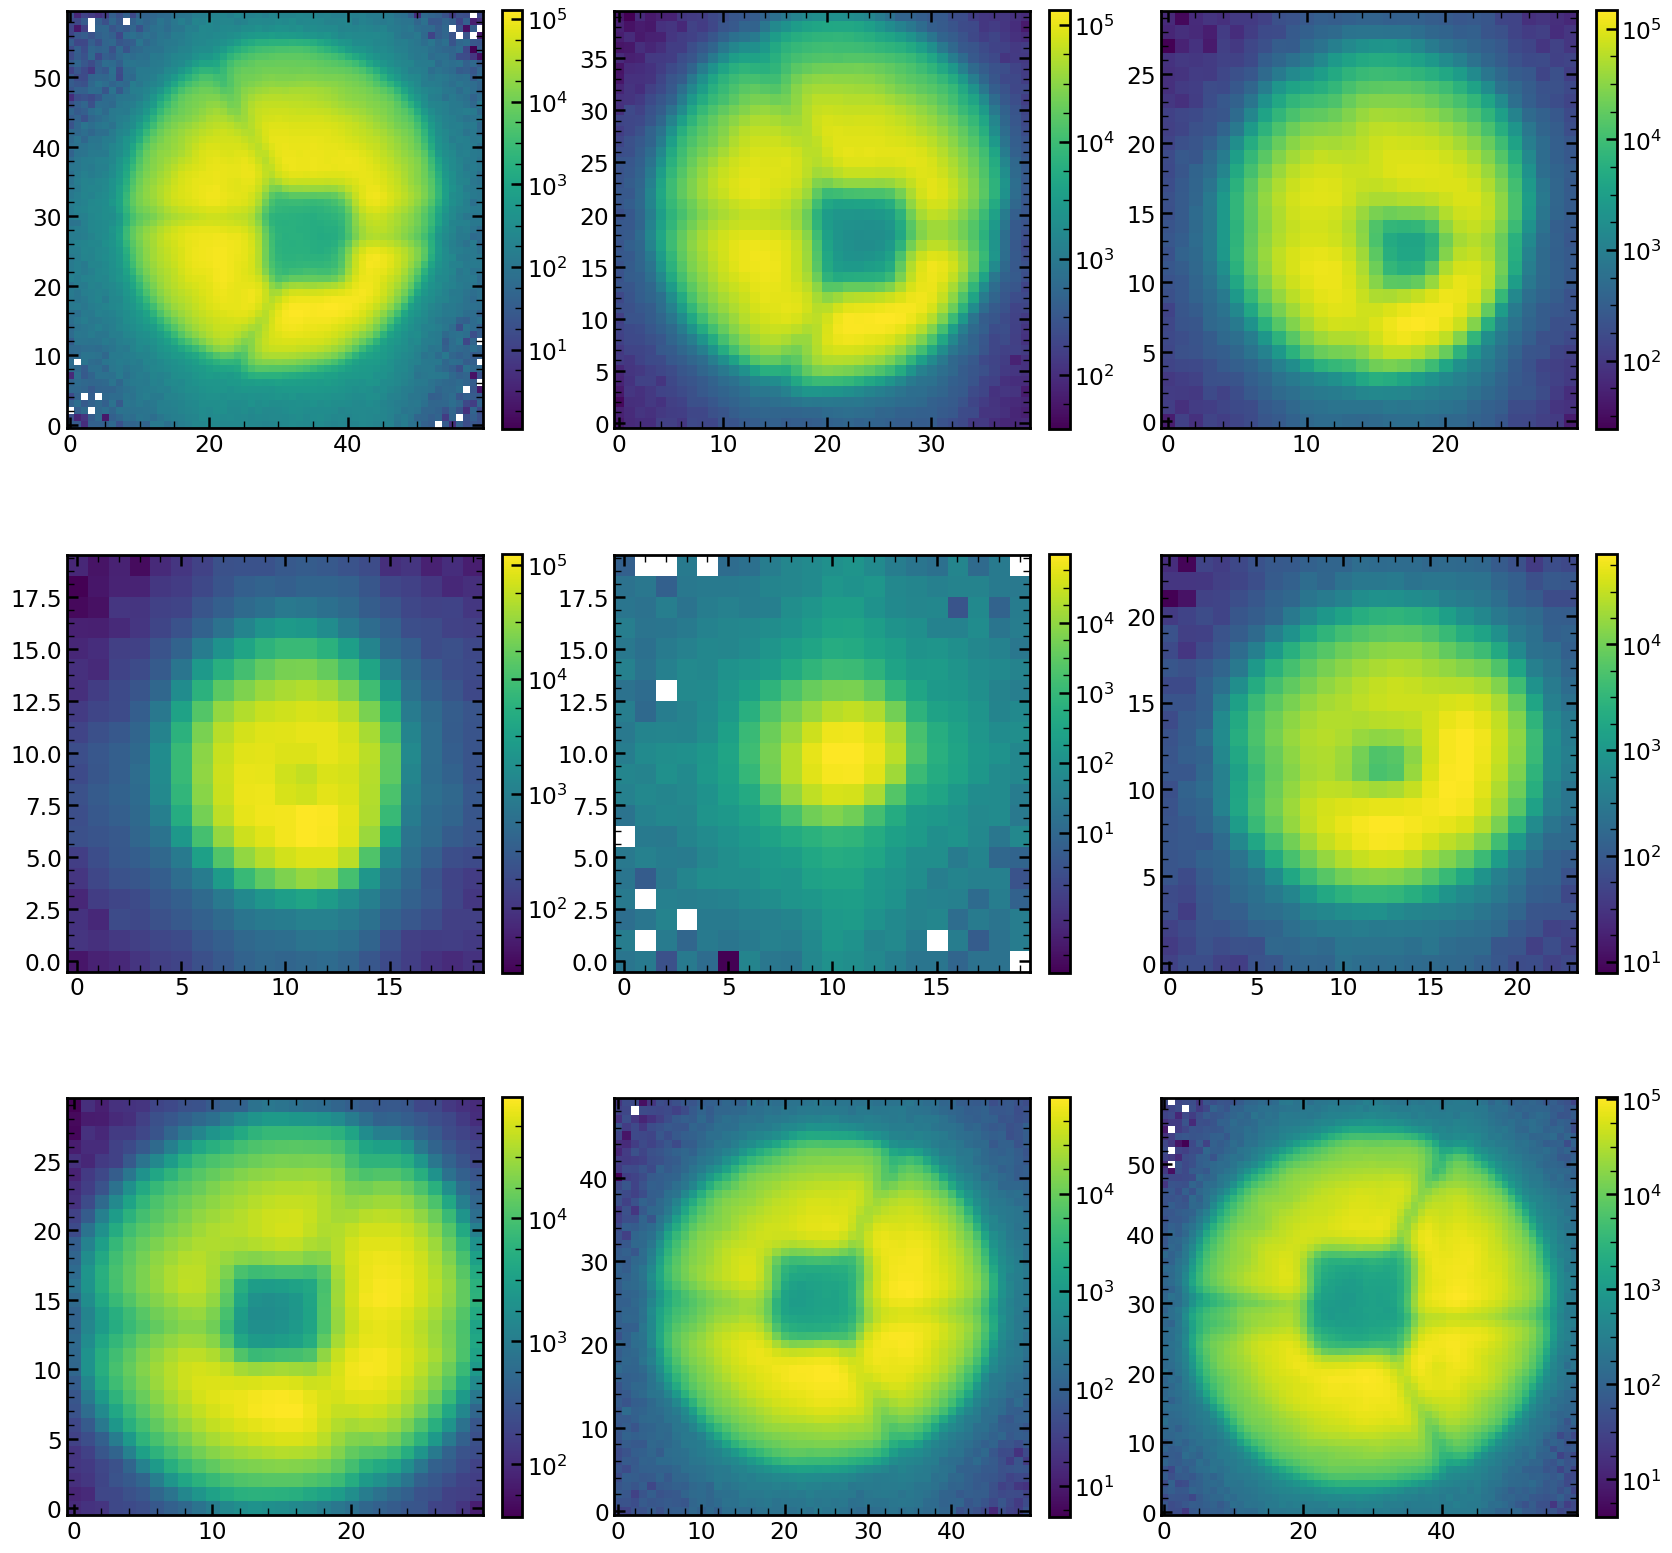

In [899]:
matplotlib.rcParams.update({'font.size': 14})

image_index=119
print(image_index)
run_1=12403
run_2=12391
run_3=12379
run_4=12367
run_5=12355
run_6=12343
run_7=12331
run_8=12319
run_9=12307


sci_1=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_1)+str(image_index)+'Ne_Stacked.npy')
sci_2=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_2)+str(image_index)+'Ne_Stacked.npy')
sci_3=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_3)+str(image_index)+'Ne_Stacked.npy')
sci_4=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_4)+str(image_index)+'Ne_Stacked.npy')
sci_5=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'Ne_Stacked.npy')
sci_6=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_6)+str(image_index)+'Ne_Stacked.npy')
sci_7=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_7)+str(image_index)+'Ne_Stacked.npy')
sci_8=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_8)+str(image_index)+'Ne_Stacked.npy')
sci_9=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_9)+str(image_index)+'Ne_Stacked.npy')

plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(sci_1,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(332)
plt.imshow(sci_2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(333)
plt.imshow(sci_3,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(334)
plt.imshow(sci_4,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(335)
plt.imshow(sci_5,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(336)
plt.imshow(sci_6,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(337)
plt.imshow(sci_7,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(338)
plt.imshow(sci_8,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(339)
plt.imshow(sci_9,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

119


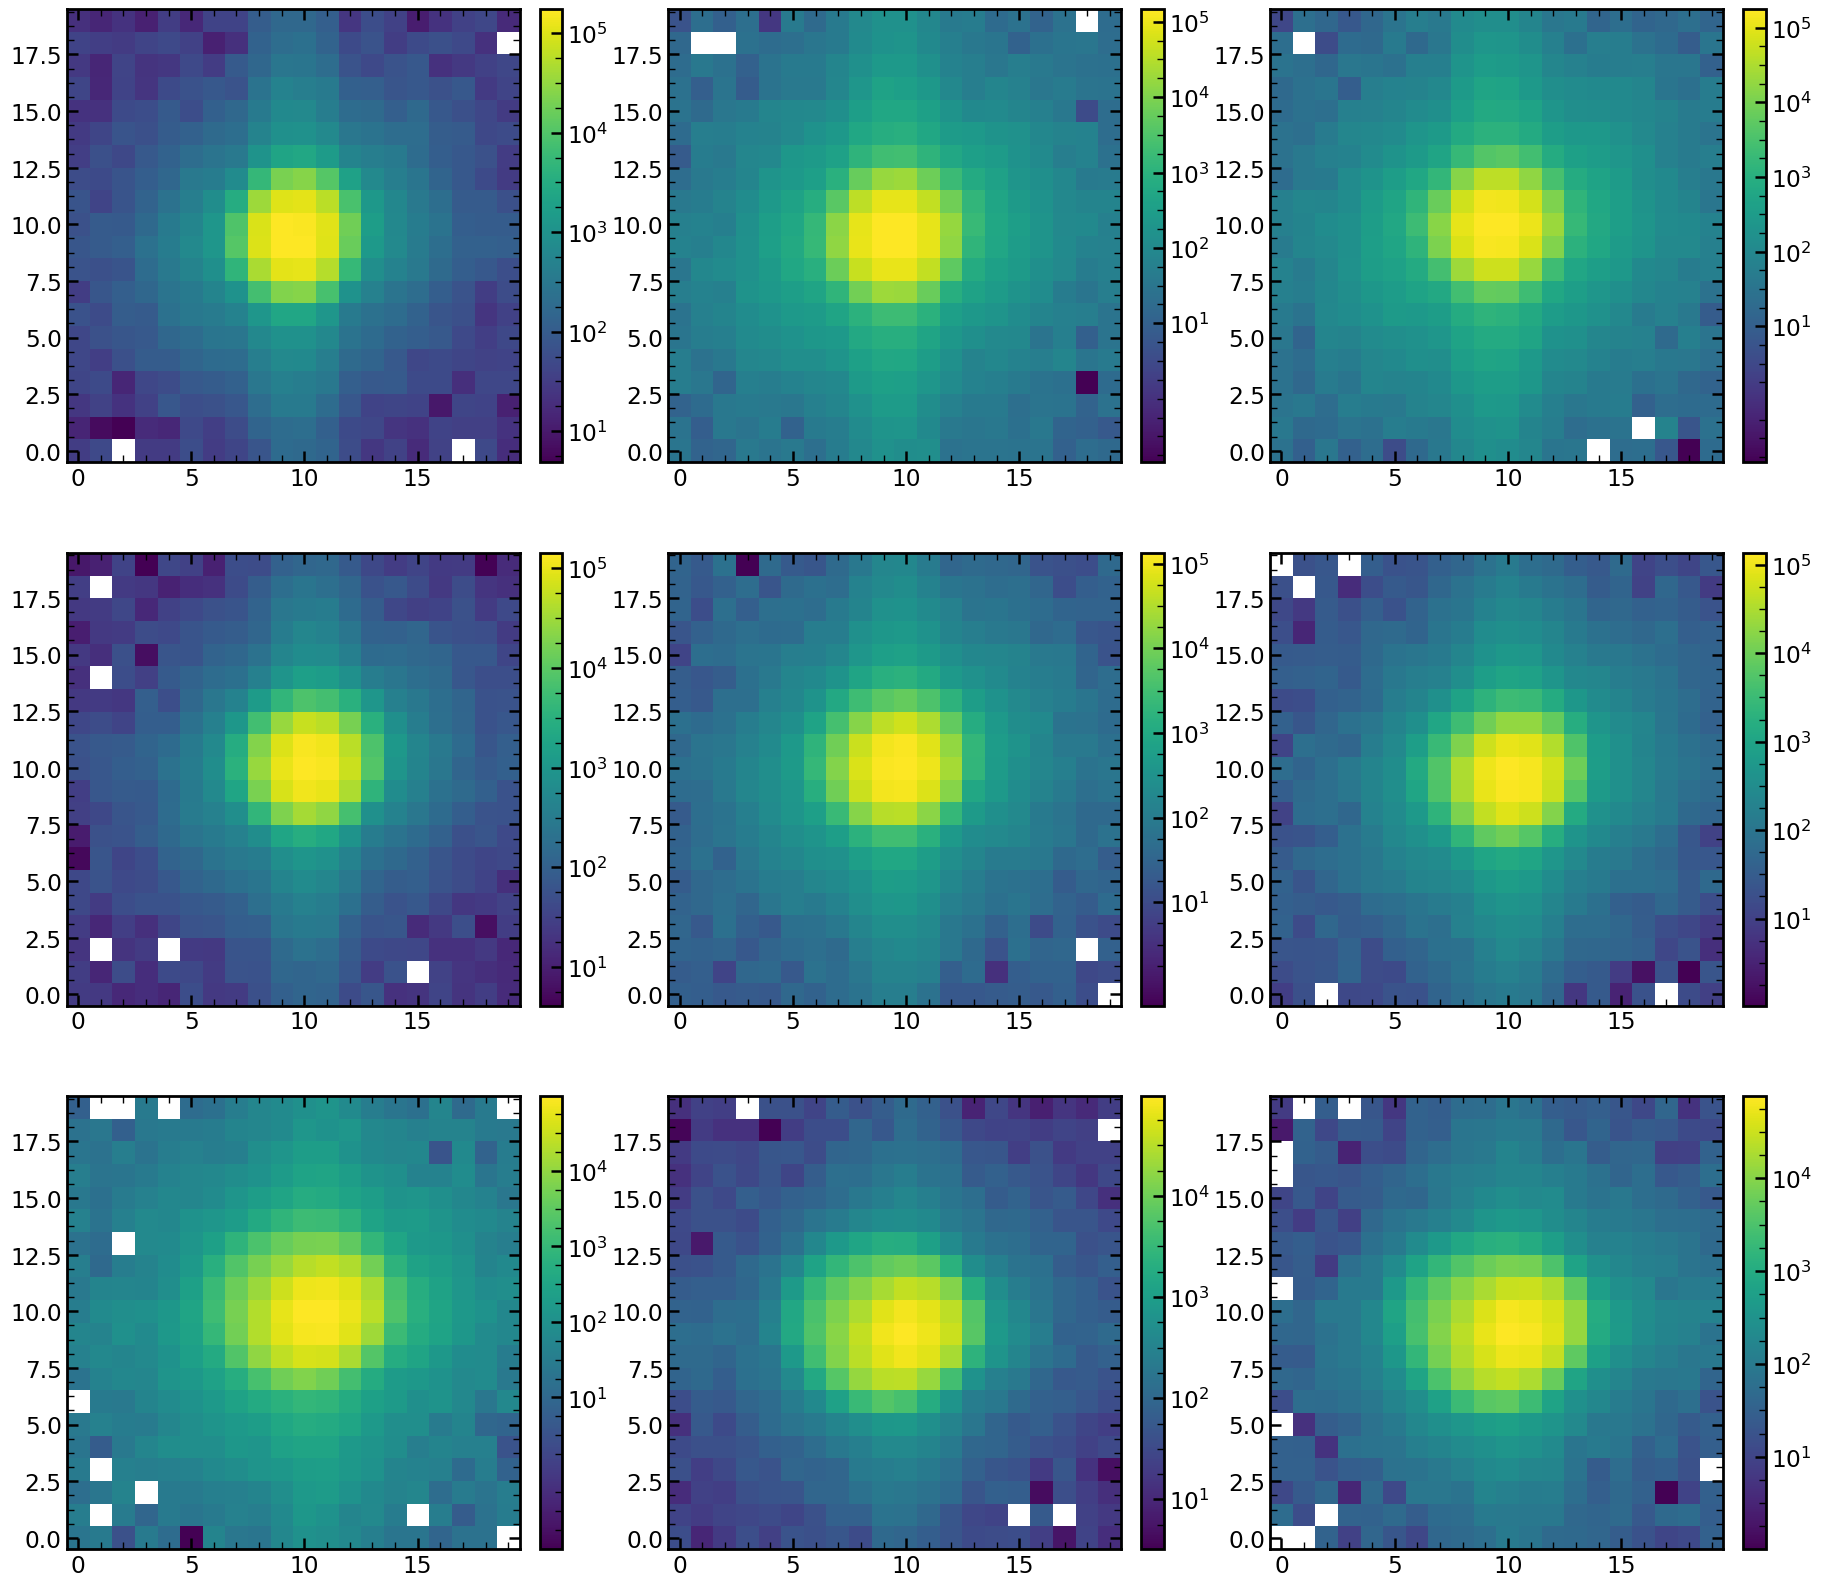

In [903]:
image_index=119
print(image_index)
run_1=12403
run_2=12391
run_3=12379
run_4=12367
run_5=12355
run_6=12343
run_7=12331
run_8=12319
run_9=12307


sci_1=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index-54)+'Ne_Stacked.npy')
sci_2=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index-45)+'Ne_Stacked.npy')
sci_3=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index-36)+'Ne_Stacked.npy')
sci_4=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index-27)+'Ne_Stacked.npy')
sci_5=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index-18)+'Ne_Stacked.npy')
sci_6=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index-9)+'Ne_Stacked.npy')
sci_7=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'Ne_Stacked.npy')
sci_8=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index+9)+'Ne_Stacked.npy')
sci_9=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Feb_5/Stamps_cleaned/sci"+str(run_5)+str(image_index+18)+'Ne_Stacked.npy')

plt.figure(figsize=(22,20))
plt.subplot(331)
plt.imshow(sci_1,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(332)
plt.imshow(sci_2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(333)
plt.imshow(sci_3,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(334)
plt.imshow(sci_4,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(335)
plt.imshow(sci_5,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(336)
plt.imshow(sci_6,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(337)
plt.imshow(sci_7,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(338)
plt.imshow(sci_8,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(339)
plt.imshow(sci_9,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

# old code 

In [510]:
run=11802

exposure_defocus_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')[0].header['W_ENFCAX']
exposure_defocus_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+1)+'/calExp-LA0'+str(run+1)+'r1.fits')[0].header['W_ENFCAX']
exposure_defocus_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+2)+'/calExp-LA0'+str(run+2)+'r1.fits')[0].header['W_ENFCAX']
exposure_defocus_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+3)+'/calExp-LA0'+str(run+3)+'r1.fits')[0].header['W_ENFCAX']
exposure_defocus_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+4)+'/calExp-LA0'+str(run+4)+'r1.fits')[0].header['W_ENFCAX']
exposure_defocus=[exposure_defocus_1,exposure_defocus_2,exposure_defocus_3,exposure_defocus_4,exposure_defocus_5]
exposure_defocus=np.round(np.array(exposure_defocus),1)
# size of the array with unique defocuc values should be 1 
print(np.unique(exposure_defocus).size)

scidata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')[1].data
scidata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+1)+'/calExp-LA0'+str(run+1)+'r1.fits')[1].data
scidata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+2)+'/calExp-LA0'+str(run+2)+'r1.fits')[1].data
scidata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+3)+'/calExp-LA0'+str(run+3)+'r1.fits')[1].data
scidata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+4)+'/calExp-LA0'+str(run+4)+'r1.fits')[1].data

maskdata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run)+'r1.fits')[2].data
maskdata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+1)+'/calExp-LA0'+str(run+1)+'r1.fits')[2].data
maskdata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+2)+'/calExp-LA0'+str(run+2)+'r1.fits')[2].data
maskdata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+3)+'/calExp-LA0'+str(run+3)+'r1.fits')[2].data
maskdata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+4)+'/calExp-LA0'+str(run+4)+'r1.fits')[2].data

vardata_1=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run)+'/calExp-LA0'+str(run+0)+'r1.fits')[3].data
vardata_2=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+1)+'/calExp-LA0'+str(run+1)+'r1.fits')[3].data
vardata_3=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+2)+'/calExp-LA0'+str(run+2)+'r1.fits')[3].data
vardata_4=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+3)+'/calExp-LA0'+str(run+3)+'r1.fits')[3].data
vardata_5=fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/FEB5/INTEGRATION/rerun/integration/arc/calExp/2019-02-02/v00'+str(run+4)+'/calExp-LA0'+str(run+4)+'r1.fits')[3].data

for image_index in range(len(finalHgAr_Feb2019)):
    center_pos=[int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[0]),int(np.array(finalHgAr_Feb2019.loc[image_index,['xc','yc']].values)[1])]
    print(center_pos)
    #size=stamp.shape[0]/2
    size=sizes_of_stamps[defocus_values==exposure_defocus[3]][0]
    size_of_stamp=size
    xposmin=int(np.round(center_pos[0]-size-10))
    xposmax=int(np.round(center_pos[0]+size+10))
    yposmin=int(np.round(center_pos[1]-size-45))
    yposmax=int(np.round(center_pos[1]+size+45))
    #print(xposmin,xposmax,yposmin,yposmax)
    scidata_cut=scidata_1[yposmin:yposmax,xposmin:xposmax]+scidata_2[yposmin:yposmax,xposmin:xposmax]+\
    scidata_3[yposmin:yposmax,xposmin:xposmax]+scidata_4[yposmin:yposmax,xposmin:xposmax]+scidata_5[yposmin:yposmax,xposmin:xposmax]
    
    # add background removal; 5 times as we have 5 images
    scidata_cut=scidata_cut-5*background_estimate_sigma_clip_fit_function(exposure_defocus[3])
    
    maskdata_cut=maskdata_1[yposmin:yposmax,xposmin:xposmax]+maskdata_2[yposmin:yposmax,xposmin:xposmax]+\
    maskdata_3[yposmin:yposmax,xposmin:xposmax]+maskdata_4[yposmin:yposmax,xposmin:xposmax]+maskdata_5[yposmin:yposmax,xposmin:xposmax]   
    
    vardata_cut=vardata_1[yposmin:yposmax,xposmin:xposmax]+vardata_2[yposmin:yposmax,xposmin:xposmax]+\
    vardata_3[yposmin:yposmax,xposmin:xposmax]+vardata_4[yposmin:yposmax,xposmin:xposmax]+vardata_5[yposmin:yposmax,xposmin:xposmax]     

    scidata_cut_original=np.copy(scidata_cut)
    
    sci_upper_cut=scidata_cut[len(scidata_cut[:,0])-40:len(scidata_cut[:,0])-5]
    sci_lower_cut=scidata_cut[5:40]
    res=[]
    res_upper=[]
    res_upper_all_values=[]
    res_lower=[]
    res_lower_all_values=[]
    for j in range(scidata_cut.shape[1]):

        value=np.median(sci_lower_cut[:,j])     
        value_var=np.std(sci_lower_cut[:,j]) 
        if value>0.7*value_var:
            res_lower.append(value)
            res_lower_all_values.append(value)
        else:
            res_lower.append(0)    
            res_lower_all_values.append(value)

        value=np.median(sci_upper_cut[:,j])  
        value_var=np.std(sci_upper_cut[:,j])  
        if value>0.7*value_var:
            res_upper_all_values.append(value)
            res_upper.append(value)
        else:
            res_upper.append(0)
            res_upper_all_values.append(value)
                
    res_upper=np.array(res_upper)
    res_upper_all_values=np.array(res_upper_all_values)
    res_lower=np.array(res_lower)
    res_lower_all_values=np.array(res_lower_all_values)
    # esnures that you do not oversubtract in the middle
    res_upper[res_upper>0]=res_upper[res_upper>0]-np.median(np.array(res_upper_all_values))
    res_lower[res_lower>0]=res_lower[res_lower>0]-np.median(np.array(res_lower_all_values))
    if float(finalHgAr_Feb2019.loc[image_index]['wavelength'])<950:
        # if there is another source in upper part, override it with lower half
        print(np.sum(sci_lower_cut)/np.sum(sci_upper_cut))
        if np.sum(sci_upper_cut)/np.sum(sci_lower_cut)>1.1:
            res_upper=res_lower

        # if there is another source in lower part, override it with upper half
        elif np.sum(sci_lower_cut)/np.sum(sci_upper_cut)>1.1:
            res_lower=res_upper
    
    # different then focus part, taken from ``Working with Reduced data''
    scidata_cut_large_removed=scidata_cut_large
    maskdata_cut_large_removed=maskdata_cut_large
    vardata_cut_large_removed=vardata_cut_large
    for j in range(scidata_cut_large.shape[1]):    
        scidata_cut_large_removed[0:int(scidata_cut_large.shape[0]/2),j]=scidata_cut_large[0:int(scidata_cut_large.shape[0]/2),j]-res_lower[j]
        scidata_cut_large_removed[int(scidata_cut_large.shape[0]/2):,j]=scidata_cut_large[int(scidata_cut_large.shape[0]/2):,j]-res_upper[j]

        maskdata_cut_large_removed[0:int(scidata_cut_large.shape[0]/2),j]=scidata_cut_large[0:int(scidata_cut_large.shape[0]/2),j]-res_lower[j]
        maskdata_cut_large_removed[int(scidata_cut_large.shape[0]/2):,j]=scidata_cut_large[int(scidata_cut_large.shape[0]/2):,j]-res_upper[j]
        
        vardata_cut_large_removed[0:int(vardata_cut_large.shape[0]/2),j]=vardata_cut_large[0:int(vardata_cut_large.shape[0]/2),j]+res_lower[j]
        vardata_cut_large_removed[int(vardata_cut_large.shape[0]/2):,j]=vardata_cut_large[int(vardata_cut_large.shape[0]/2):,j]+res_upper[j]

    ############################ 
    # cutting final image
    # allow for 5 pixels change, to capture wings of the donut

    y_min_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2-size_of_stamp/2-5)
    y_max_for_scidata_cut_large_removed=int(scidata_cut_large_removed.shape[0]/2+size_of_stamp/2+5)

    scidata_cut_large_removed_prestep=scidata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]
    maskdata_cut_large_removed_prestep=maskdata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]   
    vardata_cut_large_removed_prestep=vardata_cut_large_removed[y_min_for_scidata_cut_large_removed:y_max_for_scidata_cut_large_removed]

    y_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep,axis=1)>30*3)))
    x_pos_for_final_cut=np.round(np.median(np.where(np.max(scidata_cut_large_removed_prestep,axis=0)>30*3)))

    scidata_final_cut=scidata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
    maskdata_final_cut=maskdata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]
    vardata_final_cut=vardata_cut_large_removed_prestep[int(y_pos_for_final_cut-size_of_stamp/2):int(y_pos_for_final_cut+size_of_stamp/2),int(x_pos_for_final_cut-size_of_stamp/2):int(x_pos_for_final_cut+size_of_stamp/2)]

    
    ############################


    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy',scidata_final_cut)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked.npy',maskdata_final_cut)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked.npy',vardata_final_cut)

    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',scidata_cut_large_removed)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/mask"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',maskdata_cut_large)
    np.save("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/var"+str(run)+str(image_index)+'HgAr_Stacked_large.npy',vardata_cut_large_removed)


1
[273, 789]
0.17010054
[274, 855]
2.368088
[274, 972]
1.7433745
[274, 1208]
1.0130417
[274, 1335]
1.0482348
[274, 1625]
0.050932605
[274, 1987]
0.06868408
[272, 2354]
1.2990313
[270, 2655]
7.021284
[264, 3366]
0.5280468
[263, 3487]
5.039764
[256, 4011]
[484, 782]
0.17799981
[485, 848]
2.3896775
[485, 965]
1.6209544
[485, 1201]
1.0061272
[485, 1328]
1.0445514
[485, 1617]
0.04990385
[484, 1979]
0.0704652
[483, 2346]
1.3141421
[481, 2646]
6.854129
[476, 3357]
0.47815737
[475, 3478]
3.5327113
[468, 4000]
[868, 772]
0.16674204
[868, 839]
2.3420224
[868, 955]
1.7027812
[868, 1190]
1.0139077
[868, 1318]
1.033956
[867, 1606]
0.052452862
[867, 1968]
0.06987509
[865, 2334]
1.3108138
[864, 2634]
6.3900614
[860, 3343]
0.4971996
[859, 3464]
3.1432045
[854, 3985]
[911, 772]
0.16673957
[911, 838]
2.4261606
[911, 954]
1.9522772
[911, 1190]
1.0139259
[911, 1317]
1.0412643
[911, 1605]
0.053586733
[910, 1966]
0.065392666
[908, 2333]
1.3205249
[907, 2633]
7.302072
[903, 3342]
0.5593613
[902, 3463]
4.0848

In [512]:
run=11802
image_index=66
test=np.load("/Users/nevencaplar/Documents/PFS/Data_Feb_5/Stamps_cleaned/sci"+str(run)+str(image_index)+'HgAr_Stacked.npy')

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


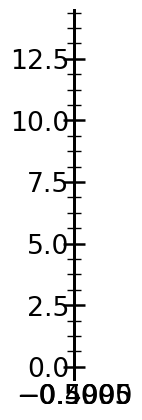

In [513]:
plt.imshow(test)